# Miniproject 2: Melody generation

## Introduction

### Description

To develop a model employing ANN on real-world data requires going through several major steps, each of which with important design choices that directly impact the end results. In this project, we guide you through these choices starting from a large database of [Irish folk melodies](https://github.com/IraKorshunova/folk-rnn/tree/master/data) to your own model of symbolic music composition. 


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. Please ensure that your notebook is fully executed before handing it in. 

## Functions and imports

For your convenience we import some libraries and provide some functions below. Some libraries (`midi` and `music21==5.1.0`) should be added. If you work with the docker image, pull it `docker pull zifeo/artificial-neural-networks:cpu` before to get the latest version where these libraries are added and stop/relaunch the container (as stated in the instructions https://github.com/zifeo/artificial-neural-networks). If you work locally, be sure to import them. If you do not find the midi library for python3, install it with `python setup.py install` inside the `python3-midi` folder after cloning https://github.com/louisabraham/python3-midi.git.

Finally, fill in your sciper number(s) for the random seed and simply run the following cell.

In [56]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import copy


sciper = {'student_1': 237699, 'student_2': 279617}
seed = sciper['student_1']+sciper['student_2']



plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 8, 4

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

import midi
import music21

In [57]:
def plotMelody(P, T, dictionaries, PrP=None, PrT=None, H=None):
    """
    P: The pitch array (integer representation) or matrix (one-hot encoding)
    T: The duration array (integer representation) or matrix (one-hot encoding)
    dictionaries: The dictionaries relating integer to a pitch or duration
    PrP: (Optional) If provided with PrT, plot the transition probabilities
    PrT: (Optional) If provided with PrP, plot the transition probabilities
    H: (Optional) Add a plot with the hidden state dynamic sorted by frequency
    """
    P = np.asarray(P)
    T = np.asarray(T)
    if len(P.shape) == 1:#if array
        P = np_utils.to_categorical(P, len(dictionaries['P']))
    if len(T.shape) == 1:#if array
        T = np_utils.to_categorical(T, len(dictionaries['T']))
    
    xlim = [-1,np.where(P==1)[0][-1]+1]
    
    activeidxes = np.where(np.sum(P, axis=0)>0.)[0]
    plt.figure(figsize=(8,4))
    if PrP is not None:
        targets = np.where(P[:,activeidxes]==1)
        plt.imshow(PrP[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.') 
    else:
        plt.imshow(P[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["P"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$P[n]$")
    plt.xlim(xlim)
    plt.show()
    
    activeidxes = np.where(np.sum(T, axis=0)>0.)[0]
    plt.figure(figsize=(8,4))
    if PrT is not None:
        targets = np.where(T[:,activeidxes]==1)
        plt.imshow(PrT[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.')
    else:
        plt.imshow(T[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["T"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$T[n]$")
    plt.xlim(xlim)
    plt.show()
    
    
    if H is not None:
        diff = np.mean([[abs(j-i) for i,j in zip(H[:xlim[1]-1,k], H[1:xlim[1],k])] for k in range(H.shape[1])], axis=1)
        sortidx = np.argsort(-diff)
        H = H[:,sortidx]
        plt.figure(figsize=(8,4))
        plt.imshow(H.T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.seismic, vmin=-1, vmax=1)
        plt.xlim([-1,np.where(T==1)[0][-1]+1])
        plt.tight_layout()
        plt.xlabel("$n$")
        plt.ylabel("$H[n]$")
        plt.show()


def plotLearningCurves(History):
    
    log = History.history
    
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_loss'], '--', c=c[0], label='Pitch train loss')
    plt.plot(log['val_YP_loss'], c=c[0], label='Pitch val loss')
    
    plt.plot(log['YT_loss'], '--', c=c[1], label='Dur train loss')
    plt.plot(log['val_YT_loss'], c=c[1], label='Dur val loss')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_acc'], '--', c=c[0], label='Pitch train acc')
    plt.plot(log['val_YP_acc'], c=c[0], label='Pitch val acc')
    
    plt.plot(log['YT_acc'], '--', c=c[1], label='Dur train acc')
    plt.plot(log['val_YT_acc'], c=c[1], label='Dur val acc')
    plt.legend(loc='best')

def sample(preds, temperature=1.):
    """Helper function to sample an index from a probability array"""
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def writeMIDI(xP, xT, dictionaries, label):

    # Instantiate a MIDI Pattern (contains a list of tracks)
    pattern = midi.Pattern(format = 0, resolution=480)
    # Instantiate a MIDI Track (contains a list of MIDI events)
    track = midi.Track()
    # Append the track to the pattern
    pattern.append(track)
    Events = []
    
    pseq = [dictionaries['P'][p] for p in xP]
    tseq = [dictionaries['T'][t] for t in xT]
    for t, p in zip(tseq, pseq):
        e = midi.NoteOnEvent(tick=0, velocity=90, pitch=p)
        track.append(e)
        e = midi.NoteOffEvent(tick=t, velocity=0, pitch=p)
        track.append(e)
        
    eot = midi.EndOfTrackEvent(tick=1)
    track.append(eot)
    # Save the pattern to disk
    midi.write_midifile(label, pattern)

## Exercise 1 : Data processing
### Description

For a real world application of ANNs, the original data should be translated into a representation understandable by an ANN. This step is often neglected but is of outmost importance. In order for you to better understand how ANN are applied to real world problems, the first step of this miniproject will guide you through a possible representation. 

Note that in general, your representation should be normalized in order to obtain homogeneous data from which a structure can be extracted by your ANN model. Importantly, all processing steps toward your representation should not (or minimally) distort your original data.

To represent MIDI files, we provide you with a Python MIDI library. You should then

0. Download the MIDI tar file from [this link](https://github.com/IraKorshunova/folk-rnn/tree/master/data) and put it in a folder named "chorpus" at the same level of this notebook.
1. Parse the chorpus to extract the label of (a random subset of) the data (code is provided)
2. Read each MIDI file in the subset with the midi [library](https://github.com/louisabraham/python3-midi)
3. For each data sequence extract the sequence of MIDI notes defined by two dimensions ("P": the sequence of note pitches (integer between 0 and 127 representing a piano key), "T": the sequence of note durations.
4. Select two melodies and display them both as sequences of MIDI events and sequence of notes in two dimensions. Control that your representation is correct.

For step 3, you should learn how MIDI files are constructed. Below, we give a minimal explanation and some code for this particular project. For a more complete explanation, look for MIDI in your favorite search engine. Given this dataset, you can observe that it is monophonic (one note at a time) and there's a small delay (1 tick) inbetween each note. You could decide to ignore this delay or correct (recommanded) for it.

A MIDI files is composed of timed events of many kinds. For this project, we focus on the events related to notes being played or stopped. Those are MIDI events "Note Off" and "Note On". Each event is timed with respect with the previous one (dt). The duration of a note is therefore given by the cummulated dt inbetween the event associated to a note's onset and the event associated with the same note's offset.
        

### Minimal code to read MIDI files

In [58]:
def display(midi_file="chorpus/sessiontune0.mid"):
    #index 0 for first track only
    events = midi.read_midifile(midi_file)[0] 
    tick = 0
    print("File: {}\n".format(midi_file))
    print("#"*40)
    print("tick \t pitch \t message \t velocity")
    print("#"*40)
    #print(events)
    for n, event in enumerate(events):
        tick += event.tick
        if event.name in ['Note On', 'Note Off']:
            if n<13 or n>len(events)-10:
                print("%i \t %i \t %s \t %i"%(tick, event.data[0], event.name, event.data[1]))
            if n in range(20,23):
                print(". \t . \t . \t \t .")
    print("#"*40+'\n')

display()

datapath = "chorpus/"
dataset = {}
np.random.seed(seed)

for filename in os.listdir(datapath):
    if filename.endswith("mid"):
        label = filename[:-4]
        #Down sample dataset
        if np.random.rand() < 0.1:
            dataset[label] = {"T":[], "P": []}
print("%i/%i melodies retained"%(len(list(dataset.keys())), len(os.listdir(datapath))))

File: chorpus/sessiontune0.mid

########################################
tick 	 pitch 	 message 	 velocity
########################################
1 	 67 	 Note On 	 105
240 	 67 	 Note Off 	 0
241 	 64 	 Note On 	 80
480 	 64 	 Note Off 	 0
481 	 64 	 Note On 	 80
720 	 64 	 Note Off 	 0
721 	 64 	 Note On 	 95
1200 	 64 	 Note Off 	 0
1201 	 62 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
33601 	 67 	 Note On 	 80
33840 	 67 	 Note Off 	 0
33841 	 69 	 Note On 	 95
34080 	 69 	 Note Off 	 0
34081 	 71 	 Note On 	 80
34320 	 71 	 Note Off 	 0
34321 	 72 	 Note On 	 80
34560 	 72 	 Note Off 	 0
########################################

4634/45853 melodies retained


### Solution

In [59]:
def parseMIDI(midi_file): ## Question 2
    events = midi.read_midifile(midi_file)[0] #index 0 for first track only  
    T = []
    P = []
    tick=0
    for n, event in enumerate(events):
        if event.name in ['Note On']:
            tick = event.tick 
        elif event.name in ['Note Off']:
            tick += event.tick
            T.append(tick)
            P.append(event.data[0])
        else:
            tick += event.tick
    return P, T

for label in list(dataset.keys()): ### Question 3
    Pseq, Tseq = parseMIDI(datapath+label+".mid")
    dataset[label]['T']= Tseq ### Question 4
    dataset[label]['P']= Pseq

for label in np.random.choice(list(dataset.keys()), 2): ### Question 5
    print("File: {}".format(label))
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print(dataset[label])
    print('\n')

File: sessiontune27925
MIDI events
File: chorpus/sessiontune27925.mid

########################################
tick 	 pitch 	 message 	 velocity
########################################
1 	 61 	 Note On 	 105
60 	 61 	 Note Off 	 0
61 	 63 	 Note On 	 80
120 	 63 	 Note Off 	 0
121 	 65 	 Note On 	 80
180 	 65 	 Note Off 	 0
181 	 66 	 Note On 	 80
240 	 66 	 Note Off 	 0
241 	 68 	 Note On 	 105
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
60121 	 70 	 Note On 	 80
60240 	 70 	 Note Off 	 0
60241 	 68 	 Note On 	 80
60360 	 68 	 Note Off 	 0
60361 	 60 	 Note On 	 80
60720 	 60 	 Note Off 	 0
60721 	 61 	 Note On 	 95
61440 	 61 	 Note Off 	 0
########################################

Note representation
{'T': [60, 60, 60, 60, 360, 120, 120, 360, 120, 360, 360, 120, 360, 120, 360, 120, 120, 360, 360, 120, 360, 120, 360, 120, 360, 120, 360, 120, 360, 240, 360, 120, 120, 120, 120, 120, 360, 120, 360, 120, 120, 360, 120, 360, 360, 120, 360, 120, 360, 120, 120, 360, 360, 120, 360, 120

## Exercise 2: Tokenzation and translation to integer
### Description

Now you should have a "dataset" dictionary where each entry corresponds to one melody example from a subset of the full dataset. In turn, every melody example is represented by a dictionary with two sequences: the "P" entry being the sequence of pitches and the "T" entry, the sequence of durations. Here, you will implement the first steps to translate this dataset in a language that can be read by your ANN models. To achieve that, we will later use the [one-hot encoding scheme](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), which will associate each input (and output) unit of your network to a unique pitch or duration. In your network, these units will then be sequentially activated in the same order as their corresponding pitch/duration in your dataset. And at each note, the model will be trained to approximate the probability distributions of the upcoming pitch and duration.

1. Gather in a list of all possible pitches and durations in your dataset. These two lists will be your "dictionaries" translating a pitch/duration to a unique integer between 0 and the number of entries (-1) in the pitch/duration dictionary.
2. Translate the pitch/duration sequence of each melody to the integer representation.
3. Select randomly two melodies and display them in the note representation and translated to integer. Check that the translation is correct.

### Solution


 Question 1 :

T_dictionary:
 [  30   40   45   50   59   60   80   90  106  119  120  127  144  150  159
  160  179  180  200  213  220  229  230  239  240  280  300  319  320  321
  359  360  400  460  469  479  480  560  600  639  640  719  720  800  840
  880  959  960 1040 1080 1120 1199 1200 1280 1320 1439 1440 1680 1840 1919
 1920 2080 2159 2160 2399 2400 2640 2720 2879 2880 3120 3360 3840 4320 5040
 5520 5760]

P_dictionary:
 [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]

Question 2 :  

Note representation for T:
 [240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 2

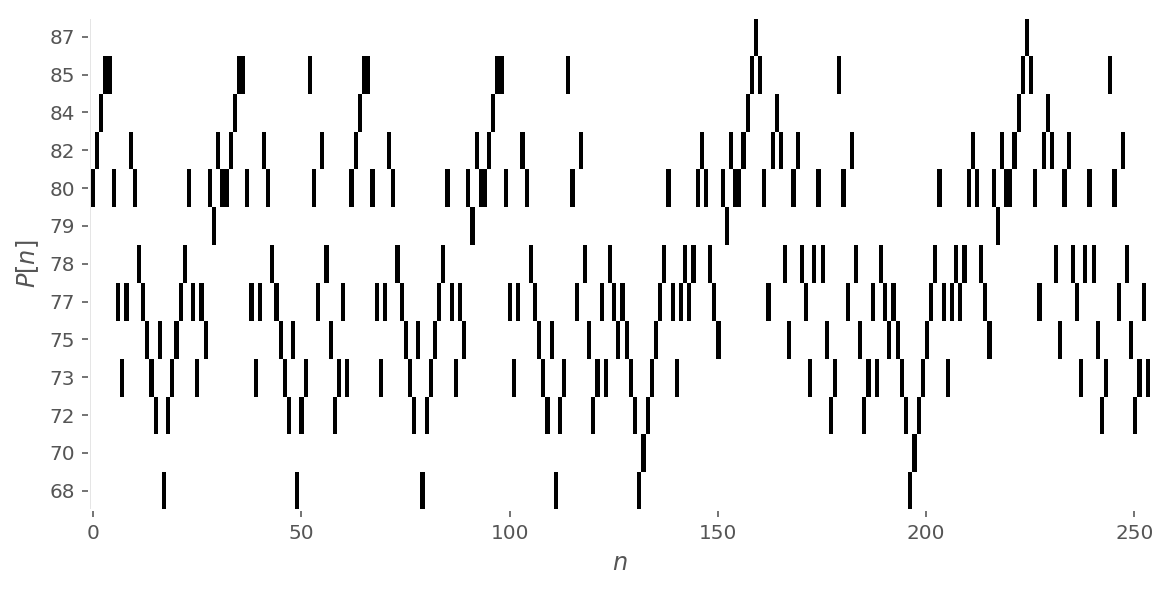

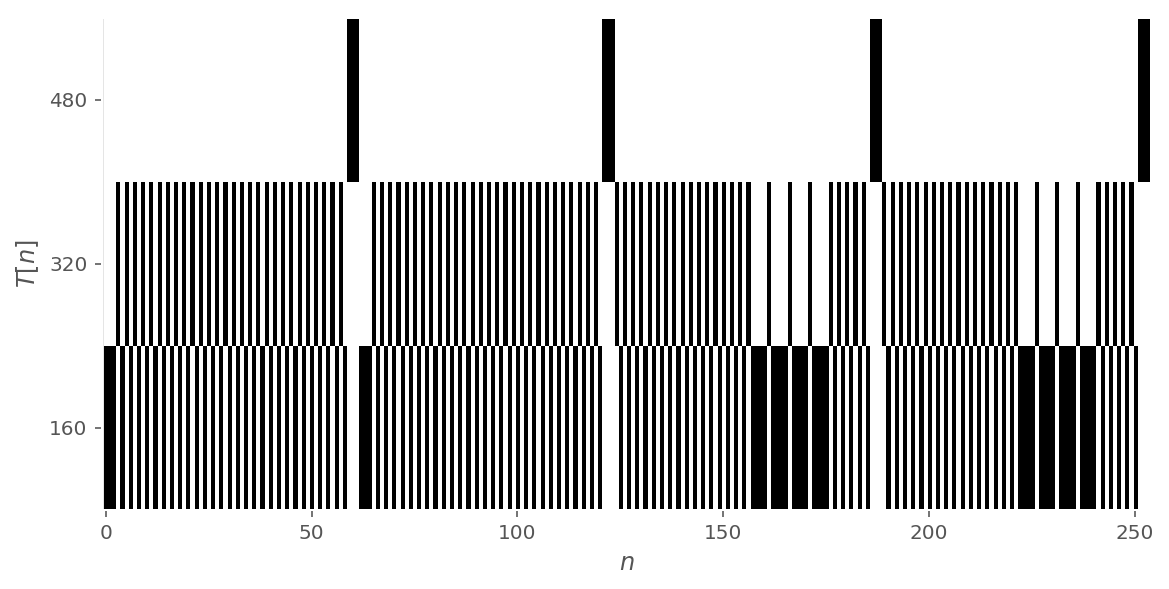

File: chorpus/sessiontune41300.mid

########################################
tick 	 pitch 	 message 	 velocity
########################################
1 	 73 	 Note On 	 105
480 	 73 	 Note Off 	 0
481 	 77 	 Note On 	 80
720 	 77 	 Note Off 	 0
721 	 73 	 Note On 	 80
960 	 73 	 Note Off 	 0
961 	 80 	 Note On 	 95
1200 	 80 	 Note Off 	 0
1201 	 85 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
59761 	 73 	 Note On 	 80
60000 	 73 	 Note Off 	 0
60001 	 77 	 Note On 	 80
60240 	 77 	 Note Off 	 0
60241 	 80 	 Note On 	 80
60480 	 80 	 Note Off 	 0
60481 	 85 	 Note On 	 95
61440 	 85 	 Note Off 	 0
########################################

Note representation
{'T': [480, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 480, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 480, 480, 480, 2

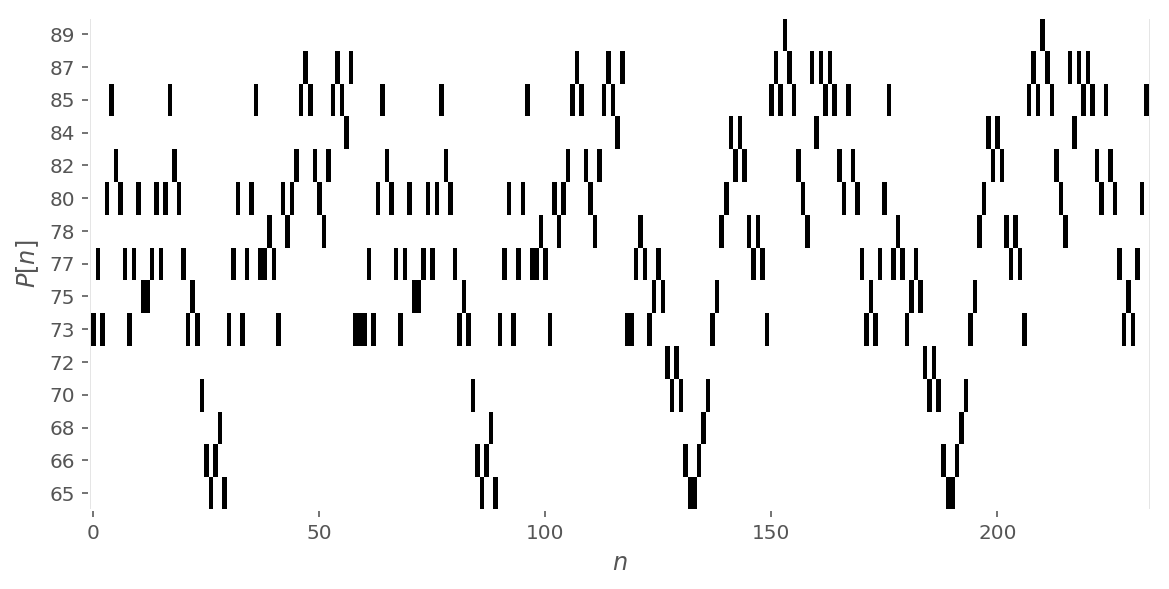

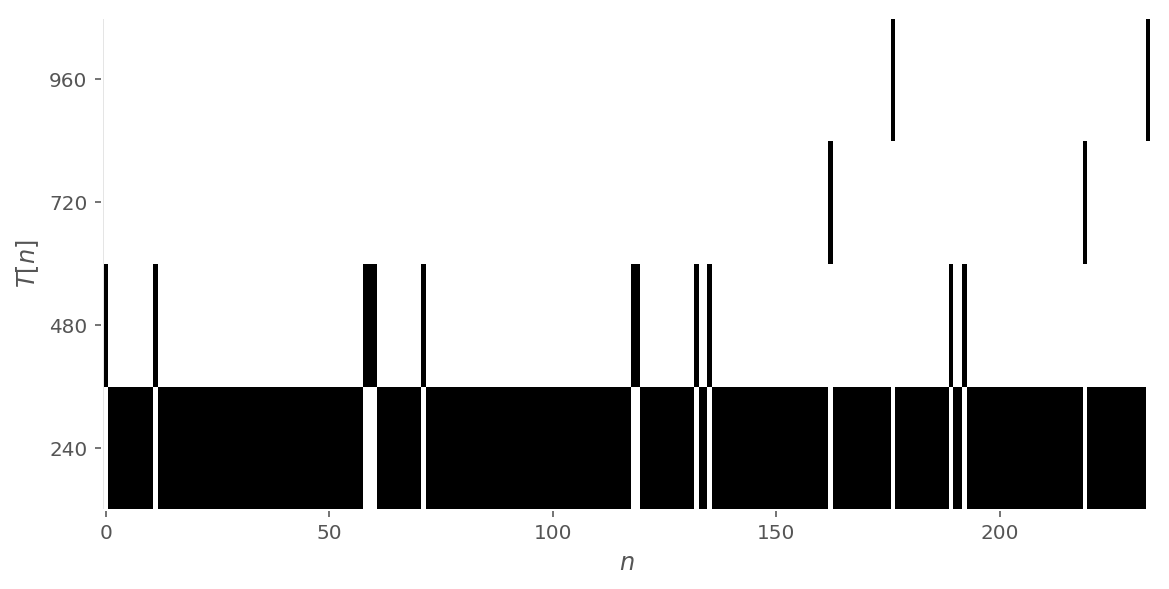

In [60]:
#######################################################################
# Question 1: Gather in a list of all possible pitches and durations in the dataset  
#######################################################################

sum_T,sum_P = list(), list()
for label in list(dataset.keys()):
    for t in dataset[label]['T']:
        sum_T.append(t)
    for p in dataset[label]['P']:
        sum_P.append(p)
### Creation of the 2 dictionary ###   
T_dictionary = (np.unique(sum_T)) 
P_dictionary = (np.unique(sum_P)) 
print ('\n Question 1 :')
print('\nT_dictionary:\n {}'.format(T_dictionary))
print("\nP_dictionary:\n {}\n".format(P_dictionary))


#############################################################################################################################
# Question 2 : Translate the pitch/duration sequence of each melody to the integer representation.
#############################################################################################################################
print('Question 2 :  \n')
int_dataset = copy.deepcopy(dataset) 
for label in list(int_dataset.keys()):
    int_dataset[label]['T']  = [np.where(T_dictionary==x)[0][0] for x in int_dataset[label]['T']]
    int_dataset[label]['P']  = [np.where(P_dictionary==x)[0][0] for x in int_dataset[label]['P']]

print("Note representation for T:\n",dataset[label]['T'])
print ("\nInteger representation for T:\n",int_dataset[label]['T'])

print("\nNote representation for P:\n",dataset[label]['P'])
print ("\nInteger representation for P:\n",int_dataset[label]['P'])
    
#############################################################################################################################
# Question 3: Select randomly two melodies and display them in the note representation and translated to integer.
############################################################################################################################# 

print ('\nQuestion 3\n')

dictionaries = {'T': T_dictionary, 'P': P_dictionary}
for label in np.random.choice(list(int_dataset.keys()), 2):
    display(datapath+label+".mid")
    print("Note representation")
    print(dataset[label])
    print('\n')
    print("Integer representation of the note")
    print(int_dataset[label])
    print('\n')
    plotMelody(int_dataset[label]['P'], int_dataset[label]['T'], dictionaries, PrP=None, PrT=None, H=None)

## Exercise 3: Data reprocessing
### Description

Before moving to the implementation of your RNN generative model of note transition, you will perform data exploration and modification. This step will allow your model to get the most out of your original data as well as ensuring some features such as transposition invariance. 

To further improve your model, you might want to reconsider your original data. Many different approaches can be undertaken. Here you are asked to implement the a rare event suppression method and transposition invariance.

**Rare event suppression** If a unit in your network is associated to a duration that happens very rarely in your data, a possible simplification consists in removing the melodies conaining these rare events from your dataset. 
1. Plot and comment the histogram of durations in your entire dataset. Use the labels from the original duration values (rather than the integer representation). 
2. Based on your observations, remove from your dataset melodies containing very rare durations. Adjust the rejection threshold such that at most 5% of the melodies are dicarded with this step. 
3. Recompute the duration dictionary based on your filtered dataset and plot the new histogram of durations. 

**Transposition invariance** A melody is perceived similarly by the human ear if it's shifted up or down by a constant offset (see [transposition](https://en.wikipedia.org/wiki/Transposition_(music))). Here, you will force your model to be transposition invariant. For this you can choose to use one of two orthogonal methods. The first consists in transposing every melody into a common tonality (C Major/A minor). On the other hand, the second consists in transposing each melody in all possible keys. The second method will increase your dataset size by a factor bigger than 11! As the training time is directly related with the dataset size, to save computing time, we recomand that you implement the first option.

***Pitch normalization*** 
1. Use the provided function to create a new dataset where all melodies are transposed to C Major/A minor. 
2. Plot the histograms of the pitches before and after transposition.

Finally, you shoud recompute the tokenization step for your brand new filtered and normalized dataset.

### Solution

#### Rare event suppression : 

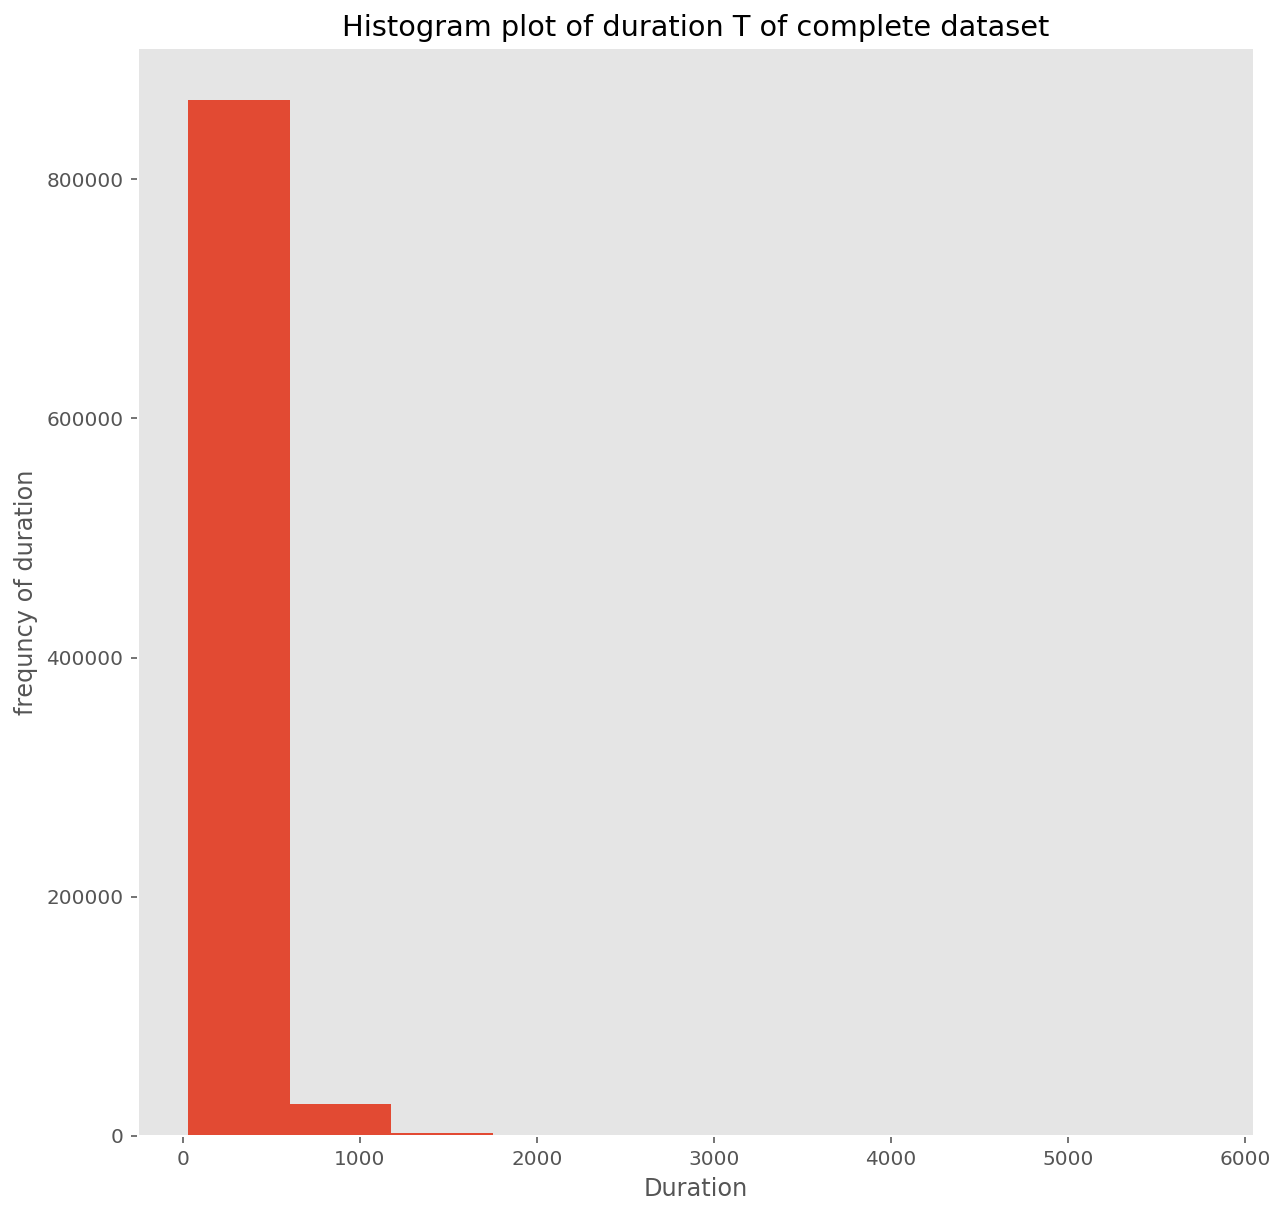

Size of the dataset in T:  894884
Statistics of T, Mean:272, Median:240, Max:5760


In [61]:
#############################################################################################################################
# Question 1 : Plot and comment the histogram of durations in your entire dataset.
############################################################################################################################# 

fig = plt.figure(figsize=(10,10))
plt.hist(sum_T)
plt.title('Histogram plot of duration T of complete dataset')
plt.xlabel('Duration')
plt.ylabel('frequncy of duration')
plt.show()
print ('Size of the dataset in T: ', len(sum_T))
print('Statistics of T, Mean:{:.0f}, Median:{:.0f}, Max:{:.0f}'.format( np.mean(sum_T), np.median(sum_T), np.max(sum_T)))


### Comment the histogram of durations in your entire dataset: 
We can say that nearly all the data are between 0 and 2000. Also, as we can see from the dataset that mean and median are close to duration 250. And the maximum of possible T is around 6000.   

We thus remove the rare duration events from the dataset by thresholding.


In [62]:
#############################################################################################################################
# Question 2 : Remove from your dataset melodies containing very rare durations + Adjust the rejection threshold such that at most 5% of the melodies are dicarded.
############################################################################################################################# 

nb_repetition = np.zeros(len(T_dictionary), dtype=np.int32)
for label in list(dataset.keys()):
    for t in dataset[label]['T']:
        index = np.where(t == T_dictionary)[0]
        nb_repetition[index] += 1
    
print ('Histogram of T_dictionary : \n', nb_repetition)


        
usual_events={}
threshold = 160
for label in list(dataset.keys()):
    stay=True
    for t in dataset[label]['T']:
        #print(t)
        n = np.where(t == T_dictionary)[0]
        if(nb_repetition[n] < threshold):
            stay=False
            break
    if stay==True : 
        usual_events[label] = {"T":[], "P": []}
        usual_events[label]['T'] = dataset[label]['T'];
        usual_events[label]['P'] = dataset[label]['P'];
        #print("enters")

        
    #break   

discarded = float(len(usual_events.keys()))/float(len(dataset.keys()))
print(len(usual_events.keys()), len(dataset.keys()), discarded)
print('\n The percentage of melodies that are dicarded: ', (1-discarded)*100,'%')

Histogram of T_dictionary : 
 [    20     82      4      1      4  12613   2562      8      2     68
  49295     10     20      3    272  66416      1    640     10      2
      1     21      1    510 609756     17     10    210  29563      2
     82   1247     26      1      6    633  92091     30     54      3
    128    158  18708    461     56      1     80   6429      2      8
      7     26    446     34      1     25   1403     44      4      4
    233      4      1     46      2    161     12      1      1     65
     10     18      4      1      1      1      1]
4398 4634 0.9490720759602935

 The percentage of melodies that are dicarded:  5.092792403970647 %


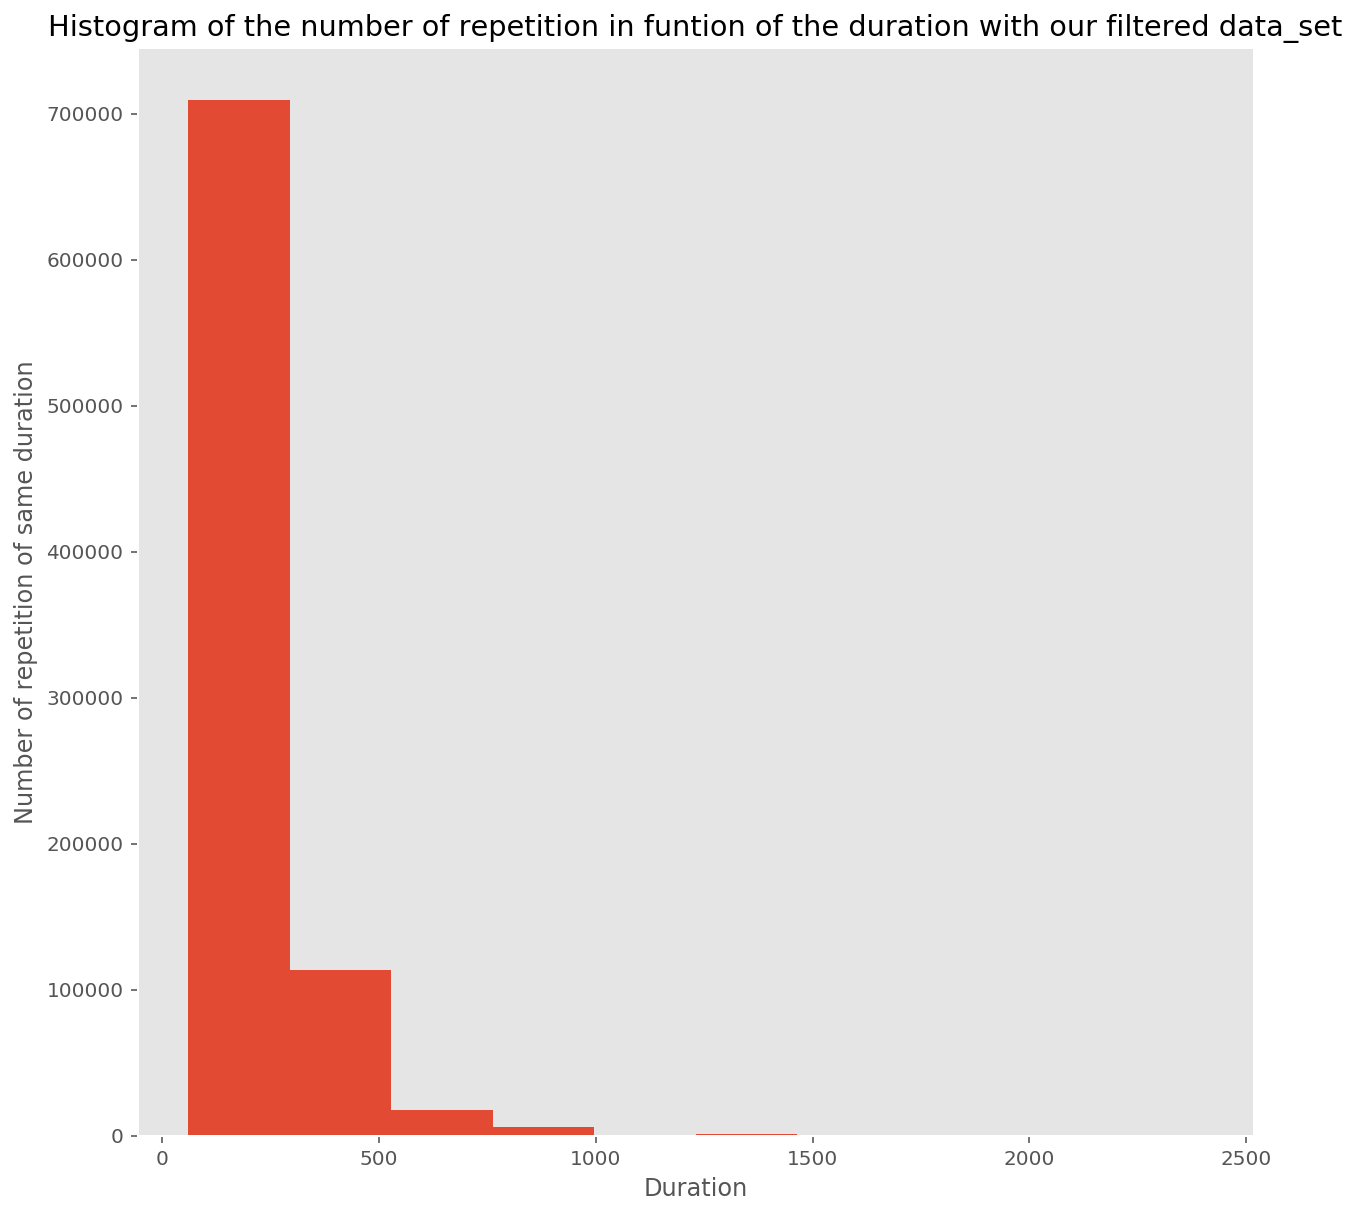

Size of the data_set :  847044
Statistics of T, Mean:269, Median:240, Max:2400


In [63]:
#############################################################################################################################
# Question 3 : Recompute the duration dictionary based on your filtered dataset and plot the new histogram of durations.
############################################################################################################################# 

########## Recompute the duration dictionary based on your filtered dataset ##########
sum_T_filtered, sum_P_filtered  = list(), list()
for label in list(usual_events.keys()):
    # We gather in list of all possible durations in our dataset
    for t in usual_events[label]['T']:
        sum_T_filtered.append(t)
    for p in usual_events[label]['P']:
        sum_P_filtered.append(p)
T_dictionary_filtered = (np.unique(sum_T_filtered)) # np.unique returns the sorted unique elements of an array 
P_dictionary_filtered = (np.unique(sum_P_filtered)) # np.unique returns the sorted unique elements of an array 


########## Recompute the histogram of durations dictionary based on your filtered dataset ##########      
fig = plt.figure(figsize=(10,10))
plt.hist(sum_T_filtered)
plt.title('Histogram of the number of repetition in funtion of the duration with our filtered data_set')
plt.xlabel('Duration')
plt.ylabel('Number of repetition of same duration')
plt.show()
print ('Size of the data_set : ', len(sum_T_filtered))
print('Statistics of T, Mean:{:.0f}, Median:{:.0f}, Max:{:.0f}'.format( np.mean(sum_T_filtered), np.median(sum_T_filtered), np.max(sum_T_filtered)))

### Comment the histogram of durations in your entire dataset: 
We can say that nearly all the data are between 0 and 1000. Also, as we can see from the dataset that mean and median are close to duration 250. And the maximum of possible T is around 2000.   

Thus removing of rare events works.


#### Transposition invariance

In [64]:
def transposeDataset(dataset):
    transposed_dataset = {}

    for label in tqdm.tqdm(list(dataset.keys())):
        transposed_dataset[label] = {}
        print (label)
        score = music21.converter.parse(datapath+label+".mid")
        key = score.analyze('key')
        if key.mode == "major":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('C'))
        elif key.mode == "minor":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('A'))
        i = i.semitones
        transposed_dataset[label]['P'] = [p+i for p in dataset[label]['P']]
        transposed_dataset[label]['T'] = dataset[label]['T']
        
    return transposed_dataset

#### Pitch normalization

In [65]:
#############################################################################################################################
# Question 1 : Use the provided function to create a new dataset where all melodies are transposed to C Major/A minor.
############################################################################################################################# 

import tqdm
transpose_dataset = transposeDataset(usual_events) 

  0%|                                                                                         | 0/4398 [00:00<?, ?it/s]

sessiontune10003
sessiontune10006


  0%|                                                                                 | 2/4398 [00:00<05:10, 14.15it/s]

sessiontune10019
sessiontune10023


  0%|                                                                                 | 4/4398 [00:00<05:38, 12.99it/s]

sessiontune10033


  0%|                                                                                 | 5/4398 [00:00<10:39,  6.87it/s]

sessiontune10037
sessiontune10050


  0%|▏                                                                                | 7/4398 [00:00<09:04,  8.06it/s]

sessiontune10060
sessiontune10063


  0%|▏                                                                                | 9/4398 [00:01<08:10,  8.94it/s]

sessiontune1007
sessiontune10072


  0%|▏                                                                               | 11/4398 [00:01<07:25,  9.85it/s]

sessiontune10088
sessiontune10104


  0%|▏                                                                               | 13/4398 [00:01<06:52, 10.63it/s]

sessiontune10116
sessiontune10135


  0%|▎                                                                               | 15/4398 [00:01<07:33,  9.65it/s]

sessiontune10159
sessiontune10176


  0%|▎                                                                               | 17/4398 [00:01<07:11, 10.16it/s]

sessiontune10197
sessiontune10198


  0%|▎                                                                               | 19/4398 [00:01<07:00, 10.41it/s]

sessiontune10208
sessiontune10218


  0%|▍                                                                               | 21/4398 [00:02<07:38,  9.54it/s]

sessiontune10226
sessiontune10242


  1%|▍                                                                               | 23/4398 [00:02<07:19,  9.95it/s]

sessiontune10248
sessiontune1025


  1%|▍                                                                               | 25/4398 [00:02<07:04, 10.31it/s]

sessiontune10252
sessiontune10259


  1%|▍                                                                               | 27/4398 [00:02<06:53, 10.57it/s]

sessiontune10267
sessiontune10272


  1%|▌                                                                               | 29/4398 [00:02<07:19,  9.95it/s]

sessiontune10273
sessiontune10304


  1%|▌                                                                               | 31/4398 [00:03<07:08, 10.19it/s]

sessiontune10308
sessiontune10327


  1%|▌                                                                               | 33/4398 [00:03<06:56, 10.47it/s]

sessiontune1033
sessiontune10340


  1%|▋                                                                               | 35/4398 [00:03<06:48, 10.67it/s]

sessiontune10348
sessiontune10353


  1%|▋                                                                               | 37/4398 [00:03<07:07, 10.20it/s]

sessiontune10360
sessiontune10361


  1%|▋                                                                               | 39/4398 [00:03<07:00, 10.36it/s]

sessiontune10362
sessiontune10368


  1%|▋                                                                               | 41/4398 [00:03<06:53, 10.53it/s]

sessiontune10371
sessiontune10384


  1%|▊                                                                               | 43/4398 [00:04<06:46, 10.70it/s]

sessiontune10402
sessiontune10418


  1%|▊                                                                               | 45/4398 [00:04<06:57, 10.43it/s]

sessiontune10476
sessiontune10488


  1%|▊                                                                               | 47/4398 [00:04<06:50, 10.59it/s]

sessiontune10491
sessiontune10498


  1%|▉                                                                               | 49/4398 [00:04<06:49, 10.62it/s]

sessiontune10534
sessiontune10537
sessiontune10562


  1%|▉                                                                               | 52/4398 [00:04<06:38, 10.91it/s]

sessiontune10563
sessiontune10567


  1%|▉                                                                               | 54/4398 [00:05<06:50, 10.59it/s]

sessiontune10580
sessiontune10582


  1%|█                                                                               | 56/4398 [00:05<06:43, 10.76it/s]

sessiontune10588
sessiontune10599


  1%|█                                                                               | 58/4398 [00:05<06:38, 10.88it/s]

sessiontune10609
sessiontune10615


  1%|█                                                                               | 60/4398 [00:05<06:35, 10.96it/s]

sessiontune10626
sessiontune10639


  1%|█▏                                                                              | 62/4398 [00:05<06:46, 10.67it/s]

sessiontune10654
sessiontune10661
sessiontune10675


  1%|█▏                                                                              | 65/4398 [00:05<06:36, 10.92it/s]

sessiontune10679
sessiontune1069


  2%|█▏                                                                              | 67/4398 [00:06<06:31, 11.05it/s]

sessiontune10695
sessiontune10696


  2%|█▎                                                                              | 69/4398 [00:06<06:45, 10.66it/s]

sessiontune10701
sessiontune10705


  2%|█▎                                                                              | 71/4398 [00:06<06:42, 10.74it/s]

sessiontune10720
sessiontune10723


  2%|█▎                                                                              | 73/4398 [00:06<06:37, 10.87it/s]

sessiontune10763
sessiontune10781


  2%|█▎                                                                              | 75/4398 [00:06<06:34, 10.96it/s]

sessiontune10786
sessiontune10795


  2%|█▍                                                                              | 77/4398 [00:07<06:41, 10.76it/s]

sessiontune10797
sessiontune10808


  2%|█▍                                                                              | 79/4398 [00:07<06:37, 10.86it/s]

sessiontune10826
sessiontune10827


  2%|█▍                                                                              | 81/4398 [00:07<06:32, 10.99it/s]

sessiontune10851
sessiontune10853


  2%|█▌                                                                              | 83/4398 [00:07<06:31, 11.03it/s]

sessiontune10876
sessiontune10879


  2%|█▌                                                                              | 85/4398 [00:07<06:37, 10.84it/s]

sessiontune10880
sessiontune10894


  2%|█▌                                                                              | 87/4398 [00:07<06:33, 10.95it/s]

sessiontune10905
sessiontune10918


  2%|█▌                                                                              | 89/4398 [00:08<06:30, 11.05it/s]

sessiontune10962
sessiontune10965


  2%|█▋                                                                              | 91/4398 [00:08<06:26, 11.15it/s]

sessiontune110
sessiontune11002
sessiontune11015


  2%|█▋                                                                              | 94/4398 [00:08<06:21, 11.29it/s]

sessiontune11016
sessiontune11030


  2%|█▋                                                                              | 96/4398 [00:08<06:27, 11.11it/s]

sessiontune11037
sessiontune11048


  2%|█▊                                                                              | 98/4398 [00:08<06:24, 11.18it/s]

sessiontune11055
sessiontune11057


  2%|█▊                                                                             | 100/4398 [00:08<06:23, 11.20it/s]

sessiontune11064
sessiontune11079


  2%|█▊                                                                             | 102/4398 [00:09<06:28, 11.05it/s]

sessiontune11096
sessiontune11112
sessiontune11154


  2%|█▉                                                                             | 105/4398 [00:09<06:25, 11.14it/s]

sessiontune1116
sessiontune11166


  2%|█▉                                                                             | 107/4398 [00:09<06:22, 11.23it/s]

sessiontune11171
sessiontune11177
sessiontune11185


  3%|█▉                                                                             | 110/4398 [00:09<06:17, 11.37it/s]

sessiontune1119
sessiontune11201


  3%|██                                                                             | 112/4398 [00:09<06:21, 11.24it/s]

sessiontune11212
sessiontune11229


  3%|██                                                                             | 114/4398 [00:10<06:21, 11.24it/s]

sessiontune1123
sessiontune11234
sessiontune1124


  3%|██                                                                             | 117/4398 [00:10<06:16, 11.38it/s]

sessiontune11240
sessiontune11243


  3%|██▏                                                                            | 119/4398 [00:10<06:20, 11.24it/s]

sessiontune11250
sessiontune11264


  3%|██▏                                                                            | 121/4398 [00:10<06:18, 11.31it/s]

sessiontune11286
sessiontune11293
sessiontune11305


  3%|██▏                                                                            | 124/4398 [00:10<06:13, 11.44it/s]

sessiontune11316
sessiontune11322


  3%|██▎                                                                            | 126/4398 [00:10<06:11, 11.51it/s]

sessiontune11323
sessiontune11327


  3%|██▎                                                                            | 128/4398 [00:11<06:15, 11.37it/s]

sessiontune11337
sessiontune1134


  3%|██▎                                                                            | 130/4398 [00:11<06:13, 11.43it/s]

sessiontune11369
sessiontune11370
sessiontune11377


  3%|██▍                                                                            | 133/4398 [00:11<06:09, 11.54it/s]

sessiontune1139
sessiontune11391


  3%|██▍                                                                            | 135/4398 [00:11<06:13, 11.40it/s]

sessiontune11406
sessiontune11408


  3%|██▍                                                                            | 137/4398 [00:11<06:11, 11.46it/s]

sessiontune11410
sessiontune11461
sessiontune11474


  3%|██▌                                                                            | 140/4398 [00:12<06:07, 11.57it/s]

sessiontune11477
sessiontune11483
sessiontune11498


  3%|██▌                                                                            | 143/4398 [00:12<06:10, 11.49it/s]

sessiontune11500
sessiontune11506
sessiontune11519


  3%|██▌                                                                            | 146/4398 [00:12<06:06, 11.59it/s]

sessiontune11523
sessiontune11527


  3%|██▋                                                                            | 148/4398 [00:12<06:04, 11.65it/s]

sessiontune11530
sessiontune11532


  3%|██▋                                                                            | 150/4398 [00:12<06:03, 11.70it/s]

sessiontune11541
sessiontune11553


  3%|██▋                                                                            | 152/4398 [00:13<06:07, 11.56it/s]

sessiontune11578
sessiontune11591


  4%|██▊                                                                            | 154/4398 [00:13<06:06, 11.58it/s]

sessiontune11599
sessiontune11606


  4%|██▊                                                                            | 156/4398 [00:13<06:04, 11.63it/s]

sessiontune11616
sessiontune11628


  4%|██▊                                                                            | 158/4398 [00:13<06:07, 11.52it/s]

sessiontune11643
sessiontune11655


  4%|██▊                                                                            | 160/4398 [00:13<06:05, 11.58it/s]

sessiontune11659
sessiontune1166


  4%|██▉                                                                            | 162/4398 [00:13<06:05, 11.60it/s]

sessiontune11700
sessiontune11711


  4%|██▉                                                                            | 164/4398 [00:14<06:03, 11.66it/s]

sessiontune11713
sessiontune1173


  4%|██▉                                                                            | 166/4398 [00:14<06:05, 11.56it/s]

sessiontune1174
sessiontune11745


  4%|███                                                                            | 168/4398 [00:14<06:03, 11.62it/s]

sessiontune11757
sessiontune11764


  4%|███                                                                            | 170/4398 [00:14<06:02, 11.67it/s]

sessiontune11779
sessiontune11781


  4%|███                                                                            | 172/4398 [00:14<06:01, 11.70it/s]

sessiontune11793
sessiontune1180


  4%|███▏                                                                           | 174/4398 [00:14<06:03, 11.61it/s]

sessiontune1181
sessiontune11829
sessiontune11833


  4%|███▏                                                                           | 177/4398 [00:15<06:01, 11.69it/s]

sessiontune11834
sessiontune11847


  4%|███▏                                                                           | 179/4398 [00:15<05:59, 11.74it/s]

sessiontune11862
sessiontune11868


  4%|███▎                                                                           | 181/4398 [00:15<05:57, 11.79it/s]

sessiontune11869
sessiontune1188


  4%|███▎                                                                           | 183/4398 [00:15<06:00, 11.68it/s]

sessiontune11881
sessiontune11884


  4%|███▎                                                                           | 185/4398 [00:15<05:59, 11.73it/s]

sessiontune11896
sessiontune11902


  4%|███▎                                                                           | 187/4398 [00:15<05:57, 11.77it/s]

sessiontune1192
sessiontune11921


  4%|███▍                                                                           | 189/4398 [00:15<05:56, 11.82it/s]

sessiontune11930
sessiontune11934


  4%|███▍                                                                           | 191/4398 [00:16<05:59, 11.69it/s]

sessiontune11943
sessiontune1195


  4%|███▍                                                                           | 193/4398 [00:16<05:58, 11.74it/s]

sessiontune11950
sessiontune11954


  4%|███▌                                                                           | 195/4398 [00:16<05:56, 11.79it/s]

sessiontune11981
sessiontune11982


  4%|███▌                                                                           | 197/4398 [00:16<05:55, 11.82it/s]

sessiontune11987
sessiontune12020


  5%|███▌                                                                           | 199/4398 [00:16<05:53, 11.87it/s]

sessiontune12024
sessiontune12025


  5%|███▌                                                                           | 201/4398 [00:17<05:55, 11.79it/s]

sessiontune12030
sessiontune12040
sessiontune12041


  5%|███▋                                                                           | 204/4398 [00:17<05:53, 11.87it/s]

sessiontune12042
sessiontune12051


  5%|███▋                                                                           | 206/4398 [00:17<05:51, 11.92it/s]

sessiontune12054
sessiontune12064


  5%|███▋                                                                           | 208/4398 [00:17<05:50, 11.96it/s]

sessiontune12084
sessiontune12093


  5%|███▊                                                                           | 210/4398 [00:17<05:52, 11.88it/s]

sessiontune12104
sessiontune12117
sessiontune12141


  5%|███▊                                                                           | 213/4398 [00:17<05:50, 11.96it/s]

sessiontune12145
sessiontune1215
sessiontune12156


  5%|███▉                                                                           | 216/4398 [00:17<05:47, 12.03it/s]

sessiontune12178
sessiontune12189
sessiontune12214


  5%|███▉                                                                           | 219/4398 [00:18<05:49, 11.97it/s]

sessiontune12232
sessiontune12236


  5%|███▉                                                                           | 221/4398 [00:18<05:47, 12.01it/s]

sessiontune12266
sessiontune12277


  5%|████                                                                           | 223/4398 [00:18<05:46, 12.04it/s]

sessiontune12282
sessiontune12312


  5%|████                                                                           | 225/4398 [00:18<05:46, 12.04it/s]

sessiontune12316
sessiontune12321


  5%|████                                                                           | 227/4398 [00:18<05:48, 11.96it/s]

sessiontune12323
sessiontune12324


  5%|████                                                                           | 229/4398 [00:19<05:47, 11.99it/s]

sessiontune12337
sessiontune12362
sessiontune1237


  5%|████▏                                                                          | 232/4398 [00:19<05:45, 12.05it/s]

sessiontune12373
sessiontune12378


  5%|████▏                                                                          | 234/4398 [00:19<05:48, 11.96it/s]

sessiontune12423
sessiontune12426


  5%|████▏                                                                          | 236/4398 [00:19<05:47, 11.99it/s]

sessiontune12433
sessiontune12446


  5%|████▎                                                                          | 238/4398 [00:19<05:46, 12.00it/s]

sessiontune12466
sessiontune12468


  5%|████▎                                                                          | 240/4398 [00:19<05:45, 12.03it/s]

sessiontune12474
sessiontune12497


  6%|████▎                                                                          | 242/4398 [00:20<05:47, 11.96it/s]

sessiontune12509
sessiontune12510
sessiontune12514


  6%|████▍                                                                          | 245/4398 [00:20<05:45, 12.02it/s]

sessiontune12525
sessiontune1254


  6%|████▍                                                                          | 247/4398 [00:20<05:44, 12.06it/s]

sessiontune12543
sessiontune12546


  6%|████▍                                                                          | 249/4398 [00:20<05:43, 12.09it/s]

sessiontune12573
sessiontune12574


  6%|████▌                                                                          | 251/4398 [00:20<05:45, 12.01it/s]

sessiontune12577
sessiontune12580


  6%|████▌                                                                          | 253/4398 [00:21<05:44, 12.05it/s]

sessiontune12587
sessiontune12588


  6%|████▌                                                                          | 255/4398 [00:21<05:43, 12.06it/s]

sessiontune12607
sessiontune12608
sessiontune12610


  6%|████▋                                                                          | 258/4398 [00:21<05:41, 12.13it/s]

sessiontune12617
sessiontune1262


  6%|████▋                                                                          | 260/4398 [00:21<05:43, 12.06it/s]

sessiontune12623
sessiontune12634
sessiontune12636


  6%|████▋                                                                          | 263/4398 [00:21<05:41, 12.12it/s]

sessiontune12639
sessiontune12648


  6%|████▊                                                                          | 265/4398 [00:21<05:40, 12.14it/s]

sessiontune12649
sessiontune12667


  6%|████▊                                                                          | 267/4398 [00:21<05:39, 12.17it/s]

sessiontune12673
sessiontune12680


  6%|████▊                                                                          | 269/4398 [00:22<05:41, 12.10it/s]

sessiontune12687
sessiontune12689
sessiontune12704


  6%|████▉                                                                          | 272/4398 [00:22<05:39, 12.14it/s]

sessiontune12722
sessiontune12723


  6%|████▉                                                                          | 274/4398 [00:22<05:38, 12.17it/s]

sessiontune12743
sessiontune12758
sessiontune12772


  6%|████▉                                                                          | 277/4398 [00:22<05:37, 12.23it/s]

sessiontune12820
sessiontune12836


  6%|█████                                                                          | 279/4398 [00:22<05:38, 12.16it/s]

sessiontune1285
sessiontune12854


  6%|█████                                                                          | 281/4398 [00:23<05:37, 12.19it/s]

sessiontune12855
sessiontune1286


  6%|█████                                                                          | 283/4398 [00:23<05:36, 12.22it/s]

sessiontune12866
sessiontune1287
sessiontune12876


  7%|█████▏                                                                         | 286/4398 [00:23<05:38, 12.13it/s]

sessiontune12882
sessiontune12909


  7%|█████▏                                                                         | 288/4398 [00:23<05:38, 12.15it/s]

sessiontune12935
sessiontune12937
sessiontune12949


  7%|█████▏                                                                         | 291/4398 [00:23<05:36, 12.21it/s]

sessiontune12954
sessiontune1303


  7%|█████▎                                                                         | 293/4398 [00:24<05:38, 12.13it/s]

sessiontune13039
sessiontune13043


  7%|█████▎                                                                         | 295/4398 [00:24<05:37, 12.16it/s]

sessiontune13045
sessiontune13062


  7%|█████▎                                                                         | 297/4398 [00:24<05:36, 12.18it/s]

sessiontune13078
sessiontune13080


  7%|█████▎                                                                         | 299/4398 [00:24<05:35, 12.21it/s]

sessiontune13086
sessiontune13089


  7%|█████▍                                                                         | 301/4398 [00:24<05:37, 12.13it/s]

sessiontune13112
sessiontune13119


  7%|█████▍                                                                         | 303/4398 [00:24<05:36, 12.16it/s]

sessiontune13125
sessiontune13135


  7%|█████▍                                                                         | 305/4398 [00:25<05:35, 12.19it/s]

sessiontune13158
sessiontune13170
sessiontune13180


  7%|█████▌                                                                         | 308/4398 [00:25<05:34, 12.24it/s]

sessiontune13190
sessiontune13205


  7%|█████▌                                                                         | 310/4398 [00:25<05:35, 12.18it/s]

sessiontune13214
sessiontune13215
sessiontune13237


  7%|█████▌                                                                         | 313/4398 [00:25<05:34, 12.22it/s]

sessiontune1324
sessiontune13264


  7%|█████▋                                                                         | 315/4398 [00:25<05:33, 12.25it/s]

sessiontune13273
sessiontune13292


  7%|█████▋                                                                         | 317/4398 [00:25<05:32, 12.28it/s]

sessiontune13307
sessiontune13313


  7%|█████▋                                                                         | 319/4398 [00:26<05:33, 12.21it/s]

sessiontune1335
sessiontune1336


  7%|█████▊                                                                         | 321/4398 [00:26<05:33, 12.24it/s]

sessiontune13364
sessiontune13392
sessiontune13393


  7%|█████▊                                                                         | 324/4398 [00:26<05:31, 12.29it/s]

sessiontune13399
sessiontune13452


  7%|█████▊                                                                         | 326/4398 [00:26<05:30, 12.31it/s]

sessiontune13456
sessiontune13457


  7%|█████▉                                                                         | 328/4398 [00:26<05:32, 12.25it/s]

sessiontune13470
sessiontune13472


  8%|█████▉                                                                         | 330/4398 [00:26<05:31, 12.26it/s]

sessiontune13474
sessiontune13475


  8%|█████▉                                                                         | 332/4398 [00:27<05:31, 12.28it/s]

sessiontune13480
sessiontune13481
sessiontune13497


  8%|██████                                                                         | 335/4398 [00:27<05:29, 12.33it/s]

sessiontune13504
sessiontune13507


  8%|██████                                                                         | 337/4398 [00:27<05:31, 12.25it/s]

sessiontune13511
sessiontune13524


  8%|██████                                                                         | 339/4398 [00:27<05:30, 12.28it/s]

sessiontune13527
sessiontune13536
sessiontune13577


  8%|██████▏                                                                        | 342/4398 [00:27<05:29, 12.32it/s]

sessiontune13600
sessiontune13605
sessiontune13629


  8%|██████▏                                                                        | 345/4398 [00:28<05:29, 12.28it/s]

sessiontune13666
sessiontune13672
sessiontune13675


  8%|██████▎                                                                        | 348/4398 [00:28<05:28, 12.33it/s]

sessiontune13685
sessiontune1370


  8%|██████▎                                                                        | 350/4398 [00:28<05:27, 12.35it/s]

sessiontune13703
sessiontune13708


  8%|██████▎                                                                        | 352/4398 [00:28<05:27, 12.37it/s]

sessiontune13721
sessiontune13728


  8%|██████▎                                                                        | 354/4398 [00:28<05:28, 12.29it/s]

sessiontune1373
sessiontune1376


  8%|██████▍                                                                        | 356/4398 [00:28<05:28, 12.30it/s]

sessiontune13785
sessiontune13792


  8%|██████▍                                                                        | 358/4398 [00:29<05:28, 12.31it/s]

sessiontune13803
sessiontune13809


  8%|██████▍                                                                        | 360/4398 [00:29<05:29, 12.25it/s]

sessiontune13812
sessiontune13814


  8%|██████▌                                                                        | 362/4398 [00:29<05:29, 12.26it/s]

sessiontune13816
sessiontune13832


  8%|██████▌                                                                        | 364/4398 [00:29<05:28, 12.28it/s]

sessiontune13833
sessiontune13855


  8%|██████▌                                                                        | 366/4398 [00:29<05:27, 12.30it/s]

sessiontune13881
sessiontune13883


  8%|██████▌                                                                        | 368/4398 [00:30<05:29, 12.25it/s]

sessiontune13890
sessiontune13892
sessiontune13897


  8%|██████▋                                                                        | 371/4398 [00:30<05:28, 12.28it/s]

sessiontune13903
sessiontune13911


  8%|██████▋                                                                        | 373/4398 [00:30<05:28, 12.26it/s]

sessiontune13916
sessiontune13927
sessiontune13931


  9%|██████▊                                                                        | 376/4398 [00:30<05:29, 12.22it/s]

sessiontune13940
sessiontune13948


  9%|██████▊                                                                        | 378/4398 [00:30<05:28, 12.24it/s]

sessiontune13949
sessiontune13967


  9%|██████▊                                                                        | 380/4398 [00:31<05:28, 12.22it/s]

sessiontune14026
sessiontune14031
sessiontune1404


  9%|██████▉                                                                        | 383/4398 [00:31<05:29, 12.17it/s]

sessiontune14051
sessiontune14052
sessiontune14057


  9%|██████▉                                                                        | 386/4398 [00:31<05:29, 12.19it/s]

sessiontune14062
sessiontune14068


  9%|██████▉                                                                        | 388/4398 [00:31<05:28, 12.20it/s]

sessiontune14069
sessiontune14081


  9%|███████                                                                        | 390/4398 [00:31<05:28, 12.22it/s]

sessiontune14084
sessiontune14091


  9%|███████                                                                        | 392/4398 [00:32<05:29, 12.15it/s]

sessiontune14096
sessiontune14097


  9%|███████                                                                        | 394/4398 [00:32<05:28, 12.18it/s]

sessiontune14104
sessiontune14105
sessiontune14110


  9%|███████▏                                                                       | 397/4398 [00:32<05:27, 12.21it/s]

sessiontune14112
sessiontune14116


  9%|███████▏                                                                       | 399/4398 [00:32<05:27, 12.20it/s]

sessiontune1413
sessiontune14131


  9%|███████▏                                                                       | 401/4398 [00:33<05:28, 12.15it/s]

sessiontune14134
sessiontune1415
sessiontune14181


  9%|███████▎                                                                       | 404/4398 [00:33<05:27, 12.19it/s]

sessiontune14191
sessiontune14203


  9%|███████▎                                                                       | 406/4398 [00:33<05:26, 12.21it/s]

sessiontune14245
sessiontune14248


  9%|███████▎                                                                       | 408/4398 [00:33<05:28, 12.15it/s]

sessiontune14260
sessiontune14283
sessiontune14287


  9%|███████▍                                                                       | 411/4398 [00:33<05:27, 12.18it/s]

sessiontune14303
sessiontune14304
sessiontune14316


  9%|███████▍                                                                       | 414/4398 [00:33<05:26, 12.21it/s]

sessiontune1433
sessiontune14333


  9%|███████▍                                                                       | 416/4398 [00:34<05:25, 12.23it/s]

sessiontune14335
sessiontune14340


 10%|███████▌                                                                       | 418/4398 [00:34<05:26, 12.18it/s]

sessiontune14344
sessiontune14364


 10%|███████▌                                                                       | 420/4398 [00:34<05:26, 12.20it/s]

sessiontune14385
sessiontune14402


 10%|███████▌                                                                       | 422/4398 [00:34<05:26, 12.19it/s]

sessiontune14407
sessiontune14423


 10%|███████▌                                                                       | 424/4398 [00:34<05:27, 12.14it/s]

sessiontune14427
sessiontune14433


 10%|███████▋                                                                       | 426/4398 [00:35<05:26, 12.16it/s]

sessiontune14455
sessiontune14459
sessiontune14469


 10%|███████▋                                                                       | 429/4398 [00:35<05:25, 12.19it/s]

sessiontune14470
sessiontune14481


 10%|███████▋                                                                       | 431/4398 [00:35<05:26, 12.15it/s]

sessiontune14492
sessiontune14503


 10%|███████▊                                                                       | 433/4398 [00:35<05:25, 12.17it/s]

sessiontune14525
sessiontune14527
sessiontune14534


 10%|███████▊                                                                       | 436/4398 [00:35<05:24, 12.20it/s]

sessiontune14538
sessiontune14544


 10%|███████▊                                                                       | 438/4398 [00:35<05:24, 12.22it/s]

sessiontune14546
sessiontune14561


 10%|███████▉                                                                       | 440/4398 [00:36<05:25, 12.17it/s]

sessiontune14564
sessiontune14574


 10%|███████▉                                                                       | 442/4398 [00:36<05:24, 12.19it/s]

sessiontune14597
sessiontune14606


 10%|███████▉                                                                       | 444/4398 [00:36<05:23, 12.20it/s]

sessiontune14608
sessiontune14627


 10%|████████                                                                       | 446/4398 [00:36<05:23, 12.22it/s]

sessiontune14657
sessiontune14664


 10%|████████                                                                       | 448/4398 [00:36<05:24, 12.17it/s]

sessiontune14671
sessiontune14685


 10%|████████                                                                       | 450/4398 [00:36<05:24, 12.18it/s]

sessiontune14702
sessiontune1471


 10%|████████                                                                       | 452/4398 [00:37<05:23, 12.20it/s]

sessiontune14722
sessiontune14724


 10%|████████▏                                                                      | 454/4398 [00:37<05:24, 12.16it/s]

sessiontune14728
sessiontune14729


 10%|████████▏                                                                      | 456/4398 [00:37<05:23, 12.17it/s]

sessiontune14742
sessiontune14777
sessiontune14788


 10%|████████▏                                                                      | 459/4398 [00:37<05:22, 12.21it/s]

sessiontune14805
sessiontune14852


 10%|████████▎                                                                      | 461/4398 [00:37<05:22, 12.22it/s]

sessiontune14887
sessiontune14890


 11%|████████▎                                                                      | 463/4398 [00:38<05:22, 12.18it/s]

sessiontune14896
sessiontune14898


 11%|████████▎                                                                      | 465/4398 [00:38<05:22, 12.20it/s]

sessiontune14899
sessiontune14905


 11%|████████▍                                                                      | 467/4398 [00:38<05:21, 12.22it/s]

sessiontune14913
sessiontune14926


 11%|████████▍                                                                      | 469/4398 [00:38<05:21, 12.24it/s]

sessiontune14928
sessiontune1494


 11%|████████▍                                                                      | 471/4398 [00:38<05:22, 12.18it/s]

sessiontune14951
sessiontune14971


 11%|████████▍                                                                      | 473/4398 [00:38<05:21, 12.20it/s]

sessiontune14976
sessiontune14988


 11%|████████▌                                                                      | 475/4398 [00:38<05:21, 12.22it/s]

sessiontune15001
sessiontune15008


 11%|████████▌                                                                      | 477/4398 [00:38<05:20, 12.24it/s]

sessiontune15018
sessiontune15025


 11%|████████▌                                                                      | 479/4398 [00:39<05:21, 12.20it/s]

sessiontune15029
sessiontune15055


 11%|████████▋                                                                      | 481/4398 [00:39<05:20, 12.20it/s]

sessiontune15063
sessiontune15077


 11%|████████▋                                                                      | 483/4398 [00:39<05:20, 12.21it/s]

sessiontune15085
sessiontune15097


 11%|████████▋                                                                      | 485/4398 [00:39<05:21, 12.17it/s]

sessiontune15120
sessiontune15123


 11%|████████▋                                                                      | 487/4398 [00:39<05:21, 12.18it/s]

sessiontune1513
sessiontune15133


 11%|████████▊                                                                      | 489/4398 [00:40<05:20, 12.20it/s]

sessiontune15138
sessiontune15151


 11%|████████▊                                                                      | 491/4398 [00:40<05:19, 12.22it/s]

sessiontune15159
sessiontune15160
sessiontune15165


 11%|████████▊                                                                      | 494/4398 [00:40<05:20, 12.19it/s]

sessiontune15176
sessiontune1521


 11%|████████▉                                                                      | 496/4398 [00:40<05:19, 12.20it/s]

sessiontune15225
sessiontune15232


 11%|████████▉                                                                      | 498/4398 [00:40<05:19, 12.22it/s]

sessiontune15234
sessiontune15259
sessiontune15264


 11%|████████▉                                                                      | 501/4398 [00:40<05:18, 12.25it/s]

sessiontune15278
sessiontune15296


 11%|█████████                                                                      | 503/4398 [00:41<05:19, 12.21it/s]

sessiontune15305
sessiontune15327


 11%|█████████                                                                      | 505/4398 [00:41<05:18, 12.22it/s]

sessiontune15332
sessiontune15337


 12%|█████████                                                                      | 507/4398 [00:41<05:18, 12.24it/s]

sessiontune15343
sessiontune15345


 12%|█████████▏                                                                     | 509/4398 [00:41<05:19, 12.18it/s]

sessiontune15350
sessiontune15356
sessiontune15368


 12%|█████████▏                                                                     | 512/4398 [00:42<05:18, 12.19it/s]

sessiontune15371
sessiontune15384


 12%|█████████▏                                                                     | 514/4398 [00:42<05:18, 12.20it/s]

sessiontune15407
sessiontune15409


 12%|█████████▎                                                                     | 516/4398 [00:42<05:19, 12.16it/s]

sessiontune15432
sessiontune15440


 12%|█████████▎                                                                     | 518/4398 [00:42<05:18, 12.18it/s]

sessiontune15445
sessiontune15446
sessiontune15448


 12%|█████████▎                                                                     | 521/4398 [00:42<05:17, 12.21it/s]

sessiontune15463
sessiontune15466
sessiontune15473


 12%|█████████▍                                                                     | 524/4398 [00:42<05:16, 12.24it/s]

sessiontune15477
sessiontune15478


 12%|█████████▍                                                                     | 526/4398 [00:43<05:17, 12.20it/s]

sessiontune15485
sessiontune15493
sessiontune15504


 12%|█████████▌                                                                     | 529/4398 [00:43<05:16, 12.23it/s]

sessiontune15510
sessiontune15514


 12%|█████████▌                                                                     | 531/4398 [00:43<05:15, 12.25it/s]

sessiontune15532
sessiontune15534
sessiontune15536


 12%|█████████▌                                                                     | 534/4398 [00:43<05:14, 12.28it/s]

sessiontune15548
sessiontune15557


 12%|█████████▋                                                                     | 536/4398 [00:43<05:15, 12.24it/s]

sessiontune15559
sessiontune15561


 12%|█████████▋                                                                     | 538/4398 [00:43<05:14, 12.26it/s]

sessiontune15575
sessiontune15613


 12%|█████████▋                                                                     | 540/4398 [00:43<05:14, 12.27it/s]

sessiontune15636
sessiontune15644
sessiontune15648


 12%|█████████▊                                                                     | 543/4398 [00:44<05:13, 12.30it/s]

sessiontune15653
sessiontune15659


 12%|█████████▊                                                                     | 545/4398 [00:44<05:14, 12.26it/s]

sessiontune15661
sessiontune15694


 12%|█████████▊                                                                     | 547/4398 [00:44<05:13, 12.27it/s]

sessiontune157
sessiontune15709
sessiontune15716


 13%|█████████▉                                                                     | 550/4398 [00:44<05:12, 12.30it/s]

sessiontune1573
sessiontune15730


 13%|█████████▉                                                                     | 552/4398 [00:45<05:13, 12.26it/s]

sessiontune15734
sessiontune15741


 13%|█████████▉                                                                     | 554/4398 [00:45<05:13, 12.28it/s]

sessiontune15745
sessiontune15753
sessiontune15765


 13%|██████████                                                                     | 557/4398 [00:45<05:12, 12.31it/s]

sessiontune15780
sessiontune15788


 13%|██████████                                                                     | 559/4398 [00:45<05:11, 12.32it/s]

sessiontune15790
sessiontune15799
sessiontune15802


 13%|██████████                                                                     | 562/4398 [00:45<05:11, 12.30it/s]

sessiontune15813
sessiontune15831


 13%|██████████▏                                                                    | 564/4398 [00:45<05:11, 12.32it/s]

sessiontune15832
sessiontune1584


 13%|██████████▏                                                                    | 566/4398 [00:45<05:10, 12.33it/s]

sessiontune15896
sessiontune15915
sessiontune15923


 13%|██████████▏                                                                    | 569/4398 [00:46<05:09, 12.36it/s]

sessiontune15936
sessiontune15949


 13%|██████████▎                                                                    | 571/4398 [00:46<05:10, 12.33it/s]

sessiontune15960
sessiontune15966


 13%|██████████▎                                                                    | 573/4398 [00:46<05:09, 12.34it/s]

sessiontune15987
sessiontune15996


 13%|██████████▎                                                                    | 575/4398 [00:46<05:11, 12.26it/s]

sessiontune16
sessiontune16003
sessiontune16010


 13%|██████████▍                                                                    | 578/4398 [00:47<05:10, 12.29it/s]

sessiontune16017
sessiontune16022
sessiontune16029


 13%|██████████▍                                                                    | 581/4398 [00:47<05:09, 12.32it/s]

sessiontune16035
sessiontune16049


 13%|██████████▍                                                                    | 583/4398 [00:47<05:09, 12.33it/s]

sessiontune1605
sessiontune16051


 13%|██████████▌                                                                    | 585/4398 [00:47<05:10, 12.29it/s]

sessiontune16071
sessiontune16081


 13%|██████████▌                                                                    | 587/4398 [00:47<05:09, 12.30it/s]

sessiontune16084
sessiontune16085


 13%|██████████▌                                                                    | 589/4398 [00:47<05:09, 12.31it/s]

sessiontune16094
sessiontune1610


 13%|██████████▌                                                                    | 591/4398 [00:47<05:08, 12.33it/s]

sessiontune16101
sessiontune16105


 13%|██████████▋                                                                    | 593/4398 [00:48<05:09, 12.29it/s]

sessiontune16109
sessiontune16123


 14%|██████████▋                                                                    | 595/4398 [00:48<05:09, 12.30it/s]

sessiontune16124
sessiontune16126


 14%|██████████▋                                                                    | 597/4398 [00:48<05:08, 12.31it/s]

sessiontune16132
sessiontune1614
sessiontune16141


 14%|██████████▊                                                                    | 600/4398 [00:48<05:08, 12.33it/s]

sessiontune16152
sessiontune16153


 14%|██████████▊                                                                    | 602/4398 [00:48<05:08, 12.29it/s]

sessiontune1616
sessiontune16186


 14%|██████████▊                                                                    | 604/4398 [00:49<05:08, 12.31it/s]

sessiontune16187
sessiontune16188


 14%|██████████▉                                                                    | 606/4398 [00:49<05:07, 12.32it/s]

sessiontune1621
sessiontune16213
sessiontune1622


 14%|██████████▉                                                                    | 609/4398 [00:49<05:08, 12.30it/s]

sessiontune16232
sessiontune16235


 14%|██████████▉                                                                    | 611/4398 [00:49<05:07, 12.31it/s]

sessiontune16236
sessiontune16237


 14%|███████████                                                                    | 613/4398 [00:49<05:07, 12.33it/s]

sessiontune16242
sessiontune16251


 14%|███████████                                                                    | 615/4398 [00:49<05:06, 12.34it/s]

sessiontune16255
sessiontune16259
sessiontune16280


 14%|███████████                                                                    | 618/4398 [00:50<05:06, 12.32it/s]

sessiontune16283
sessiontune16285


 14%|███████████▏                                                                   | 620/4398 [00:50<05:06, 12.33it/s]

sessiontune16291
sessiontune16295


 14%|███████████▏                                                                   | 622/4398 [00:50<05:05, 12.35it/s]

sessiontune16303
sessiontune16316


 14%|███████████▏                                                                   | 624/4398 [00:50<05:05, 12.36it/s]

sessiontune16318
sessiontune16336
sessiontune16348


 14%|███████████▎                                                                   | 627/4398 [00:50<05:05, 12.34it/s]

sessiontune1635
sessiontune16352


 14%|███████████▎                                                                   | 629/4398 [00:50<05:05, 12.35it/s]

sessiontune16354
sessiontune16358


 14%|███████████▎                                                                   | 631/4398 [00:51<05:04, 12.37it/s]

sessiontune16365
sessiontune16370


 14%|███████████▎                                                                   | 633/4398 [00:51<05:04, 12.38it/s]

sessiontune16371
sessiontune16373


 14%|███████████▍                                                                   | 635/4398 [00:51<05:04, 12.35it/s]

sessiontune16382
sessiontune16385


 14%|███████████▍                                                                   | 637/4398 [00:51<05:04, 12.36it/s]

sessiontune1639
sessiontune16396


 15%|███████████▍                                                                   | 639/4398 [00:51<05:03, 12.37it/s]

sessiontune16400
sessiontune16408


 15%|███████████▌                                                                   | 641/4398 [00:51<05:03, 12.38it/s]

sessiontune16409
sessiontune16413


 15%|███████████▌                                                                   | 643/4398 [00:52<05:04, 12.35it/s]

sessiontune16422
sessiontune16445
sessiontune16447


 15%|███████████▌                                                                   | 646/4398 [00:52<05:03, 12.37it/s]

sessiontune16448
sessiontune16456


 15%|███████████▋                                                                   | 648/4398 [00:52<05:02, 12.38it/s]

sessiontune16468
sessiontune16492


 15%|███████████▋                                                                   | 650/4398 [00:52<05:02, 12.39it/s]

sessiontune16498
sessiontune16541


 15%|███████████▋                                                                   | 652/4398 [00:52<05:02, 12.36it/s]

sessiontune16542
sessiontune16556
sessiontune16569


 15%|███████████▊                                                                   | 655/4398 [00:52<05:02, 12.39it/s]

sessiontune16580
sessiontune16585


 15%|███████████▊                                                                   | 657/4398 [00:52<05:01, 12.40it/s]

sessiontune16587
sessiontune16589
sessiontune16594


 15%|███████████▊                                                                   | 660/4398 [00:53<05:02, 12.38it/s]

sessiontune16608
sessiontune16632


 15%|███████████▉                                                                   | 662/4398 [00:53<05:01, 12.38it/s]

sessiontune16653
sessiontune16654


 15%|███████████▉                                                                   | 664/4398 [00:53<05:01, 12.39it/s]

sessiontune16664
sessiontune16674


 15%|███████████▉                                                                   | 666/4398 [00:53<05:00, 12.41it/s]

sessiontune16677
sessiontune16689


 15%|███████████▉                                                                   | 668/4398 [00:53<05:01, 12.37it/s]

sessiontune16721
sessiontune16722


 15%|████████████                                                                   | 670/4398 [00:54<05:01, 12.38it/s]

sessiontune16728
sessiontune16729
sessiontune1675


 15%|████████████                                                                   | 673/4398 [00:54<05:00, 12.40it/s]

sessiontune16761
sessiontune16783


 15%|████████████                                                                   | 675/4398 [00:54<04:59, 12.42it/s]

sessiontune16796
sessiontune16818


 15%|████████████▏                                                                  | 677/4398 [00:54<05:00, 12.38it/s]

sessiontune16823
sessiontune16827


 15%|████████████▏                                                                  | 679/4398 [00:54<05:00, 12.38it/s]

sessiontune16834
sessiontune16837


 15%|████████████▏                                                                  | 681/4398 [00:54<04:59, 12.39it/s]

sessiontune16846
sessiontune16851
sessiontune16852


 16%|████████████▎                                                                  | 684/4398 [00:55<05:00, 12.37it/s]

sessiontune16855
sessiontune16866


 16%|████████████▎                                                                  | 686/4398 [00:55<04:59, 12.38it/s]

sessiontune16874
sessiontune16895


 16%|████████████▎                                                                  | 688/4398 [00:55<04:59, 12.40it/s]

sessiontune1690
sessiontune16913
sessiontune16919


 16%|████████████▍                                                                  | 691/4398 [00:55<04:58, 12.42it/s]

sessiontune16928
sessiontune16937


 16%|████████████▍                                                                  | 693/4398 [00:55<04:59, 12.39it/s]

sessiontune16942
sessiontune16953


 16%|████████████▍                                                                  | 695/4398 [00:56<04:58, 12.40it/s]

sessiontune16963
sessiontune16974


 16%|████████████▌                                                                  | 697/4398 [00:56<04:58, 12.41it/s]

sessiontune16986
sessiontune16992


 16%|████████████▌                                                                  | 699/4398 [00:56<04:57, 12.42it/s]

sessiontune16996
sessiontune17000


 16%|████████████▌                                                                  | 701/4398 [00:56<04:58, 12.38it/s]

sessiontune17011
sessiontune17035


 16%|████████████▋                                                                  | 703/4398 [00:56<04:58, 12.39it/s]

sessiontune1705
sessiontune17059


 16%|████████████▋                                                                  | 705/4398 [00:56<04:57, 12.40it/s]

sessiontune17060
sessiontune17065


 16%|████████████▋                                                                  | 707/4398 [00:57<04:58, 12.36it/s]

sessiontune17071
sessiontune17077
sessiontune17083


 16%|████████████▊                                                                  | 710/4398 [00:57<04:57, 12.38it/s]

sessiontune17087
sessiontune17102


 16%|████████████▊                                                                  | 712/4398 [00:57<04:57, 12.39it/s]

sessiontune17122
sessiontune17125
sessiontune17131


 16%|████████████▊                                                                  | 715/4398 [00:57<04:56, 12.42it/s]

sessiontune17135
sessiontune17147


 16%|████████████▉                                                                  | 717/4398 [00:57<04:57, 12.38it/s]

sessiontune17149
sessiontune17174


 16%|████████████▉                                                                  | 719/4398 [00:58<04:56, 12.40it/s]

sessiontune17175
sessiontune17177
sessiontune17178


 16%|████████████▉                                                                  | 722/4398 [00:58<04:56, 12.42it/s]

sessiontune17181
sessiontune17184


 16%|█████████████                                                                  | 724/4398 [00:58<04:56, 12.39it/s]

sessiontune1719
sessiontune17223
sessiontune17225


 17%|█████████████                                                                  | 727/4398 [00:58<04:55, 12.41it/s]

sessiontune17227
sessiontune17236


 17%|█████████████                                                                  | 729/4398 [00:58<04:55, 12.41it/s]

sessiontune17263
sessiontune17296


 17%|█████████████▏                                                                 | 731/4398 [00:58<04:55, 12.43it/s]

sessiontune17359
sessiontune17368


 17%|█████████████▏                                                                 | 733/4398 [00:59<04:55, 12.40it/s]

sessiontune17372
sessiontune17380


 17%|█████████████▏                                                                 | 735/4398 [00:59<04:55, 12.41it/s]

sessiontune17382
sessiontune17383


 17%|█████████████▏                                                                 | 737/4398 [00:59<04:54, 12.41it/s]

sessiontune17392
sessiontune17397
sessiontune1740


 17%|█████████████▎                                                                 | 740/4398 [00:59<04:54, 12.43it/s]

sessiontune17405
sessiontune1741


 17%|█████████████▎                                                                 | 742/4398 [00:59<04:54, 12.40it/s]

sessiontune17416
sessiontune17418


 17%|█████████████▎                                                                 | 744/4398 [00:59<04:54, 12.41it/s]

sessiontune17431
sessiontune17432


 17%|█████████████▍                                                                 | 746/4398 [01:00<04:53, 12.43it/s]

sessiontune17434
sessiontune17448


 17%|█████████████▍                                                                 | 748/4398 [01:00<04:53, 12.44it/s]

sessiontune17450
sessiontune17488


 17%|█████████████▍                                                                 | 750/4398 [01:00<04:53, 12.41it/s]

sessiontune17491
sessiontune17493


 17%|█████████████▌                                                                 | 752/4398 [01:00<04:53, 12.42it/s]

sessiontune17510
sessiontune17514
sessiontune17520


 17%|█████████████▌                                                                 | 755/4398 [01:00<04:52, 12.44it/s]

sessiontune17525
sessiontune17543
sessiontune1755


 17%|█████████████▌                                                                 | 758/4398 [01:00<04:52, 12.46it/s]

sessiontune17558
sessiontune17560


 17%|█████████████▋                                                                 | 760/4398 [01:01<04:52, 12.42it/s]

sessiontune17572
sessiontune17606


 17%|█████████████▋                                                                 | 762/4398 [01:01<04:52, 12.43it/s]

sessiontune1761
sessiontune1762


 17%|█████████████▋                                                                 | 764/4398 [01:01<04:52, 12.44it/s]

sessiontune17630
sessiontune17662


 17%|█████████████▊                                                                 | 766/4398 [01:01<04:52, 12.41it/s]

sessiontune17679
sessiontune17702
sessiontune17727


 17%|█████████████▊                                                                 | 769/4398 [01:01<04:52, 12.43it/s]

sessiontune17750
sessiontune17758


 18%|█████████████▊                                                                 | 771/4398 [01:02<04:51, 12.43it/s]

sessiontune17771
sessiontune17783


 18%|█████████████▉                                                                 | 773/4398 [01:02<04:51, 12.44it/s]

sessiontune17791
sessiontune1780


 18%|█████████████▉                                                                 | 775/4398 [01:02<04:51, 12.41it/s]

sessiontune17801
sessiontune17814


 18%|█████████████▉                                                                 | 777/4398 [01:02<04:51, 12.42it/s]

sessiontune17818
sessiontune17820


 18%|█████████████▉                                                                 | 779/4398 [01:02<04:51, 12.43it/s]

sessiontune17828
sessiontune17855


 18%|██████████████                                                                 | 781/4398 [01:02<04:51, 12.40it/s]

sessiontune17871
sessiontune17880


 18%|██████████████                                                                 | 783/4398 [01:03<04:51, 12.41it/s]

sessiontune17894
sessiontune17899


 18%|██████████████                                                                 | 785/4398 [01:03<04:50, 12.42it/s]

sessiontune17900
sessiontune17914


 18%|██████████████▏                                                                | 787/4398 [01:03<04:50, 12.43it/s]

sessiontune17929
sessiontune17960


 18%|██████████████▏                                                                | 789/4398 [01:03<04:51, 12.39it/s]

sessiontune17961
sessiontune17968


 18%|██████████████▏                                                                | 791/4398 [01:03<04:51, 12.39it/s]

sessiontune17971
sessiontune17994


 18%|██████████████▏                                                                | 793/4398 [01:03<04:50, 12.41it/s]

sessiontune18006
sessiontune18010


 18%|██████████████▎                                                                | 795/4398 [01:04<04:50, 12.41it/s]

sessiontune18014
sessiontune18018


 18%|██████████████▎                                                                | 797/4398 [01:04<04:50, 12.38it/s]

sessiontune18024
sessiontune18043


 18%|██████████████▎                                                                | 799/4398 [01:04<04:50, 12.39it/s]

sessiontune18051
sessiontune18058


 18%|██████████████▍                                                                | 801/4398 [01:04<04:50, 12.40it/s]

sessiontune18061
sessiontune18063


 18%|██████████████▍                                                                | 803/4398 [01:04<04:49, 12.41it/s]

sessiontune18070
sessiontune18088


 18%|██████████████▍                                                                | 805/4398 [01:05<04:50, 12.38it/s]

sessiontune18090
sessiontune18102


 18%|██████████████▍                                                                | 807/4398 [01:05<04:49, 12.38it/s]

sessiontune18104
sessiontune18125
sessiontune1813


 18%|██████████████▌                                                                | 810/4398 [01:05<04:50, 12.34it/s]

sessiontune18139
sessiontune1814
sessiontune18146


 18%|██████████████▌                                                                | 813/4398 [01:05<04:50, 12.36it/s]

sessiontune18147
sessiontune18148
sessiontune18162


 19%|██████████████▋                                                                | 816/4398 [01:05<04:49, 12.38it/s]

sessiontune18167
sessiontune18169
sessiontune1818


 19%|██████████████▋                                                                | 819/4398 [01:06<04:48, 12.39it/s]

sessiontune18180
sessiontune18214


 19%|██████████████▋                                                                | 821/4398 [01:06<04:49, 12.37it/s]

sessiontune18217
sessiontune18227


 19%|██████████████▊                                                                | 823/4398 [01:06<04:48, 12.37it/s]

sessiontune18253
sessiontune18271


 19%|██████████████▊                                                                | 825/4398 [01:06<04:48, 12.38it/s]

sessiontune18272
sessiontune18278
sessiontune18308


 19%|██████████████▊                                                                | 828/4398 [01:06<04:48, 12.36it/s]

sessiontune18313
sessiontune18316


 19%|██████████████▉                                                                | 830/4398 [01:07<04:48, 12.36it/s]

sessiontune18319
sessiontune18329


 19%|██████████████▉                                                                | 832/4398 [01:07<04:48, 12.37it/s]

sessiontune18334
sessiontune18340


 19%|██████████████▉                                                                | 834/4398 [01:07<04:47, 12.38it/s]

sessiontune18343
sessiontune18348


 19%|███████████████                                                                | 836/4398 [01:07<04:48, 12.35it/s]

sessiontune18373
sessiontune18375


 19%|███████████████                                                                | 838/4398 [01:07<04:48, 12.36it/s]

sessiontune18380
sessiontune18408


 19%|███████████████                                                                | 840/4398 [01:07<04:47, 12.37it/s]

sessiontune1842
sessiontune18426
sessiontune18433


 19%|███████████████▏                                                               | 843/4398 [01:08<04:47, 12.35it/s]

sessiontune18435
sessiontune18438
sessiontune18451


 19%|███████████████▏                                                               | 846/4398 [01:08<04:47, 12.37it/s]

sessiontune18461
sessiontune18462
sessiontune18463


 19%|███████████████▎                                                               | 849/4398 [01:08<04:46, 12.39it/s]

sessiontune18476
sessiontune18499
sessiontune1852


 19%|███████████████▎                                                               | 852/4398 [01:08<04:45, 12.40it/s]

sessiontune18539
sessiontune18542


 19%|███████████████▎                                                               | 854/4398 [01:08<04:46, 12.38it/s]

sessiontune18550
sessiontune18555


 19%|███████████████▍                                                               | 856/4398 [01:09<04:45, 12.39it/s]

sessiontune18558
sessiontune18580
sessiontune18583


 20%|███████████████▍                                                               | 859/4398 [01:09<04:45, 12.41it/s]

sessiontune18588
sessiontune18610
sessiontune18612


 20%|███████████████▍                                                               | 862/4398 [01:09<04:45, 12.39it/s]

sessiontune18642
sessiontune18654
sessiontune18655


 20%|███████████████▌                                                               | 865/4398 [01:09<04:44, 12.41it/s]

sessiontune18668
sessiontune18673
sessiontune18691


 20%|███████████████▌                                                               | 868/4398 [01:09<04:44, 12.42it/s]

sessiontune18693
sessiontune18705


 20%|███████████████▋                                                               | 870/4398 [01:09<04:43, 12.43it/s]

sessiontune18721
sessiontune18739


 20%|███████████████▋                                                               | 872/4398 [01:10<04:44, 12.41it/s]

sessiontune18742
sessiontune18761


 20%|███████████████▋                                                               | 874/4398 [01:10<04:43, 12.42it/s]

sessiontune1877
sessiontune18772


 20%|███████████████▋                                                               | 876/4398 [01:10<04:43, 12.42it/s]

sessiontune18775
sessiontune18776


 20%|███████████████▊                                                               | 878/4398 [01:10<04:44, 12.39it/s]

sessiontune18782
sessiontune18783


 20%|███████████████▊                                                               | 880/4398 [01:10<04:43, 12.40it/s]

sessiontune188
sessiontune1880


 20%|███████████████▊                                                               | 882/4398 [01:11<04:43, 12.41it/s]

sessiontune18807
sessiontune18808


 20%|███████████████▉                                                               | 884/4398 [01:11<04:42, 12.42it/s]

sessiontune18815
sessiontune18816


 20%|███████████████▉                                                               | 886/4398 [01:11<04:43, 12.39it/s]

sessiontune18817
sessiontune18826


 20%|███████████████▉                                                               | 888/4398 [01:11<04:43, 12.40it/s]

sessiontune1883
sessiontune18841
sessiontune18842


 20%|████████████████                                                               | 891/4398 [01:11<04:42, 12.42it/s]

sessiontune18856
sessiontune18863
sessiontune18868


 20%|████████████████                                                               | 894/4398 [01:11<04:41, 12.44it/s]

sessiontune18877
sessiontune18880


 20%|████████████████                                                               | 896/4398 [01:12<04:42, 12.41it/s]

sessiontune18893
sessiontune18900
sessiontune18909


 20%|████████████████▏                                                              | 899/4398 [01:12<04:41, 12.42it/s]

sessiontune18910
sessiontune18912
sessiontune18914


 21%|████████████████▏                                                              | 902/4398 [01:12<04:41, 12.44it/s]

sessiontune18929
sessiontune18930


 21%|████████████████▏                                                              | 904/4398 [01:12<04:41, 12.42it/s]

sessiontune18934
sessiontune1895


 21%|████████████████▎                                                              | 906/4398 [01:12<04:41, 12.42it/s]

sessiontune18957
sessiontune18960


 21%|████████████████▎                                                              | 908/4398 [01:13<04:40, 12.43it/s]

sessiontune18977
sessiontune18998


 21%|████████████████▎                                                              | 910/4398 [01:13<04:40, 12.44it/s]

sessiontune19
sessiontune19001


 21%|████████████████▍                                                              | 912/4398 [01:13<04:40, 12.42it/s]

sessiontune19002
sessiontune1901


 21%|████████████████▍                                                              | 914/4398 [01:13<04:40, 12.43it/s]

sessiontune19014
sessiontune19029
sessiontune19036


 21%|████████████████▍                                                              | 917/4398 [01:13<04:39, 12.44it/s]

sessiontune19041
sessiontune19043
sessiontune19045


 21%|████████████████▌                                                              | 920/4398 [01:14<04:39, 12.43it/s]

sessiontune19065
sessiontune19069


 21%|████████████████▌                                                              | 922/4398 [01:14<04:39, 12.43it/s]

sessiontune1907
sessiontune19071


 21%|████████████████▌                                                              | 924/4398 [01:14<04:39, 12.43it/s]

sessiontune19088
sessiontune19090


 21%|████████████████▋                                                              | 926/4398 [01:14<04:39, 12.43it/s]

sessiontune19095
sessiontune19108


 21%|████████████████▋                                                              | 928/4398 [01:14<04:39, 12.40it/s]

sessiontune19113
sessiontune19124
sessiontune19126


 21%|████████████████▋                                                              | 931/4398 [01:14<04:39, 12.41it/s]

sessiontune19129
sessiontune1915


 21%|████████████████▊                                                              | 933/4398 [01:15<04:39, 12.41it/s]

sessiontune19155
sessiontune19160


 21%|████████████████▊                                                              | 935/4398 [01:15<04:39, 12.38it/s]

sessiontune19163
sessiontune19166


 21%|████████████████▊                                                              | 937/4398 [01:15<04:39, 12.38it/s]

sessiontune19167
sessiontune1917


 21%|████████████████▊                                                              | 939/4398 [01:15<04:39, 12.38it/s]

sessiontune19170
sessiontune19172


 21%|████████████████▉                                                              | 941/4398 [01:15<04:39, 12.39it/s]

sessiontune19173
sessiontune19187


 21%|████████████████▉                                                              | 943/4398 [01:16<04:39, 12.35it/s]

sessiontune19189
sessiontune1919
sessiontune19191


 22%|████████████████▉                                                              | 946/4398 [01:16<04:39, 12.37it/s]

sessiontune19196
sessiontune19199
sessiontune19204


 22%|█████████████████                                                              | 949/4398 [01:16<04:38, 12.38it/s]

sessiontune19207
sessiontune19216


 22%|█████████████████                                                              | 951/4398 [01:16<04:38, 12.36it/s]

sessiontune19225
sessiontune19234
sessiontune19236


 22%|█████████████████▏                                                             | 954/4398 [01:17<04:38, 12.38it/s]

sessiontune19240
sessiontune19241


 22%|█████████████████▏                                                             | 956/4398 [01:17<04:37, 12.39it/s]

sessiontune19265
sessiontune19281


 22%|█████████████████▏                                                             | 958/4398 [01:17<04:37, 12.39it/s]

sessiontune19288
sessiontune19319


 22%|█████████████████▏                                                             | 960/4398 [01:17<04:38, 12.37it/s]

sessiontune19329
sessiontune19333


 22%|█████████████████▎                                                             | 962/4398 [01:17<04:37, 12.37it/s]

sessiontune19335
sessiontune19337


 22%|█████████████████▎                                                             | 964/4398 [01:17<04:37, 12.38it/s]

sessiontune19343
sessiontune19345


 22%|█████████████████▎                                                             | 966/4398 [01:18<04:37, 12.36it/s]

sessiontune19361
sessiontune19368
sessiontune19375


 22%|█████████████████▍                                                             | 969/4398 [01:18<04:37, 12.37it/s]

sessiontune1938
sessiontune19381
sessiontune19394


 22%|█████████████████▍                                                             | 972/4398 [01:18<04:36, 12.39it/s]

sessiontune19409
sessiontune19410


 22%|█████████████████▍                                                             | 974/4398 [01:18<04:36, 12.39it/s]

sessiontune19416
sessiontune19421


 22%|█████████████████▌                                                             | 976/4398 [01:19<04:37, 12.35it/s]

sessiontune19432
sessiontune19440


 22%|█████████████████▌                                                             | 978/4398 [01:19<04:36, 12.35it/s]

sessiontune19457
sessiontune19459


 22%|█████████████████▌                                                             | 980/4398 [01:19<04:36, 12.36it/s]

sessiontune1950
sessiontune19500


 22%|█████████████████▋                                                             | 982/4398 [01:19<04:36, 12.36it/s]

sessiontune19503
sessiontune19504


 22%|█████████████████▋                                                             | 984/4398 [01:19<04:36, 12.34it/s]

sessiontune19511
sessiontune19518


 22%|█████████████████▋                                                             | 986/4398 [01:19<04:36, 12.34it/s]

sessiontune1952
sessiontune19535


 22%|█████████████████▋                                                             | 988/4398 [01:19<04:36, 12.35it/s]

sessiontune1954
sessiontune19543


 23%|█████████████████▊                                                             | 990/4398 [01:20<04:35, 12.36it/s]

sessiontune19561
sessiontune19565


 23%|█████████████████▊                                                             | 992/4398 [01:20<04:36, 12.33it/s]

sessiontune19567
sessiontune19569
sessiontune19582


 23%|█████████████████▊                                                             | 995/4398 [01:20<04:35, 12.35it/s]

sessiontune19589
sessiontune19600


 23%|█████████████████▉                                                             | 997/4398 [01:20<04:35, 12.35it/s]

sessiontune19607
sessiontune19619


 23%|█████████████████▉                                                             | 999/4398 [01:20<04:35, 12.34it/s]

sessiontune19621
sessiontune1963


 23%|█████████████████▊                                                            | 1001/4398 [01:21<04:36, 12.30it/s]

sessiontune19649
sessiontune19667


 23%|█████████████████▊                                                            | 1003/4398 [01:21<04:35, 12.31it/s]

sessiontune19670
sessiontune19679
sessiontune19682


 23%|█████████████████▊                                                            | 1006/4398 [01:21<04:35, 12.32it/s]

sessiontune19700
sessiontune19732


 23%|█████████████████▉                                                            | 1008/4398 [01:22<04:35, 12.29it/s]

sessiontune19733
sessiontune19735


 23%|█████████████████▉                                                            | 1010/4398 [01:22<04:35, 12.29it/s]

sessiontune19738
sessiontune19741


 23%|█████████████████▉                                                            | 1012/4398 [01:22<04:35, 12.29it/s]

sessiontune19745
sessiontune19746


 23%|█████████████████▉                                                            | 1014/4398 [01:22<04:36, 12.26it/s]

sessiontune1975
sessiontune19751


 23%|██████████████████                                                            | 1016/4398 [01:22<04:35, 12.26it/s]

sessiontune19752
sessiontune19774


 23%|██████████████████                                                            | 1018/4398 [01:22<04:35, 12.27it/s]

sessiontune19779
sessiontune19783


 23%|██████████████████                                                            | 1020/4398 [01:23<04:35, 12.28it/s]

sessiontune19797
sessiontune19809


 23%|██████████████████▏                                                           | 1022/4398 [01:23<04:34, 12.28it/s]

sessiontune19814
sessiontune1982


 23%|██████████████████▏                                                           | 1024/4398 [01:23<04:35, 12.25it/s]

sessiontune19820
sessiontune19822


 23%|██████████████████▏                                                           | 1026/4398 [01:23<04:35, 12.25it/s]

sessiontune19825
sessiontune19827


 23%|██████████████████▏                                                           | 1028/4398 [01:23<04:35, 12.24it/s]

sessiontune19838
sessiontune19841


 23%|██████████████████▎                                                           | 1030/4398 [01:24<04:35, 12.24it/s]

sessiontune19861
sessiontune19865


 23%|██████████████████▎                                                           | 1032/4398 [01:24<04:35, 12.21it/s]

sessiontune19883


 23%|██████████████████▎                                                           | 1033/4398 [01:24<04:35, 12.20it/s]

sessiontune19884


 24%|██████████████████▎                                                           | 1034/4398 [01:24<04:35, 12.20it/s]

sessiontune19885
sessiontune19888


 24%|██████████████████▎                                                           | 1036/4398 [01:24<04:35, 12.21it/s]

sessiontune19899
sessiontune19903


 24%|██████████████████▍                                                           | 1038/4398 [01:24<04:35, 12.21it/s]

sessiontune19904
sessiontune19906


 24%|██████████████████▍                                                           | 1040/4398 [01:25<04:35, 12.19it/s]

sessiontune19911
sessiontune19912


 24%|██████████████████▍                                                           | 1042/4398 [01:25<04:35, 12.19it/s]

sessiontune19937
sessiontune19958


 24%|██████████████████▌                                                           | 1044/4398 [01:25<04:34, 12.20it/s]

sessiontune19961
sessiontune19965


 24%|██████████████████▌                                                           | 1046/4398 [01:25<04:34, 12.21it/s]

sessiontune19988
sessiontune1999


 24%|██████████████████▌                                                           | 1048/4398 [01:26<04:35, 12.18it/s]

sessiontune20007
sessiontune20021


 24%|██████████████████▌                                                           | 1050/4398 [01:26<04:34, 12.19it/s]

sessiontune20024
sessiontune20054


 24%|██████████████████▋                                                           | 1052/4398 [01:26<04:34, 12.19it/s]

sessiontune20056
sessiontune20068


 24%|██████████████████▋                                                           | 1054/4398 [01:26<04:34, 12.16it/s]

sessiontune20074
sessiontune20085


 24%|██████████████████▋                                                           | 1056/4398 [01:26<04:34, 12.17it/s]

sessiontune20092
sessiontune20098
sessiontune20103


 24%|██████████████████▊                                                           | 1059/4398 [01:26<04:34, 12.18it/s]

sessiontune20113
sessiontune20133


 24%|██████████████████▊                                                           | 1061/4398 [01:27<04:33, 12.19it/s]

sessiontune20144
sessiontune20145


 24%|██████████████████▊                                                           | 1063/4398 [01:27<04:34, 12.17it/s]

sessiontune20148
sessiontune20149


 24%|██████████████████▉                                                           | 1065/4398 [01:27<04:33, 12.18it/s]

sessiontune20151
sessiontune20156


 24%|██████████████████▉                                                           | 1067/4398 [01:27<04:33, 12.18it/s]

sessiontune20164
sessiontune20167


 24%|██████████████████▉                                                           | 1069/4398 [01:27<04:33, 12.18it/s]

sessiontune20188
sessiontune20191


 24%|██████████████████▉                                                           | 1071/4398 [01:28<04:33, 12.16it/s]

sessiontune20199
sessiontune20200


 24%|███████████████████                                                           | 1073/4398 [01:28<04:33, 12.16it/s]

sessiontune2021
sessiontune20247


 24%|███████████████████                                                           | 1075/4398 [01:28<04:33, 12.17it/s]

sessiontune20259
sessiontune20269


 24%|███████████████████                                                           | 1077/4398 [01:28<04:33, 12.15it/s]

sessiontune20279
sessiontune20298


 25%|███████████████████▏                                                          | 1079/4398 [01:28<04:32, 12.16it/s]

sessiontune20299
sessiontune2030


 25%|███████████████████▏                                                          | 1081/4398 [01:28<04:32, 12.17it/s]

sessiontune20307
sessiontune2032


 25%|███████████████████▏                                                          | 1083/4398 [01:28<04:32, 12.18it/s]

sessiontune20327
sessiontune20330


 25%|███████████████████▏                                                          | 1085/4398 [01:29<04:32, 12.18it/s]

sessiontune20337
sessiontune20341


 25%|███████████████████▎                                                          | 1087/4398 [01:29<04:32, 12.13it/s]

sessiontune20349
sessiontune20351


 25%|███████████████████▎                                                          | 1089/4398 [01:29<04:32, 12.13it/s]

sessiontune20354
sessiontune20372
sessiontune20376


 25%|███████████████████▎                                                          | 1092/4398 [01:29<04:32, 12.14it/s]

sessiontune20403
sessiontune20410


 25%|███████████████████▍                                                          | 1094/4398 [01:30<04:32, 12.12it/s]

sessiontune20413
sessiontune20414


 25%|███████████████████▍                                                          | 1096/4398 [01:30<04:32, 12.12it/s]

sessiontune20416
sessiontune2042


 25%|███████████████████▍                                                          | 1098/4398 [01:30<04:32, 12.12it/s]

sessiontune20427
sessiontune20433


 25%|███████████████████▌                                                          | 1100/4398 [01:30<04:31, 12.13it/s]

sessiontune20437
sessiontune2044


 25%|███████████████████▌                                                          | 1102/4398 [01:31<04:32, 12.10it/s]

sessiontune20462
sessiontune20477


 25%|███████████████████▌                                                          | 1104/4398 [01:31<04:32, 12.10it/s]

sessiontune2049
sessiontune20496


 25%|███████████████████▌                                                          | 1106/4398 [01:31<04:31, 12.11it/s]

sessiontune20498
sessiontune20517


 25%|███████████████████▋                                                          | 1108/4398 [01:31<04:31, 12.11it/s]

sessiontune20529
sessiontune20531


 25%|███████████████████▋                                                          | 1110/4398 [01:31<04:31, 12.10it/s]

sessiontune20540
sessiontune2057


 25%|███████████████████▋                                                          | 1112/4398 [01:32<04:32, 12.05it/s]

sessiontune20573
sessiontune20579


 25%|███████████████████▊                                                          | 1114/4398 [01:32<04:32, 12.06it/s]

sessiontune20593
sessiontune20594


 25%|███████████████████▊                                                          | 1116/4398 [01:32<04:32, 12.06it/s]

sessiontune20609
sessiontune20610


 25%|███████████████████▊                                                          | 1118/4398 [01:32<04:31, 12.07it/s]

sessiontune20615
sessiontune20629


 25%|███████████████████▊                                                          | 1120/4398 [01:33<04:32, 12.03it/s]

sessiontune20637
sessiontune20647


 26%|███████████████████▉                                                          | 1122/4398 [01:33<04:32, 12.02it/s]

sessiontune20649
sessiontune20653


 26%|███████████████████▉                                                          | 1124/4398 [01:33<04:32, 12.02it/s]

sessiontune20658
sessiontune20665


 26%|███████████████████▉                                                          | 1126/4398 [01:34<04:33, 11.97it/s]

sessiontune20679
sessiontune20683


 26%|████████████████████                                                          | 1128/4398 [01:34<04:33, 11.97it/s]

sessiontune20693
sessiontune20707


 26%|████████████████████                                                          | 1130/4398 [01:34<04:32, 11.97it/s]

sessiontune20709
sessiontune20711


 26%|████████████████████                                                          | 1132/4398 [01:34<04:32, 11.97it/s]

sessiontune20712
sessiontune20715


 26%|████████████████████                                                          | 1134/4398 [01:35<04:33, 11.94it/s]

sessiontune20730


 26%|████████████████████▏                                                         | 1135/4398 [01:35<04:33, 11.93it/s]

sessiontune20752
sessiontune20754


 26%|████████████████████▏                                                         | 1137/4398 [01:35<04:33, 11.94it/s]

sessiontune20794
sessiontune20797


 26%|████████████████████▏                                                         | 1139/4398 [01:35<04:32, 11.95it/s]

sessiontune2082
sessiontune2083


 26%|████████████████████▏                                                         | 1141/4398 [01:35<04:33, 11.92it/s]

sessiontune20849
sessiontune20879


 26%|████████████████████▎                                                         | 1143/4398 [01:35<04:33, 11.92it/s]

sessiontune20881
sessiontune20898


 26%|████████████████████▎                                                         | 1145/4398 [01:35<04:32, 11.93it/s]

sessiontune2090
sessiontune20907


 26%|████████████████████▎                                                         | 1147/4398 [01:36<04:32, 11.93it/s]

sessiontune20936
sessiontune20939


 26%|████████████████████▍                                                         | 1149/4398 [01:36<04:32, 11.91it/s]

sessiontune20955
sessiontune20969


 26%|████████████████████▍                                                         | 1151/4398 [01:36<04:32, 11.90it/s]

sessiontune20977
sessiontune20982


 26%|████████████████████▍                                                         | 1153/4398 [01:36<04:32, 11.90it/s]

sessiontune20985
sessiontune20999


 26%|████████████████████▍                                                         | 1155/4398 [01:37<04:32, 11.90it/s]

sessiontune21004
sessiontune21016


 26%|████████████████████▌                                                         | 1157/4398 [01:37<04:32, 11.88it/s]

sessiontune21026
sessiontune2103


 26%|████████████████████▌                                                         | 1159/4398 [01:37<04:32, 11.88it/s]

sessiontune21030
sessiontune21031


 26%|████████████████████▌                                                         | 1161/4398 [01:37<04:32, 11.89it/s]

sessiontune21033
sessiontune21057


 26%|████████████████████▋                                                         | 1163/4398 [01:37<04:31, 11.89it/s]

sessiontune21061
sessiontune21062


 26%|████████████████████▋                                                         | 1165/4398 [01:37<04:31, 11.90it/s]

sessiontune21070
sessiontune21073


 27%|████████████████████▋                                                         | 1167/4398 [01:38<04:32, 11.88it/s]

sessiontune21076
sessiontune21077
sessiontune21098


 27%|████████████████████▊                                                         | 1170/4398 [01:38<04:31, 11.89it/s]

sessiontune21108
sessiontune21110


 27%|████████████████████▊                                                         | 1172/4398 [01:38<04:31, 11.89it/s]

sessiontune21112
sessiontune21114


 27%|████████████████████▊                                                         | 1174/4398 [01:38<04:31, 11.87it/s]

sessiontune21122
sessiontune21133


 27%|████████████████████▊                                                         | 1176/4398 [01:39<04:31, 11.87it/s]

sessiontune21148
sessiontune21153


 27%|████████████████████▉                                                         | 1178/4398 [01:39<04:31, 11.87it/s]

sessiontune2117
sessiontune21178


 27%|████████████████████▉                                                         | 1180/4398 [01:39<04:31, 11.86it/s]

sessiontune21181
sessiontune21182


 27%|████████████████████▉                                                         | 1182/4398 [01:40<04:32, 11.81it/s]

sessiontune21189
sessiontune21191


 27%|████████████████████▉                                                         | 1184/4398 [01:40<04:32, 11.81it/s]

sessiontune21198
sessiontune21199


 27%|█████████████████████                                                         | 1186/4398 [01:40<04:31, 11.81it/s]

sessiontune212
sessiontune21218


 27%|█████████████████████                                                         | 1188/4398 [01:40<04:31, 11.81it/s]

sessiontune21226
sessiontune21230


 27%|█████████████████████                                                         | 1190/4398 [01:41<04:32, 11.78it/s]

sessiontune21231
sessiontune2124


 27%|█████████████████████▏                                                        | 1192/4398 [01:41<04:31, 11.79it/s]

sessiontune21244
sessiontune21250


 27%|█████████████████████▏                                                        | 1194/4398 [01:41<04:31, 11.79it/s]

sessiontune21257
sessiontune21262


 27%|█████████████████████▏                                                        | 1196/4398 [01:41<04:31, 11.80it/s]

sessiontune21273
sessiontune21275


 27%|█████████████████████▏                                                        | 1198/4398 [01:41<04:31, 11.78it/s]

sessiontune21294
sessiontune21297


 27%|█████████████████████▎                                                        | 1200/4398 [01:41<04:31, 11.79it/s]

sessiontune21305
sessiontune21308


 27%|█████████████████████▎                                                        | 1202/4398 [01:41<04:31, 11.79it/s]

sessiontune21313
sessiontune21316


 27%|█████████████████████▎                                                        | 1204/4398 [01:42<04:30, 11.80it/s]

sessiontune21317
sessiontune21328


 27%|█████████████████████▍                                                        | 1206/4398 [01:42<04:30, 11.81it/s]

sessiontune21334
sessiontune21336


 27%|█████████████████████▍                                                        | 1208/4398 [01:42<04:30, 11.79it/s]

sessiontune21342
sessiontune21352


 28%|█████████████████████▍                                                        | 1210/4398 [01:42<04:30, 11.80it/s]

sessiontune21362
sessiontune21367


 28%|█████████████████████▍                                                        | 1212/4398 [01:42<04:29, 11.81it/s]

sessiontune21390
sessiontune21393
sessiontune21408


 28%|█████████████████████▌                                                        | 1215/4398 [01:42<04:29, 11.82it/s]

sessiontune21413
sessiontune21415


 28%|█████████████████████▌                                                        | 1217/4398 [01:43<04:29, 11.81it/s]

sessiontune21421
sessiontune21428


 28%|█████████████████████▌                                                        | 1219/4398 [01:43<04:29, 11.81it/s]

sessiontune21436
sessiontune21450


 28%|█████████████████████▋                                                        | 1221/4398 [01:43<04:28, 11.82it/s]

sessiontune21464
sessiontune21473


 28%|█████████████████████▋                                                        | 1223/4398 [01:43<04:28, 11.83it/s]

sessiontune21476
sessiontune21477


 28%|█████████████████████▋                                                        | 1225/4398 [01:43<04:28, 11.81it/s]

sessiontune21489
sessiontune21495


 28%|█████████████████████▊                                                        | 1227/4398 [01:43<04:28, 11.82it/s]

sessiontune21508
sessiontune21511


 28%|█████████████████████▊                                                        | 1229/4398 [01:43<04:28, 11.82it/s]

sessiontune21532
sessiontune21537


 28%|█████████████████████▊                                                        | 1231/4398 [01:44<04:28, 11.82it/s]

sessiontune2154
sessiontune21547


 28%|█████████████████████▊                                                        | 1233/4398 [01:44<04:28, 11.80it/s]

sessiontune21552
sessiontune2156


 28%|█████████████████████▉                                                        | 1235/4398 [01:44<04:27, 11.81it/s]

sessiontune21571
sessiontune21575


 28%|█████████████████████▉                                                        | 1237/4398 [01:44<04:27, 11.81it/s]

sessiontune21577
sessiontune21597


 28%|█████████████████████▉                                                        | 1239/4398 [01:44<04:27, 11.82it/s]

sessiontune21599
sessiontune21601


 28%|██████████████████████                                                        | 1241/4398 [01:45<04:27, 11.81it/s]

sessiontune21625
sessiontune21664


 28%|██████████████████████                                                        | 1243/4398 [01:45<04:27, 11.81it/s]

sessiontune21678
sessiontune21686


 28%|██████████████████████                                                        | 1245/4398 [01:45<04:26, 11.82it/s]

sessiontune21692
sessiontune21698


 28%|██████████████████████                                                        | 1247/4398 [01:45<04:26, 11.83it/s]

sessiontune21705
sessiontune21724


 28%|██████████████████████▏                                                       | 1249/4398 [01:45<04:26, 11.81it/s]

sessiontune21727
sessiontune21740


 28%|██████████████████████▏                                                       | 1251/4398 [01:45<04:26, 11.82it/s]

sessiontune21742
sessiontune21748


 28%|██████████████████████▏                                                       | 1253/4398 [01:45<04:26, 11.82it/s]

sessiontune21752
sessiontune21757


 29%|██████████████████████▎                                                       | 1255/4398 [01:46<04:25, 11.83it/s]

sessiontune21758
sessiontune2178


 29%|██████████████████████▎                                                       | 1257/4398 [01:46<04:25, 11.81it/s]

sessiontune21786
sessiontune2179
sessiontune21793


 29%|██████████████████████▎                                                       | 1260/4398 [01:46<04:25, 11.82it/s]

sessiontune21794
sessiontune21804


 29%|██████████████████████▍                                                       | 1262/4398 [01:46<04:25, 11.83it/s]

sessiontune21811
sessiontune2182
sessiontune21821


 29%|██████████████████████▍                                                       | 1265/4398 [01:47<04:25, 11.82it/s]

sessiontune21823
sessiontune21826
sessiontune2184


 29%|██████████████████████▍                                                       | 1268/4398 [01:47<04:24, 11.83it/s]

sessiontune21857
sessiontune21858
sessiontune21876


 29%|██████████████████████▌                                                       | 1271/4398 [01:47<04:24, 11.84it/s]

sessiontune2188
sessiontune21897
sessiontune21918


 29%|██████████████████████▌                                                       | 1274/4398 [01:47<04:23, 11.84it/s]

sessiontune21940
sessiontune21944


 29%|██████████████████████▋                                                       | 1276/4398 [01:47<04:23, 11.85it/s]

sessiontune21945
sessiontune21951


 29%|██████████████████████▋                                                       | 1278/4398 [01:47<04:23, 11.85it/s]

sessiontune21961
sessiontune21979
sessiontune21984


 29%|██████████████████████▋                                                       | 1281/4398 [01:48<04:23, 11.85it/s]

sessiontune21999
sessiontune22009
sessiontune22013


 29%|██████████████████████▊                                                       | 1284/4398 [01:48<04:22, 11.86it/s]

sessiontune2203
sessiontune22031


 29%|██████████████████████▊                                                       | 1286/4398 [01:48<04:22, 11.86it/s]

sessiontune22035
sessiontune22037
sessiontune22039


 29%|██████████████████████▊                                                       | 1289/4398 [01:48<04:22, 11.85it/s]

sessiontune22052
sessiontune22055


 29%|██████████████████████▉                                                       | 1291/4398 [01:48<04:22, 11.85it/s]

sessiontune22058
sessiontune22079


 29%|██████████████████████▉                                                       | 1293/4398 [01:49<04:21, 11.86it/s]

sessiontune2209
sessiontune22097


 29%|██████████████████████▉                                                       | 1295/4398 [01:49<04:21, 11.86it/s]

sessiontune22109
sessiontune22125


 29%|███████████████████████                                                       | 1297/4398 [01:49<04:21, 11.84it/s]

sessiontune22126
sessiontune22142


 30%|███████████████████████                                                       | 1299/4398 [01:49<04:21, 11.84it/s]

sessiontune22144
sessiontune22150


 30%|███████████████████████                                                       | 1301/4398 [01:49<04:21, 11.84it/s]

sessiontune22156
sessiontune22162


 30%|███████████████████████                                                       | 1303/4398 [01:50<04:21, 11.82it/s]

sessiontune22166
sessiontune2217


 30%|███████████████████████▏                                                      | 1305/4398 [01:50<04:21, 11.82it/s]

sessiontune22171
sessiontune22175


 30%|███████████████████████▏                                                      | 1307/4398 [01:50<04:21, 11.81it/s]

sessiontune22177


 30%|███████████████████████▏                                                      | 1308/4398 [01:50<04:22, 11.79it/s]

sessiontune22179
sessiontune22184
sessiontune222


 30%|███████████████████████▎                                                      | 1311/4398 [01:51<04:21, 11.80it/s]

sessiontune22202
sessiontune22204
sessiontune22234


 30%|███████████████████████▎                                                      | 1314/4398 [01:51<04:21, 11.81it/s]

sessiontune22236
sessiontune22238


 30%|███████████████████████▎                                                      | 1316/4398 [01:51<04:20, 11.82it/s]

sessiontune22242
sessiontune22261


 30%|███████████████████████▍                                                      | 1318/4398 [01:51<04:20, 11.81it/s]

sessiontune22270
sessiontune22274


 30%|███████████████████████▍                                                      | 1320/4398 [01:51<04:20, 11.81it/s]

sessiontune22282
sessiontune22297


 30%|███████████████████████▍                                                      | 1322/4398 [01:51<04:20, 11.82it/s]

sessiontune22314
sessiontune22321


 30%|███████████████████████▍                                                      | 1324/4398 [01:51<04:19, 11.82it/s]

sessiontune22336
sessiontune22341


 30%|███████████████████████▌                                                      | 1326/4398 [01:52<04:20, 11.81it/s]

sessiontune22346
sessiontune22349
sessiontune22355


 30%|███████████████████████▌                                                      | 1329/4398 [01:52<04:19, 11.82it/s]

sessiontune22377
sessiontune22378
sessiontune22381


 30%|███████████████████████▌                                                      | 1332/4398 [01:52<04:19, 11.83it/s]

sessiontune22392
sessiontune22404


 30%|███████████████████████▋                                                      | 1334/4398 [01:52<04:19, 11.82it/s]

sessiontune22409
sessiontune22413


 30%|███████████████████████▋                                                      | 1336/4398 [01:53<04:19, 11.82it/s]

sessiontune22416
sessiontune22426


 30%|███████████████████████▋                                                      | 1338/4398 [01:53<04:18, 11.83it/s]

sessiontune22428
sessiontune22451


 30%|███████████████████████▊                                                      | 1340/4398 [01:53<04:18, 11.83it/s]

sessiontune22459
sessiontune22463


 31%|███████████████████████▊                                                      | 1342/4398 [01:53<04:18, 11.82it/s]

sessiontune22469
sessiontune2248


 31%|███████████████████████▊                                                      | 1344/4398 [01:53<04:18, 11.82it/s]

sessiontune22490
sessiontune22493


 31%|███████████████████████▊                                                      | 1346/4398 [01:53<04:18, 11.82it/s]

sessiontune22506
sessiontune22511


 31%|███████████████████████▉                                                      | 1348/4398 [01:54<04:18, 11.82it/s]

sessiontune22515
sessiontune22535


 31%|███████████████████████▉                                                      | 1350/4398 [01:54<04:17, 11.82it/s]

sessiontune22537
sessiontune2254


 31%|███████████████████████▉                                                      | 1352/4398 [01:54<04:18, 11.80it/s]

sessiontune22571
sessiontune22584
sessiontune22604


 31%|████████████████████████                                                      | 1355/4398 [01:54<04:17, 11.81it/s]

sessiontune22609
sessiontune22629


 31%|████████████████████████                                                      | 1357/4398 [01:54<04:17, 11.82it/s]

sessiontune22638
sessiontune22657


 31%|████████████████████████                                                      | 1359/4398 [01:54<04:17, 11.82it/s]

sessiontune22663
sessiontune22667


 31%|████████████████████████▏                                                     | 1361/4398 [01:55<04:17, 11.81it/s]

sessiontune22678
sessiontune22684


 31%|████████████████████████▏                                                     | 1363/4398 [01:55<04:16, 11.82it/s]

sessiontune22693
sessiontune227
sessiontune22700


 31%|████████████████████████▏                                                     | 1366/4398 [01:55<04:16, 11.83it/s]

sessiontune22718
sessiontune2272


 31%|████████████████████████▎                                                     | 1368/4398 [01:55<04:15, 11.84it/s]

sessiontune22722
sessiontune22738


 31%|████████████████████████▎                                                     | 1370/4398 [01:55<04:16, 11.82it/s]

sessiontune22775
sessiontune22784


 31%|████████████████████████▎                                                     | 1372/4398 [01:56<04:16, 11.82it/s]

sessiontune22795
sessiontune22801
sessiontune22812


 31%|████████████████████████▍                                                     | 1375/4398 [01:56<04:15, 11.83it/s]

sessiontune22835
sessiontune22838
sessiontune22842


 31%|████████████████████████▍                                                     | 1378/4398 [01:56<04:15, 11.81it/s]

sessiontune22844
sessiontune22849


 31%|████████████████████████▍                                                     | 1380/4398 [01:56<04:15, 11.82it/s]

sessiontune22862
sessiontune22866


 31%|████████████████████████▌                                                     | 1382/4398 [01:56<04:15, 11.82it/s]

sessiontune22875
sessiontune22884


 31%|████████████████████████▌                                                     | 1384/4398 [01:57<04:14, 11.82it/s]

sessiontune22897
sessiontune229


 32%|████████████████████████▌                                                     | 1386/4398 [01:57<04:15, 11.80it/s]

sessiontune22908
sessiontune22927


 32%|████████████████████████▌                                                     | 1388/4398 [01:57<04:15, 11.80it/s]

sessiontune22932
sessiontune22935


 32%|████████████████████████▋                                                     | 1390/4398 [01:57<04:14, 11.80it/s]

sessiontune22936
sessiontune22940


 32%|████████████████████████▋                                                     | 1392/4398 [01:57<04:14, 11.80it/s]

sessiontune22944
sessiontune2295


 32%|████████████████████████▋                                                     | 1394/4398 [01:58<04:15, 11.78it/s]

sessiontune22956
sessiontune22976
sessiontune22999


 32%|████████████████████████▊                                                     | 1397/4398 [01:58<04:14, 11.79it/s]

sessiontune23003
sessiontune23006


 32%|████████████████████████▊                                                     | 1399/4398 [01:58<04:14, 11.79it/s]

sessiontune23011
sessiontune23016


 32%|████████████████████████▊                                                     | 1401/4398 [01:58<04:14, 11.80it/s]

sessiontune23020
sessiontune23031


 32%|████████████████████████▉                                                     | 1403/4398 [01:59<04:14, 11.79it/s]

sessiontune23032
sessiontune23034


 32%|████████████████████████▉                                                     | 1405/4398 [01:59<04:13, 11.79it/s]

sessiontune23037
sessiontune2305
sessiontune23078


 32%|████████████████████████▉                                                     | 1408/4398 [01:59<04:13, 11.81it/s]

sessiontune23105
sessiontune2311
sessiontune23110


 32%|█████████████████████████                                                     | 1411/4398 [01:59<04:12, 11.82it/s]

sessiontune23142
sessiontune2315


 32%|█████████████████████████                                                     | 1413/4398 [01:59<04:12, 11.81it/s]

sessiontune23176
sessiontune23199
sessiontune232


 32%|█████████████████████████                                                     | 1416/4398 [01:59<04:12, 11.82it/s]

sessiontune23205
sessiontune23207


 32%|█████████████████████████▏                                                    | 1418/4398 [01:59<04:11, 11.83it/s]

sessiontune2322
sessiontune23224


 32%|█████████████████████████▏                                                    | 1420/4398 [02:00<04:12, 11.81it/s]

sessiontune23227
sessiontune23242


 32%|█████████████████████████▏                                                    | 1422/4398 [02:00<04:11, 11.82it/s]

sessiontune23243
sessiontune23244
sessiontune23247


 32%|█████████████████████████▎                                                    | 1425/4398 [02:00<04:11, 11.83it/s]

sessiontune23261
sessiontune23272
sessiontune23288


 32%|█████████████████████████▎                                                    | 1428/4398 [02:00<04:11, 11.82it/s]

sessiontune23295
sessiontune23307


 33%|█████████████████████████▎                                                    | 1430/4398 [02:00<04:11, 11.82it/s]

sessiontune23318
sessiontune23320


 33%|█████████████████████████▍                                                    | 1432/4398 [02:01<04:10, 11.83it/s]

sessiontune23329
sessiontune23342


 33%|█████████████████████████▍                                                    | 1434/4398 [02:01<04:10, 11.83it/s]

sessiontune23348
sessiontune23372


 33%|█████████████████████████▍                                                    | 1436/4398 [02:01<04:10, 11.81it/s]

sessiontune23379
sessiontune23381


 33%|█████████████████████████▌                                                    | 1438/4398 [02:01<04:10, 11.81it/s]

sessiontune23393
sessiontune23402


 33%|█████████████████████████▌                                                    | 1440/4398 [02:01<04:10, 11.82it/s]

sessiontune23411
sessiontune23420
sessiontune23421


 33%|█████████████████████████▌                                                    | 1443/4398 [02:02<04:09, 11.83it/s]

sessiontune23426
sessiontune23459


 33%|█████████████████████████▋                                                    | 1445/4398 [02:02<04:10, 11.79it/s]

sessiontune2346
sessiontune23492


 33%|█████████████████████████▋                                                    | 1447/4398 [02:02<04:10, 11.79it/s]

sessiontune23526
sessiontune23561


 33%|█████████████████████████▋                                                    | 1449/4398 [02:02<04:09, 11.80it/s]

sessiontune23562
sessiontune23579


 33%|█████████████████████████▋                                                    | 1451/4398 [02:02<04:09, 11.80it/s]

sessiontune23585
sessiontune23589


 33%|█████████████████████████▊                                                    | 1453/4398 [02:03<04:09, 11.80it/s]

sessiontune2359
sessiontune23620


 33%|█████████████████████████▊                                                    | 1455/4398 [02:03<04:09, 11.79it/s]

sessiontune23626
sessiontune23640


 33%|█████████████████████████▊                                                    | 1457/4398 [02:03<04:09, 11.80it/s]

sessiontune23643
sessiontune23646


 33%|█████████████████████████▉                                                    | 1459/4398 [02:03<04:09, 11.80it/s]

sessiontune23648
sessiontune23665


 33%|█████████████████████████▉                                                    | 1461/4398 [02:03<04:08, 11.81it/s]

sessiontune23666
sessiontune23673


 33%|█████████████████████████▉                                                    | 1463/4398 [02:04<04:08, 11.80it/s]

sessiontune23677
sessiontune23679
sessiontune23680


 33%|██████████████████████████                                                    | 1466/4398 [02:04<04:08, 11.81it/s]

sessiontune23706
sessiontune23709
sessiontune23713


 33%|██████████████████████████                                                    | 1469/4398 [02:04<04:07, 11.82it/s]

sessiontune23717
sessiontune23729
sessiontune23731


 33%|██████████████████████████                                                    | 1472/4398 [02:04<04:07, 11.81it/s]

sessiontune23735
sessiontune23761


 34%|██████████████████████████▏                                                   | 1474/4398 [02:04<04:07, 11.82it/s]

sessiontune23773
sessiontune23785


 34%|██████████████████████████▏                                                   | 1476/4398 [02:04<04:07, 11.82it/s]

sessiontune23789
sessiontune23793
sessiontune23797


 34%|██████████████████████████▏                                                   | 1479/4398 [02:05<04:07, 11.82it/s]

sessiontune23814
sessiontune2382
sessiontune23833


 34%|██████████████████████████▎                                                   | 1482/4398 [02:05<04:06, 11.83it/s]

sessiontune23837
sessiontune2384


 34%|██████████████████████████▎                                                   | 1484/4398 [02:05<04:06, 11.83it/s]

sessiontune2386
sessiontune23872
sessiontune23885


 34%|██████████████████████████▎                                                   | 1487/4398 [02:05<04:05, 11.84it/s]

sessiontune23889
sessiontune23913


 34%|██████████████████████████▍                                                   | 1489/4398 [02:05<04:05, 11.83it/s]

sessiontune23923
sessiontune23927


 34%|██████████████████████████▍                                                   | 1491/4398 [02:05<04:05, 11.84it/s]

sessiontune23931
sessiontune23940
sessiontune23962


 34%|██████████████████████████▍                                                   | 1494/4398 [02:06<04:05, 11.85it/s]

sessiontune23971
sessiontune23973


 34%|██████████████████████████▌                                                   | 1496/4398 [02:06<04:05, 11.84it/s]

sessiontune23977
sessiontune23986


 34%|██████████████████████████▌                                                   | 1498/4398 [02:06<04:04, 11.85it/s]

sessiontune24011
sessiontune24018


 34%|██████████████████████████▌                                                   | 1500/4398 [02:06<04:04, 11.85it/s]

sessiontune24032
sessiontune24043
sessiontune24046


 34%|██████████████████████████▋                                                   | 1503/4398 [02:06<04:04, 11.86it/s]

sessiontune24051
sessiontune2406


 34%|██████████████████████████▋                                                   | 1505/4398 [02:07<04:04, 11.84it/s]

sessiontune24082
sessiontune24119


 34%|██████████████████████████▋                                                   | 1507/4398 [02:07<04:04, 11.84it/s]

sessiontune24129
sessiontune24146


 34%|██████████████████████████▊                                                   | 1509/4398 [02:07<04:04, 11.84it/s]

sessiontune24176
sessiontune24179


 34%|██████████████████████████▊                                                   | 1511/4398 [02:07<04:03, 11.84it/s]

sessiontune24196
sessiontune24198


 34%|██████████████████████████▊                                                   | 1513/4398 [02:08<04:04, 11.80it/s]

sessiontune24200
sessiontune24206


 34%|██████████████████████████▊                                                   | 1515/4398 [02:08<04:04, 11.81it/s]

sessiontune24216
sessiontune2422


 34%|██████████████████████████▉                                                   | 1517/4398 [02:08<04:03, 11.81it/s]

sessiontune24226
sessiontune24245


 35%|██████████████████████████▉                                                   | 1519/4398 [02:08<04:03, 11.81it/s]

sessiontune24250
sessiontune24262


 35%|██████████████████████████▉                                                   | 1521/4398 [02:09<04:04, 11.79it/s]

sessiontune24285
sessiontune24287


 35%|███████████████████████████                                                   | 1523/4398 [02:09<04:03, 11.79it/s]

sessiontune24288
sessiontune24296


 35%|███████████████████████████                                                   | 1525/4398 [02:09<04:03, 11.80it/s]

sessiontune24332
sessiontune24333


 35%|███████████████████████████                                                   | 1527/4398 [02:09<04:03, 11.80it/s]

sessiontune24341
sessiontune24343


 35%|███████████████████████████                                                   | 1529/4398 [02:09<04:03, 11.78it/s]

sessiontune24350
sessiontune24363


 35%|███████████████████████████▏                                                  | 1531/4398 [02:09<04:03, 11.79it/s]

sessiontune2438
sessiontune24388


 35%|███████████████████████████▏                                                  | 1533/4398 [02:09<04:02, 11.79it/s]

sessiontune24398
sessiontune24435


 35%|███████████████████████████▏                                                  | 1535/4398 [02:10<04:02, 11.80it/s]

sessiontune24447
sessiontune2445


 35%|███████████████████████████▎                                                  | 1537/4398 [02:10<04:02, 11.78it/s]

sessiontune24453
sessiontune24459


 35%|███████████████████████████▎                                                  | 1539/4398 [02:10<04:02, 11.77it/s]

sessiontune24463
sessiontune2448


 35%|███████████████████████████▎                                                  | 1541/4398 [02:10<04:02, 11.78it/s]

sessiontune24491
sessiontune24503


 35%|███████████████████████████▎                                                  | 1543/4398 [02:10<04:02, 11.78it/s]

sessiontune2452
sessiontune2455


 35%|███████████████████████████▍                                                  | 1545/4398 [02:11<04:02, 11.76it/s]

sessiontune24554
sessiontune24570


 35%|███████████████████████████▍                                                  | 1547/4398 [02:11<04:02, 11.76it/s]

sessiontune24571
sessiontune24582


 35%|███████████████████████████▍                                                  | 1549/4398 [02:11<04:02, 11.77it/s]

sessiontune2459
sessiontune24607


 35%|███████████████████████████▌                                                  | 1551/4398 [02:11<04:01, 11.77it/s]

sessiontune24619
sessiontune24625


 35%|███████████████████████████▌                                                  | 1553/4398 [02:12<04:02, 11.75it/s]

sessiontune2463
sessiontune24630


 35%|███████████████████████████▌                                                  | 1555/4398 [02:12<04:01, 11.75it/s]

sessiontune24635
sessiontune24642
sessiontune24644


 35%|███████████████████████████▋                                                  | 1558/4398 [02:12<04:01, 11.76it/s]

sessiontune24683
sessiontune24698


 35%|███████████████████████████▋                                                  | 1560/4398 [02:12<04:01, 11.75it/s]

sessiontune2470
sessiontune24707
sessiontune24708


 36%|███████████████████████████▋                                                  | 1563/4398 [02:12<04:01, 11.76it/s]

sessiontune24709
sessiontune24710


 36%|███████████████████████████▊                                                  | 1565/4398 [02:13<04:00, 11.77it/s]

sessiontune24711
sessiontune24722


 36%|███████████████████████████▊                                                  | 1567/4398 [02:13<04:00, 11.77it/s]

sessiontune24725
sessiontune24733


 36%|███████████████████████████▊                                                  | 1569/4398 [02:13<04:00, 11.76it/s]

sessiontune24747
sessiontune2475
sessiontune24750


 36%|███████████████████████████▉                                                  | 1572/4398 [02:13<04:00, 11.77it/s]

sessiontune24757
sessiontune2478
sessiontune24784


 36%|███████████████████████████▉                                                  | 1575/4398 [02:13<03:59, 11.78it/s]

sessiontune24793
sessiontune24802


 36%|███████████████████████████▉                                                  | 1577/4398 [02:14<03:59, 11.77it/s]

sessiontune24821
sessiontune24831


 36%|████████████████████████████                                                  | 1579/4398 [02:14<03:59, 11.77it/s]

sessiontune24871
sessiontune24874


 36%|████████████████████████████                                                  | 1581/4398 [02:14<03:59, 11.78it/s]

sessiontune24877
sessiontune2489
sessiontune24897


 36%|████████████████████████████                                                  | 1584/4398 [02:14<03:59, 11.77it/s]

sessiontune24901
sessiontune24922


 36%|████████████████████████████▏                                                 | 1586/4398 [02:14<03:58, 11.77it/s]

sessiontune24926
sessiontune24948


 36%|████████████████████████████▏                                                 | 1588/4398 [02:14<03:58, 11.78it/s]

sessiontune24955
sessiontune24969


 36%|████████████████████████████▏                                                 | 1590/4398 [02:14<03:58, 11.78it/s]

sessiontune24975
sessiontune24977


 36%|████████████████████████████▏                                                 | 1592/4398 [02:15<03:58, 11.77it/s]

sessiontune24987
sessiontune24989


 36%|████████████████████████████▎                                                 | 1594/4398 [02:15<03:58, 11.77it/s]

sessiontune24995
sessiontune25


 36%|████████████████████████████▎                                                 | 1596/4398 [02:15<03:57, 11.78it/s]

sessiontune2500
sessiontune25001


 36%|████████████████████████████▎                                                 | 1598/4398 [02:15<03:57, 11.78it/s]

sessiontune25004
sessiontune25006


 36%|████████████████████████████▍                                                 | 1600/4398 [02:16<03:58, 11.76it/s]

sessiontune25017
sessiontune25022


 36%|████████████████████████████▍                                                 | 1602/4398 [02:16<03:57, 11.76it/s]

sessiontune25051
sessiontune25056


 36%|████████████████████████████▍                                                 | 1604/4398 [02:16<03:57, 11.75it/s]

sessiontune25060
sessiontune25062


 37%|████████████████████████████▍                                                 | 1606/4398 [02:16<03:57, 11.74it/s]

sessiontune25070


 37%|████████████████████████████▌                                                 | 1607/4398 [02:16<03:57, 11.73it/s]

sessiontune25073
sessiontune25083


 37%|████████████████████████████▌                                                 | 1609/4398 [02:17<03:57, 11.73it/s]

sessiontune25099


 37%|████████████████████████████▌                                                 | 1610/4398 [02:17<03:58, 11.67it/s]

sessiontune251
sessiontune25102


 37%|████████████████████████████▌                                                 | 1612/4398 [02:18<03:58, 11.67it/s]

sessiontune25107
sessiontune25115


 37%|████████████████████████████▌                                                 | 1614/4398 [02:18<03:58, 11.67it/s]

sessiontune25128


 37%|████████████████████████████▋                                                 | 1615/4398 [02:18<03:58, 11.66it/s]

sessiontune25148


 37%|████████████████████████████▋                                                 | 1616/4398 [02:18<03:58, 11.66it/s]

sessiontune2515


 37%|████████████████████████████▋                                                 | 1617/4398 [02:19<03:59, 11.61it/s]

sessiontune25159
sessiontune25167


 37%|████████████████████████████▋                                                 | 1619/4398 [02:19<03:59, 11.62it/s]

sessiontune25172
sessiontune25185


 37%|████████████████████████████▋                                                 | 1621/4398 [02:19<03:58, 11.62it/s]

sessiontune25192
sessiontune25195


 37%|████████████████████████████▊                                                 | 1623/4398 [02:19<03:58, 11.63it/s]

sessiontune25199
sessiontune2522
sessiontune25252


 37%|████████████████████████████▊                                                 | 1626/4398 [02:19<03:58, 11.62it/s]

sessiontune25256
sessiontune25265


 37%|████████████████████████████▊                                                 | 1628/4398 [02:20<03:58, 11.63it/s]

sessiontune25266
sessiontune25284


 37%|████████████████████████████▉                                                 | 1630/4398 [02:20<03:57, 11.63it/s]

sessiontune25293
sessiontune25302


 37%|████████████████████████████▉                                                 | 1632/4398 [02:20<03:57, 11.64it/s]

sessiontune25308
sessiontune25318
sessiontune25326


 37%|████████████████████████████▉                                                 | 1635/4398 [02:20<03:57, 11.65it/s]

sessiontune25332
sessiontune2534


 37%|█████████████████████████████                                                 | 1637/4398 [02:20<03:57, 11.64it/s]

sessiontune25348
sessiontune25365


 37%|█████████████████████████████                                                 | 1639/4398 [02:20<03:57, 11.64it/s]

sessiontune25366
sessiontune2537


 37%|█████████████████████████████                                                 | 1641/4398 [02:20<03:56, 11.65it/s]

sessiontune25378
sessiontune25383
sessiontune25390


 37%|█████████████████████████████▏                                                | 1644/4398 [02:21<03:56, 11.64it/s]

sessiontune25403
sessiontune25405
sessiontune25422


 37%|█████████████████████████████▏                                                | 1647/4398 [02:21<03:56, 11.65it/s]

sessiontune25429
sessiontune25435
sessiontune25445


 38%|█████████████████████████████▎                                                | 1650/4398 [02:21<03:55, 11.66it/s]

sessiontune25461
sessiontune25466


 38%|█████████████████████████████▎                                                | 1652/4398 [02:21<03:55, 11.66it/s]

sessiontune25490
sessiontune25492


 38%|█████████████████████████████▎                                                | 1654/4398 [02:21<03:55, 11.65it/s]

sessiontune25496
sessiontune2550


 38%|█████████████████████████████▎                                                | 1656/4398 [02:22<03:55, 11.66it/s]

sessiontune25537
sessiontune2554
sessiontune25540


 38%|█████████████████████████████▍                                                | 1659/4398 [02:22<03:54, 11.67it/s]

sessiontune25544
sessiontune25552


 38%|█████████████████████████████▍                                                | 1661/4398 [02:22<03:54, 11.67it/s]

sessiontune25559
sessiontune25560


 38%|█████████████████████████████▍                                                | 1663/4398 [02:22<03:54, 11.65it/s]

sessiontune25561
sessiontune25564


 38%|█████████████████████████████▌                                                | 1665/4398 [02:22<03:54, 11.66it/s]

sessiontune25583
sessiontune25593
sessiontune25599


 38%|█████████████████████████████▌                                                | 1668/4398 [02:22<03:54, 11.67it/s]

sessiontune25600
sessiontune25622


 38%|█████████████████████████████▌                                                | 1670/4398 [02:23<03:54, 11.66it/s]

sessiontune25655
sessiontune25658
sessiontune25663


 38%|█████████████████████████████▋                                                | 1673/4398 [02:23<03:53, 11.67it/s]

sessiontune25665
sessiontune25687


 38%|█████████████████████████████▋                                                | 1675/4398 [02:23<03:53, 11.67it/s]

sessiontune25699
sessiontune25701


 38%|█████████████████████████████▋                                                | 1677/4398 [02:23<03:53, 11.66it/s]

sessiontune25706
sessiontune25712


 38%|█████████████████████████████▊                                                | 1679/4398 [02:23<03:53, 11.66it/s]

sessiontune25721
sessiontune25740


 38%|█████████████████████████████▊                                                | 1681/4398 [02:24<03:52, 11.67it/s]

sessiontune25749
sessiontune25771


 38%|█████████████████████████████▊                                                | 1683/4398 [02:24<03:52, 11.67it/s]

sessiontune25778
sessiontune25793


 38%|█████████████████████████████▉                                                | 1685/4398 [02:24<03:52, 11.66it/s]

sessiontune25806
sessiontune25808


 38%|█████████████████████████████▉                                                | 1687/4398 [02:24<03:52, 11.67it/s]

sessiontune25818
sessiontune25820


 38%|█████████████████████████████▉                                                | 1689/4398 [02:24<03:52, 11.67it/s]

sessiontune25830
sessiontune25833
sessiontune2584


 38%|██████████████████████████████                                                | 1692/4398 [02:25<03:52, 11.66it/s]

sessiontune25849
sessiontune25852


 39%|██████████████████████████████                                                | 1694/4398 [02:25<03:51, 11.67it/s]

sessiontune25875
sessiontune25885


 39%|██████████████████████████████                                                | 1696/4398 [02:25<03:51, 11.67it/s]

sessiontune25893
sessiontune25913


 39%|██████████████████████████████                                                | 1698/4398 [02:25<03:51, 11.68it/s]

sessiontune25931
sessiontune25963


 39%|██████████████████████████████▏                                               | 1700/4398 [02:25<03:50, 11.68it/s]

sessiontune25968
sessiontune25984


 39%|██████████████████████████████▏                                               | 1702/4398 [02:25<03:51, 11.67it/s]

sessiontune26042
sessiontune26060


 39%|██████████████████████████████▏                                               | 1704/4398 [02:25<03:50, 11.67it/s]

sessiontune26066
sessiontune26074


 39%|██████████████████████████████▎                                               | 1706/4398 [02:26<03:50, 11.66it/s]

sessiontune2608
sessiontune26083


 39%|██████████████████████████████▎                                               | 1708/4398 [02:26<03:51, 11.63it/s]

sessiontune26090
sessiontune26093


 39%|██████████████████████████████▎                                               | 1710/4398 [02:27<03:51, 11.63it/s]

sessiontune26097
sessiontune2610
sessiontune26100


 39%|██████████████████████████████▍                                               | 1713/4398 [02:27<03:50, 11.64it/s]

sessiontune26115
sessiontune26126
sessiontune26131


 39%|██████████████████████████████▍                                               | 1716/4398 [02:27<03:50, 11.63it/s]

sessiontune26141
sessiontune26151


 39%|██████████████████████████████▍                                               | 1718/4398 [02:27<03:50, 11.64it/s]

sessiontune26152
sessiontune26153


 39%|██████████████████████████████▌                                               | 1720/4398 [02:27<03:50, 11.64it/s]

sessiontune26164
sessiontune2617
sessiontune26174


 39%|██████████████████████████████▌                                               | 1723/4398 [02:28<03:49, 11.63it/s]

sessiontune26195
sessiontune26197


 39%|██████████████████████████████▌                                               | 1725/4398 [02:28<03:49, 11.64it/s]

sessiontune26201
sessiontune26254
sessiontune26258


 39%|██████████████████████████████▋                                               | 1728/4398 [02:28<03:49, 11.65it/s]

sessiontune26270
sessiontune26281


 39%|██████████████████████████████▋                                               | 1730/4398 [02:28<03:48, 11.65it/s]

sessiontune26286
sessiontune26308


 39%|██████████████████████████████▋                                               | 1732/4398 [02:28<03:48, 11.64it/s]

sessiontune26336
sessiontune26349


 39%|██████████████████████████████▊                                               | 1734/4398 [02:28<03:48, 11.64it/s]

sessiontune26350
sessiontune26357


 39%|██████████████████████████████▊                                               | 1736/4398 [02:29<03:48, 11.65it/s]

sessiontune26361
sessiontune26363


 40%|██████████████████████████████▊                                               | 1738/4398 [02:29<03:48, 11.64it/s]

sessiontune26384
sessiontune26394
sessiontune26403


 40%|██████████████████████████████▉                                               | 1741/4398 [02:29<03:48, 11.65it/s]

sessiontune26417
sessiontune26424
sessiontune26435


 40%|██████████████████████████████▉                                               | 1744/4398 [02:29<03:47, 11.66it/s]

sessiontune26454
sessiontune26499


 40%|██████████████████████████████▉                                               | 1746/4398 [02:29<03:47, 11.65it/s]

sessiontune26506
sessiontune26519


 40%|███████████████████████████████                                               | 1748/4398 [02:30<03:47, 11.65it/s]

sessiontune26523
sessiontune26526
sessiontune26534


 40%|███████████████████████████████                                               | 1751/4398 [02:30<03:46, 11.66it/s]

sessiontune26541
sessiontune26560


 40%|███████████████████████████████                                               | 1753/4398 [02:30<03:46, 11.67it/s]

sessiontune26563
sessiontune26575


 40%|███████████████████████████████▏                                              | 1755/4398 [02:30<03:46, 11.66it/s]

sessiontune2658
sessiontune26591


 40%|███████████████████████████████▏                                              | 1757/4398 [02:30<03:46, 11.66it/s]

sessiontune26596
sessiontune26612
sessiontune26622


 40%|███████████████████████████████▏                                              | 1760/4398 [02:30<03:46, 11.67it/s]

sessiontune26639
sessiontune26643


 40%|███████████████████████████████▏                                              | 1762/4398 [02:31<03:46, 11.66it/s]

sessiontune26647
sessiontune26651
sessiontune26662


 40%|███████████████████████████████▎                                              | 1765/4398 [02:31<03:45, 11.67it/s]

sessiontune26669
sessiontune26674
sessiontune26675


 40%|███████████████████████████████▎                                              | 1768/4398 [02:31<03:45, 11.68it/s]

sessiontune26678
sessiontune26691


 40%|███████████████████████████████▍                                              | 1770/4398 [02:31<03:45, 11.67it/s]

sessiontune26697
sessiontune26702


 40%|███████████████████████████████▍                                              | 1772/4398 [02:31<03:44, 11.67it/s]

sessiontune26708
sessiontune26720


 40%|███████████████████████████████▍                                              | 1774/4398 [02:31<03:44, 11.68it/s]

sessiontune26721
sessiontune26751


 40%|███████████████████████████████▍                                              | 1776/4398 [02:32<03:44, 11.68it/s]

sessiontune26756
sessiontune26761


 40%|███████████████████████████████▌                                              | 1778/4398 [02:32<03:44, 11.67it/s]

sessiontune26800
sessiontune26801


 40%|███████████████████████████████▌                                              | 1780/4398 [02:32<03:44, 11.67it/s]

sessiontune26803
sessiontune2682


 41%|███████████████████████████████▌                                              | 1782/4398 [02:32<03:43, 11.68it/s]

sessiontune26851
sessiontune26855
sessiontune26859


 41%|███████████████████████████████▋                                              | 1785/4398 [02:32<03:43, 11.67it/s]

sessiontune2688
sessiontune26885
sessiontune26900


 41%|███████████████████████████████▋                                              | 1788/4398 [02:33<03:43, 11.68it/s]

sessiontune26911
sessiontune26916


 41%|███████████████████████████████▋                                              | 1790/4398 [02:33<03:43, 11.69it/s]

sessiontune26929
sessiontune26936


 41%|███████████████████████████████▊                                              | 1792/4398 [02:33<03:42, 11.69it/s]

sessiontune26941
sessiontune26978


 41%|███████████████████████████████▊                                              | 1794/4398 [02:33<03:42, 11.68it/s]

sessiontune26983
sessiontune26985
sessiontune26988


 41%|███████████████████████████████▊                                              | 1797/4398 [02:33<03:42, 11.69it/s]

sessiontune26999
sessiontune27008
sessiontune27013


 41%|███████████████████████████████▉                                              | 1800/4398 [02:33<03:42, 11.70it/s]

sessiontune27028
sessiontune27038


 41%|███████████████████████████████▉                                              | 1802/4398 [02:34<03:42, 11.69it/s]

sessiontune27045
sessiontune27049


 41%|███████████████████████████████▉                                              | 1804/4398 [02:34<03:41, 11.70it/s]

sessiontune27063
sessiontune27066


 41%|████████████████████████████████                                              | 1806/4398 [02:34<03:41, 11.70it/s]

sessiontune27085
sessiontune27101
sessiontune27138


 41%|████████████████████████████████                                              | 1809/4398 [02:34<03:41, 11.71it/s]

sessiontune27140
sessiontune27146


 41%|████████████████████████████████                                              | 1811/4398 [02:34<03:41, 11.70it/s]

sessiontune2716
sessiontune27166


 41%|████████████████████████████████▏                                             | 1813/4398 [02:34<03:40, 11.71it/s]

sessiontune27182
sessiontune27233
sessiontune27237


 41%|████████████████████████████████▏                                             | 1816/4398 [02:35<03:40, 11.72it/s]

sessiontune27238
sessiontune27248


 41%|████████████████████████████████▏                                             | 1818/4398 [02:35<03:40, 11.71it/s]

sessiontune2725
sessiontune27267


 41%|████████████████████████████████▎                                             | 1820/4398 [02:35<03:40, 11.71it/s]

sessiontune27268
sessiontune2728


 41%|████████████████████████████████▎                                             | 1822/4398 [02:35<03:39, 11.71it/s]

sessiontune27282
sessiontune27302


 41%|████████████████████████████████▎                                             | 1824/4398 [02:35<03:39, 11.72it/s]

sessiontune27305
sessiontune27314


 42%|████████████████████████████████▍                                             | 1826/4398 [02:35<03:39, 11.71it/s]

sessiontune27323
sessiontune27328


 42%|████████████████████████████████▍                                             | 1828/4398 [02:36<03:39, 11.71it/s]

sessiontune27337
sessiontune27338


 42%|████████████████████████████████▍                                             | 1830/4398 [02:36<03:39, 11.72it/s]

sessiontune27349
sessiontune27374
sessiontune27378


 42%|████████████████████████████████▌                                             | 1833/4398 [02:36<03:39, 11.71it/s]

sessiontune27395
sessiontune27427


 42%|████████████████████████████████▌                                             | 1835/4398 [02:36<03:38, 11.71it/s]

sessiontune27434
sessiontune27444
sessiontune27447


 42%|████████████████████████████████▌                                             | 1838/4398 [02:36<03:38, 11.72it/s]

sessiontune27452
sessiontune27465


 42%|████████████████████████████████▋                                             | 1840/4398 [02:36<03:38, 11.73it/s]

sessiontune27470
sessiontune27480


 42%|████████████████████████████████▋                                             | 1842/4398 [02:37<03:38, 11.72it/s]

sessiontune27484
sessiontune27489


 42%|████████████████████████████████▋                                             | 1844/4398 [02:37<03:37, 11.72it/s]

sessiontune2749
sessiontune27500


 42%|████████████████████████████████▋                                             | 1846/4398 [02:37<03:37, 11.73it/s]

sessiontune27509
sessiontune27510
sessiontune27513


 42%|████████████████████████████████▊                                             | 1849/4398 [02:37<03:37, 11.72it/s]

sessiontune27516
sessiontune27524


 42%|████████████████████████████████▊                                             | 1851/4398 [02:37<03:37, 11.73it/s]

sessiontune27525
sessiontune27540


 42%|████████████████████████████████▊                                             | 1853/4398 [02:37<03:36, 11.73it/s]

sessiontune27548
sessiontune27565


 42%|████████████████████████████████▉                                             | 1855/4398 [02:38<03:36, 11.74it/s]

sessiontune27572
sessiontune27579


 42%|████████████████████████████████▉                                             | 1857/4398 [02:38<03:36, 11.73it/s]

sessiontune27593
sessiontune27594
sessiontune276


 42%|████████████████████████████████▉                                             | 1860/4398 [02:38<03:36, 11.74it/s]

sessiontune27615
sessiontune2762


 42%|█████████████████████████████████                                             | 1862/4398 [02:38<03:35, 11.74it/s]

sessiontune27635
sessiontune27640


 42%|█████████████████████████████████                                             | 1864/4398 [02:38<03:35, 11.73it/s]

sessiontune27654
sessiontune27656
sessiontune27657


 42%|█████████████████████████████████                                             | 1867/4398 [02:39<03:35, 11.74it/s]

sessiontune27669
sessiontune27680
sessiontune27691


 43%|█████████████████████████████████▏                                            | 1870/4398 [02:39<03:35, 11.75it/s]

sessiontune27702
sessiontune27731


 43%|█████████████████████████████████▏                                            | 1872/4398 [02:39<03:35, 11.74it/s]

sessiontune27735
sessiontune2776
sessiontune27773


 43%|█████████████████████████████████▎                                            | 1875/4398 [02:39<03:34, 11.74it/s]

sessiontune27774
sessiontune27803
sessiontune27815


 43%|█████████████████████████████████▎                                            | 1878/4398 [02:39<03:34, 11.75it/s]

sessiontune27818
sessiontune27821


 43%|█████████████████████████████████▎                                            | 1880/4398 [02:39<03:34, 11.76it/s]

sessiontune27830
sessiontune27840


 43%|█████████████████████████████████▍                                            | 1882/4398 [02:40<03:34, 11.74it/s]

sessiontune2786
sessiontune27871


 43%|█████████████████████████████████▍                                            | 1884/4398 [02:40<03:34, 11.75it/s]

sessiontune2788
sessiontune27886


 43%|█████████████████████████████████▍                                            | 1886/4398 [02:40<03:33, 11.75it/s]

sessiontune27889
sessiontune2789


 43%|█████████████████████████████████▍                                            | 1888/4398 [02:40<03:33, 11.74it/s]

sessiontune27894
sessiontune27906


 43%|█████████████████████████████████▌                                            | 1890/4398 [02:40<03:33, 11.75it/s]

sessiontune27909
sessiontune2791


 43%|█████████████████████████████████▌                                            | 1892/4398 [02:40<03:33, 11.75it/s]

sessiontune27918
sessiontune27943


 43%|█████████████████████████████████▌                                            | 1894/4398 [02:41<03:32, 11.76it/s]

sessiontune27947
sessiontune27955


 43%|█████████████████████████████████▋                                            | 1896/4398 [02:41<03:32, 11.75it/s]

sessiontune27956
sessiontune27957
sessiontune27983


 43%|█████████████████████████████████▋                                            | 1899/4398 [02:41<03:32, 11.75it/s]

sessiontune27985
sessiontune27988


 43%|█████████████████████████████████▋                                            | 1901/4398 [02:41<03:32, 11.76it/s]

sessiontune27989
sessiontune27991


 43%|█████████████████████████████████▊                                            | 1903/4398 [02:41<03:32, 11.75it/s]

sessiontune27992
sessiontune28


 43%|█████████████████████████████████▊                                            | 1905/4398 [02:42<03:32, 11.75it/s]

sessiontune28000
sessiontune28006


 43%|█████████████████████████████████▊                                            | 1907/4398 [02:42<03:31, 11.76it/s]

sessiontune28019
sessiontune28027


 43%|█████████████████████████████████▊                                            | 1909/4398 [02:42<03:31, 11.76it/s]

sessiontune28029
sessiontune28051


 43%|█████████████████████████████████▉                                            | 1911/4398 [02:42<03:31, 11.75it/s]

sessiontune28053
sessiontune28064


 43%|█████████████████████████████████▉                                            | 1913/4398 [02:42<03:31, 11.76it/s]

sessiontune28072
sessiontune28082


 44%|█████████████████████████████████▉                                            | 1915/4398 [02:42<03:31, 11.76it/s]

sessiontune28093
sessiontune2810
sessiontune28106


 44%|██████████████████████████████████                                            | 1918/4398 [02:43<03:30, 11.76it/s]

sessiontune28124
sessiontune28127


 44%|██████████████████████████████████                                            | 1920/4398 [02:43<03:30, 11.75it/s]

sessiontune28128
sessiontune28131


 44%|██████████████████████████████████                                            | 1922/4398 [02:43<03:30, 11.75it/s]

sessiontune28132
sessiontune28133
sessiontune2814


 44%|██████████████████████████████████▏                                           | 1925/4398 [02:43<03:30, 11.76it/s]

sessiontune28146
sessiontune28149


 44%|██████████████████████████████████▏                                           | 1927/4398 [02:43<03:29, 11.77it/s]

sessiontune2815
sessiontune28154


 44%|██████████████████████████████████▏                                           | 1929/4398 [02:44<03:29, 11.76it/s]

sessiontune28173
sessiontune28214


 44%|██████████████████████████████████▏                                           | 1931/4398 [02:44<03:29, 11.76it/s]

sessiontune28215
sessiontune28235


 44%|██████████████████████████████████▎                                           | 1933/4398 [02:44<03:29, 11.76it/s]

sessiontune28240
sessiontune28254


 44%|██████████████████████████████████▎                                           | 1935/4398 [02:44<03:29, 11.75it/s]

sessiontune28283
sessiontune28284


 44%|██████████████████████████████████▎                                           | 1937/4398 [02:44<03:29, 11.75it/s]

sessiontune2829
sessiontune28290
sessiontune28314


 44%|██████████████████████████████████▍                                           | 1940/4398 [02:44<03:29, 11.76it/s]

sessiontune28320
sessiontune28346


 44%|██████████████████████████████████▍                                           | 1942/4398 [02:45<03:29, 11.75it/s]

sessiontune28351
sessiontune28352


 44%|██████████████████████████████████▍                                           | 1944/4398 [02:45<03:28, 11.75it/s]

sessiontune2839
sessiontune28402
sessiontune28423


 44%|██████████████████████████████████▌                                           | 1947/4398 [02:45<03:28, 11.76it/s]

sessiontune28424
sessiontune28436


 44%|██████████████████████████████████▌                                           | 1949/4398 [02:45<03:28, 11.76it/s]

sessiontune28459
sessiontune28467


 44%|██████████████████████████████████▌                                           | 1951/4398 [02:45<03:28, 11.76it/s]

sessiontune28483
sessiontune28492


 44%|██████████████████████████████████▋                                           | 1953/4398 [02:46<03:27, 11.76it/s]

sessiontune28514
sessiontune28515


 44%|██████████████████████████████████▋                                           | 1955/4398 [02:46<03:27, 11.76it/s]

sessiontune28517
sessiontune2852
sessiontune28536


 45%|██████████████████████████████████▋                                           | 1958/4398 [02:46<03:27, 11.77it/s]

sessiontune28545
sessiontune28554


 45%|██████████████████████████████████▊                                           | 1960/4398 [02:46<03:27, 11.75it/s]

sessiontune28557
sessiontune2857


 45%|██████████████████████████████████▊                                           | 1962/4398 [02:46<03:27, 11.76it/s]

sessiontune2859
sessiontune28594


 45%|██████████████████████████████████▊                                           | 1964/4398 [02:47<03:26, 11.76it/s]

sessiontune28596
sessiontune28603


 45%|██████████████████████████████████▊                                           | 1966/4398 [02:47<03:26, 11.76it/s]

sessiontune28611
sessiontune28613


 45%|██████████████████████████████████▉                                           | 1968/4398 [02:47<03:26, 11.74it/s]

sessiontune28616
sessiontune28618
sessiontune2862


 45%|██████████████████████████████████▉                                           | 1971/4398 [02:47<03:26, 11.75it/s]

sessiontune28638
sessiontune28650


 45%|██████████████████████████████████▉                                           | 1973/4398 [02:47<03:26, 11.75it/s]

sessiontune28654
sessiontune2866


 45%|███████████████████████████████████                                           | 1975/4398 [02:48<03:26, 11.74it/s]

sessiontune28678
sessiontune28679


 45%|███████████████████████████████████                                           | 1977/4398 [02:48<03:26, 11.74it/s]

sessiontune28691
sessiontune28699


 45%|███████████████████████████████████                                           | 1979/4398 [02:48<03:25, 11.74it/s]

sessiontune2871
sessiontune28712


 45%|███████████████████████████████████▏                                          | 1981/4398 [02:48<03:25, 11.75it/s]

sessiontune28726
sessiontune28732


 45%|███████████████████████████████████▏                                          | 1983/4398 [02:48<03:25, 11.74it/s]

sessiontune28733
sessiontune28740


 45%|███████████████████████████████████▏                                          | 1985/4398 [02:49<03:25, 11.74it/s]

sessiontune28748
sessiontune28755


 45%|███████████████████████████████████▏                                          | 1987/4398 [02:49<03:25, 11.75it/s]

sessiontune28762
sessiontune28770


 45%|███████████████████████████████████▎                                          | 1989/4398 [02:49<03:24, 11.75it/s]

sessiontune28774
sessiontune28779


 45%|███████████████████████████████████▎                                          | 1991/4398 [02:49<03:24, 11.76it/s]

sessiontune28813
sessiontune28823


 45%|███████████████████████████████████▎                                          | 1993/4398 [02:49<03:24, 11.75it/s]

sessiontune28833
sessiontune2884


 45%|███████████████████████████████████▍                                          | 1995/4398 [02:49<03:24, 11.75it/s]

sessiontune28840
sessiontune2886


 45%|███████████████████████████████████▍                                          | 1997/4398 [02:49<03:24, 11.76it/s]

sessiontune28910
sessiontune28921


 45%|███████████████████████████████████▍                                          | 1999/4398 [02:50<03:24, 11.75it/s]

sessiontune28922
sessiontune28926
sessiontune28936


 46%|███████████████████████████████████▌                                          | 2002/4398 [02:50<03:23, 11.76it/s]

sessiontune28938
sessiontune2894
sessiontune28946


 46%|███████████████████████████████████▌                                          | 2005/4398 [02:50<03:23, 11.76it/s]

sessiontune28948
sessiontune28956
sessiontune28969


 46%|███████████████████████████████████▌                                          | 2008/4398 [02:50<03:23, 11.76it/s]

sessiontune28976
sessiontune28983


 46%|███████████████████████████████████▋                                          | 2010/4398 [02:50<03:22, 11.76it/s]

sessiontune28988
sessiontune29007
sessiontune29018


 46%|███████████████████████████████████▋                                          | 2013/4398 [02:51<03:22, 11.77it/s]

sessiontune29022
sessiontune29041


 46%|███████████████████████████████████▋                                          | 2015/4398 [02:51<03:22, 11.76it/s]

sessiontune29051
sessiontune29058


 46%|███████████████████████████████████▊                                          | 2017/4398 [02:51<03:22, 11.77it/s]

sessiontune2908
sessiontune29093
sessiontune29102


 46%|███████████████████████████████████▊                                          | 2020/4398 [02:51<03:21, 11.78it/s]

sessiontune29113
sessiontune29119


 46%|███████████████████████████████████▊                                          | 2022/4398 [02:51<03:21, 11.78it/s]

sessiontune29142
sessiontune29160


 46%|███████████████████████████████████▉                                          | 2024/4398 [02:51<03:21, 11.77it/s]

sessiontune29161
sessiontune29180


 46%|███████████████████████████████████▉                                          | 2026/4398 [02:52<03:21, 11.77it/s]

sessiontune2920
sessiontune29210


 46%|███████████████████████████████████▉                                          | 2028/4398 [02:52<03:21, 11.78it/s]

sessiontune29218
sessiontune29246


 46%|████████████████████████████████████                                          | 2030/4398 [02:52<03:21, 11.78it/s]

sessiontune29248
sessiontune29264


 46%|████████████████████████████████████                                          | 2032/4398 [02:52<03:20, 11.78it/s]

sessiontune29270
sessiontune29272


 46%|████████████████████████████████████                                          | 2034/4398 [02:53<03:21, 11.75it/s]

sessiontune29275
sessiontune29277


 46%|████████████████████████████████████                                          | 2036/4398 [02:53<03:20, 11.76it/s]

sessiontune29286
sessiontune29292


 46%|████████████████████████████████████▏                                         | 2038/4398 [02:53<03:20, 11.75it/s]

sessiontune29293
sessiontune2930


 46%|████████████████████████████████████▏                                         | 2040/4398 [02:53<03:20, 11.76it/s]

sessiontune29315
sessiontune29316


 46%|████████████████████████████████████▏                                         | 2042/4398 [02:53<03:20, 11.76it/s]

sessiontune2934
sessiontune29341


 46%|████████████████████████████████████▎                                         | 2044/4398 [02:53<03:20, 11.75it/s]

sessiontune29357
sessiontune29359


 47%|████████████████████████████████████▎                                         | 2046/4398 [02:54<03:20, 11.74it/s]

sessiontune29367
sessiontune29375


 47%|████████████████████████████████████▎                                         | 2048/4398 [02:54<03:20, 11.74it/s]

sessiontune29378
sessiontune29386
sessiontune29388


 47%|████████████████████████████████████▍                                         | 2051/4398 [02:54<03:19, 11.75it/s]

sessiontune29422
sessiontune29428


 47%|████████████████████████████████████▍                                         | 2053/4398 [02:54<03:19, 11.73it/s]

sessiontune29432
sessiontune29443


 47%|████████████████████████████████████▍                                         | 2055/4398 [02:55<03:19, 11.73it/s]

sessiontune29458
sessiontune29479
sessiontune29484


 47%|████████████████████████████████████▍                                         | 2058/4398 [02:55<03:19, 11.74it/s]

sessiontune29508
sessiontune29513


 47%|████████████████████████████████████▌                                         | 2060/4398 [02:55<03:19, 11.71it/s]

sessiontune29514
sessiontune29515


 47%|████████████████████████████████████▌                                         | 2062/4398 [02:56<03:19, 11.71it/s]

sessiontune2952
sessiontune2957


 47%|████████████████████████████████████▌                                         | 2064/4398 [02:56<03:19, 11.71it/s]

sessiontune29610
sessiontune29621


 47%|████████████████████████████████████▋                                         | 2066/4398 [02:56<03:19, 11.71it/s]

sessiontune29623
sessiontune29624


 47%|████████████████████████████████████▋                                         | 2068/4398 [02:57<03:19, 11.68it/s]

sessiontune29632
sessiontune29657


 47%|████████████████████████████████████▋                                         | 2070/4398 [02:57<03:19, 11.68it/s]

sessiontune29680
sessiontune29690
sessiontune29693


 47%|████████████████████████████████████▊                                         | 2073/4398 [02:57<03:19, 11.68it/s]

sessiontune29697
sessiontune29698


 47%|████████████████████████████████████▊                                         | 2075/4398 [02:57<03:18, 11.68it/s]

sessiontune29706
sessiontune29709


 47%|████████████████████████████████████▊                                         | 2077/4398 [02:58<03:19, 11.66it/s]

sessiontune29715
sessiontune29719


 47%|████████████████████████████████████▊                                         | 2079/4398 [02:58<03:18, 11.66it/s]

sessiontune2975
sessiontune29772


 47%|████████████████████████████████████▉                                         | 2081/4398 [02:58<03:18, 11.66it/s]

sessiontune2978
sessiontune29802


 47%|████████████████████████████████████▉                                         | 2083/4398 [02:58<03:18, 11.65it/s]

sessiontune29834
sessiontune29839


 47%|████████████████████████████████████▉                                         | 2085/4398 [02:58<03:18, 11.65it/s]

sessiontune29840
sessiontune29870


 47%|█████████████████████████████████████                                         | 2087/4398 [02:59<03:18, 11.66it/s]

sessiontune29875
sessiontune2988


 47%|█████████████████████████████████████                                         | 2089/4398 [02:59<03:18, 11.66it/s]

sessiontune29882
sessiontune29888


 48%|█████████████████████████████████████                                         | 2091/4398 [02:59<03:18, 11.64it/s]

sessiontune29893
sessiontune29903


 48%|█████████████████████████████████████                                         | 2093/4398 [02:59<03:17, 11.64it/s]

sessiontune29918
sessiontune29923


 48%|█████████████████████████████████████▏                                        | 2095/4398 [02:59<03:17, 11.65it/s]

sessiontune29926
sessiontune29938


 48%|█████████████████████████████████████▏                                        | 2097/4398 [02:59<03:17, 11.65it/s]

sessiontune29977
sessiontune29992


 48%|█████████████████████████████████████▏                                        | 2099/4398 [03:00<03:17, 11.64it/s]

sessiontune29996
sessiontune300


 48%|█████████████████████████████████████▎                                        | 2101/4398 [03:00<03:17, 11.64it/s]

sessiontune30006
sessiontune30012


 48%|█████████████████████████████████████▎                                        | 2103/4398 [03:00<03:17, 11.65it/s]

sessiontune30017
sessiontune30029
sessiontune30041


 48%|█████████████████████████████████████▎                                        | 2106/4398 [03:00<03:16, 11.64it/s]

sessiontune30055
sessiontune30056
sessiontune30064


 48%|█████████████████████████████████████▍                                        | 2109/4398 [03:01<03:16, 11.64it/s]

sessiontune30065
sessiontune30069


 48%|█████████████████████████████████████▍                                        | 2111/4398 [03:01<03:16, 11.64it/s]

sessiontune30080
sessiontune30086


 48%|█████████████████████████████████████▍                                        | 2113/4398 [03:01<03:16, 11.64it/s]

sessiontune30088
sessiontune30102


 48%|█████████████████████████████████████▌                                        | 2115/4398 [03:01<03:16, 11.63it/s]

sessiontune30107
sessiontune30115


 48%|█████████████████████████████████████▌                                        | 2117/4398 [03:01<03:16, 11.64it/s]

sessiontune30120
sessiontune30143


 48%|█████████████████████████████████████▌                                        | 2119/4398 [03:02<03:15, 11.63it/s]

sessiontune30159
sessiontune30167


 48%|█████████████████████████████████████▌                                        | 2121/4398 [03:02<03:15, 11.63it/s]

sessiontune3017
sessiontune30171


 48%|█████████████████████████████████████▋                                        | 2123/4398 [03:02<03:15, 11.61it/s]

sessiontune30175
sessiontune30178


 48%|█████████████████████████████████████▋                                        | 2125/4398 [03:02<03:15, 11.62it/s]

sessiontune30180
sessiontune30204


 48%|█████████████████████████████████████▋                                        | 2127/4398 [03:03<03:15, 11.62it/s]

sessiontune3021
sessiontune30223


 48%|█████████████████████████████████████▊                                        | 2129/4398 [03:03<03:15, 11.62it/s]

sessiontune30233
sessiontune30238


 48%|█████████████████████████████████████▊                                        | 2131/4398 [03:03<03:15, 11.60it/s]

sessiontune30258
sessiontune30264


 48%|█████████████████████████████████████▊                                        | 2133/4398 [03:03<03:15, 11.60it/s]

sessiontune30266
sessiontune30267


 49%|█████████████████████████████████████▊                                        | 2135/4398 [03:04<03:15, 11.60it/s]

sessiontune30301
sessiontune30307


 49%|█████████████████████████████████████▉                                        | 2137/4398 [03:04<03:15, 11.59it/s]

sessiontune30310
sessiontune30321


 49%|█████████████████████████████████████▉                                        | 2139/4398 [03:04<03:15, 11.58it/s]

sessiontune30323
sessiontune30326


 49%|█████████████████████████████████████▉                                        | 2141/4398 [03:04<03:14, 11.58it/s]

sessiontune30348
sessiontune30354


 49%|██████████████████████████████████████                                        | 2143/4398 [03:04<03:14, 11.59it/s]

sessiontune30367
sessiontune30368


 49%|██████████████████████████████████████                                        | 2145/4398 [03:05<03:14, 11.59it/s]

sessiontune30384
sessiontune30387
sessiontune30397


 49%|██████████████████████████████████████                                        | 2148/4398 [03:05<03:14, 11.58it/s]

sessiontune30405
sessiontune3041


 49%|██████████████████████████████████████▏                                       | 2150/4398 [03:05<03:13, 11.59it/s]

sessiontune30414
sessiontune30433


 49%|██████████████████████████████████████▏                                       | 2152/4398 [03:05<03:13, 11.59it/s]

sessiontune30452
sessiontune30467
sessiontune30479


 49%|██████████████████████████████████████▏                                       | 2155/4398 [03:05<03:13, 11.60it/s]

sessiontune3049
sessiontune30508


 49%|██████████████████████████████████████▎                                       | 2157/4398 [03:06<03:13, 11.59it/s]

sessiontune30510
sessiontune30573


 49%|██████████████████████████████████████▎                                       | 2159/4398 [03:06<03:13, 11.59it/s]

sessiontune30616
sessiontune30623


 49%|██████████████████████████████████████▎                                       | 2161/4398 [03:06<03:12, 11.60it/s]

sessiontune30625
sessiontune30627


 49%|██████████████████████████████████████▎                                       | 2163/4398 [03:06<03:12, 11.60it/s]

sessiontune30636
sessiontune30641


 49%|██████████████████████████████████████▍                                       | 2165/4398 [03:06<03:12, 11.60it/s]

sessiontune30659
sessiontune30677


 49%|██████████████████████████████████████▍                                       | 2167/4398 [03:06<03:12, 11.60it/s]

sessiontune30685
sessiontune30699


 49%|██████████████████████████████████████▍                                       | 2169/4398 [03:06<03:12, 11.60it/s]

sessiontune30703
sessiontune30731


 49%|██████████████████████████████████████▌                                       | 2171/4398 [03:07<03:11, 11.61it/s]

sessiontune30736
sessiontune30741


 49%|██████████████████████████████████████▌                                       | 2173/4398 [03:07<03:11, 11.60it/s]

sessiontune30747
sessiontune30760


 49%|██████████████████████████████████████▌                                       | 2175/4398 [03:07<03:11, 11.61it/s]

sessiontune30761
sessiontune30762
sessiontune30778


 50%|██████████████████████████████████████▋                                       | 2178/4398 [03:07<03:11, 11.61it/s]

sessiontune30788
sessiontune30809
sessiontune30810


 50%|██████████████████████████████████████▋                                       | 2181/4398 [03:07<03:10, 11.61it/s]

sessiontune30816
sessiontune30862
sessiontune30893


 50%|██████████████████████████████████████▋                                       | 2184/4398 [03:07<03:10, 11.62it/s]

sessiontune30898
sessiontune3092


 50%|██████████████████████████████████████▊                                       | 2186/4398 [03:08<03:10, 11.62it/s]

sessiontune30929
sessiontune30934


 50%|██████████████████████████████████████▊                                       | 2188/4398 [03:08<03:10, 11.63it/s]

sessiontune30953
sessiontune3096


 50%|██████████████████████████████████████▊                                       | 2190/4398 [03:08<03:10, 11.62it/s]

sessiontune30987
sessiontune30989


 50%|██████████████████████████████████████▉                                       | 2192/4398 [03:08<03:09, 11.62it/s]

sessiontune3100
sessiontune31000
sessiontune31009


 50%|██████████████████████████████████████▉                                       | 2195/4398 [03:09<03:09, 11.61it/s]

sessiontune31024
sessiontune31032


 50%|██████████████████████████████████████▉                                       | 2197/4398 [03:09<03:09, 11.62it/s]

sessiontune31037
sessiontune31046
sessiontune31062


 50%|███████████████████████████████████████                                       | 2200/4398 [03:09<03:09, 11.62it/s]

sessiontune31076
sessiontune3108


 50%|███████████████████████████████████████                                       | 2202/4398 [03:09<03:08, 11.63it/s]

sessiontune31087
sessiontune3109


 50%|███████████████████████████████████████                                       | 2204/4398 [03:09<03:08, 11.62it/s]

sessiontune31090
sessiontune31099


 50%|███████████████████████████████████████                                       | 2206/4398 [03:09<03:08, 11.62it/s]

sessiontune31104
sessiontune31109


 50%|███████████████████████████████████████▏                                      | 2208/4398 [03:09<03:08, 11.63it/s]

sessiontune31111
sessiontune31114


 50%|███████████████████████████████████████▏                                      | 2210/4398 [03:10<03:08, 11.62it/s]

sessiontune31115
sessiontune31119


 50%|███████████████████████████████████████▏                                      | 2212/4398 [03:10<03:08, 11.62it/s]

sessiontune31131
sessiontune31150


 50%|███████████████████████████████████████▎                                      | 2214/4398 [03:10<03:07, 11.63it/s]

sessiontune31161
sessiontune31189
sessiontune3119


 50%|███████████████████████████████████████▎                                      | 2217/4398 [03:10<03:07, 11.63it/s]

sessiontune31197
sessiontune31205


 50%|███████████████████████████████████████▎                                      | 2219/4398 [03:10<03:07, 11.63it/s]

sessiontune31227
sessiontune31254


 51%|███████████████████████████████████████▍                                      | 2221/4398 [03:10<03:07, 11.63it/s]

sessiontune31258
sessiontune31259
sessiontune31266


 51%|███████████████████████████████████████▍                                      | 2224/4398 [03:11<03:06, 11.64it/s]

sessiontune31279
sessiontune31289


 51%|███████████████████████████████████████▍                                      | 2226/4398 [03:11<03:06, 11.63it/s]

sessiontune3129
sessiontune31302


 51%|███████████████████████████████████████▌                                      | 2228/4398 [03:11<03:06, 11.63it/s]

sessiontune31308
sessiontune3131


 51%|███████████████████████████████████████▌                                      | 2230/4398 [03:11<03:06, 11.63it/s]

sessiontune31316
sessiontune31327


 51%|███████████████████████████████████████▌                                      | 2232/4398 [03:11<03:06, 11.64it/s]

sessiontune31333
sessiontune31338


 51%|███████████████████████████████████████▌                                      | 2234/4398 [03:12<03:06, 11.63it/s]

sessiontune31340
sessiontune31346


 51%|███████████████████████████████████████▋                                      | 2236/4398 [03:12<03:05, 11.63it/s]

sessiontune3135
sessiontune31366


 51%|███████████████████████████████████████▋                                      | 2238/4398 [03:12<03:05, 11.63it/s]

sessiontune31386
sessiontune3140
sessiontune31404


 51%|███████████████████████████████████████▋                                      | 2241/4398 [03:12<03:05, 11.63it/s]

sessiontune3141
sessiontune31426
sessiontune31428


 51%|███████████████████████████████████████▊                                      | 2244/4398 [03:12<03:05, 11.64it/s]

sessiontune31429
sessiontune31453
sessiontune31454


 51%|███████████████████████████████████████▊                                      | 2247/4398 [03:13<03:04, 11.64it/s]

sessiontune31485
sessiontune31486
sessiontune31497


 51%|███████████████████████████████████████▉                                      | 2250/4398 [03:13<03:04, 11.64it/s]

sessiontune31505
sessiontune31515
sessiontune31523


 51%|███████████████████████████████████████▉                                      | 2253/4398 [03:13<03:04, 11.65it/s]

sessiontune31533
sessiontune3155


 51%|███████████████████████████████████████▉                                      | 2255/4398 [03:13<03:03, 11.65it/s]

sessiontune31550
sessiontune31555
sessiontune31559


 51%|████████████████████████████████████████                                      | 2258/4398 [03:13<03:03, 11.64it/s]

sessiontune31564
sessiontune31589
sessiontune31597


 51%|████████████████████████████████████████                                      | 2261/4398 [03:14<03:03, 11.65it/s]

sessiontune3160
sessiontune31608


 51%|████████████████████████████████████████▏                                     | 2263/4398 [03:14<03:03, 11.65it/s]

sessiontune3161
sessiontune31624


 52%|████████████████████████████████████████▏                                     | 2265/4398 [03:14<03:02, 11.66it/s]

sessiontune31625
sessiontune31634


 52%|████████████████████████████████████████▏                                     | 2267/4398 [03:14<03:02, 11.66it/s]

sessiontune31635
sessiontune31636


 52%|████████████████████████████████████████▏                                     | 2269/4398 [03:14<03:02, 11.66it/s]

sessiontune31637
sessiontune31638
sessiontune31640


 52%|████████████████████████████████████████▎                                     | 2272/4398 [03:14<03:02, 11.66it/s]

sessiontune31642
sessiontune31664


 52%|████████████████████████████████████████▎                                     | 2274/4398 [03:14<03:02, 11.67it/s]

sessiontune31691
sessiontune31697


 52%|████████████████████████████████████████▎                                     | 2276/4398 [03:15<03:01, 11.67it/s]

sessiontune31716
sessiontune31718


 52%|████████████████████████████████████████▍                                     | 2278/4398 [03:15<03:01, 11.66it/s]

sessiontune31738
sessiontune31740
sessiontune31745


 52%|████████████████████████████████████████▍                                     | 2281/4398 [03:15<03:01, 11.67it/s]

sessiontune31767
sessiontune31784


 52%|████████████████████████████████████████▍                                     | 2283/4398 [03:15<03:01, 11.67it/s]

sessiontune31798
sessiontune31801


 52%|████████████████████████████████████████▌                                     | 2285/4398 [03:15<03:01, 11.66it/s]

sessiontune31810
sessiontune31812
sessiontune3183


 52%|████████████████████████████████████████▌                                     | 2288/4398 [03:16<03:00, 11.67it/s]

sessiontune31836
sessiontune31858
sessiontune31863


 52%|████████████████████████████████████████▋                                     | 2291/4398 [03:16<03:00, 11.68it/s]

sessiontune31864
sessiontune31877


 52%|████████████████████████████████████████▋                                     | 2293/4398 [03:16<03:00, 11.67it/s]

sessiontune3188
sessiontune31889


 52%|████████████████████████████████████████▋                                     | 2295/4398 [03:16<03:00, 11.67it/s]

sessiontune31890
sessiontune31899


 52%|████████████████████████████████████████▋                                     | 2297/4398 [03:16<02:59, 11.68it/s]

sessiontune31910
sessiontune31928
sessiontune31935


 52%|████████████████████████████████████████▊                                     | 2300/4398 [03:17<02:59, 11.67it/s]

sessiontune31941
sessiontune31942


 52%|████████████████████████████████████████▊                                     | 2302/4398 [03:17<02:59, 11.67it/s]

sessiontune31945
sessiontune31972
sessiontune31981


 52%|████████████████████████████████████████▉                                     | 2305/4398 [03:17<02:59, 11.68it/s]

sessiontune31990
sessiontune32007


 52%|████████████████████████████████████████▉                                     | 2307/4398 [03:17<02:58, 11.68it/s]

sessiontune3204
sessiontune32049


 53%|████████████████████████████████████████▉                                     | 2309/4398 [03:17<02:58, 11.68it/s]

sessiontune32052
sessiontune32056
sessiontune32069


 53%|█████████████████████████████████████████                                     | 2312/4398 [03:17<02:58, 11.68it/s]

sessiontune32080
sessiontune32087
sessiontune32091


 53%|█████████████████████████████████████████                                     | 2315/4398 [03:18<02:58, 11.69it/s]

sessiontune32120
sessiontune32134


 53%|█████████████████████████████████████████                                     | 2317/4398 [03:18<02:58, 11.68it/s]

sessiontune32135
sessiontune3215
sessiontune32164


 53%|█████████████████████████████████████████▏                                    | 2320/4398 [03:18<02:57, 11.69it/s]

sessiontune3217
sessiontune32179
sessiontune32190


 53%|█████████████████████████████████████████▏                                    | 2323/4398 [03:18<02:57, 11.68it/s]

sessiontune32212
sessiontune32214


 53%|█████████████████████████████████████████▏                                    | 2325/4398 [03:18<02:57, 11.69it/s]

sessiontune32220
sessiontune32222
sessiontune32230


 53%|█████████████████████████████████████████▎                                    | 2328/4398 [03:19<02:57, 11.69it/s]

sessiontune32231
sessiontune32253


 53%|█████████████████████████████████████████▎                                    | 2330/4398 [03:19<02:56, 11.70it/s]

sessiontune32265
sessiontune32268


 53%|█████████████████████████████████████████▎                                    | 2332/4398 [03:19<02:56, 11.69it/s]

sessiontune3227
sessiontune32306


 53%|█████████████████████████████████████████▍                                    | 2334/4398 [03:19<02:56, 11.69it/s]

sessiontune32317
sessiontune32332


 53%|█████████████████████████████████████████▍                                    | 2336/4398 [03:19<02:56, 11.70it/s]

sessiontune3234
sessiontune32348


 53%|█████████████████████████████████████████▍                                    | 2338/4398 [03:19<02:56, 11.70it/s]

sessiontune32376
sessiontune32379


 53%|█████████████████████████████████████████▌                                    | 2340/4398 [03:20<02:56, 11.69it/s]

sessiontune32380
sessiontune32387


 53%|█████████████████████████████████████████▌                                    | 2342/4398 [03:20<02:55, 11.70it/s]

sessiontune32393
sessiontune32394
sessiontune32400


 53%|█████████████████████████████████████████▌                                    | 2345/4398 [03:20<02:55, 11.70it/s]

sessiontune32413
sessiontune32416


 53%|█████████████████████████████████████████▌                                    | 2347/4398 [03:20<02:55, 11.70it/s]

sessiontune32418
sessiontune32424
sessiontune32431


 53%|█████████████████████████████████████████▋                                    | 2350/4398 [03:20<02:54, 11.70it/s]

sessiontune32457
sessiontune32463
sessiontune32473


 54%|█████████████████████████████████████████▋                                    | 2353/4398 [03:20<02:54, 11.71it/s]

sessiontune32485
sessiontune32504
sessiontune32507


 54%|█████████████████████████████████████████▊                                    | 2356/4398 [03:21<02:54, 11.71it/s]

sessiontune3251
sessiontune3252
sessiontune32531


 54%|█████████████████████████████████████████▊                                    | 2359/4398 [03:21<02:54, 11.71it/s]

sessiontune32541
sessiontune32551


 54%|█████████████████████████████████████████▊                                    | 2361/4398 [03:21<02:53, 11.72it/s]

sessiontune32552
sessiontune32568
sessiontune3259


 54%|█████████████████████████████████████████▉                                    | 2364/4398 [03:21<02:53, 11.72it/s]

sessiontune3260
sessiontune32606
sessiontune32615


 54%|█████████████████████████████████████████▉                                    | 2367/4398 [03:21<02:53, 11.72it/s]

sessiontune32616
sessiontune32624
sessiontune32641


 54%|██████████████████████████████████████████                                    | 2370/4398 [03:22<02:52, 11.73it/s]

sessiontune32672
sessiontune32680
sessiontune32689


 54%|██████████████████████████████████████████                                    | 2373/4398 [03:22<02:52, 11.73it/s]

sessiontune32690
sessiontune327


 54%|██████████████████████████████████████████                                    | 2375/4398 [03:22<02:52, 11.73it/s]

sessiontune3270
sessiontune32710
sessiontune32732


 54%|██████████████████████████████████████████▏                                   | 2378/4398 [03:22<02:52, 11.73it/s]

sessiontune32734
sessiontune3275


 54%|██████████████████████████████████████████▏                                   | 2380/4398 [03:22<02:52, 11.73it/s]

sessiontune32759
sessiontune32775
sessiontune32780


 54%|██████████████████████████████████████████▎                                   | 2383/4398 [03:23<02:51, 11.73it/s]

sessiontune32796
sessiontune32797
sessiontune32803


 54%|██████████████████████████████████████████▎                                   | 2386/4398 [03:23<02:51, 11.74it/s]

sessiontune32804
sessiontune32819


 54%|██████████████████████████████████████████▎                                   | 2388/4398 [03:23<02:51, 11.74it/s]

sessiontune32825
sessiontune32836


 54%|██████████████████████████████████████████▍                                   | 2390/4398 [03:23<02:51, 11.74it/s]

sessiontune32852
sessiontune32871


 54%|██████████████████████████████████████████▍                                   | 2392/4398 [03:23<02:50, 11.74it/s]

sessiontune32894
sessiontune32922
sessiontune32928


 54%|██████████████████████████████████████████▍                                   | 2395/4398 [03:23<02:50, 11.75it/s]

sessiontune32951
sessiontune32954


 55%|██████████████████████████████████████████▌                                   | 2397/4398 [03:24<02:50, 11.74it/s]

sessiontune32958
sessiontune3296


 55%|██████████████████████████████████████████▌                                   | 2399/4398 [03:24<02:50, 11.75it/s]

sessiontune32974
sessiontune32987
sessiontune33017


 55%|██████████████████████████████████████████▌                                   | 2402/4398 [03:24<02:49, 11.75it/s]

sessiontune33019
sessiontune33025
sessiontune33030


 55%|██████████████████████████████████████████▋                                   | 2405/4398 [03:24<02:49, 11.75it/s]

sessiontune33042
sessiontune33053
sessiontune33056


 55%|██████████████████████████████████████████▋                                   | 2408/4398 [03:24<02:49, 11.76it/s]

sessiontune33074
sessiontune33088
sessiontune33090


 55%|██████████████████████████████████████████▊                                   | 2411/4398 [03:24<02:48, 11.76it/s]

sessiontune33099
sessiontune331
sessiontune33138


 55%|██████████████████████████████████████████▊                                   | 2414/4398 [03:25<02:48, 11.76it/s]

sessiontune33168
sessiontune33181
sessiontune33223


 55%|██████████████████████████████████████████▊                                   | 2417/4398 [03:25<02:48, 11.77it/s]

sessiontune33231
sessiontune33235
sessiontune33240


 55%|██████████████████████████████████████████▉                                   | 2420/4398 [03:25<02:47, 11.78it/s]

sessiontune33248
sessiontune33249
sessiontune3325


 55%|██████████████████████████████████████████▉                                   | 2423/4398 [03:25<02:47, 11.77it/s]

sessiontune33264
sessiontune3327


 55%|███████████████████████████████████████████                                   | 2425/4398 [03:25<02:47, 11.77it/s]

sessiontune33274
sessiontune33278


 55%|███████████████████████████████████████████                                   | 2427/4398 [03:26<02:47, 11.78it/s]

sessiontune33286
sessiontune33302


 55%|███████████████████████████████████████████                                   | 2429/4398 [03:26<02:47, 11.78it/s]

sessiontune33308
sessiontune3331


 55%|███████████████████████████████████████████                                   | 2431/4398 [03:26<02:47, 11.78it/s]

sessiontune33327
sessiontune33329


 55%|███████████████████████████████████████████▏                                  | 2433/4398 [03:26<02:46, 11.78it/s]

sessiontune33334
sessiontune33346


 55%|███████████████████████████████████████████▏                                  | 2435/4398 [03:26<02:46, 11.78it/s]

sessiontune33350
sessiontune33417


 55%|███████████████████████████████████████████▏                                  | 2437/4398 [03:26<02:46, 11.79it/s]

sessiontune33420
sessiontune33422


 55%|███████████████████████████████████████████▎                                  | 2439/4398 [03:27<02:46, 11.78it/s]

sessiontune33428
sessiontune33433


 56%|███████████████████████████████████████████▎                                  | 2441/4398 [03:27<02:46, 11.78it/s]

sessiontune3346
sessiontune33476


 56%|███████████████████████████████████████████▎                                  | 2443/4398 [03:27<02:46, 11.77it/s]

sessiontune33478
sessiontune33482


 56%|███████████████████████████████████████████▎                                  | 2445/4398 [03:27<02:45, 11.78it/s]

sessiontune33492
sessiontune33500


 56%|███████████████████████████████████████████▍                                  | 2447/4398 [03:28<02:46, 11.75it/s]

sessiontune33505
sessiontune33509


 56%|███████████████████████████████████████████▍                                  | 2449/4398 [03:28<02:45, 11.75it/s]

sessiontune33514
sessiontune33520


 56%|███████████████████████████████████████████▍                                  | 2451/4398 [03:28<02:45, 11.75it/s]

sessiontune33524
sessiontune33535


 56%|███████████████████████████████████████████▌                                  | 2453/4398 [03:28<02:45, 11.75it/s]

sessiontune33574
sessiontune33575


 56%|███████████████████████████████████████████▌                                  | 2455/4398 [03:29<02:45, 11.74it/s]

sessiontune33580
sessiontune33594


 56%|███████████████████████████████████████████▌                                  | 2457/4398 [03:29<02:45, 11.74it/s]

sessiontune33599
sessiontune33601


 56%|███████████████████████████████████████████▌                                  | 2459/4398 [03:29<02:45, 11.74it/s]

sessiontune33614
sessiontune3362
sessiontune33634


 56%|███████████████████████████████████████████▋                                  | 2462/4398 [03:29<02:44, 11.75it/s]

sessiontune33637
sessiontune33639


 56%|███████████████████████████████████████████▋                                  | 2464/4398 [03:29<02:44, 11.74it/s]

sessiontune3364
sessiontune33656
sessiontune33657


 56%|███████████████████████████████████████████▊                                  | 2467/4398 [03:29<02:44, 11.75it/s]

sessiontune33677
sessiontune33685
sessiontune33698


 56%|███████████████████████████████████████████▊                                  | 2470/4398 [03:30<02:43, 11.76it/s]

sessiontune33699
sessiontune33702
sessiontune33711


 56%|███████████████████████████████████████████▊                                  | 2473/4398 [03:30<02:43, 11.75it/s]

sessiontune33713
sessiontune33747


 56%|███████████████████████████████████████████▉                                  | 2475/4398 [03:30<02:43, 11.75it/s]

sessiontune3375
sessiontune33753
sessiontune33755


 56%|███████████████████████████████████████████▉                                  | 2478/4398 [03:30<02:43, 11.76it/s]

sessiontune33756
sessiontune33763


 56%|███████████████████████████████████████████▉                                  | 2480/4398 [03:31<02:43, 11.75it/s]

sessiontune33775
sessiontune33782


 56%|████████████████████████████████████████████                                  | 2482/4398 [03:31<02:42, 11.76it/s]

sessiontune33786
sessiontune33789
sessiontune33802


 57%|████████████████████████████████████████████                                  | 2485/4398 [03:31<02:42, 11.76it/s]

sessiontune33809
sessiontune33823
sessiontune33824


 57%|████████████████████████████████████████████▏                                 | 2488/4398 [03:31<02:42, 11.76it/s]

sessiontune33833
sessiontune33848


 57%|████████████████████████████████████████████▏                                 | 2490/4398 [03:31<02:42, 11.76it/s]

sessiontune33879
sessiontune33900


 57%|████████████████████████████████████████████▏                                 | 2492/4398 [03:31<02:41, 11.77it/s]

sessiontune33907
sessiontune33915
sessiontune33916


 57%|████████████████████████████████████████████▏                                 | 2495/4398 [03:31<02:41, 11.77it/s]

sessiontune33918
sessiontune33927


 57%|████████████████████████████████████████████▎                                 | 2497/4398 [03:32<02:41, 11.77it/s]

sessiontune33929
sessiontune33936
sessiontune33940


 57%|████████████████████████████████████████████▎                                 | 2500/4398 [03:32<02:41, 11.77it/s]

sessiontune33949
sessiontune33950


 57%|████████████████████████████████████████████▎                                 | 2502/4398 [03:32<02:41, 11.78it/s]

sessiontune33951
sessiontune33959


 57%|████████████████████████████████████████████▍                                 | 2504/4398 [03:32<02:40, 11.77it/s]

sessiontune33966
sessiontune33979
sessiontune33985


 57%|████████████████████████████████████████████▍                                 | 2507/4398 [03:32<02:40, 11.78it/s]

sessiontune33997
sessiontune33998
sessiontune33999


 57%|████████████████████████████████████████████▌                                 | 2510/4398 [03:33<02:40, 11.78it/s]

sessiontune34000
sessiontune3401


 57%|████████████████████████████████████████████▌                                 | 2512/4398 [03:33<02:40, 11.78it/s]

sessiontune34019
sessiontune34032
sessiontune34033


 57%|████████████████████████████████████████████▌                                 | 2515/4398 [03:33<02:39, 11.78it/s]

sessiontune34039
sessiontune3404
sessiontune34068


 57%|████████████████████████████████████████████▋                                 | 2518/4398 [03:33<02:39, 11.79it/s]

sessiontune34074
sessiontune34081


 57%|████████████████████████████████████████████▋                                 | 2520/4398 [03:33<02:39, 11.78it/s]

sessiontune34082
sessiontune34115
sessiontune34125


 57%|████████████████████████████████████████████▋                                 | 2523/4398 [03:33<02:39, 11.79it/s]

sessiontune34128
sessiontune34143


 57%|████████████████████████████████████████████▊                                 | 2525/4398 [03:34<02:38, 11.79it/s]

sessiontune34150
sessiontune34151


 57%|████████████████████████████████████████████▊                                 | 2527/4398 [03:34<02:38, 11.80it/s]

sessiontune34182
sessiontune34187


 58%|████████████████████████████████████████████▊                                 | 2529/4398 [03:34<02:38, 11.79it/s]

sessiontune34216
sessiontune34217
sessiontune34223


 58%|████████████████████████████████████████████▉                                 | 2532/4398 [03:34<02:38, 11.80it/s]

sessiontune34240
sessiontune34247
sessiontune34249


 58%|████████████████████████████████████████████▉                                 | 2535/4398 [03:34<02:37, 11.81it/s]

sessiontune34257
sessiontune34262


 58%|████████████████████████████████████████████▉                                 | 2537/4398 [03:35<02:37, 11.80it/s]

sessiontune34264
sessiontune34288


 58%|█████████████████████████████████████████████                                 | 2539/4398 [03:35<02:37, 11.80it/s]

sessiontune34290
sessiontune34295


 58%|█████████████████████████████████████████████                                 | 2541/4398 [03:35<02:37, 11.80it/s]

sessiontune34301
sessiontune34319


 58%|█████████████████████████████████████████████                                 | 2543/4398 [03:35<02:37, 11.81it/s]

sessiontune34320
sessiontune34323


 58%|█████████████████████████████████████████████▏                                | 2545/4398 [03:35<02:37, 11.80it/s]

sessiontune34330
sessiontune34342
sessiontune34362


 58%|█████████████████████████████████████████████▏                                | 2548/4398 [03:35<02:36, 11.81it/s]

sessiontune34372
sessiontune34381


 58%|█████████████████████████████████████████████▏                                | 2550/4398 [03:35<02:36, 11.81it/s]

sessiontune34385
sessiontune3439


 58%|█████████████████████████████████████████████▎                                | 2552/4398 [03:36<02:36, 11.81it/s]

sessiontune34390
sessiontune344


 58%|█████████████████████████████████████████████▎                                | 2554/4398 [03:36<02:36, 11.81it/s]

sessiontune34401
sessiontune34416
sessiontune34423


 58%|█████████████████████████████████████████████▎                                | 2557/4398 [03:36<02:35, 11.82it/s]

sessiontune34426
sessiontune34428
sessiontune34437


 58%|█████████████████████████████████████████████▍                                | 2560/4398 [03:36<02:35, 11.82it/s]

sessiontune34442
sessiontune34443


 58%|█████████████████████████████████████████████▍                                | 2562/4398 [03:36<02:35, 11.82it/s]

sessiontune34487
sessiontune345
sessiontune34512


 58%|█████████████████████████████████████████████▍                                | 2565/4398 [03:36<02:35, 11.82it/s]

sessiontune34525
sessiontune3455
sessiontune34556


 58%|█████████████████████████████████████████████▌                                | 2568/4398 [03:37<02:34, 11.83it/s]

sessiontune34565
sessiontune3459


 58%|█████████████████████████████████████████████▌                                | 2570/4398 [03:37<02:34, 11.82it/s]

sessiontune34600
sessiontune34602
sessiontune34621


 59%|█████████████████████████████████████████████▋                                | 2573/4398 [03:37<02:34, 11.83it/s]

sessiontune34631
sessiontune34635


 59%|█████████████████████████████████████████████▋                                | 2575/4398 [03:37<02:34, 11.83it/s]

sessiontune34641
sessiontune34647


 59%|█████████████████████████████████████████████▋                                | 2577/4398 [03:38<02:34, 11.82it/s]

sessiontune34678
sessiontune34685
sessiontune347


 59%|█████████████████████████████████████████████▊                                | 2580/4398 [03:38<02:33, 11.83it/s]

sessiontune34701
sessiontune3471


 59%|█████████████████████████████████████████████▊                                | 2582/4398 [03:38<02:33, 11.83it/s]

sessiontune34744
sessiontune34749


 59%|█████████████████████████████████████████████▊                                | 2584/4398 [03:38<02:33, 11.83it/s]

sessiontune34765
sessiontune34768


 59%|█████████████████████████████████████████████▊                                | 2586/4398 [03:38<02:33, 11.83it/s]

sessiontune3477
sessiontune34772
sessiontune34781


 59%|█████████████████████████████████████████████▉                                | 2589/4398 [03:38<02:32, 11.83it/s]

sessiontune3480
sessiontune34800


 59%|█████████████████████████████████████████████▉                                | 2591/4398 [03:38<02:32, 11.84it/s]

sessiontune34809
sessiontune34822


 59%|█████████████████████████████████████████████▉                                | 2593/4398 [03:39<02:32, 11.83it/s]

sessiontune34839
sessiontune34845


 59%|██████████████████████████████████████████████                                | 2595/4398 [03:39<02:32, 11.84it/s]

sessiontune34859
sessiontune34862


 59%|██████████████████████████████████████████████                                | 2597/4398 [03:39<02:32, 11.84it/s]

sessiontune34869
sessiontune34873


 59%|██████████████████████████████████████████████                                | 2599/4398 [03:39<02:31, 11.84it/s]

sessiontune34899
sessiontune34906


 59%|██████████████████████████████████████████████▏                               | 2601/4398 [03:39<02:31, 11.83it/s]

sessiontune34911
sessiontune34915
sessiontune34918


 59%|██████████████████████████████████████████████▏                               | 2604/4398 [03:39<02:31, 11.84it/s]

sessiontune3494
sessiontune34943
sessiontune34946


 59%|██████████████████████████████████████████████▏                               | 2607/4398 [03:40<02:31, 11.85it/s]

sessiontune34964
sessiontune34968


 59%|██████████████████████████████████████████████▎                               | 2609/4398 [03:40<02:31, 11.84it/s]

sessiontune34976
sessiontune34978


 59%|██████████████████████████████████████████████▎                               | 2611/4398 [03:40<02:30, 11.84it/s]

sessiontune34979
sessiontune34985
sessiontune3501


 59%|██████████████████████████████████████████████▎                               | 2614/4398 [03:40<02:30, 11.85it/s]

sessiontune35017
sessiontune35026


 59%|██████████████████████████████████████████████▍                               | 2616/4398 [03:40<02:30, 11.85it/s]

sessiontune35027
sessiontune35028


 60%|██████████████████████████████████████████████▍                               | 2618/4398 [03:40<02:30, 11.85it/s]

sessiontune35049
sessiontune35052
sessiontune35056


 60%|██████████████████████████████████████████████▍                               | 2621/4398 [03:41<02:29, 11.85it/s]

sessiontune3506
sessiontune35077
sessiontune35084


 60%|██████████████████████████████████████████████▌                               | 2624/4398 [03:41<02:29, 11.85it/s]

sessiontune3509
sessiontune35111


 60%|██████████████████████████████████████████████▌                               | 2626/4398 [03:41<02:29, 11.85it/s]

sessiontune35117
sessiontune3512
sessiontune35125


 60%|██████████████████████████████████████████████▋                               | 2629/4398 [03:41<02:29, 11.86it/s]

sessiontune35134
sessiontune35136


 60%|██████████████████████████████████████████████▋                               | 2631/4398 [03:41<02:28, 11.86it/s]

sessiontune35138
sessiontune35141


 60%|██████████████████████████████████████████████▋                               | 2633/4398 [03:42<02:28, 11.85it/s]

sessiontune35163
sessiontune35167


 60%|██████████████████████████████████████████████▋                               | 2635/4398 [03:42<02:28, 11.86it/s]

sessiontune35172
sessiontune35213


 60%|██████████████████████████████████████████████▊                               | 2637/4398 [03:42<02:28, 11.86it/s]

sessiontune35227
sessiontune35239


 60%|██████████████████████████████████████████████▊                               | 2639/4398 [03:42<02:28, 11.85it/s]

sessiontune35244
sessiontune35245
sessiontune35248


 60%|██████████████████████████████████████████████▊                               | 2642/4398 [03:42<02:28, 11.86it/s]

sessiontune35255
sessiontune35260
sessiontune35261


 60%|██████████████████████████████████████████████▉                               | 2645/4398 [03:42<02:27, 11.86it/s]

sessiontune35285
sessiontune35299


 60%|██████████████████████████████████████████████▉                               | 2647/4398 [03:43<02:27, 11.85it/s]

sessiontune353
sessiontune35305


 60%|██████████████████████████████████████████████▉                               | 2649/4398 [03:43<02:27, 11.86it/s]

sessiontune35318
sessiontune35319
sessiontune35323


 60%|███████████████████████████████████████████████                               | 2652/4398 [03:43<02:27, 11.86it/s]

sessiontune35366
sessiontune35373


 60%|███████████████████████████████████████████████                               | 2654/4398 [03:43<02:27, 11.85it/s]

sessiontune35378
sessiontune35387
sessiontune35394


 60%|███████████████████████████████████████████████                               | 2657/4398 [03:44<02:26, 11.86it/s]

sessiontune35402
sessiontune35418


 60%|███████████████████████████████████████████████▏                              | 2659/4398 [03:44<02:26, 11.86it/s]

sessiontune35420
sessiontune35422


 61%|███████████████████████████████████████████████▏                              | 2661/4398 [03:44<02:26, 11.86it/s]

sessiontune35447
sessiontune35450


 61%|███████████████████████████████████████████████▏                              | 2663/4398 [03:44<02:26, 11.86it/s]

sessiontune35456
sessiontune35457
sessiontune3546


 61%|███████████████████████████████████████████████▎                              | 2666/4398 [03:44<02:25, 11.87it/s]

sessiontune35460
sessiontune35466
sessiontune35469


 61%|███████████████████████████████████████████████▎                              | 2669/4398 [03:44<02:25, 11.87it/s]

sessiontune35487
sessiontune35495


 61%|███████████████████████████████████████████████▎                              | 2671/4398 [03:45<02:25, 11.86it/s]

sessiontune35500
sessiontune35501


 61%|███████████████████████████████████████████████▍                              | 2673/4398 [03:45<02:25, 11.87it/s]

sessiontune35503
sessiontune35543
sessiontune35577


 61%|███████████████████████████████████████████████▍                              | 2676/4398 [03:45<02:25, 11.87it/s]

sessiontune35579
sessiontune35581


 61%|███████████████████████████████████████████████▍                              | 2678/4398 [03:45<02:25, 11.86it/s]

sessiontune3559
sessiontune35594
sessiontune35603


 61%|███████████████████████████████████████████████▌                              | 2681/4398 [03:46<02:24, 11.86it/s]

sessiontune35627
sessiontune35651
sessiontune35660


 61%|███████████████████████████████████████████████▌                              | 2684/4398 [03:46<02:24, 11.87it/s]

sessiontune35663
sessiontune35667
sessiontune35676


 61%|███████████████████████████████████████████████▋                              | 2687/4398 [03:46<02:24, 11.86it/s]

sessiontune35680
sessiontune35687


 61%|███████████████████████████████████████████████▋                              | 2689/4398 [03:46<02:24, 11.86it/s]

sessiontune35694
sessiontune35712
sessiontune35721


 61%|███████████████████████████████████████████████▋                              | 2692/4398 [03:46<02:23, 11.87it/s]

sessiontune35722
sessiontune35724


 61%|███████████████████████████████████████████████▊                              | 2694/4398 [03:46<02:23, 11.87it/s]

sessiontune35733
sessiontune35739


 61%|███████████████████████████████████████████████▊                              | 2696/4398 [03:47<02:23, 11.87it/s]

sessiontune35747
sessiontune35776


 61%|███████████████████████████████████████████████▊                              | 2698/4398 [03:47<02:23, 11.87it/s]

sessiontune35777
sessiontune35784
sessiontune35786


 61%|███████████████████████████████████████████████▉                              | 2701/4398 [03:47<02:22, 11.87it/s]

sessiontune35788
sessiontune35790


 61%|███████████████████████████████████████████████▉                              | 2703/4398 [03:47<02:22, 11.88it/s]

sessiontune3582
sessiontune35834


 62%|███████████████████████████████████████████████▉                              | 2705/4398 [03:48<02:22, 11.86it/s]

sessiontune35845
sessiontune35857


 62%|████████████████████████████████████████████████                              | 2707/4398 [03:48<02:22, 11.87it/s]

sessiontune35863
sessiontune35870


 62%|████████████████████████████████████████████████                              | 2709/4398 [03:48<02:22, 11.87it/s]

sessiontune35875
sessiontune35877
sessiontune35882


 62%|████████████████████████████████████████████████                              | 2712/4398 [03:48<02:22, 11.87it/s]

sessiontune35888
sessiontune35896


 62%|████████████████████████████████████████████████▏                             | 2714/4398 [03:48<02:21, 11.87it/s]

sessiontune3590
sessiontune35922
sessiontune35924


 62%|████████████████████████████████████████████████▏                             | 2717/4398 [03:48<02:21, 11.87it/s]

sessiontune35937
sessiontune35940


 62%|████████████████████████████████████████████████▏                             | 2719/4398 [03:48<02:21, 11.87it/s]

sessiontune35952
sessiontune35973


 62%|████████████████████████████████████████████████▎                             | 2721/4398 [03:49<02:21, 11.87it/s]

sessiontune35977
sessiontune35984


 62%|████████████████████████████████████████████████▎                             | 2723/4398 [03:49<02:21, 11.87it/s]

sessiontune35987
sessiontune36000


 62%|████████████████████████████████████████████████▎                             | 2725/4398 [03:49<02:20, 11.87it/s]

sessiontune36011
sessiontune36034
sessiontune36043


 62%|████████████████████████████████████████████████▍                             | 2728/4398 [03:49<02:20, 11.87it/s]

sessiontune36044
sessiontune36046


 62%|████████████████████████████████████████████████▍                             | 2730/4398 [03:49<02:20, 11.87it/s]

sessiontune36061
sessiontune36072
sessiontune36086


 62%|████████████████████████████████████████████████▍                             | 2733/4398 [03:50<02:20, 11.88it/s]

sessiontune36092
sessiontune36105


 62%|████████████████████████████████████████████████▌                             | 2735/4398 [03:50<02:20, 11.87it/s]

sessiontune36118
sessiontune36120


 62%|████████████████████████████████████████████████▌                             | 2737/4398 [03:50<02:20, 11.86it/s]

sessiontune36123
sessiontune36129
sessiontune3613


 62%|████████████████████████████████████████████████▌                             | 2740/4398 [03:50<02:19, 11.87it/s]

sessiontune36146
sessiontune36160


 62%|████████████████████████████████████████████████▋                             | 2742/4398 [03:50<02:19, 11.87it/s]

sessiontune36179
sessiontune36181


 62%|████████████████████████████████████████████████▋                             | 2744/4398 [03:51<02:19, 11.86it/s]

sessiontune3619
sessiontune36201


 62%|████████████████████████████████████████████████▋                             | 2746/4398 [03:51<02:19, 11.86it/s]

sessiontune36205
sessiontune36214


 62%|████████████████████████████████████████████████▋                             | 2748/4398 [03:51<02:19, 11.86it/s]

sessiontune36219
sessiontune36226


 63%|████████████████████████████████████████████████▊                             | 2750/4398 [03:51<02:18, 11.87it/s]

sessiontune36234
sessiontune36237


 63%|████████████████████████████████████████████████▊                             | 2752/4398 [03:51<02:18, 11.87it/s]

sessiontune36243
sessiontune36245


 63%|████████████████████████████████████████████████▊                             | 2754/4398 [03:52<02:18, 11.86it/s]

sessiontune36248
sessiontune36249


 63%|████████████████████████████████████████████████▉                             | 2756/4398 [03:52<02:18, 11.85it/s]

sessiontune36253
sessiontune36254


 63%|████████████████████████████████████████████████▉                             | 2758/4398 [03:52<02:18, 11.86it/s]

sessiontune36255
sessiontune36257


 63%|████████████████████████████████████████████████▉                             | 2760/4398 [03:52<02:18, 11.85it/s]

sessiontune36259
sessiontune36263


 63%|████████████████████████████████████████████████▉                             | 2762/4398 [03:53<02:18, 11.85it/s]

sessiontune36265
sessiontune36285


 63%|█████████████████████████████████████████████████                             | 2764/4398 [03:53<02:17, 11.85it/s]

sessiontune36296
sessiontune36307
sessiontune36309


 63%|█████████████████████████████████████████████████                             | 2767/4398 [03:53<02:17, 11.86it/s]

sessiontune36322
sessiontune36330


 63%|█████████████████████████████████████████████████                             | 2769/4398 [03:53<02:17, 11.84it/s]

sessiontune36349
sessiontune3637


 63%|█████████████████████████████████████████████████▏                            | 2771/4398 [03:54<02:17, 11.84it/s]

sessiontune36374
sessiontune36387
sessiontune36394


 63%|█████████████████████████████████████████████████▏                            | 2774/4398 [03:54<02:17, 11.85it/s]

sessiontune36400
sessiontune36406


 63%|█████████████████████████████████████████████████▏                            | 2776/4398 [03:54<02:16, 11.85it/s]

sessiontune36408
sessiontune36439


 63%|█████████████████████████████████████████████████▎                            | 2778/4398 [03:54<02:16, 11.84it/s]

sessiontune36448
sessiontune36465


 63%|█████████████████████████████████████████████████▎                            | 2780/4398 [03:54<02:16, 11.85it/s]

sessiontune36470
sessiontune36476


 63%|█████████████████████████████████████████████████▎                            | 2782/4398 [03:54<02:16, 11.85it/s]

sessiontune36504
sessiontune36515
sessiontune3653


 63%|█████████████████████████████████████████████████▍                            | 2785/4398 [03:54<02:16, 11.86it/s]

sessiontune36543
sessiontune36545


 63%|█████████████████████████████████████████████████▍                            | 2787/4398 [03:55<02:15, 11.85it/s]

sessiontune36547
sessiontune3655


 63%|█████████████████████████████████████████████████▍                            | 2789/4398 [03:55<02:15, 11.85it/s]

sessiontune36567
sessiontune36570
sessiontune36571


 63%|█████████████████████████████████████████████████▌                            | 2792/4398 [03:55<02:15, 11.86it/s]

sessiontune36576
sessiontune36592


 64%|█████████████████████████████████████████████████▌                            | 2794/4398 [03:55<02:15, 11.85it/s]

sessiontune36601
sessiontune36604


 64%|█████████████████████████████████████████████████▌                            | 2796/4398 [03:55<02:15, 11.85it/s]

sessiontune36616
sessiontune36658


 64%|█████████████████████████████████████████████████▌                            | 2798/4398 [03:56<02:14, 11.86it/s]

sessiontune36667
sessiontune36669


 64%|█████████████████████████████████████████████████▋                            | 2800/4398 [03:56<02:14, 11.86it/s]

sessiontune36679
sessiontune36690
sessiontune36694


 64%|█████████████████████████████████████████████████▋                            | 2803/4398 [03:56<02:14, 11.85it/s]

sessiontune36706
sessiontune36714
sessiontune36716


 64%|█████████████████████████████████████████████████▊                            | 2806/4398 [03:56<02:14, 11.86it/s]

sessiontune36717
sessiontune36728


 64%|█████████████████████████████████████████████████▊                            | 2808/4398 [03:56<02:14, 11.86it/s]

sessiontune3673
sessiontune36740


 64%|█████████████████████████████████████████████████▊                            | 2810/4398 [03:57<02:13, 11.85it/s]

sessiontune36746
sessiontune36777
sessiontune36778


 64%|█████████████████████████████████████████████████▉                            | 2813/4398 [03:57<02:13, 11.86it/s]

sessiontune36779
sessiontune3680
sessiontune36808


 64%|█████████████████████████████████████████████████▉                            | 2816/4398 [03:57<02:13, 11.86it/s]

sessiontune36815
sessiontune36817


 64%|█████████████████████████████████████████████████▉                            | 2818/4398 [03:57<02:13, 11.86it/s]

sessiontune36833
sessiontune36844


 64%|██████████████████████████████████████████████████                            | 2820/4398 [03:57<02:13, 11.86it/s]

sessiontune3686
sessiontune3687


 64%|██████████████████████████████████████████████████                            | 2822/4398 [03:58<02:12, 11.85it/s]

sessiontune36877
sessiontune36891
sessiontune36907


 64%|██████████████████████████████████████████████████                            | 2825/4398 [03:58<02:12, 11.85it/s]

sessiontune36915
sessiontune36925


 64%|██████████████████████████████████████████████████▏                           | 2827/4398 [03:58<02:12, 11.85it/s]

sessiontune36928
sessiontune36930


 64%|██████████████████████████████████████████████████▏                           | 2829/4398 [03:58<02:12, 11.85it/s]

sessiontune36980
sessiontune36987


 64%|██████████████████████████████████████████████████▏                           | 2831/4398 [03:58<02:12, 11.86it/s]

sessiontune36995
sessiontune37014


 64%|██████████████████████████████████████████████████▏                           | 2833/4398 [03:59<02:12, 11.85it/s]

sessiontune37017
sessiontune37048


 64%|██████████████████████████████████████████████████▎                           | 2835/4398 [03:59<02:12, 11.84it/s]

sessiontune37061
sessiontune37081


 65%|██████████████████████████████████████████████████▎                           | 2837/4398 [03:59<02:11, 11.84it/s]

sessiontune37084
sessiontune37090


 65%|██████████████████████████████████████████████████▎                           | 2839/4398 [03:59<02:11, 11.84it/s]

sessiontune37095
sessiontune37096


 65%|██████████████████████████████████████████████████▍                           | 2841/4398 [04:00<02:11, 11.83it/s]

sessiontune37097
sessiontune371


 65%|██████████████████████████████████████████████████▍                           | 2843/4398 [04:00<02:11, 11.83it/s]

sessiontune37100
sessiontune37103


 65%|██████████████████████████████████████████████████▍                           | 2845/4398 [04:00<02:11, 11.83it/s]

sessiontune37105
sessiontune37106
sessiontune37114


 65%|██████████████████████████████████████████████████▌                           | 2848/4398 [04:00<02:10, 11.83it/s]

sessiontune37115
sessiontune37126


 65%|██████████████████████████████████████████████████▌                           | 2850/4398 [04:00<02:10, 11.83it/s]

sessiontune37128
sessiontune37149


 65%|██████████████████████████████████████████████████▌                           | 2852/4398 [04:01<02:10, 11.83it/s]

sessiontune37150
sessiontune37165


 65%|██████████████████████████████████████████████████▌                           | 2854/4398 [04:01<02:10, 11.83it/s]

sessiontune37167
sessiontune37176


 65%|██████████████████████████████████████████████████▋                           | 2856/4398 [04:01<02:10, 11.83it/s]

sessiontune37181
sessiontune37205


 65%|██████████████████████████████████████████████████▋                           | 2858/4398 [04:01<02:10, 11.83it/s]

sessiontune37215
sessiontune37224
sessiontune37225


 65%|██████████████████████████████████████████████████▋                           | 2861/4398 [04:01<02:09, 11.83it/s]

sessiontune37240
sessiontune37242
sessiontune37250


 65%|██████████████████████████████████████████████████▊                           | 2864/4398 [04:01<02:09, 11.84it/s]

sessiontune37261
sessiontune37263
sessiontune37264


 65%|██████████████████████████████████████████████████▊                           | 2867/4398 [04:02<02:09, 11.84it/s]

sessiontune37272
sessiontune37287


 65%|██████████████████████████████████████████████████▉                           | 2869/4398 [04:02<02:09, 11.84it/s]

sessiontune37310
sessiontune3732


 65%|██████████████████████████████████████████████████▉                           | 2871/4398 [04:02<02:08, 11.84it/s]

sessiontune37324
sessiontune37331


 65%|██████████████████████████████████████████████████▉                           | 2873/4398 [04:02<02:08, 11.83it/s]

sessiontune37335
sessiontune37344


 65%|██████████████████████████████████████████████████▉                           | 2875/4398 [04:02<02:08, 11.84it/s]

sessiontune37373
sessiontune37377


 65%|███████████████████████████████████████████████████                           | 2877/4398 [04:03<02:08, 11.84it/s]

sessiontune37378
sessiontune37383
sessiontune37385


 65%|███████████████████████████████████████████████████                           | 2880/4398 [04:03<02:08, 11.84it/s]

sessiontune37403
sessiontune37420


 66%|███████████████████████████████████████████████████                           | 2882/4398 [04:03<02:08, 11.84it/s]

sessiontune37426
sessiontune37437
sessiontune37448


 66%|███████████████████████████████████████████████████▏                          | 2885/4398 [04:03<02:07, 11.84it/s]

sessiontune37451
sessiontune37454


 66%|███████████████████████████████████████████████████▏                          | 2887/4398 [04:03<02:07, 11.85it/s]

sessiontune37457
sessiontune3746
sessiontune37465


 66%|███████████████████████████████████████████████████▎                          | 2890/4398 [04:04<02:07, 11.84it/s]

sessiontune37493
sessiontune37494


 66%|███████████████████████████████████████████████████▎                          | 2892/4398 [04:04<02:07, 11.84it/s]

sessiontune37522
sessiontune37531


 66%|███████████████████████████████████████████████████▎                          | 2894/4398 [04:04<02:06, 11.85it/s]

sessiontune3755
sessiontune37582


 66%|███████████████████████████████████████████████████▎                          | 2896/4398 [04:04<02:06, 11.85it/s]

sessiontune37593
sessiontune37600


 66%|███████████████████████████████████████████████████▍                          | 2898/4398 [04:04<02:06, 11.84it/s]

sessiontune37622
sessiontune37624


 66%|███████████████████████████████████████████████████▍                          | 2900/4398 [04:04<02:06, 11.84it/s]

sessiontune37628
sessiontune37639


 66%|███████████████████████████████████████████████████▍                          | 2902/4398 [04:04<02:06, 11.85it/s]

sessiontune37646
sessiontune37652


 66%|███████████████████████████████████████████████████▌                          | 2904/4398 [04:05<02:06, 11.85it/s]

sessiontune37663
sessiontune37664


 66%|███████████████████████████████████████████████████▌                          | 2906/4398 [04:05<02:05, 11.84it/s]

sessiontune37676
sessiontune3768
sessiontune37692


 66%|███████████████████████████████████████████████████▌                          | 2909/4398 [04:05<02:05, 11.85it/s]

sessiontune37694
sessiontune37704


 66%|███████████████████████████████████████████████████▋                          | 2911/4398 [04:05<02:05, 11.85it/s]

sessiontune37708
sessiontune37729


 66%|███████████████████████████████████████████████████▋                          | 2913/4398 [04:05<02:05, 11.84it/s]

sessiontune37738
sessiontune3774


 66%|███████████████████████████████████████████████████▋                          | 2915/4398 [04:06<02:05, 11.85it/s]

sessiontune37759
sessiontune37769


 66%|███████████████████████████████████████████████████▋                          | 2917/4398 [04:06<02:04, 11.85it/s]

sessiontune37775
sessiontune37795


 66%|███████████████████████████████████████████████████▊                          | 2919/4398 [04:06<02:04, 11.85it/s]

sessiontune37808
sessiontune3782


 66%|███████████████████████████████████████████████████▊                          | 2921/4398 [04:06<02:04, 11.85it/s]

sessiontune37821
sessiontune37825
sessiontune37830


 66%|███████████████████████████████████████████████████▊                          | 2924/4398 [04:06<02:04, 11.85it/s]

sessiontune37833
sessiontune37836


 67%|███████████████████████████████████████████████████▉                          | 2926/4398 [04:06<02:04, 11.85it/s]

sessiontune37839
sessiontune37842


 67%|███████████████████████████████████████████████████▉                          | 2928/4398 [04:07<02:04, 11.85it/s]

sessiontune37853
sessiontune37870


 67%|███████████████████████████████████████████████████▉                          | 2930/4398 [04:07<02:03, 11.85it/s]

sessiontune37873
sessiontune37899
sessiontune379


 67%|████████████████████████████████████████████████████                          | 2933/4398 [04:07<02:03, 11.86it/s]

sessiontune37919
sessiontune3793


 67%|████████████████████████████████████████████████████                          | 2935/4398 [04:07<02:03, 11.86it/s]

sessiontune37931
sessiontune37936


 67%|████████████████████████████████████████████████████                          | 2937/4398 [04:07<02:03, 11.85it/s]

sessiontune3794
sessiontune37953


 67%|████████████████████████████████████████████████████                          | 2939/4398 [04:07<02:03, 11.86it/s]

sessiontune37954
sessiontune37958


 67%|████████████████████████████████████████████████████▏                         | 2941/4398 [04:08<02:02, 11.86it/s]

sessiontune37959
sessiontune37972


 67%|████████████████████████████████████████████████████▏                         | 2943/4398 [04:08<02:02, 11.85it/s]

sessiontune3799
sessiontune37991


 67%|████████████████████████████████████████████████████▏                         | 2945/4398 [04:08<02:02, 11.85it/s]

sessiontune37994
sessiontune38021
sessiontune3803


 67%|████████████████████████████████████████████████████▎                         | 2948/4398 [04:08<02:02, 11.86it/s]

sessiontune38030
sessiontune38033


 67%|████████████████████████████████████████████████████▎                         | 2950/4398 [04:08<02:02, 11.86it/s]

sessiontune38034
sessiontune38051


 67%|████████████████████████████████████████████████████▎                         | 2952/4398 [04:09<02:01, 11.86it/s]

sessiontune38057
sessiontune38067


 67%|████████████████████████████████████████████████████▍                         | 2954/4398 [04:09<02:01, 11.86it/s]

sessiontune38075
sessiontune38132


 67%|████████████████████████████████████████████████████▍                         | 2956/4398 [04:09<02:01, 11.86it/s]

sessiontune38133
sessiontune38136
sessiontune3814


 67%|████████████████████████████████████████████████████▍                         | 2959/4398 [04:09<02:01, 11.85it/s]

sessiontune3815
sessiontune3817
sessiontune38170


 67%|████████████████████████████████████████████████████▌                         | 2962/4398 [04:09<02:01, 11.86it/s]

sessiontune38171
sessiontune38172


 67%|████████████████████████████████████████████████████▌                         | 2964/4398 [04:09<02:00, 11.86it/s]

sessiontune3818
sessiontune38186


 67%|████████████████████████████████████████████████████▌                         | 2966/4398 [04:10<02:00, 11.86it/s]

sessiontune38196
sessiontune38213
sessiontune38223


 68%|████████████████████████████████████████████████████▋                         | 2969/4398 [04:10<02:00, 11.85it/s]

sessiontune38230
sessiontune38239


 68%|████████████████████████████████████████████████████▋                         | 2971/4398 [04:10<02:00, 11.85it/s]

sessiontune3824
sessiontune38248


 68%|████████████████████████████████████████████████████▋                         | 2973/4398 [04:10<02:00, 11.86it/s]

sessiontune38249
sessiontune38254
sessiontune38263


 68%|████████████████████████████████████████████████████▊                         | 2976/4398 [04:10<01:59, 11.86it/s]

sessiontune38264
sessiontune3829


 68%|████████████████████████████████████████████████████▊                         | 2978/4398 [04:11<01:59, 11.86it/s]

sessiontune38313
sessiontune3833


 68%|████████████████████████████████████████████████████▊                         | 2980/4398 [04:11<01:59, 11.86it/s]

sessiontune38353
sessiontune38374
sessiontune38376


 68%|████████████████████████████████████████████████████▉                         | 2983/4398 [04:11<01:59, 11.86it/s]

sessiontune38381
sessiontune38383
sessiontune38386


 68%|████████████████████████████████████████████████████▉                         | 2986/4398 [04:11<01:58, 11.87it/s]

sessiontune3839
sessiontune38391


 68%|████████████████████████████████████████████████████▉                         | 2988/4398 [04:11<01:58, 11.86it/s]

sessiontune38398
sessiontune38406


 68%|█████████████████████████████████████████████████████                         | 2990/4398 [04:11<01:58, 11.87it/s]

sessiontune38416
sessiontune38435


 68%|█████████████████████████████████████████████████████                         | 2992/4398 [04:12<01:58, 11.87it/s]

sessiontune38444
sessiontune3847


 68%|█████████████████████████████████████████████████████                         | 2994/4398 [04:12<01:58, 11.87it/s]

sessiontune38484
sessiontune38503


 68%|█████████████████████████████████████████████████████▏                        | 2996/4398 [04:12<01:58, 11.87it/s]

sessiontune38508
sessiontune38523


 68%|█████████████████████████████████████████████████████▏                        | 2998/4398 [04:12<01:57, 11.87it/s]

sessiontune38524
sessiontune38528


 68%|█████████████████████████████████████████████████████▏                        | 3000/4398 [04:12<01:57, 11.87it/s]

sessiontune38529
sessiontune38531


 68%|█████████████████████████████████████████████████████▏                        | 3002/4398 [04:12<01:57, 11.87it/s]

sessiontune38538
sessiontune38559


 68%|█████████████████████████████████████████████████████▎                        | 3004/4398 [04:13<01:57, 11.87it/s]

sessiontune38569
sessiontune386
sessiontune38600


 68%|█████████████████████████████████████████████████████▎                        | 3007/4398 [04:13<01:57, 11.87it/s]

sessiontune38603
sessiontune3861
sessiontune38613


 68%|█████████████████████████████████████████████████████▍                        | 3010/4398 [04:13<01:56, 11.88it/s]

sessiontune38630
sessiontune38660


 68%|█████████████████████████████████████████████████████▍                        | 3012/4398 [04:13<01:56, 11.87it/s]

sessiontune38673
sessiontune38712


 69%|█████████████████████████████████████████████████████▍                        | 3014/4398 [04:13<01:56, 11.87it/s]

sessiontune38729
sessiontune38735
sessiontune38739


 69%|█████████████████████████████████████████████████████▌                        | 3017/4398 [04:14<01:56, 11.88it/s]

sessiontune38748
sessiontune38756


 69%|█████████████████████████████████████████████████████▌                        | 3019/4398 [04:14<01:56, 11.88it/s]

sessiontune38759
sessiontune38760


 69%|█████████████████████████████████████████████████████▌                        | 3021/4398 [04:14<01:55, 11.87it/s]

sessiontune38765
sessiontune3877
sessiontune38770


 69%|█████████████████████████████████████████████████████▋                        | 3024/4398 [04:14<01:55, 11.88it/s]

sessiontune38797
sessiontune38801


 69%|█████████████████████████████████████████████████████▋                        | 3026/4398 [04:14<01:55, 11.88it/s]

sessiontune38813
sessiontune38818


 69%|█████████████████████████████████████████████████████▋                        | 3028/4398 [04:14<01:55, 11.89it/s]

sessiontune38821
sessiontune38823


 69%|█████████████████████████████████████████████████████▋                        | 3030/4398 [04:15<01:55, 11.87it/s]

sessiontune38825
sessiontune38828


 69%|█████████████████████████████████████████████████████▊                        | 3032/4398 [04:15<01:55, 11.87it/s]

sessiontune38847
sessiontune38852


 69%|█████████████████████████████████████████████████████▊                        | 3034/4398 [04:15<01:54, 11.86it/s]

sessiontune38854
sessiontune38855
sessiontune38864


 69%|█████████████████████████████████████████████████████▊                        | 3037/4398 [04:16<01:54, 11.86it/s]

sessiontune38867
sessiontune38876


 69%|█████████████████████████████████████████████████████▉                        | 3039/4398 [04:16<01:54, 11.86it/s]

sessiontune38882
sessiontune38914


 69%|█████████████████████████████████████████████████████▉                        | 3041/4398 [04:16<01:54, 11.86it/s]

sessiontune38936
sessiontune38938


 69%|█████████████████████████████████████████████████████▉                        | 3043/4398 [04:16<01:54, 11.85it/s]

sessiontune38966
sessiontune38969


 69%|██████████████████████████████████████████████████████                        | 3045/4398 [04:16<01:54, 11.85it/s]

sessiontune38984
sessiontune38987


 69%|██████████████████████████████████████████████████████                        | 3047/4398 [04:17<01:53, 11.86it/s]

sessiontune39010
sessiontune39013


 69%|██████████████████████████████████████████████████████                        | 3049/4398 [04:17<01:53, 11.86it/s]

sessiontune3904
sessiontune39040


 69%|██████████████████████████████████████████████████████                        | 3051/4398 [04:17<01:53, 11.85it/s]

sessiontune39042
sessiontune39055


 69%|██████████████████████████████████████████████████████▏                       | 3053/4398 [04:17<01:53, 11.86it/s]

sessiontune39057
sessiontune39067


 69%|██████████████████████████████████████████████████████▏                       | 3055/4398 [04:17<01:53, 11.86it/s]

sessiontune39072
sessiontune39079


 70%|██████████████████████████████████████████████████████▏                       | 3057/4398 [04:17<01:53, 11.86it/s]

sessiontune39087
sessiontune39093


 70%|██████████████████████████████████████████████████████▎                       | 3059/4398 [04:18<01:52, 11.86it/s]

sessiontune39119
sessiontune3913


 70%|██████████████████████████████████████████████████████▎                       | 3061/4398 [04:18<01:52, 11.86it/s]

sessiontune39137
sessiontune39153


 70%|██████████████████████████████████████████████████████▎                       | 3063/4398 [04:18<01:52, 11.86it/s]

sessiontune39155
sessiontune39164
sessiontune39174


 70%|██████████████████████████████████████████████████████▍                       | 3066/4398 [04:18<01:52, 11.87it/s]

sessiontune39178
sessiontune39190


 70%|██████████████████████████████████████████████████████▍                       | 3068/4398 [04:18<01:52, 11.86it/s]

sessiontune39202
sessiontune39211


 70%|██████████████████████████████████████████████████████▍                       | 3070/4398 [04:18<01:51, 11.86it/s]

sessiontune3922
sessiontune39220
sessiontune39224


 70%|██████████████████████████████████████████████████████▌                       | 3073/4398 [04:18<01:51, 11.87it/s]

sessiontune39229
sessiontune3924


 70%|██████████████████████████████████████████████████████▌                       | 3075/4398 [04:19<01:51, 11.86it/s]

sessiontune39248
sessiontune39249


 70%|██████████████████████████████████████████████████████▌                       | 3077/4398 [04:19<01:51, 11.86it/s]

sessiontune39258
sessiontune39261


 70%|██████████████████████████████████████████████████████▌                       | 3079/4398 [04:19<01:51, 11.86it/s]

sessiontune39266
sessiontune39269
sessiontune39276


 70%|██████████████████████████████████████████████████████▋                       | 3082/4398 [04:19<01:50, 11.87it/s]

sessiontune3928
sessiontune39287


 70%|██████████████████████████████████████████████████████▋                       | 3084/4398 [04:19<01:50, 11.86it/s]

sessiontune39294
sessiontune39305


 70%|██████████████████████████████████████████████████████▋                       | 3086/4398 [04:20<01:50, 11.86it/s]

sessiontune39309
sessiontune3931
sessiontune39311


 70%|██████████████████████████████████████████████████████▊                       | 3089/4398 [04:20<01:50, 11.87it/s]

sessiontune39320
sessiontune39326


 70%|██████████████████████████████████████████████████████▊                       | 3091/4398 [04:20<01:50, 11.87it/s]

sessiontune39336
sessiontune39352


 70%|██████████████████████████████████████████████████████▊                       | 3093/4398 [04:20<01:49, 11.87it/s]

sessiontune39355
sessiontune39362


 70%|██████████████████████████████████████████████████████▉                       | 3095/4398 [04:20<01:49, 11.87it/s]

sessiontune39366
sessiontune39371


 70%|██████████████████████████████████████████████████████▉                       | 3097/4398 [04:20<01:49, 11.87it/s]

sessiontune39377
sessiontune39392


 70%|██████████████████████████████████████████████████████▉                       | 3099/4398 [04:21<01:49, 11.86it/s]

sessiontune39397
sessiontune39423
sessiontune39430


 71%|███████████████████████████████████████████████████████                       | 3102/4398 [04:21<01:49, 11.87it/s]

sessiontune39435
sessiontune39440
sessiontune39441


 71%|███████████████████████████████████████████████████████                       | 3105/4398 [04:21<01:48, 11.87it/s]

sessiontune39443
sessiontune39447
sessiontune39462


 71%|███████████████████████████████████████████████████████                       | 3108/4398 [04:21<01:48, 11.87it/s]

sessiontune39479
sessiontune39492


 71%|███████████████████████████████████████████████████████▏                      | 3110/4398 [04:21<01:48, 11.87it/s]

sessiontune39511
sessiontune39536


 71%|███████████████████████████████████████████████████████▏                      | 3112/4398 [04:22<01:48, 11.87it/s]

sessiontune39538
sessiontune39546
sessiontune39556


 71%|███████████████████████████████████████████████████████▏                      | 3115/4398 [04:22<01:48, 11.88it/s]

sessiontune39563
sessiontune3957


 71%|███████████████████████████████████████████████████████▎                      | 3117/4398 [04:22<01:47, 11.87it/s]

sessiontune39577
sessiontune3958
sessiontune3959


 71%|███████████████████████████████████████████████████████▎                      | 3120/4398 [04:22<01:47, 11.88it/s]

sessiontune39601
sessiontune39627


 71%|███████████████████████████████████████████████████████▎                      | 3122/4398 [04:22<01:47, 11.88it/s]

sessiontune39645
sessiontune39656


 71%|███████████████████████████████████████████████████████▍                      | 3124/4398 [04:22<01:47, 11.89it/s]

sessiontune39660
sessiontune39661


 71%|███████████████████████████████████████████████████████▍                      | 3126/4398 [04:23<01:47, 11.88it/s]

sessiontune39669
sessiontune39672
sessiontune39684


 71%|███████████████████████████████████████████████████████▍                      | 3129/4398 [04:23<01:46, 11.89it/s]

sessiontune39695
sessiontune39696
sessiontune39725


 71%|███████████████████████████████████████████████████████▌                      | 3132/4398 [04:23<01:46, 11.89it/s]

sessiontune3973
sessiontune39732


 71%|███████████████████████████████████████████████████████▌                      | 3134/4398 [04:23<01:46, 11.88it/s]

sessiontune39742
sessiontune3975


 71%|███████████████████████████████████████████████████████▌                      | 3136/4398 [04:23<01:46, 11.88it/s]

sessiontune39750
sessiontune39753


 71%|███████████████████████████████████████████████████████▋                      | 3138/4398 [04:24<01:46, 11.88it/s]

sessiontune39763
sessiontune39767
sessiontune39769


 71%|███████████████████████████████████████████████████████▋                      | 3141/4398 [04:24<01:45, 11.88it/s]

sessiontune39770
sessiontune39779
sessiontune39780


 71%|███████████████████████████████████████████████████████▊                      | 3144/4398 [04:24<01:45, 11.89it/s]

sessiontune39784
sessiontune39793
sessiontune39798


 72%|███████████████████████████████████████████████████████▊                      | 3147/4398 [04:24<01:45, 11.88it/s]

sessiontune39805
sessiontune39829


 72%|███████████████████████████████████████████████████████▊                      | 3149/4398 [04:24<01:45, 11.89it/s]

sessiontune39831
sessiontune39835
sessiontune39859


 72%|███████████████████████████████████████████████████████▉                      | 3152/4398 [04:25<01:44, 11.89it/s]

sessiontune39863
sessiontune39866


 72%|███████████████████████████████████████████████████████▉                      | 3154/4398 [04:25<01:44, 11.89it/s]

sessiontune39885
sessiontune39897


 72%|███████████████████████████████████████████████████████▉                      | 3156/4398 [04:25<01:44, 11.89it/s]

sessiontune39917
sessiontune39929


 72%|████████████████████████████████████████████████████████                      | 3158/4398 [04:25<01:44, 11.89it/s]

sessiontune39930
sessiontune3994


 72%|████████████████████████████████████████████████████████                      | 3160/4398 [04:25<01:44, 11.89it/s]

sessiontune39960
sessiontune39986


 72%|████████████████████████████████████████████████████████                      | 3162/4398 [04:25<01:43, 11.89it/s]

sessiontune39987
sessiontune39994


 72%|████████████████████████████████████████████████████████                      | 3164/4398 [04:26<01:43, 11.89it/s]

sessiontune40029
sessiontune4004


 72%|████████████████████████████████████████████████████████▏                     | 3166/4398 [04:26<01:43, 11.89it/s]

sessiontune40049
sessiontune40064
sessiontune40078


 72%|████████████████████████████████████████████████████████▏                     | 3169/4398 [04:26<01:43, 11.90it/s]

sessiontune40083
sessiontune40092


 72%|████████████████████████████████████████████████████████▏                     | 3171/4398 [04:26<01:43, 11.89it/s]

sessiontune40118
sessiontune40120
sessiontune40122


 72%|████████████████████████████████████████████████████████▎                     | 3174/4398 [04:26<01:42, 11.89it/s]

sessiontune4014
sessiontune40153
sessiontune4016


 72%|████████████████████████████████████████████████████████▎                     | 3177/4398 [04:27<01:42, 11.90it/s]

sessiontune40163
sessiontune40173


 72%|████████████████████████████████████████████████████████▍                     | 3179/4398 [04:27<01:42, 11.90it/s]

sessiontune40182
sessiontune40183


 72%|████████████████████████████████████████████████████████▍                     | 3181/4398 [04:27<01:42, 11.89it/s]

sessiontune40189
sessiontune40197


 72%|████████████████████████████████████████████████████████▍                     | 3183/4398 [04:27<01:42, 11.90it/s]

sessiontune40202
sessiontune40203


 72%|████████████████████████████████████████████████████████▍                     | 3185/4398 [04:27<01:41, 11.89it/s]

sessiontune40208
sessiontune40216


 72%|████████████████████████████████████████████████████████▌                     | 3187/4398 [04:27<01:41, 11.90it/s]

sessiontune40218
sessiontune40220


 73%|████████████████████████████████████████████████████████▌                     | 3189/4398 [04:28<01:41, 11.89it/s]

sessiontune40222
sessiontune40223
sessiontune40230


 73%|████████████████████████████████████████████████████████▌                     | 3192/4398 [04:28<01:41, 11.90it/s]

sessiontune40237
sessiontune40255


 73%|████████████████████████████████████████████████████████▋                     | 3194/4398 [04:28<01:41, 11.90it/s]

sessiontune40261
sessiontune40264


 73%|████████████████████████████████████████████████████████▋                     | 3196/4398 [04:28<01:41, 11.89it/s]

sessiontune40272
sessiontune40276
sessiontune40278


 73%|████████████████████████████████████████████████████████▋                     | 3199/4398 [04:28<01:40, 11.90it/s]

sessiontune40290
sessiontune40307
sessiontune40320


 73%|████████████████████████████████████████████████████████▊                     | 3202/4398 [04:29<01:40, 11.90it/s]

sessiontune40331
sessiontune4035


 73%|████████████████████████████████████████████████████████▊                     | 3204/4398 [04:29<01:40, 11.90it/s]

sessiontune40354
sessiontune40356
sessiontune40362


 73%|████████████████████████████████████████████████████████▉                     | 3207/4398 [04:29<01:40, 11.90it/s]

sessiontune40365
sessiontune40377
sessiontune40379


 73%|████████████████████████████████████████████████████████▉                     | 3210/4398 [04:29<01:39, 11.91it/s]

sessiontune40382
sessiontune40404
sessiontune40407


 73%|████████████████████████████████████████████████████████▉                     | 3213/4398 [04:29<01:39, 11.90it/s]

sessiontune40415
sessiontune40427


 73%|█████████████████████████████████████████████████████████                     | 3215/4398 [04:30<01:39, 11.91it/s]

sessiontune40455
sessiontune40461


 73%|█████████████████████████████████████████████████████████                     | 3217/4398 [04:30<01:39, 11.91it/s]

sessiontune40462
sessiontune40473


 73%|█████████████████████████████████████████████████████████                     | 3219/4398 [04:30<01:39, 11.91it/s]

sessiontune40478
sessiontune40489


 73%|█████████████████████████████████████████████████████████▏                    | 3221/4398 [04:30<01:38, 11.90it/s]

sessiontune40507
sessiontune40508
sessiontune40509


 73%|█████████████████████████████████████████████████████████▏                    | 3224/4398 [04:30<01:38, 11.91it/s]

sessiontune40513
sessiontune40528
sessiontune40531


 73%|█████████████████████████████████████████████████████████▏                    | 3227/4398 [04:30<01:38, 11.91it/s]

sessiontune40537
sessiontune40542


 73%|█████████████████████████████████████████████████████████▎                    | 3229/4398 [04:31<01:38, 11.91it/s]

sessiontune40543
sessiontune40551
sessiontune40553


 73%|█████████████████████████████████████████████████████████▎                    | 3232/4398 [04:31<01:37, 11.91it/s]

sessiontune40563
sessiontune40566


 74%|█████████████████████████████████████████████████████████▎                    | 3234/4398 [04:31<01:37, 11.91it/s]

sessiontune40579
sessiontune40592


 74%|█████████████████████████████████████████████████████████▍                    | 3236/4398 [04:31<01:37, 11.92it/s]

sessiontune40598
sessiontune40600


 74%|█████████████████████████████████████████████████████████▍                    | 3238/4398 [04:31<01:37, 11.91it/s]

sessiontune40610
sessiontune40614


 74%|█████████████████████████████████████████████████████████▍                    | 3240/4398 [04:31<01:37, 11.91it/s]

sessiontune40625
sessiontune40630


 74%|█████████████████████████████████████████████████████████▍                    | 3242/4398 [04:32<01:37, 11.91it/s]

sessiontune40637
sessiontune40641


 74%|█████████████████████████████████████████████████████████▌                    | 3244/4398 [04:32<01:36, 11.91it/s]

sessiontune40643
sessiontune40654


 74%|█████████████████████████████████████████████████████████▌                    | 3246/4398 [04:32<01:36, 11.91it/s]

sessiontune4066
sessiontune40683


 74%|█████████████████████████████████████████████████████████▌                    | 3248/4398 [04:32<01:36, 11.91it/s]

sessiontune40688
sessiontune40697
sessiontune40700


 74%|█████████████████████████████████████████████████████████▋                    | 3251/4398 [04:32<01:36, 11.92it/s]

sessiontune40729
sessiontune40734


 74%|█████████████████████████████████████████████████████████▋                    | 3253/4398 [04:33<01:36, 11.91it/s]

sessiontune40735
sessiontune40736
sessiontune40737


 74%|█████████████████████████████████████████████████████████▋                    | 3256/4398 [04:33<01:35, 11.92it/s]

sessiontune40744
sessiontune40749


 74%|█████████████████████████████████████████████████████████▊                    | 3258/4398 [04:33<01:35, 11.92it/s]

sessiontune40760
sessiontune4077


 74%|█████████████████████████████████████████████████████████▊                    | 3260/4398 [04:33<01:35, 11.91it/s]

sessiontune40774
sessiontune40776
sessiontune40777


 74%|█████████████████████████████████████████████████████████▊                    | 3263/4398 [04:33<01:35, 11.92it/s]

sessiontune40790
sessiontune40818


 74%|█████████████████████████████████████████████████████████▉                    | 3265/4398 [04:33<01:35, 11.92it/s]

sessiontune40819
sessiontune40820


 74%|█████████████████████████████████████████████████████████▉                    | 3267/4398 [04:33<01:34, 11.92it/s]

sessiontune40839
sessiontune40840


 74%|█████████████████████████████████████████████████████████▉                    | 3269/4398 [04:34<01:34, 11.92it/s]

sessiontune40868
sessiontune40869


 74%|██████████████████████████████████████████████████████████                    | 3271/4398 [04:34<01:34, 11.92it/s]

sessiontune40873
sessiontune40878


 74%|██████████████████████████████████████████████████████████                    | 3273/4398 [04:34<01:34, 11.93it/s]

sessiontune40897
sessiontune40907


 74%|██████████████████████████████████████████████████████████                    | 3275/4398 [04:34<01:34, 11.93it/s]

sessiontune40914
sessiontune40931


 75%|██████████████████████████████████████████████████████████                    | 3277/4398 [04:35<01:34, 11.92it/s]

sessiontune40937
sessiontune40952


 75%|██████████████████████████████████████████████████████████▏                   | 3279/4398 [04:35<01:33, 11.91it/s]

sessiontune40964
sessiontune40965


 75%|██████████████████████████████████████████████████████████▏                   | 3281/4398 [04:35<01:33, 11.92it/s]

sessiontune4097
sessiontune40976


 75%|██████████████████████████████████████████████████████████▏                   | 3283/4398 [04:35<01:33, 11.92it/s]

sessiontune40982
sessiontune40983


 75%|██████████████████████████████████████████████████████████▎                   | 3285/4398 [04:35<01:33, 11.92it/s]

sessiontune40986
sessiontune41008


 75%|██████████████████████████████████████████████████████████▎                   | 3287/4398 [04:36<01:33, 11.91it/s]

sessiontune4101
sessiontune41013


 75%|██████████████████████████████████████████████████████████▎                   | 3289/4398 [04:36<01:33, 11.91it/s]

sessiontune4104
sessiontune41056


 75%|██████████████████████████████████████████████████████████▎                   | 3291/4398 [04:36<01:32, 11.91it/s]

sessiontune4108
sessiontune411


 75%|██████████████████████████████████████████████████████████▍                   | 3293/4398 [04:36<01:32, 11.91it/s]

sessiontune41104
sessiontune4112


 75%|██████████████████████████████████████████████████████████▍                   | 3295/4398 [04:36<01:32, 11.90it/s]

sessiontune41129
sessiontune41143


 75%|██████████████████████████████████████████████████████████▍                   | 3297/4398 [04:37<01:32, 11.90it/s]

sessiontune41152
sessiontune41175


 75%|██████████████████████████████████████████████████████████▌                   | 3299/4398 [04:37<01:32, 11.90it/s]

sessiontune41199
sessiontune41201


 75%|██████████████████████████████████████████████████████████▌                   | 3301/4398 [04:37<01:32, 11.90it/s]

sessiontune41205
sessiontune41215


 75%|██████████████████████████████████████████████████████████▌                   | 3303/4398 [04:37<01:32, 11.89it/s]

sessiontune4122
sessiontune41221


 75%|██████████████████████████████████████████████████████████▌                   | 3305/4398 [04:38<01:31, 11.88it/s]

sessiontune41222
sessiontune41241


 75%|██████████████████████████████████████████████████████████▋                   | 3307/4398 [04:38<01:31, 11.89it/s]

sessiontune41248
sessiontune4125


 75%|██████████████████████████████████████████████████████████▋                   | 3309/4398 [04:38<01:31, 11.88it/s]

sessiontune4126
sessiontune41269
sessiontune41276


 75%|██████████████████████████████████████████████████████████▋                   | 3312/4398 [04:38<01:31, 11.89it/s]

sessiontune41288
sessiontune41295
sessiontune41299


 75%|██████████████████████████████████████████████████████████▊                   | 3315/4398 [04:38<01:31, 11.89it/s]

sessiontune41300
sessiontune4131


 75%|██████████████████████████████████████████████████████████▊                   | 3317/4398 [04:39<01:30, 11.88it/s]

sessiontune41323
sessiontune41335


 75%|██████████████████████████████████████████████████████████▊                   | 3319/4398 [04:39<01:30, 11.88it/s]

sessiontune41345
sessiontune41355


 76%|██████████████████████████████████████████████████████████▉                   | 3321/4398 [04:39<01:30, 11.88it/s]

sessiontune41357
sessiontune41383


 76%|██████████████████████████████████████████████████████████▉                   | 3323/4398 [04:39<01:30, 11.88it/s]

sessiontune41400
sessiontune41412


 76%|██████████████████████████████████████████████████████████▉                   | 3325/4398 [04:39<01:30, 11.88it/s]

sessiontune41418
sessiontune41422
sessiontune41434


 76%|███████████████████████████████████████████████████████████                   | 3328/4398 [04:39<01:30, 11.89it/s]

sessiontune4144
sessiontune41446


 76%|███████████████████████████████████████████████████████████                   | 3330/4398 [04:40<01:29, 11.88it/s]

sessiontune41448
sessiontune41459
sessiontune41464


 76%|███████████████████████████████████████████████████████████                   | 3333/4398 [04:40<01:29, 11.89it/s]

sessiontune41468
sessiontune41482
sessiontune41485


 76%|███████████████████████████████████████████████████████████▏                  | 3336/4398 [04:40<01:29, 11.89it/s]

sessiontune41487
sessiontune41492


 76%|███████████████████████████████████████████████████████████▏                  | 3338/4398 [04:40<01:29, 11.88it/s]

sessiontune41500
sessiontune41507
sessiontune41508


 76%|███████████████████████████████████████████████████████████▎                  | 3341/4398 [04:41<01:28, 11.89it/s]

sessiontune41518
sessiontune41520
sessiontune41522


 76%|███████████████████████████████████████████████████████████▎                  | 3344/4398 [04:41<01:28, 11.89it/s]

sessiontune41527
sessiontune41543


 76%|███████████████████████████████████████████████████████████▎                  | 3346/4398 [04:41<01:28, 11.89it/s]

sessiontune41545
sessiontune41574


 76%|███████████████████████████████████████████████████████████▍                  | 3348/4398 [04:41<01:28, 11.89it/s]

sessiontune41584
sessiontune4160


 76%|███████████████████████████████████████████████████████████▍                  | 3350/4398 [04:41<01:28, 11.89it/s]

sessiontune41618
sessiontune41623


 76%|███████████████████████████████████████████████████████████▍                  | 3352/4398 [04:41<01:27, 11.90it/s]

sessiontune41625
sessiontune41655


 76%|███████████████████████████████████████████████████████████▍                  | 3354/4398 [04:42<01:27, 11.89it/s]

sessiontune4166
sessiontune41665


 76%|███████████████████████████████████████████████████████████▌                  | 3356/4398 [04:42<01:27, 11.89it/s]

sessiontune41666
sessiontune41675


 76%|███████████████████████████████████████████████████████████▌                  | 3358/4398 [04:42<01:27, 11.90it/s]

sessiontune41680
sessiontune41688
sessiontune41698


 76%|███████████████████████████████████████████████████████████▌                  | 3361/4398 [04:42<01:27, 11.90it/s]

sessiontune41707
sessiontune41719


 76%|███████████████████████████████████████████████████████████▋                  | 3363/4398 [04:42<01:27, 11.89it/s]

sessiontune41749
sessiontune41750


 77%|███████████████████████████████████████████████████████████▋                  | 3365/4398 [04:42<01:26, 11.90it/s]

sessiontune41767
sessiontune41796
sessiontune418


 77%|███████████████████████████████████████████████████████████▋                  | 3368/4398 [04:43<01:26, 11.90it/s]

sessiontune4180
sessiontune41817


 77%|███████████████████████████████████████████████████████████▊                  | 3370/4398 [04:43<01:26, 11.90it/s]

sessiontune41844
sessiontune41864


 77%|███████████████████████████████████████████████████████████▊                  | 3372/4398 [04:43<01:26, 11.90it/s]

sessiontune41887
sessiontune41898


 77%|███████████████████████████████████████████████████████████▊                  | 3374/4398 [04:43<01:26, 11.90it/s]

sessiontune41907
sessiontune41911


 77%|███████████████████████████████████████████████████████████▊                  | 3376/4398 [04:43<01:25, 11.90it/s]

sessiontune41931
sessiontune41942


 77%|███████████████████████████████████████████████████████████▉                  | 3378/4398 [04:43<01:25, 11.90it/s]

sessiontune41944
sessiontune41961
sessiontune41976


 77%|███████████████████████████████████████████████████████████▉                  | 3381/4398 [04:44<01:25, 11.90it/s]

sessiontune41989
sessiontune42000
sessiontune42005


 77%|████████████████████████████████████████████████████████████                  | 3384/4398 [04:44<01:25, 11.91it/s]

sessiontune42006
sessiontune42007


 77%|████████████████████████████████████████████████████████████                  | 3386/4398 [04:44<01:25, 11.89it/s]

sessiontune42022
sessiontune4204


 77%|████████████████████████████████████████████████████████████                  | 3388/4398 [04:44<01:24, 11.89it/s]

sessiontune42040
sessiontune42047


 77%|████████████████████████████████████████████████████████████                  | 3390/4398 [04:45<01:24, 11.89it/s]

sessiontune42058
sessiontune42129


 77%|████████████████████████████████████████████████████████████▏                 | 3392/4398 [04:45<01:24, 11.89it/s]

sessiontune4215
sessiontune42150


 77%|████████████████████████████████████████████████████████████▏                 | 3394/4398 [04:45<01:24, 11.88it/s]

sessiontune42154
sessiontune42186


 77%|████████████████████████████████████████████████████████████▏                 | 3396/4398 [04:45<01:24, 11.88it/s]

sessiontune42188
sessiontune42196


 77%|████████████████████████████████████████████████████████████▎                 | 3398/4398 [04:46<01:24, 11.88it/s]

sessiontune42198
sessiontune42227


 77%|████████████████████████████████████████████████████████████▎                 | 3400/4398 [04:46<01:23, 11.88it/s]

sessiontune42251
sessiontune42257


 77%|████████████████████████████████████████████████████████████▎                 | 3402/4398 [04:46<01:23, 11.88it/s]

sessiontune42266
sessiontune42273
sessiontune4228


 77%|████████████████████████████████████████████████████████████▍                 | 3405/4398 [04:46<01:23, 11.88it/s]

sessiontune42297
sessiontune4230


 77%|████████████████████████████████████████████████████████████▍                 | 3407/4398 [04:46<01:23, 11.89it/s]

sessiontune42307
sessiontune42317
sessiontune4232


 78%|████████████████████████████████████████████████████████████▍                 | 3410/4398 [04:46<01:23, 11.89it/s]

sessiontune4234
sessiontune42340


 78%|████████████████████████████████████████████████████████████▌                 | 3412/4398 [04:47<01:22, 11.89it/s]

sessiontune42349
sessiontune42357
sessiontune42366


 78%|████████████████████████████████████████████████████████████▌                 | 3415/4398 [04:47<01:22, 11.89it/s]

sessiontune42381
sessiontune42397


 78%|████████████████████████████████████████████████████████████▌                 | 3417/4398 [04:47<01:22, 11.89it/s]

sessiontune42436
sessiontune42437


 78%|████████████████████████████████████████████████████████████▋                 | 3419/4398 [04:47<01:22, 11.90it/s]

sessiontune42441
sessiontune42476


 78%|████████████████████████████████████████████████████████████▋                 | 3421/4398 [04:47<01:22, 11.89it/s]

sessiontune42484
sessiontune42498
sessiontune42519


 78%|████████████████████████████████████████████████████████████▋                 | 3424/4398 [04:47<01:21, 11.89it/s]

sessiontune4252
sessiontune42525
sessiontune4255


 78%|████████████████████████████████████████████████████████████▊                 | 3427/4398 [04:48<01:21, 11.90it/s]

sessiontune42558
sessiontune42559


 78%|████████████████████████████████████████████████████████████▊                 | 3429/4398 [04:48<01:21, 11.89it/s]

sessiontune42571
sessiontune42577
sessiontune4258


 78%|████████████████████████████████████████████████████████████▊                 | 3432/4398 [04:48<01:21, 11.90it/s]

sessiontune42580
sessiontune42596
sessiontune42606


 78%|████████████████████████████████████████████████████████████▉                 | 3435/4398 [04:48<01:20, 11.90it/s]

sessiontune42618
sessiontune42636


 78%|████████████████████████████████████████████████████████████▉                 | 3437/4398 [04:48<01:20, 11.90it/s]

sessiontune42640
sessiontune42653
sessiontune42659


 78%|█████████████████████████████████████████████████████████████                 | 3440/4398 [04:49<01:20, 11.90it/s]

sessiontune42660
sessiontune42663


 78%|█████████████████████████████████████████████████████████████                 | 3442/4398 [04:49<01:20, 11.90it/s]

sessiontune42666
sessiontune42673


 78%|█████████████████████████████████████████████████████████████                 | 3444/4398 [04:49<01:20, 11.91it/s]

sessiontune42723
sessiontune4274


 78%|█████████████████████████████████████████████████████████████                 | 3446/4398 [04:49<01:19, 11.90it/s]

sessiontune42744
sessiontune42746
sessiontune42748


 78%|█████████████████████████████████████████████████████████████▏                | 3449/4398 [04:49<01:19, 11.91it/s]

sessiontune42755
sessiontune42786
sessiontune42788


 78%|█████████████████████████████████████████████████████████████▏                | 3452/4398 [04:49<01:19, 11.91it/s]

sessiontune42789
sessiontune42804


 79%|█████████████████████████████████████████████████████████████▎                | 3454/4398 [04:50<01:19, 11.91it/s]

sessiontune4281
sessiontune42820
sessiontune42827


 79%|█████████████████████████████████████████████████████████████▎                | 3457/4398 [04:50<01:19, 11.91it/s]

sessiontune4283
sessiontune42831
sessiontune42837


 79%|█████████████████████████████████████████████████████████████▎                | 3460/4398 [04:50<01:18, 11.92it/s]

sessiontune42853
sessiontune42857


 79%|█████████████████████████████████████████████████████████████▍                | 3462/4398 [04:50<01:18, 11.91it/s]

sessiontune42865
sessiontune42909
sessiontune42911


 79%|█████████████████████████████████████████████████████████████▍                | 3465/4398 [04:50<01:18, 11.92it/s]

sessiontune42923
sessiontune42936
sessiontune42939


 79%|█████████████████████████████████████████████████████████████▌                | 3468/4398 [04:50<01:18, 11.92it/s]

sessiontune42964
sessiontune42970


 79%|█████████████████████████████████████████████████████████████▌                | 3470/4398 [04:51<01:17, 11.92it/s]

sessiontune42977
sessiontune42981


 79%|█████████████████████████████████████████████████████████████▌                | 3472/4398 [04:51<01:17, 11.92it/s]

sessiontune42983
sessiontune42988
sessiontune42999


 79%|█████████████████████████████████████████████████████████████▋                | 3475/4398 [04:51<01:17, 11.92it/s]

sessiontune43004
sessiontune43009
sessiontune43021


 79%|█████████████████████████████████████████████████████████████▋                | 3478/4398 [04:51<01:17, 11.92it/s]

sessiontune43029
sessiontune43047


 79%|█████████████████████████████████████████████████████████████▋                | 3480/4398 [04:51<01:17, 11.92it/s]

sessiontune43055
sessiontune43061


 79%|█████████████████████████████████████████████████████████████▊                | 3482/4398 [04:52<01:16, 11.92it/s]

sessiontune4307
sessiontune4309
sessiontune43128


 79%|█████████████████████████████████████████████████████████████▊                | 3485/4398 [04:52<01:16, 11.93it/s]

sessiontune43139
sessiontune43163


 79%|█████████████████████████████████████████████████████████████▊                | 3487/4398 [04:52<01:16, 11.92it/s]

sessiontune43186
sessiontune43196
sessiontune43200


 79%|█████████████████████████████████████████████████████████████▉                | 3490/4398 [04:52<01:16, 11.93it/s]

sessiontune43201
sessiontune43222
sessiontune43225


 79%|█████████████████████████████████████████████████████████████▉                | 3493/4398 [04:52<01:15, 11.93it/s]

sessiontune43226
sessiontune43231


 79%|█████████████████████████████████████████████████████████████▉                | 3495/4398 [04:53<01:15, 11.93it/s]

sessiontune43237
sessiontune43256
sessiontune43265


 80%|██████████████████████████████████████████████████████████████                | 3498/4398 [04:53<01:15, 11.93it/s]

sessiontune43281
sessiontune4332
sessiontune43321


 80%|██████████████████████████████████████████████████████████████                | 3501/4398 [04:53<01:15, 11.94it/s]

sessiontune4333
sessiontune43341


 80%|██████████████████████████████████████████████████████████████▏               | 3503/4398 [04:53<01:15, 11.93it/s]

sessiontune43354
sessiontune43356
sessiontune43377


 80%|██████████████████████████████████████████████████████████████▏               | 3506/4398 [04:53<01:14, 11.94it/s]

sessiontune4339
sessiontune43397
sessiontune43412


 80%|██████████████████████████████████████████████████████████████▏               | 3509/4398 [04:54<01:14, 11.93it/s]

sessiontune43421
sessiontune4343


 80%|██████████████████████████████████████████████████████████████▎               | 3511/4398 [04:54<01:14, 11.93it/s]

sessiontune43435
sessiontune4344
sessiontune43451


 80%|██████████████████████████████████████████████████████████████▎               | 3514/4398 [04:54<01:14, 11.94it/s]

sessiontune43465
sessiontune43468
sessiontune43488


 80%|██████████████████████████████████████████████████████████████▍               | 3517/4398 [04:54<01:13, 11.94it/s]

sessiontune4350
sessiontune43500


 80%|██████████████████████████████████████████████████████████████▍               | 3519/4398 [04:54<01:13, 11.94it/s]

sessiontune43506
sessiontune4351
sessiontune43518


 80%|██████████████████████████████████████████████████████████████▍               | 3522/4398 [04:54<01:13, 11.94it/s]

sessiontune43530
sessiontune43531


 80%|██████████████████████████████████████████████████████████████▍               | 3524/4398 [04:55<01:13, 11.94it/s]

sessiontune43539
sessiontune43544


 80%|██████████████████████████████████████████████████████████████▌               | 3526/4398 [04:55<01:13, 11.94it/s]

sessiontune43552
sessiontune43559


 80%|██████████████████████████████████████████████████████████████▌               | 3528/4398 [04:55<01:12, 11.93it/s]

sessiontune43560
sessiontune43566


 80%|██████████████████████████████████████████████████████████████▌               | 3530/4398 [04:55<01:12, 11.94it/s]

sessiontune4357
sessiontune43582


 80%|██████████████████████████████████████████████████████████████▋               | 3532/4398 [04:55<01:12, 11.94it/s]

sessiontune43592
sessiontune43600


 80%|██████████████████████████████████████████████████████████████▋               | 3534/4398 [04:56<01:12, 11.93it/s]

sessiontune43601
sessiontune43611


 80%|██████████████████████████████████████████████████████████████▋               | 3536/4398 [04:56<01:12, 11.93it/s]

sessiontune43613
sessiontune43615


 80%|██████████████████████████████████████████████████████████████▋               | 3538/4398 [04:56<01:12, 11.94it/s]

sessiontune4362
sessiontune43623


 80%|██████████████████████████████████████████████████████████████▊               | 3540/4398 [04:56<01:11, 11.94it/s]

sessiontune43633
sessiontune43634


 81%|██████████████████████████████████████████████████████████████▊               | 3542/4398 [04:56<01:11, 11.93it/s]

sessiontune43641
sessiontune43662


 81%|██████████████████████████████████████████████████████████████▊               | 3544/4398 [04:56<01:11, 11.93it/s]

sessiontune43727
sessiontune43739


 81%|██████████████████████████████████████████████████████████████▉               | 3546/4398 [04:57<01:11, 11.94it/s]

sessiontune43742
sessiontune43751


 81%|██████████████████████████████████████████████████████████████▉               | 3548/4398 [04:57<01:11, 11.94it/s]

sessiontune43756
sessiontune43765


 81%|██████████████████████████████████████████████████████████████▉               | 3550/4398 [04:57<01:11, 11.93it/s]

sessiontune43771
sessiontune43796


 81%|██████████████████████████████████████████████████████████████▉               | 3552/4398 [04:57<01:10, 11.93it/s]

sessiontune43801
sessiontune43817


 81%|███████████████████████████████████████████████████████████████               | 3554/4398 [04:57<01:10, 11.93it/s]

sessiontune43822
sessiontune43828


 81%|███████████████████████████████████████████████████████████████               | 3556/4398 [04:58<01:10, 11.92it/s]

sessiontune43829
sessiontune43835


 81%|███████████████████████████████████████████████████████████████               | 3558/4398 [04:58<01:10, 11.91it/s]

sessiontune4385
sessiontune43872


 81%|███████████████████████████████████████████████████████████████▏              | 3560/4398 [04:58<01:10, 11.92it/s]

sessiontune43874
sessiontune43889


 81%|███████████████████████████████████████████████████████████████▏              | 3562/4398 [04:58<01:10, 11.92it/s]

sessiontune43897
sessiontune43901


 81%|███████████████████████████████████████████████████████████████▏              | 3564/4398 [04:59<01:10, 11.91it/s]

sessiontune43904
sessiontune43919


 81%|███████████████████████████████████████████████████████████████▏              | 3566/4398 [04:59<01:09, 11.91it/s]

sessiontune4393
sessiontune43931


 81%|███████████████████████████████████████████████████████████████▎              | 3568/4398 [04:59<01:09, 11.91it/s]

sessiontune43933
sessiontune43954
sessiontune43960


 81%|███████████████████████████████████████████████████████████████▎              | 3571/4398 [04:59<01:09, 11.92it/s]

sessiontune43969
sessiontune43987


 81%|███████████████████████████████████████████████████████████████▎              | 3573/4398 [04:59<01:09, 11.91it/s]

sessiontune43999
sessiontune44000


 81%|███████████████████████████████████████████████████████████████▍              | 3575/4398 [05:00<01:09, 11.91it/s]

sessiontune44006
sessiontune4402


 81%|███████████████████████████████████████████████████████████████▍              | 3577/4398 [05:00<01:08, 11.91it/s]

sessiontune44021
sessiontune44027


 81%|███████████████████████████████████████████████████████████████▍              | 3579/4398 [05:00<01:08, 11.92it/s]

sessiontune44029
sessiontune4403


 81%|███████████████████████████████████████████████████████████████▌              | 3581/4398 [05:00<01:08, 11.91it/s]

sessiontune44031
sessiontune44037


 81%|███████████████████████████████████████████████████████████████▌              | 3583/4398 [05:00<01:08, 11.91it/s]

sessiontune4405
sessiontune44052
sessiontune44056


 82%|███████████████████████████████████████████████████████████████▌              | 3586/4398 [05:00<01:08, 11.92it/s]

sessiontune44065
sessiontune44088


 82%|███████████████████████████████████████████████████████████████▋              | 3588/4398 [05:01<01:08, 11.91it/s]

sessiontune44106
sessiontune44121


 82%|███████████████████████████████████████████████████████████████▋              | 3590/4398 [05:01<01:07, 11.91it/s]

sessiontune44127
sessiontune44136


 82%|███████████████████████████████████████████████████████████████▋              | 3592/4398 [05:01<01:07, 11.91it/s]

sessiontune44144
sessiontune44181


 82%|███████████████████████████████████████████████████████████████▋              | 3594/4398 [05:01<01:07, 11.92it/s]

sessiontune4419
sessiontune44209


 82%|███████████████████████████████████████████████████████████████▊              | 3596/4398 [05:01<01:07, 11.91it/s]

sessiontune44228
sessiontune44233


 82%|███████████████████████████████████████████████████████████████▊              | 3598/4398 [05:02<01:07, 11.91it/s]

sessiontune44274
sessiontune44285
sessiontune44287


 82%|███████████████████████████████████████████████████████████████▊              | 3601/4398 [05:02<01:06, 11.92it/s]

sessiontune44293
sessiontune44301


 82%|███████████████████████████████████████████████████████████████▉              | 3603/4398 [05:02<01:06, 11.92it/s]

sessiontune44313
sessiontune44323


 82%|███████████████████████████████████████████████████████████████▉              | 3605/4398 [05:02<01:06, 11.91it/s]

sessiontune44326
sessiontune44351


 82%|███████████████████████████████████████████████████████████████▉              | 3607/4398 [05:02<01:06, 11.91it/s]

sessiontune44354
sessiontune44364


 82%|████████████████████████████████████████████████████████████████              | 3609/4398 [05:02<01:06, 11.92it/s]

sessiontune44374
sessiontune44380


 82%|████████████████████████████████████████████████████████████████              | 3611/4398 [05:03<01:06, 11.91it/s]

sessiontune44391
sessiontune44401


 82%|████████████████████████████████████████████████████████████████              | 3613/4398 [05:03<01:05, 11.91it/s]

sessiontune44403
sessiontune44412


 82%|████████████████████████████████████████████████████████████████              | 3615/4398 [05:03<01:05, 11.91it/s]

sessiontune44415
sessiontune4443


 82%|████████████████████████████████████████████████████████████████▏             | 3617/4398 [05:03<01:05, 11.91it/s]

sessiontune44434
sessiontune44438


 82%|████████████████████████████████████████████████████████████████▏             | 3619/4398 [05:03<01:05, 11.91it/s]

sessiontune44443
sessiontune44462


 82%|████████████████████████████████████████████████████████████████▏             | 3621/4398 [05:04<01:05, 11.90it/s]

sessiontune44495
sessiontune44512


 82%|████████████████████████████████████████████████████████████████▎             | 3623/4398 [05:04<01:05, 11.91it/s]

sessiontune4454
sessiontune44540


 82%|████████████████████████████████████████████████████████████████▎             | 3625/4398 [05:04<01:04, 11.90it/s]

sessiontune44564
sessiontune44565


 82%|████████████████████████████████████████████████████████████████▎             | 3627/4398 [05:04<01:04, 11.90it/s]

sessiontune44567
sessiontune44568


 83%|████████████████████████████████████████████████████████████████▎             | 3629/4398 [05:04<01:04, 11.90it/s]

sessiontune44580
sessiontune44585


 83%|████████████████████████████████████████████████████████████████▍             | 3631/4398 [05:05<01:04, 11.90it/s]

sessiontune4459
sessiontune44597


 83%|████████████████████████████████████████████████████████████████▍             | 3633/4398 [05:05<01:04, 11.90it/s]

sessiontune44604
sessiontune44626


 83%|████████████████████████████████████████████████████████████████▍             | 3635/4398 [05:05<01:04, 11.90it/s]

sessiontune44663
sessiontune44667


 83%|████████████████████████████████████████████████████████████████▌             | 3637/4398 [05:05<01:03, 11.90it/s]

sessiontune44673
sessiontune4468
sessiontune44686


 83%|████████████████████████████████████████████████████████████████▌             | 3640/4398 [05:05<01:03, 11.90it/s]

sessiontune44700
sessiontune44703
sessiontune44707


 83%|████████████████████████████████████████████████████████████████▌             | 3643/4398 [05:06<01:03, 11.90it/s]

sessiontune44710
sessiontune44718


 83%|████████████████████████████████████████████████████████████████▋             | 3645/4398 [05:06<01:03, 11.90it/s]

sessiontune44725
sessiontune44732


 83%|████████████████████████████████████████████████████████████████▋             | 3647/4398 [05:06<01:03, 11.91it/s]

sessiontune44746
sessiontune44761
sessiontune44766


 83%|████████████████████████████████████████████████████████████████▋             | 3650/4398 [05:06<01:02, 11.91it/s]

sessiontune44777
sessiontune44782


 83%|████████████████████████████████████████████████████████████████▊             | 3652/4398 [05:06<01:02, 11.91it/s]

sessiontune44783
sessiontune44784
sessiontune44791


 83%|████████████████████████████████████████████████████████████████▊             | 3655/4398 [05:06<01:02, 11.91it/s]

sessiontune44815
sessiontune44821


 83%|████████████████████████████████████████████████████████████████▊             | 3657/4398 [05:07<01:02, 11.91it/s]

sessiontune44824
sessiontune44836
sessiontune44851


 83%|████████████████████████████████████████████████████████████████▉             | 3660/4398 [05:07<01:01, 11.92it/s]

sessiontune44864
sessiontune44869


 83%|████████████████████████████████████████████████████████████████▉             | 3662/4398 [05:07<01:01, 11.91it/s]

sessiontune4487
sessiontune44870


 83%|████████████████████████████████████████████████████████████████▉             | 3664/4398 [05:07<01:01, 11.91it/s]

sessiontune44875
sessiontune44893
sessiontune44899


 83%|█████████████████████████████████████████████████████████████████             | 3667/4398 [05:07<01:01, 11.92it/s]

sessiontune44906
sessiontune44967


 83%|█████████████████████████████████████████████████████████████████             | 3669/4398 [05:08<01:01, 11.91it/s]

sessiontune4497
sessiontune44978


 83%|█████████████████████████████████████████████████████████████████             | 3671/4398 [05:08<01:01, 11.91it/s]

sessiontune4498
sessiontune44984


 84%|█████████████████████████████████████████████████████████████████▏            | 3673/4398 [05:08<01:00, 11.92it/s]

sessiontune44986
sessiontune44991


 84%|█████████████████████████████████████████████████████████████████▏            | 3675/4398 [05:08<01:00, 11.92it/s]

sessiontune44993
sessiontune4500


 84%|█████████████████████████████████████████████████████████████████▏            | 3677/4398 [05:08<01:00, 11.91it/s]

sessiontune45002
sessiontune45015


 84%|█████████████████████████████████████████████████████████████████▏            | 3679/4398 [05:08<01:00, 11.92it/s]

sessiontune45020
sessiontune45032


 84%|█████████████████████████████████████████████████████████████████▎            | 3681/4398 [05:08<01:00, 11.92it/s]

sessiontune45071
sessiontune45077


 84%|█████████████████████████████████████████████████████████████████▎            | 3683/4398 [05:09<00:59, 11.92it/s]

sessiontune4508
sessiontune45083


 84%|█████████████████████████████████████████████████████████████████▎            | 3685/4398 [05:09<00:59, 11.91it/s]

sessiontune4509
sessiontune45118
sessiontune45124


 84%|█████████████████████████████████████████████████████████████████▍            | 3688/4398 [05:09<00:59, 11.92it/s]

sessiontune45147
sessiontune45151


 84%|█████████████████████████████████████████████████████████████████▍            | 3690/4398 [05:09<00:59, 11.92it/s]

sessiontune45153
sessiontune45161
sessiontune45166


 84%|█████████████████████████████████████████████████████████████████▍            | 3693/4398 [05:09<00:59, 11.92it/s]

sessiontune45167
sessiontune45189


 84%|█████████████████████████████████████████████████████████████████▌            | 3695/4398 [05:09<00:58, 11.92it/s]

sessiontune45192
sessiontune45196


 84%|█████████████████████████████████████████████████████████████████▌            | 3697/4398 [05:10<00:58, 11.92it/s]

sessiontune45215
sessiontune4523
sessiontune45242


 84%|█████████████████████████████████████████████████████████████████▌            | 3700/4398 [05:10<00:58, 11.93it/s]

sessiontune45259
sessiontune45267
sessiontune45271


 84%|█████████████████████████████████████████████████████████████████▋            | 3703/4398 [05:10<00:58, 11.92it/s]

sessiontune45287
sessiontune4529


 84%|█████████████████████████████████████████████████████████████████▋            | 3705/4398 [05:10<00:58, 11.93it/s]

sessiontune4532
sessiontune45321


 84%|█████████████████████████████████████████████████████████████████▋            | 3707/4398 [05:10<00:57, 11.93it/s]

sessiontune45331
sessiontune45335


 84%|█████████████████████████████████████████████████████████████████▊            | 3709/4398 [05:10<00:57, 11.93it/s]

sessiontune45337
sessiontune45339


 84%|█████████████████████████████████████████████████████████████████▊            | 3711/4398 [05:11<00:57, 11.92it/s]

sessiontune45358
sessiontune45367


 84%|█████████████████████████████████████████████████████████████████▊            | 3713/4398 [05:11<00:57, 11.92it/s]

sessiontune4537
sessiontune45375
sessiontune45377


 84%|█████████████████████████████████████████████████████████████████▉            | 3716/4398 [05:11<00:57, 11.93it/s]

sessiontune45402
sessiontune45403
sessiontune45417


 85%|█████████████████████████████████████████████████████████████████▉            | 3719/4398 [05:11<00:56, 11.93it/s]

sessiontune45430
sessiontune45432
sessiontune4546


 85%|██████████████████████████████████████████████████████████████████            | 3722/4398 [05:11<00:56, 11.93it/s]

sessiontune45472
sessiontune45492


 85%|██████████████████████████████████████████████████████████████████            | 3724/4398 [05:12<00:56, 11.93it/s]

sessiontune45496
sessiontune455
sessiontune45507


 85%|██████████████████████████████████████████████████████████████████            | 3727/4398 [05:12<00:56, 11.93it/s]

sessiontune45508
sessiontune45524


 85%|██████████████████████████████████████████████████████████████████▏           | 3729/4398 [05:12<00:56, 11.93it/s]

sessiontune45527
sessiontune45529
sessiontune45530


 85%|██████████████████████████████████████████████████████████████████▏           | 3732/4398 [05:12<00:55, 11.93it/s]

sessiontune45532
sessiontune45549
sessiontune45551


 85%|██████████████████████████████████████████████████████████████████▏           | 3735/4398 [05:12<00:55, 11.94it/s]

sessiontune45560
sessiontune45565


 85%|██████████████████████████████████████████████████████████████████▎           | 3737/4398 [05:13<00:55, 11.93it/s]

sessiontune45566
sessiontune45571


 85%|██████████████████████████████████████████████████████████████████▎           | 3739/4398 [05:13<00:55, 11.94it/s]

sessiontune45575
sessiontune45579
sessiontune45580


 85%|██████████████████████████████████████████████████████████████████▎           | 3742/4398 [05:13<00:54, 11.94it/s]

sessiontune4560
sessiontune45607


 85%|██████████████████████████████████████████████████████████████████▍           | 3744/4398 [05:13<00:54, 11.93it/s]

sessiontune4562
sessiontune45621


 85%|██████████████████████████████████████████████████████████████████▍           | 3746/4398 [05:13<00:54, 11.94it/s]

sessiontune45628
sessiontune45631


 85%|██████████████████████████████████████████████████████████████████▍           | 3748/4398 [05:13<00:54, 11.94it/s]

sessiontune45636
sessiontune4564


 85%|██████████████████████████████████████████████████████████████████▌           | 3750/4398 [05:14<00:54, 11.94it/s]

sessiontune45643
sessiontune45650


 85%|██████████████████████████████████████████████████████████████████▌           | 3752/4398 [05:14<00:54, 11.93it/s]

sessiontune45656
sessiontune45677


 85%|██████████████████████████████████████████████████████████████████▌           | 3754/4398 [05:14<00:53, 11.93it/s]

sessiontune45679
sessiontune45682


 85%|██████████████████████████████████████████████████████████████████▌           | 3756/4398 [05:14<00:53, 11.92it/s]

sessiontune45687
sessiontune45693


 85%|██████████████████████████████████████████████████████████████████▋           | 3758/4398 [05:15<00:53, 11.92it/s]

sessiontune45702
sessiontune45703


 85%|██████████████████████████████████████████████████████████████████▋           | 3760/4398 [05:15<00:53, 11.91it/s]

sessiontune45706
sessiontune45708


 86%|██████████████████████████████████████████████████████████████████▋           | 3762/4398 [05:15<00:53, 11.91it/s]

sessiontune4571
sessiontune45710


 86%|██████████████████████████████████████████████████████████████████▊           | 3764/4398 [05:16<00:53, 11.90it/s]

sessiontune45713


 86%|██████████████████████████████████████████████████████████████████▊           | 3765/4398 [05:16<00:53, 11.90it/s]

sessiontune45714


 86%|██████████████████████████████████████████████████████████████████▊           | 3766/4398 [05:16<00:53, 11.90it/s]

sessiontune45718
sessiontune45735


 86%|██████████████████████████████████████████████████████████████████▊           | 3768/4398 [05:16<00:52, 11.90it/s]

sessiontune45738


 86%|██████████████████████████████████████████████████████████████████▊           | 3769/4398 [05:17<00:52, 11.88it/s]

sessiontune45739
sessiontune45741


 86%|██████████████████████████████████████████████████████████████████▉           | 3771/4398 [05:17<00:52, 11.88it/s]

sessiontune45755
sessiontune45760


 86%|██████████████████████████████████████████████████████████████████▉           | 3773/4398 [05:17<00:52, 11.87it/s]

sessiontune45802
sessiontune45805


 86%|██████████████████████████████████████████████████████████████████▉           | 3775/4398 [05:17<00:52, 11.87it/s]

sessiontune45811


 86%|██████████████████████████████████████████████████████████████████▉           | 3776/4398 [05:18<00:52, 11.87it/s]

sessiontune45843


 86%|██████████████████████████████████████████████████████████████████▉           | 3777/4398 [05:18<00:52, 11.86it/s]

sessiontune4587
sessiontune4592


 86%|███████████████████████████████████████████████████████████████████           | 3779/4398 [05:18<00:52, 11.86it/s]

sessiontune461
sessiontune4611


 86%|███████████████████████████████████████████████████████████████████           | 3781/4398 [05:18<00:52, 11.85it/s]

sessiontune4615
sessiontune4618


 86%|███████████████████████████████████████████████████████████████████           | 3783/4398 [05:19<00:51, 11.86it/s]

sessiontune4643
sessiontune4652


 86%|███████████████████████████████████████████████████████████████████▏          | 3785/4398 [05:19<00:51, 11.86it/s]

sessiontune4675
sessiontune4686


 86%|███████████████████████████████████████████████████████████████████▏          | 3787/4398 [05:19<00:51, 11.84it/s]

sessiontune4694
sessiontune470


 86%|███████████████████████████████████████████████████████████████████▏          | 3789/4398 [05:19<00:51, 11.84it/s]

sessiontune4705
sessiontune4711


 86%|███████████████████████████████████████████████████████████████████▏          | 3791/4398 [05:20<00:51, 11.84it/s]

sessiontune4718


 86%|███████████████████████████████████████████████████████████████████▎          | 3792/4398 [05:20<00:51, 11.83it/s]

sessiontune4735


 86%|███████████████████████████████████████████████████████████████████▎          | 3793/4398 [05:20<00:51, 11.83it/s]

sessiontune4742


 86%|███████████████████████████████████████████████████████████████████▎          | 3794/4398 [05:20<00:51, 11.82it/s]

sessiontune4748
sessiontune4751


 86%|███████████████████████████████████████████████████████████████████▎          | 3796/4398 [05:22<00:51, 11.77it/s]

sessiontune4756


 86%|███████████████████████████████████████████████████████████████████▎          | 3797/4398 [05:22<00:51, 11.76it/s]

sessiontune4763


 86%|███████████████████████████████████████████████████████████████████▎          | 3798/4398 [05:22<00:51, 11.76it/s]

sessiontune477


 86%|███████████████████████████████████████████████████████████████████▍          | 3799/4398 [05:23<00:50, 11.75it/s]

sessiontune4782


 86%|███████████████████████████████████████████████████████████████████▍          | 3800/4398 [05:23<00:50, 11.75it/s]

sessiontune4785


 86%|███████████████████████████████████████████████████████████████████▍          | 3801/4398 [05:23<00:50, 11.74it/s]

sessiontune4786


 86%|███████████████████████████████████████████████████████████████████▍          | 3802/4398 [05:23<00:50, 11.74it/s]

sessiontune4794


 86%|███████████████████████████████████████████████████████████████████▍          | 3803/4398 [05:24<00:50, 11.73it/s]

sessiontune480


 86%|███████████████████████████████████████████████████████████████████▍          | 3804/4398 [05:24<00:50, 11.73it/s]

sessiontune4811


 87%|███████████████████████████████████████████████████████████████████▍          | 3805/4398 [05:24<00:50, 11.71it/s]

sessiontune4820


 87%|███████████████████████████████████████████████████████████████████▌          | 3806/4398 [05:24<00:50, 11.71it/s]

sessiontune4834


 87%|███████████████████████████████████████████████████████████████████▌          | 3807/4398 [05:25<00:50, 11.71it/s]

sessiontune4836


 87%|███████████████████████████████████████████████████████████████████▌          | 3808/4398 [05:25<00:50, 11.70it/s]

sessiontune4845


 87%|███████████████████████████████████████████████████████████████████▌          | 3809/4398 [05:25<00:50, 11.68it/s]

sessiontune4847


 87%|███████████████████████████████████████████████████████████████████▌          | 3810/4398 [05:26<00:50, 11.68it/s]

sessiontune4889


 87%|███████████████████████████████████████████████████████████████████▌          | 3811/4398 [05:26<00:50, 11.67it/s]

sessiontune4890


 87%|███████████████████████████████████████████████████████████████████▌          | 3812/4398 [05:27<00:50, 11.65it/s]

sessiontune49
sessiontune4916


 87%|███████████████████████████████████████████████████████████████████▋          | 3814/4398 [05:28<00:50, 11.60it/s]

sessiontune4928
sessiontune4940


 87%|███████████████████████████████████████████████████████████████████▋          | 3816/4398 [05:29<00:50, 11.59it/s]

sessiontune4955


 87%|███████████████████████████████████████████████████████████████████▋          | 3817/4398 [05:29<00:50, 11.58it/s]

sessiontune4958


 87%|███████████████████████████████████████████████████████████████████▋          | 3818/4398 [05:30<00:50, 11.57it/s]

sessiontune4961


 87%|███████████████████████████████████████████████████████████████████▋          | 3819/4398 [05:30<00:50, 11.56it/s]

sessiontune498


 87%|███████████████████████████████████████████████████████████████████▋          | 3820/4398 [05:30<00:50, 11.55it/s]

sessiontune500


 87%|███████████████████████████████████████████████████████████████████▊          | 3821/4398 [05:30<00:49, 11.55it/s]

sessiontune5012


 87%|███████████████████████████████████████████████████████████████████▊          | 3822/4398 [05:31<00:49, 11.52it/s]

sessiontune5034


 87%|███████████████████████████████████████████████████████████████████▊          | 3823/4398 [05:31<00:49, 11.52it/s]

sessiontune5075


 87%|███████████████████████████████████████████████████████████████████▊          | 3824/4398 [05:32<00:49, 11.52it/s]

sessiontune5087
sessiontune5103


 87%|███████████████████████████████████████████████████████████████████▊          | 3826/4398 [05:32<00:49, 11.51it/s]

sessiontune5108


 87%|███████████████████████████████████████████████████████████████████▊          | 3827/4398 [05:32<00:49, 11.51it/s]

sessiontune5121


 87%|███████████████████████████████████████████████████████████████████▉          | 3828/4398 [05:33<00:49, 11.49it/s]

sessiontune514


 87%|███████████████████████████████████████████████████████████████████▉          | 3829/4398 [05:33<00:49, 11.48it/s]

sessiontune5154


 87%|███████████████████████████████████████████████████████████████████▉          | 3830/4398 [05:33<00:49, 11.48it/s]

sessiontune5159


 87%|███████████████████████████████████████████████████████████████████▉          | 3831/4398 [05:33<00:49, 11.47it/s]

sessiontune5160
sessiontune518


 87%|███████████████████████████████████████████████████████████████████▉          | 3833/4398 [05:34<00:49, 11.47it/s]

sessiontune5189


 87%|███████████████████████████████████████████████████████████████████▉          | 3834/4398 [05:34<00:49, 11.47it/s]

sessiontune5204


 87%|████████████████████████████████████████████████████████████████████          | 3835/4398 [05:34<00:49, 11.47it/s]

sessiontune5205
sessiontune5208


 87%|████████████████████████████████████████████████████████████████████          | 3837/4398 [05:34<00:48, 11.47it/s]

sessiontune5210


 87%|████████████████████████████████████████████████████████████████████          | 3838/4398 [05:35<00:48, 11.46it/s]

sessiontune5212


 87%|████████████████████████████████████████████████████████████████████          | 3839/4398 [05:35<00:48, 11.45it/s]

sessiontune5217
sessiontune5221


 87%|████████████████████████████████████████████████████████████████████          | 3841/4398 [05:35<00:48, 11.45it/s]

sessiontune5238
sessiontune5241


 87%|████████████████████████████████████████████████████████████████████▏         | 3843/4398 [05:35<00:48, 11.45it/s]

sessiontune5262
sessiontune5264


 87%|████████████████████████████████████████████████████████████████████▏         | 3845/4398 [05:35<00:48, 11.46it/s]

sessiontune5275
sessiontune5285


 87%|████████████████████████████████████████████████████████████████████▏         | 3847/4398 [05:36<00:48, 11.45it/s]

sessiontune5288
sessiontune5289


 88%|████████████████████████████████████████████████████████████████████▎         | 3849/4398 [05:36<00:47, 11.45it/s]

sessiontune5297
sessiontune530


 88%|████████████████████████████████████████████████████████████████████▎         | 3851/4398 [05:36<00:47, 11.45it/s]

sessiontune5300
sessiontune5323


 88%|████████████████████████████████████████████████████████████████████▎         | 3853/4398 [05:36<00:47, 11.45it/s]

sessiontune5324
sessiontune533


 88%|████████████████████████████████████████████████████████████████████▎         | 3855/4398 [05:36<00:47, 11.45it/s]

sessiontune5349
sessiontune5354


 88%|████████████████████████████████████████████████████████████████████▍         | 3857/4398 [05:36<00:47, 11.45it/s]

sessiontune5359
sessiontune5401


 88%|████████████████████████████████████████████████████████████████████▍         | 3859/4398 [05:37<00:47, 11.45it/s]

sessiontune5402
sessiontune5413


 88%|████████████████████████████████████████████████████████████████████▍         | 3861/4398 [05:37<00:46, 11.45it/s]

sessiontune5418
sessiontune5419


 88%|████████████████████████████████████████████████████████████████████▌         | 3863/4398 [05:37<00:46, 11.44it/s]

sessiontune5437
sessiontune5443


 88%|████████████████████████████████████████████████████████████████████▌         | 3865/4398 [05:37<00:46, 11.45it/s]

sessiontune5445
sessiontune5446


 88%|████████████████████████████████████████████████████████████████████▌         | 3867/4398 [05:37<00:46, 11.45it/s]

sessiontune5463
sessiontune5470


 88%|████████████████████████████████████████████████████████████████████▌         | 3869/4398 [05:38<00:46, 11.42it/s]

sessiontune5492
sessiontune5510


 88%|████████████████████████████████████████████████████████████████████▋         | 3871/4398 [05:39<00:46, 11.41it/s]

sessiontune5522
sessiontune555


 88%|████████████████████████████████████████████████████████████████████▋         | 3873/4398 [05:39<00:45, 11.41it/s]

sessiontune556
sessiontune5566


 88%|████████████████████████████████████████████████████████████████████▋         | 3875/4398 [05:39<00:45, 11.42it/s]

sessiontune557
sessiontune5591


 88%|████████████████████████████████████████████████████████████████████▊         | 3877/4398 [05:39<00:45, 11.41it/s]

sessiontune5604
sessiontune5609


 88%|████████████████████████████████████████████████████████████████████▊         | 3879/4398 [05:40<00:45, 11.41it/s]

sessiontune5623
sessiontune5638


 88%|████████████████████████████████████████████████████████████████████▊         | 3881/4398 [05:40<00:45, 11.41it/s]

sessiontune5649
sessiontune566


 88%|████████████████████████████████████████████████████████████████████▊         | 3883/4398 [05:40<00:45, 11.41it/s]

sessiontune5664
sessiontune567


 88%|████████████████████████████████████████████████████████████████████▉         | 3885/4398 [05:40<00:44, 11.41it/s]

sessiontune5676
sessiontune5741
sessiontune5742


 88%|████████████████████████████████████████████████████████████████████▉         | 3888/4398 [05:40<00:44, 11.41it/s]

sessiontune5767
sessiontune578
sessiontune5780


 88%|█████████████████████████████████████████████████████████████████████         | 3891/4398 [05:40<00:44, 11.41it/s]

sessiontune5782
sessiontune5786


 89%|█████████████████████████████████████████████████████████████████████         | 3893/4398 [05:41<00:44, 11.41it/s]

sessiontune5791
sessiontune5793


 89%|█████████████████████████████████████████████████████████████████████         | 3895/4398 [05:42<00:44, 11.38it/s]

sessiontune5803
sessiontune5805


 89%|█████████████████████████████████████████████████████████████████████         | 3897/4398 [05:42<00:44, 11.38it/s]

sessiontune5806
sessiontune5823


 89%|█████████████████████████████████████████████████████████████████████▏        | 3899/4398 [05:42<00:43, 11.38it/s]

sessiontune5825
sessiontune5832


 89%|█████████████████████████████████████████████████████████████████████▏        | 3901/4398 [05:42<00:43, 11.39it/s]

sessiontune5857
sessiontune5858


 89%|█████████████████████████████████████████████████████████████████████▏        | 3903/4398 [05:42<00:43, 11.39it/s]

sessiontune5880
sessiontune5881


 89%|█████████████████████████████████████████████████████████████████████▎        | 3905/4398 [05:43<00:43, 11.38it/s]

sessiontune5883
sessiontune5891


 89%|█████████████████████████████████████████████████████████████████████▎        | 3907/4398 [05:43<00:43, 11.38it/s]

sessiontune5898
sessiontune590


 89%|█████████████████████████████████████████████████████████████████████▎        | 3909/4398 [05:43<00:42, 11.39it/s]

sessiontune5900
sessiontune5905


 89%|█████████████████████████████████████████████████████████████████████▎        | 3911/4398 [05:43<00:42, 11.39it/s]

sessiontune5907
sessiontune5913


 89%|█████████████████████████████████████████████████████████████████████▍        | 3913/4398 [05:43<00:42, 11.38it/s]

sessiontune5914
sessiontune5918


 89%|█████████████████████████████████████████████████████████████████████▍        | 3915/4398 [05:43<00:42, 11.38it/s]

sessiontune5924
sessiontune593


 89%|█████████████████████████████████████████████████████████████████████▍        | 3917/4398 [05:44<00:42, 11.39it/s]

sessiontune5948
sessiontune5961


 89%|█████████████████████████████████████████████████████████████████████▌        | 3919/4398 [05:44<00:42, 11.39it/s]

sessiontune5964
sessiontune5966


 89%|█████████████████████████████████████████████████████████████████████▌        | 3921/4398 [05:44<00:41, 11.38it/s]

sessiontune5974
sessiontune5983


 89%|█████████████████████████████████████████████████████████████████████▌        | 3923/4398 [05:44<00:41, 11.38it/s]

sessiontune5989
sessiontune5990
sessiontune5998


 89%|█████████████████████████████████████████████████████████████████████▋        | 3926/4398 [05:44<00:41, 11.38it/s]

sessiontune60
sessiontune6004


 89%|█████████████████████████████████████████████████████████████████████▋        | 3928/4398 [05:45<00:41, 11.38it/s]

sessiontune6006
sessiontune6008


 89%|█████████████████████████████████████████████████████████████████████▋        | 3930/4398 [05:46<00:41, 11.36it/s]

sessiontune601
sessiontune6016


 89%|█████████████████████████████████████████████████████████████████████▋        | 3932/4398 [05:46<00:41, 11.36it/s]

sessiontune6020
sessiontune6027


 89%|█████████████████████████████████████████████████████████████████████▊        | 3934/4398 [05:46<00:40, 11.35it/s]

sessiontune6028
sessiontune603


 89%|█████████████████████████████████████████████████████████████████████▊        | 3936/4398 [05:46<00:40, 11.35it/s]

sessiontune6038
sessiontune6041
sessiontune6076


 90%|█████████████████████████████████████████████████████████████████████▊        | 3939/4398 [05:46<00:40, 11.35it/s]

sessiontune6078
sessiontune6097


 90%|█████████████████████████████████████████████████████████████████████▉        | 3941/4398 [05:48<00:40, 11.32it/s]

sessiontune610


 90%|█████████████████████████████████████████████████████████████████████▉        | 3942/4398 [05:48<00:40, 11.31it/s]

sessiontune6103


 90%|█████████████████████████████████████████████████████████████████████▉        | 3943/4398 [05:48<00:40, 11.31it/s]

sessiontune611
sessiontune6111


 90%|█████████████████████████████████████████████████████████████████████▉        | 3945/4398 [05:48<00:40, 11.31it/s]

sessiontune6130
sessiontune6132


 90%|██████████████████████████████████████████████████████████████████████        | 3947/4398 [05:48<00:39, 11.31it/s]

sessiontune614
sessiontune6140


 90%|██████████████████████████████████████████████████████████████████████        | 3949/4398 [05:49<00:39, 11.30it/s]

sessiontune6142
sessiontune6145


 90%|██████████████████████████████████████████████████████████████████████        | 3951/4398 [05:49<00:39, 11.30it/s]

sessiontune6148
sessiontune6152


 90%|██████████████████████████████████████████████████████████████████████        | 3953/4398 [05:49<00:39, 11.31it/s]

sessiontune6168
sessiontune6172


 90%|██████████████████████████████████████████████████████████████████████▏       | 3955/4398 [05:49<00:39, 11.31it/s]

sessiontune6177
sessiontune6179


 90%|██████████████████████████████████████████████████████████████████████▏       | 3957/4398 [05:49<00:38, 11.31it/s]

sessiontune6192
sessiontune6193


 90%|██████████████████████████████████████████████████████████████████████▏       | 3959/4398 [05:50<00:38, 11.30it/s]

sessiontune6194
sessiontune6200


 90%|██████████████████████████████████████████████████████████████████████▏       | 3961/4398 [05:50<00:38, 11.31it/s]

sessiontune6206
sessiontune6220


 90%|██████████████████████████████████████████████████████████████████████▎       | 3963/4398 [05:50<00:38, 11.31it/s]

sessiontune6225
sessiontune6233


 90%|██████████████████████████████████████████████████████████████████████▎       | 3965/4398 [05:50<00:38, 11.30it/s]

sessiontune6241
sessiontune6246


 90%|██████████████████████████████████████████████████████████████████████▎       | 3967/4398 [05:51<00:38, 11.30it/s]

sessiontune6249
sessiontune6253


 90%|██████████████████████████████████████████████████████████████████████▍       | 3969/4398 [05:51<00:37, 11.30it/s]

sessiontune6255
sessiontune6267


 90%|██████████████████████████████████████████████████████████████████████▍       | 3971/4398 [05:51<00:37, 11.30it/s]

sessiontune6278
sessiontune6304


 90%|██████████████████████████████████████████████████████████████████████▍       | 3973/4398 [05:51<00:37, 11.30it/s]

sessiontune6305
sessiontune6308


 90%|██████████████████████████████████████████████████████████████████████▍       | 3975/4398 [05:52<00:37, 11.29it/s]

sessiontune6327
sessiontune6332


 90%|██████████████████████████████████████████████████████████████████████▌       | 3977/4398 [05:52<00:37, 11.29it/s]

sessiontune634
sessiontune6355


 90%|██████████████████████████████████████████████████████████████████████▌       | 3979/4398 [05:52<00:37, 11.29it/s]

sessiontune6358
sessiontune6377


 91%|██████████████████████████████████████████████████████████████████████▌       | 3981/4398 [05:52<00:36, 11.29it/s]

sessiontune6378
sessiontune6414


 91%|██████████████████████████████████████████████████████████████████████▋       | 3983/4398 [05:52<00:36, 11.29it/s]

sessiontune6431
sessiontune6434


 91%|██████████████████████████████████████████████████████████████████████▋       | 3985/4398 [05:53<00:36, 11.29it/s]

sessiontune6452
sessiontune6454


 91%|██████████████████████████████████████████████████████████████████████▋       | 3987/4398 [05:53<00:36, 11.29it/s]

sessiontune6458
sessiontune646


 91%|██████████████████████████████████████████████████████████████████████▋       | 3989/4398 [05:53<00:36, 11.29it/s]

sessiontune6462
sessiontune6463


 91%|██████████████████████████████████████████████████████████████████████▊       | 3991/4398 [05:53<00:36, 11.29it/s]

sessiontune647
sessiontune6477


 91%|██████████████████████████████████████████████████████████████████████▊       | 3993/4398 [05:53<00:35, 11.29it/s]

sessiontune6495
sessiontune6496


 91%|██████████████████████████████████████████████████████████████████████▊       | 3995/4398 [05:53<00:35, 11.29it/s]

sessiontune6497
sessiontune650


 91%|██████████████████████████████████████████████████████████████████████▉       | 3997/4398 [05:53<00:35, 11.29it/s]

sessiontune6504
sessiontune6515


 91%|██████████████████████████████████████████████████████████████████████▉       | 3999/4398 [05:54<00:35, 11.29it/s]

sessiontune6520
sessiontune6534


 91%|██████████████████████████████████████████████████████████████████████▉       | 4001/4398 [05:54<00:35, 11.29it/s]

sessiontune6544
sessiontune6551


 91%|██████████████████████████████████████████████████████████████████████▉       | 4003/4398 [05:54<00:34, 11.29it/s]

sessiontune6564
sessiontune6575


 91%|███████████████████████████████████████████████████████████████████████       | 4005/4398 [05:54<00:34, 11.30it/s]

sessiontune6590
sessiontune663


 91%|███████████████████████████████████████████████████████████████████████       | 4007/4398 [05:54<00:34, 11.30it/s]

sessiontune6637
sessiontune664


 91%|███████████████████████████████████████████████████████████████████████       | 4009/4398 [05:54<00:34, 11.29it/s]

sessiontune6641
sessiontune6647


 91%|███████████████████████████████████████████████████████████████████████▏      | 4011/4398 [05:55<00:34, 11.30it/s]

sessiontune6648
sessiontune665


 91%|███████████████████████████████████████████████████████████████████████▏      | 4013/4398 [05:55<00:34, 11.30it/s]

sessiontune6652
sessiontune6662


 91%|███████████████████████████████████████████████████████████████████████▏      | 4015/4398 [05:55<00:33, 11.30it/s]

sessiontune6673
sessiontune6681


 91%|███████████████████████████████████████████████████████████████████████▏      | 4017/4398 [05:55<00:33, 11.29it/s]

sessiontune6685
sessiontune6707


 91%|███████████████████████████████████████████████████████████████████████▎      | 4019/4398 [05:55<00:33, 11.29it/s]

sessiontune6719
sessiontune6732


 91%|███████████████████████████████████████████████████████████████████████▎      | 4021/4398 [05:56<00:33, 11.29it/s]

sessiontune6737
sessiontune6740


 91%|███████████████████████████████████████████████████████████████████████▎      | 4023/4398 [05:56<00:33, 11.30it/s]

sessiontune6748
sessiontune675


 92%|███████████████████████████████████████████████████████████████████████▍      | 4025/4398 [05:56<00:33, 11.29it/s]

sessiontune6757
sessiontune6763


 92%|███████████████████████████████████████████████████████████████████████▍      | 4027/4398 [05:56<00:32, 11.29it/s]

sessiontune6773
sessiontune6782


 92%|███████████████████████████████████████████████████████████████████████▍      | 4029/4398 [05:56<00:32, 11.29it/s]

sessiontune6783
sessiontune6800


 92%|███████████████████████████████████████████████████████████████████████▍      | 4031/4398 [05:56<00:32, 11.30it/s]

sessiontune6804
sessiontune6807


 92%|███████████████████████████████████████████████████████████████████████▌      | 4033/4398 [05:57<00:32, 11.29it/s]

sessiontune6816
sessiontune6823


 92%|███████████████████████████████████████████████████████████████████████▌      | 4035/4398 [05:57<00:32, 11.29it/s]

sessiontune6833
sessiontune6836


 92%|███████████████████████████████████████████████████████████████████████▌      | 4037/4398 [05:57<00:31, 11.29it/s]

sessiontune6872
sessiontune6887


 92%|███████████████████████████████████████████████████████████████████████▋      | 4039/4398 [05:57<00:31, 11.30it/s]

sessiontune689
sessiontune6891


 92%|███████████████████████████████████████████████████████████████████████▋      | 4041/4398 [05:57<00:31, 11.30it/s]

sessiontune6895
sessiontune6907


 92%|███████████████████████████████████████████████████████████████████████▋      | 4043/4398 [05:58<00:31, 11.29it/s]

sessiontune6911
sessiontune6929


 92%|███████████████████████████████████████████████████████████████████████▋      | 4045/4398 [05:58<00:31, 11.29it/s]

sessiontune6937
sessiontune6941


 92%|███████████████████████████████████████████████████████████████████████▊      | 4047/4398 [05:58<00:31, 11.29it/s]

sessiontune6944
sessiontune6968


 92%|███████████████████████████████████████████████████████████████████████▊      | 4049/4398 [05:58<00:30, 11.29it/s]

sessiontune6973
sessiontune6976


 92%|███████████████████████████████████████████████████████████████████████▊      | 4051/4398 [05:58<00:30, 11.29it/s]

sessiontune6982
sessiontune6989
sessiontune7012


 92%|███████████████████████████████████████████████████████████████████████▉      | 4054/4398 [05:58<00:30, 11.29it/s]

sessiontune703
sessiontune706


 92%|███████████████████████████████████████████████████████████████████████▉      | 4056/4398 [05:59<00:30, 11.30it/s]

sessiontune7068
sessiontune7069
sessiontune7100


 92%|███████████████████████████████████████████████████████████████████████▉      | 4059/4398 [05:59<00:30, 11.29it/s]

sessiontune7102
sessiontune7112
sessiontune7121


 92%|████████████████████████████████████████████████████████████████████████      | 4062/4398 [05:59<00:29, 11.30it/s]

sessiontune7125
sessiontune7135
sessiontune7140


 92%|████████████████████████████████████████████████████████████████████████      | 4065/4398 [05:59<00:29, 11.30it/s]

sessiontune7141
sessiontune718


 92%|████████████████████████████████████████████████████████████████████████▏     | 4067/4398 [06:00<00:29, 11.29it/s]

sessiontune7185
sessiontune72


 93%|████████████████████████████████████████████████████████████████████████▏     | 4069/4398 [06:00<00:29, 11.30it/s]

sessiontune7230
sessiontune7261


 93%|████████████████████████████████████████████████████████████████████████▏     | 4071/4398 [06:00<00:28, 11.30it/s]

sessiontune7262
sessiontune7273


 93%|████████████████████████████████████████████████████████████████████████▏     | 4073/4398 [06:00<00:28, 11.29it/s]

sessiontune7277
sessiontune7278


 93%|████████████████████████████████████████████████████████████████████████▎     | 4075/4398 [06:00<00:28, 11.29it/s]

sessiontune728
sessiontune7281
sessiontune7292


 93%|████████████████████████████████████████████████████████████████████████▎     | 4078/4398 [06:00<00:28, 11.30it/s]

sessiontune7293
sessiontune7314


 93%|████████████████████████████████████████████████████████████████████████▎     | 4080/4398 [06:01<00:28, 11.30it/s]

sessiontune7319
sessiontune7344


 93%|████████████████████████████████████████████████████████████████████████▍     | 4082/4398 [06:01<00:27, 11.29it/s]

sessiontune735
sessiontune7358


 93%|████████████████████████████████████████████████████████████████████████▍     | 4084/4398 [06:01<00:27, 11.29it/s]

sessiontune7381
sessiontune739


 93%|████████████████████████████████████████████████████████████████████████▍     | 4086/4398 [06:01<00:27, 11.30it/s]

sessiontune7419
sessiontune7422


 93%|████████████████████████████████████████████████████████████████████████▌     | 4088/4398 [06:01<00:27, 11.30it/s]

sessiontune7432
sessiontune7434


 93%|████████████████████████████████████████████████████████████████████████▌     | 4090/4398 [06:02<00:27, 11.29it/s]

sessiontune7442
sessiontune7459


 93%|████████████████████████████████████████████████████████████████████████▌     | 4092/4398 [06:02<00:27, 11.29it/s]

sessiontune7467
sessiontune7471


 93%|████████████████████████████████████████████████████████████████████████▌     | 4094/4398 [06:02<00:26, 11.29it/s]

sessiontune7473
sessiontune7476


 93%|████████████████████████████████████████████████████████████████████████▋     | 4096/4398 [06:02<00:26, 11.29it/s]

sessiontune7489
sessiontune7493


 93%|████████████████████████████████████████████████████████████████████████▋     | 4098/4398 [06:03<00:26, 11.28it/s]

sessiontune75


 93%|████████████████████████████████████████████████████████████████████████▋     | 4099/4398 [06:03<00:26, 11.28it/s]

sessiontune7508


 93%|████████████████████████████████████████████████████████████████████████▋     | 4100/4398 [06:03<00:26, 11.28it/s]

sessiontune7515


 93%|████████████████████████████████████████████████████████████████████████▋     | 4101/4398 [06:03<00:26, 11.27it/s]

sessiontune7519


 93%|████████████████████████████████████████████████████████████████████████▊     | 4102/4398 [06:03<00:26, 11.27it/s]

sessiontune7532


 93%|████████████████████████████████████████████████████████████████████████▊     | 4103/4398 [06:03<00:26, 11.27it/s]

sessiontune7558


 93%|████████████████████████████████████████████████████████████████████████▊     | 4104/4398 [06:04<00:26, 11.27it/s]

sessiontune7559


 93%|████████████████████████████████████████████████████████████████████████▊     | 4105/4398 [06:04<00:25, 11.27it/s]

sessiontune7579


 93%|████████████████████████████████████████████████████████████████████████▊     | 4106/4398 [06:04<00:25, 11.25it/s]

sessiontune7580


 93%|████████████████████████████████████████████████████████████████████████▊     | 4107/4398 [06:05<00:25, 11.25it/s]

sessiontune7582


 93%|████████████████████████████████████████████████████████████████████████▊     | 4108/4398 [06:05<00:25, 11.25it/s]

sessiontune7604


 93%|████████████████████████████████████████████████████████████████████████▊     | 4109/4398 [06:05<00:25, 11.24it/s]

sessiontune7608


 93%|████████████████████████████████████████████████████████████████████████▉     | 4110/4398 [06:05<00:25, 11.24it/s]

sessiontune7612


 93%|████████████████████████████████████████████████████████████████████████▉     | 4111/4398 [06:05<00:25, 11.24it/s]

sessiontune7613


 93%|████████████████████████████████████████████████████████████████████████▉     | 4112/4398 [06:05<00:25, 11.24it/s]

sessiontune7616
sessiontune7621


 94%|████████████████████████████████████████████████████████████████████████▉     | 4114/4398 [06:06<00:25, 11.23it/s]

sessiontune7630
sessiontune7636


 94%|████████████████████████████████████████████████████████████████████████▉     | 4116/4398 [06:06<00:25, 11.23it/s]

sessiontune764
sessiontune7647


 94%|█████████████████████████████████████████████████████████████████████████     | 4118/4398 [06:06<00:24, 11.23it/s]

sessiontune7651


 94%|█████████████████████████████████████████████████████████████████████████     | 4119/4398 [06:06<00:24, 11.23it/s]

sessiontune7655
sessiontune7660


 94%|█████████████████████████████████████████████████████████████████████████     | 4121/4398 [06:06<00:24, 11.23it/s]

sessiontune7687
sessiontune7703


 94%|█████████████████████████████████████████████████████████████████████████     | 4123/4398 [06:07<00:24, 11.23it/s]

sessiontune7715
sessiontune7718


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4125/4398 [06:07<00:24, 11.23it/s]

sessiontune7727
sessiontune7728


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4127/4398 [06:07<00:24, 11.23it/s]

sessiontune7734
sessiontune7738


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4129/4398 [06:07<00:23, 11.23it/s]

sessiontune7747
sessiontune7756


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4131/4398 [06:08<00:23, 11.22it/s]

sessiontune7772
sessiontune779
sessiontune7796


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4134/4398 [06:08<00:23, 11.22it/s]

sessiontune7810
sessiontune7811


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4136/4398 [06:08<00:23, 11.23it/s]

sessiontune7814
sessiontune7829


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4138/4398 [06:08<00:23, 11.23it/s]

sessiontune7839
sessiontune784


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4140/4398 [06:08<00:22, 11.23it/s]

sessiontune7841
sessiontune7853


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4142/4398 [06:08<00:22, 11.23it/s]

sessiontune7870
sessiontune7875


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4144/4398 [06:09<00:22, 11.23it/s]

sessiontune7876
sessiontune7878


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4146/4398 [06:09<00:22, 11.23it/s]

sessiontune7879
sessiontune7897


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4148/4398 [06:09<00:22, 11.23it/s]

sessiontune7906
sessiontune7910
sessiontune7916


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4151/4398 [06:09<00:21, 11.23it/s]

sessiontune7945
sessiontune7958


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4153/4398 [06:09<00:21, 11.23it/s]

sessiontune7972
sessiontune7980
sessiontune7983


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4156/4398 [06:09<00:21, 11.24it/s]

sessiontune7985
sessiontune8006


 95%|█████████████████████████████████████████████████████████████████████████▋    | 4158/4398 [06:10<00:21, 11.23it/s]

sessiontune8027
sessiontune803


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4160/4398 [06:10<00:21, 11.23it/s]

sessiontune8040
sessiontune8041


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4162/4398 [06:10<00:21, 11.23it/s]

sessiontune8046
sessiontune8050


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4164/4398 [06:10<00:20, 11.24it/s]

sessiontune8051
sessiontune8058


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4166/4398 [06:11<00:20, 11.23it/s]

sessiontune8061
sessiontune8090


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4168/4398 [06:11<00:20, 11.23it/s]

sessiontune8091
sessiontune8104


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4170/4398 [06:11<00:20, 11.23it/s]

sessiontune8137
sessiontune8142


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4172/4398 [06:11<00:20, 11.23it/s]

sessiontune8145
sessiontune8148


 95%|██████████████████████████████████████████████████████████████████████████    | 4174/4398 [06:11<00:19, 11.23it/s]

sessiontune8164
sessiontune8169
sessiontune8187


 95%|██████████████████████████████████████████████████████████████████████████    | 4177/4398 [06:11<00:19, 11.23it/s]

sessiontune8199
sessiontune8215


 95%|██████████████████████████████████████████████████████████████████████████    | 4179/4398 [06:12<00:19, 11.23it/s]

sessiontune8216
sessiontune8244


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4181/4398 [06:12<00:19, 11.23it/s]

sessiontune8247
sessiontune8248


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4183/4398 [06:12<00:19, 11.23it/s]

sessiontune8257
sessiontune8260
sessiontune8264


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4186/4398 [06:12<00:18, 11.23it/s]

sessiontune8271
sessiontune828


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4188/4398 [06:12<00:18, 11.24it/s]

sessiontune8281
sessiontune8285


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4190/4398 [06:13<00:18, 11.23it/s]

sessiontune8315
sessiontune8320
sessiontune8330


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4193/4398 [06:13<00:18, 11.23it/s]

sessiontune8344
sessiontune8347
sessiontune8361


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4196/4398 [06:13<00:17, 11.24it/s]

sessiontune8368
sessiontune8376


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4198/4398 [06:13<00:17, 11.24it/s]

sessiontune839
sessiontune8403


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4200/4398 [06:13<00:17, 11.24it/s]

sessiontune8418
sessiontune842
sessiontune8434


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4203/4398 [06:13<00:17, 11.24it/s]

sessiontune8447
sessiontune8457


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4205/4398 [06:14<00:17, 11.24it/s]

sessiontune8465
sessiontune8468


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4207/4398 [06:14<00:16, 11.24it/s]

sessiontune8475
sessiontune8480
sessiontune8485


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4210/4398 [06:14<00:16, 11.24it/s]

sessiontune849
sessiontune8499
sessiontune850


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4213/4398 [06:14<00:16, 11.25it/s]

sessiontune851
sessiontune8514


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4215/4398 [06:14<00:16, 11.25it/s]

sessiontune8518
sessiontune8540
sessiontune8545


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4218/4398 [06:14<00:16, 11.25it/s]

sessiontune856
sessiontune8567
sessiontune8570


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4221/4398 [06:15<00:15, 11.25it/s]

sessiontune8578
sessiontune8588


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4223/4398 [06:15<00:15, 11.25it/s]

sessiontune8589
sessiontune8590


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4225/4398 [06:15<00:15, 11.25it/s]

sessiontune8592
sessiontune8629


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4227/4398 [06:15<00:15, 11.25it/s]

sessiontune8630
sessiontune8656


 96%|███████████████████████████████████████████████████████████████████████████   | 4229/4398 [06:15<00:15, 11.26it/s]

sessiontune8658
sessiontune8668


 96%|███████████████████████████████████████████████████████████████████████████   | 4231/4398 [06:16<00:14, 11.25it/s]

sessiontune8674
sessiontune8682
sessiontune8683


 96%|███████████████████████████████████████████████████████████████████████████   | 4234/4398 [06:16<00:14, 11.26it/s]

sessiontune8684
sessiontune8690
sessiontune8707


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4237/4398 [06:16<00:14, 11.26it/s]

sessiontune8709
sessiontune8725
sessiontune8727


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4240/4398 [06:16<00:14, 11.26it/s]

sessiontune8729
sessiontune8737


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4242/4398 [06:16<00:13, 11.26it/s]

sessiontune8756
sessiontune8770


 96%|███████████████████████████████████████████████████████████████████████████▎  | 4244/4398 [06:16<00:13, 11.26it/s]

sessiontune8771
sessiontune879
sessiontune8796


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4247/4398 [06:16<00:13, 11.27it/s]

sessiontune8798
sessiontune8824


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4249/4398 [06:17<00:13, 11.26it/s]

sessiontune8835
sessiontune8850


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4251/4398 [06:17<00:13, 11.27it/s]

sessiontune8856
sessiontune8865


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4253/4398 [06:17<00:12, 11.27it/s]

sessiontune8871
sessiontune8872


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4255/4398 [06:17<00:12, 11.27it/s]

sessiontune8873
sessiontune8876


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4257/4398 [06:17<00:12, 11.27it/s]

sessiontune8882
sessiontune8887


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4259/4398 [06:17<00:12, 11.27it/s]

sessiontune8899
sessiontune890


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4261/4398 [06:18<00:12, 11.27it/s]

sessiontune8903
sessiontune8904


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4263/4398 [06:18<00:11, 11.27it/s]

sessiontune8943
sessiontune8954


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4265/4398 [06:18<00:11, 11.27it/s]

sessiontune8957
sessiontune9003


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4267/4398 [06:18<00:11, 11.26it/s]

sessiontune9005
sessiontune9014


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4269/4398 [06:19<00:11, 11.26it/s]

sessiontune9024
sessiontune9025
sessiontune9026


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4272/4398 [06:19<00:11, 11.27it/s]

sessiontune903
sessiontune9042


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4274/4398 [06:19<00:11, 11.27it/s]

sessiontune9047
sessiontune9056


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4276/4398 [06:19<00:10, 11.27it/s]

sessiontune9063
sessiontune9068


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4278/4398 [06:19<00:10, 11.27it/s]

sessiontune907
sessiontune9079


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4280/4398 [06:19<00:10, 11.27it/s]

sessiontune910
sessiontune9100
sessiontune9104


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4283/4398 [06:20<00:10, 11.27it/s]

sessiontune9109
sessiontune913
sessiontune9135


 97%|████████████████████████████████████████████████████████████████████████████  | 4286/4398 [06:20<00:09, 11.27it/s]

sessiontune9160
sessiontune9165


 97%|████████████████████████████████████████████████████████████████████████████  | 4288/4398 [06:20<00:09, 11.27it/s]

sessiontune9166
sessiontune9169


 98%|████████████████████████████████████████████████████████████████████████████  | 4290/4398 [06:20<00:09, 11.27it/s]

sessiontune9173
sessiontune9188


 98%|████████████████████████████████████████████████████████████████████████████  | 4292/4398 [06:20<00:09, 11.27it/s]

sessiontune9192
sessiontune9196


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4294/4398 [06:20<00:09, 11.27it/s]

sessiontune9202
sessiontune9209


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4296/4398 [06:21<00:09, 11.27it/s]

sessiontune9226
sessiontune9251


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4298/4398 [06:21<00:08, 11.27it/s]

sessiontune9254
sessiontune9256


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4300/4398 [06:21<00:08, 11.27it/s]

sessiontune9257
sessiontune9274


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4302/4398 [06:21<00:08, 11.27it/s]

sessiontune928
sessiontune9282


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4304/4398 [06:21<00:08, 11.27it/s]

sessiontune9300
sessiontune9316


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4306/4398 [06:22<00:08, 11.27it/s]

sessiontune9329
sessiontune9332


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4308/4398 [06:22<00:07, 11.27it/s]

sessiontune9341
sessiontune9344
sessiontune935


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4311/4398 [06:22<00:07, 11.27it/s]

sessiontune9353
sessiontune9358


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4313/4398 [06:22<00:07, 11.27it/s]

sessiontune9360
sessiontune9365
sessiontune9371


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4316/4398 [06:22<00:07, 11.28it/s]

sessiontune9398
sessiontune941


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4318/4398 [06:23<00:07, 11.27it/s]

sessiontune9411
sessiontune942


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4320/4398 [06:23<00:06, 11.27it/s]

sessiontune9420
sessiontune9421


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4322/4398 [06:23<00:06, 11.27it/s]

sessiontune9424
sessiontune9432


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4324/4398 [06:23<00:06, 11.27it/s]

sessiontune9445
sessiontune9455


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4326/4398 [06:24<00:06, 11.26it/s]

sessiontune9465
sessiontune9469


 98%|████████████████████████████████████████████████████████████████████████████▊ | 4328/4398 [06:24<00:06, 11.26it/s]

sessiontune947
sessiontune9475
sessiontune9479


 98%|████████████████████████████████████████████████████████████████████████████▊ | 4331/4398 [06:24<00:05, 11.26it/s]

sessiontune948
sessiontune9484


 99%|████████████████████████████████████████████████████████████████████████████▊ | 4333/4398 [06:24<00:05, 11.26it/s]

sessiontune9497
sessiontune9507


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4335/4398 [06:25<00:05, 11.26it/s]

sessiontune9514
sessiontune9523


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4337/4398 [06:25<00:05, 11.26it/s]

sessiontune9533
sessiontune9535


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4339/4398 [06:25<00:05, 11.26it/s]

sessiontune9536
sessiontune9538


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4341/4398 [06:25<00:05, 11.26it/s]

sessiontune9545
sessiontune956


 99%|█████████████████████████████████████████████████████████████████████████████ | 4343/4398 [06:25<00:04, 11.26it/s]

sessiontune9567
sessiontune9568


 99%|█████████████████████████████████████████████████████████████████████████████ | 4345/4398 [06:25<00:04, 11.26it/s]

sessiontune9569
sessiontune9605


 99%|█████████████████████████████████████████████████████████████████████████████ | 4347/4398 [06:26<00:04, 11.26it/s]

sessiontune9613
sessiontune965


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4349/4398 [06:26<00:04, 11.26it/s]

sessiontune966
sessiontune9686


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4351/4398 [06:26<00:04, 11.26it/s]

sessiontune9687
sessiontune9694


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4353/4398 [06:26<00:03, 11.26it/s]

sessiontune9700
sessiontune9708
sessiontune9714


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4356/4398 [06:26<00:03, 11.26it/s]

sessiontune9740
sessiontune9743


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4358/4398 [06:26<00:03, 11.26it/s]

sessiontune9744
sessiontune9753
sessiontune9756


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4361/4398 [06:27<00:03, 11.27it/s]

sessiontune9760
sessiontune9767


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4363/4398 [06:27<00:03, 11.26it/s]

sessiontune9771
sessiontune9778
sessiontune9782


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4366/4398 [06:27<00:02, 11.27it/s]

sessiontune9797
sessiontune9798


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4368/4398 [06:27<00:02, 11.27it/s]

sessiontune9803
sessiontune9806


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4370/4398 [06:27<00:02, 11.27it/s]

sessiontune9810
sessiontune9818


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4372/4398 [06:28<00:02, 11.26it/s]

sessiontune9827
sessiontune9837


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4374/4398 [06:28<00:02, 11.26it/s]

sessiontune9842
sessiontune9857


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4376/4398 [06:28<00:01, 11.26it/s]

sessiontune9862
sessiontune9873


100%|█████████████████████████████████████████████████████████████████████████████▋| 4378/4398 [06:28<00:01, 11.26it/s]

sessiontune9888
sessiontune9894


100%|█████████████████████████████████████████████████████████████████████████████▋| 4380/4398 [06:29<00:01, 11.25it/s]

sessiontune99
sessiontune9900


100%|█████████████████████████████████████████████████████████████████████████████▋| 4382/4398 [06:29<00:01, 11.25it/s]

sessiontune9909
sessiontune9919


100%|█████████████████████████████████████████████████████████████████████████████▊| 4384/4398 [06:29<00:01, 11.25it/s]

sessiontune9920
sessiontune9923


100%|█████████████████████████████████████████████████████████████████████████████▊| 4386/4398 [06:29<00:01, 11.25it/s]

sessiontune9929
sessiontune9934


100%|█████████████████████████████████████████████████████████████████████████████▊| 4388/4398 [06:30<00:00, 11.24it/s]

sessiontune9939


100%|█████████████████████████████████████████████████████████████████████████████▊| 4389/4398 [06:30<00:00, 11.24it/s]

sessiontune9940
sessiontune9950
sessiontune9955


100%|█████████████████████████████████████████████████████████████████████████████▉| 4392/4398 [06:30<00:00, 11.25it/s]

sessiontune9957
sessiontune9960
sessiontune9970


100%|█████████████████████████████████████████████████████████████████████████████▉| 4395/4398 [06:30<00:00, 11.25it/s]

sessiontune9987
sessiontune9991


100%|█████████████████████████████████████████████████████████████████████████████▉| 4397/4398 [06:30<00:00, 11.25it/s]

sessiontune9995


100%|██████████████████████████████████████████████████████████████████████████████| 4398/4398 [06:31<00:00, 11.25it/s]


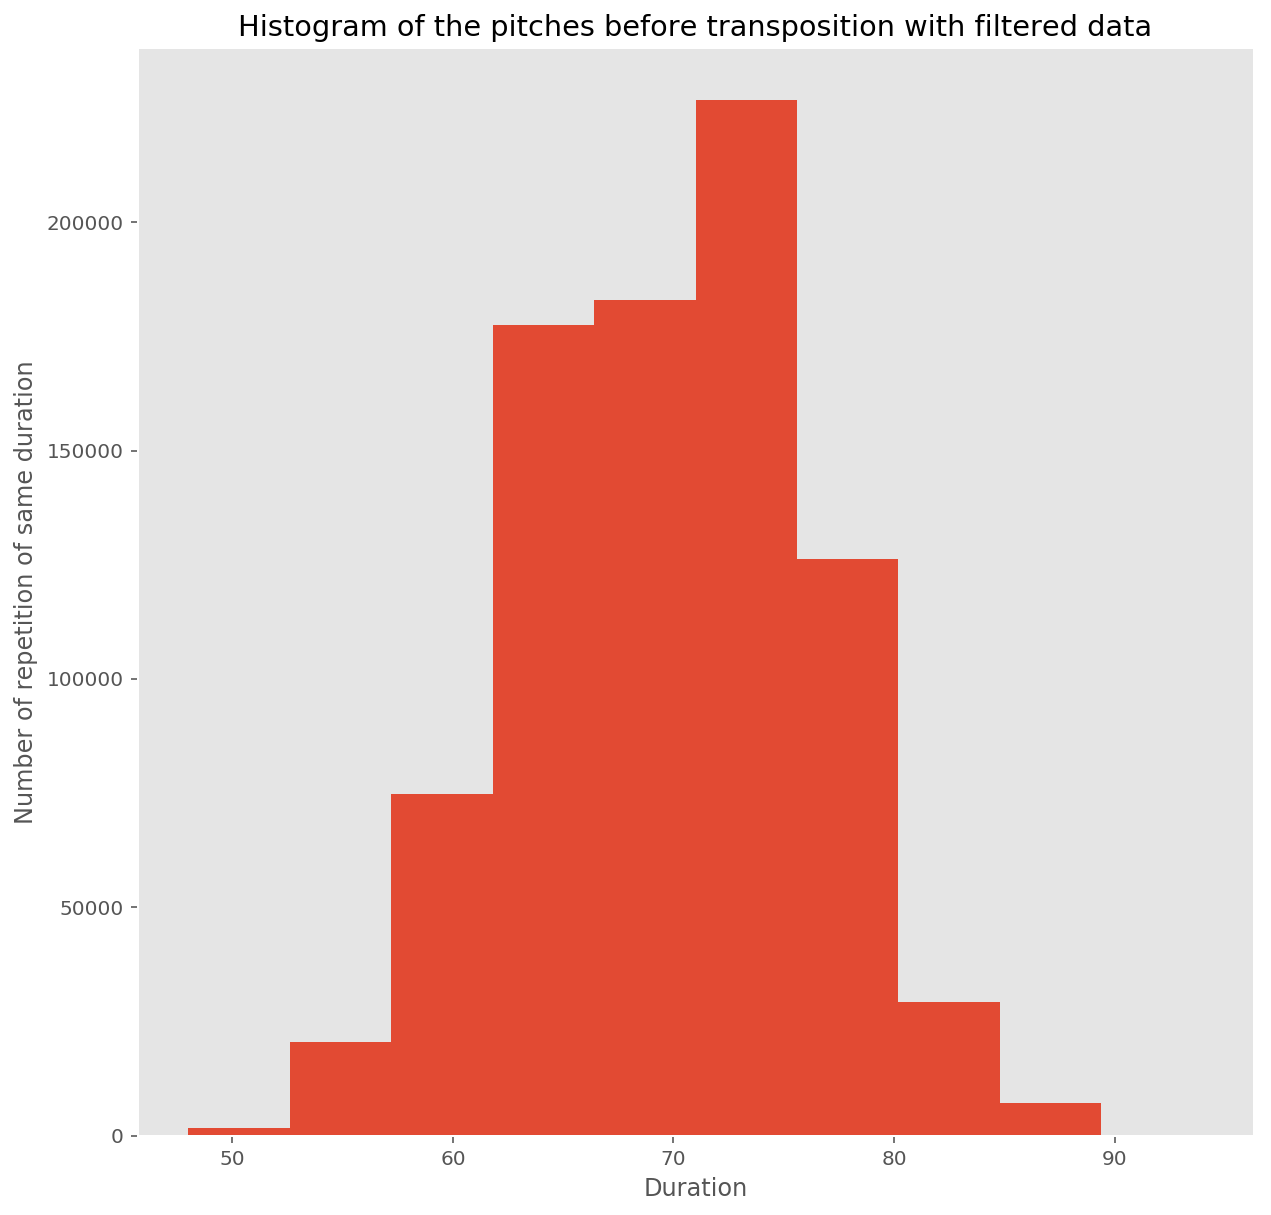

Size of the data_set :  847044


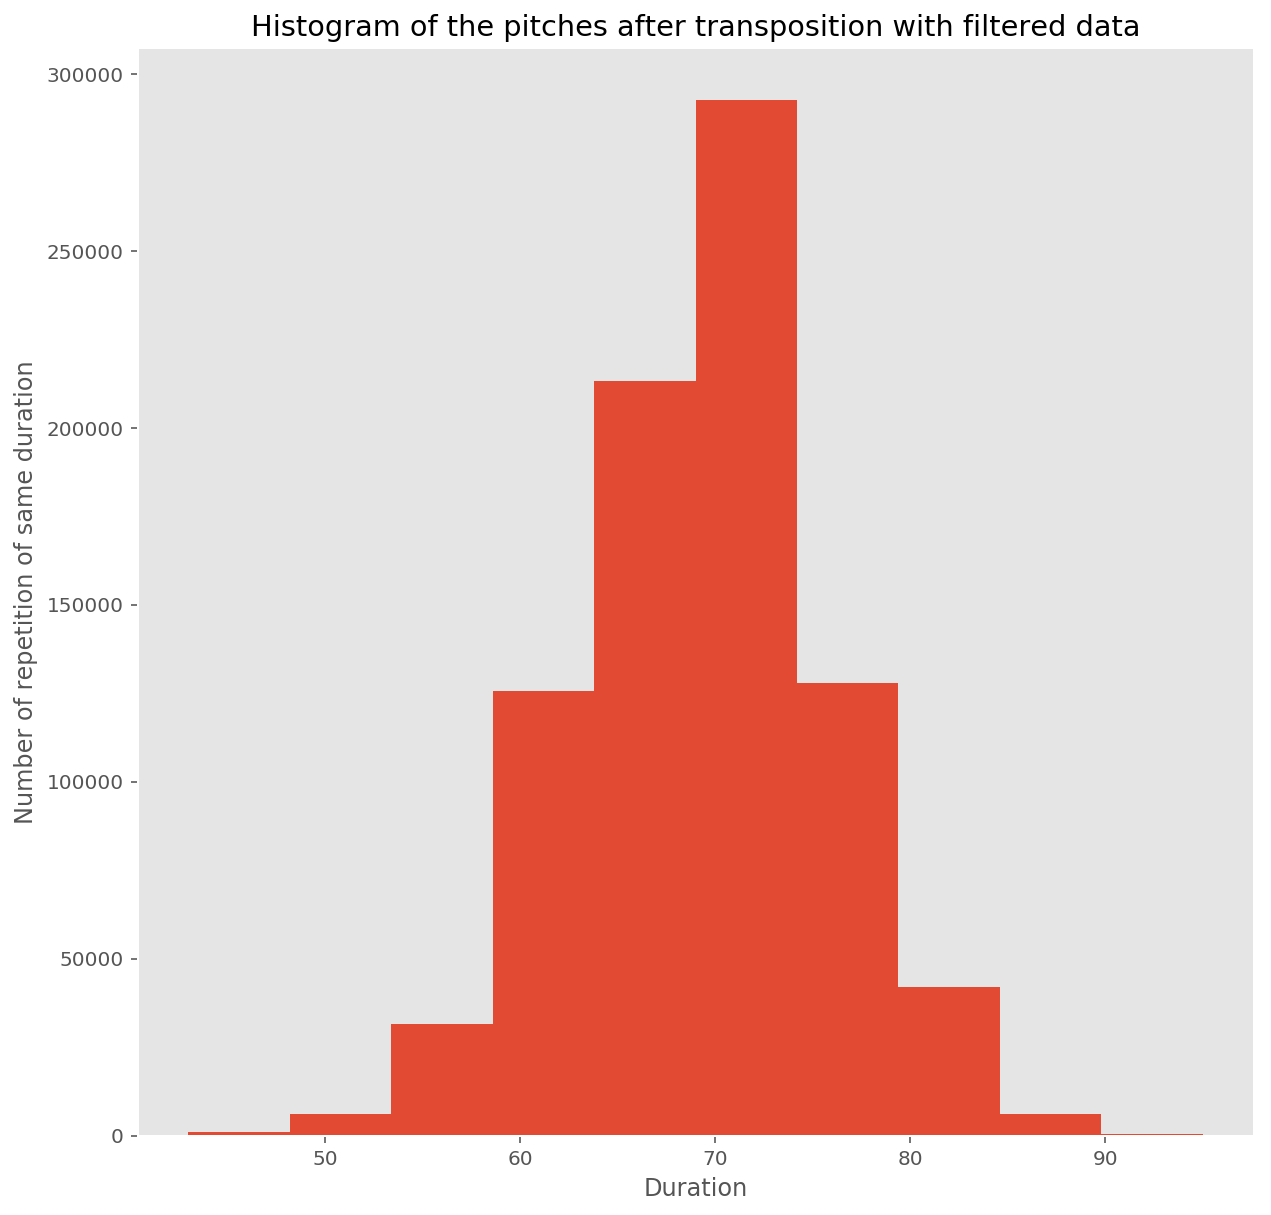

Size of the data_set :  847044


In [66]:
#############################################################################################################################
# Question 2 : Plot the histograms of the pitches before and after transposition.
#############################################################################################################################

########## Histogram of the pitches before  transposition with filtered data ##########      
fig = plt.figure(figsize=(10,10))
plt.hist(sum_P_filtered)
plt.title('Histogram of the pitches before transposition with filtered data')
plt.xlabel('Duration')
plt.ylabel('Number of repetition of same duration')
plt.show()
print ('Size of the data_set : ', len(sum_P_filtered))

########## Histogram of the pitches after transposition with filtered data ########## 

sum_T_filtered_transpose, sum_P_filtered_transpose = list(), list()
i=0
for label in list(transpose_dataset.keys()):
    for t in transpose_dataset[label]['T']:
        sum_T_filtered_transpose.append(t)
    for p in transpose_dataset[label]['P']:
        sum_P_filtered_transpose.append(p)
        
fig = plt.figure(figsize=(10,10))
plt.hist(sum_P_filtered_transpose)
plt.title('Histogram of the pitches after transposition with filtered data')
plt.xlabel('Duration')
plt.ylabel('Number of repetition of same duration')
plt.show()
print ('Size of the data_set : ', len(sum_P_filtered_transpose))

#### Finally, you shoud recompute the tokenization step for your brand new filtered and normalized dataset.

In [67]:
#############################################################################################################################
# Tokenization step  for your brand new filtered and normalized dataset
#############################################################################################################################
T_dictionary_transpose_filtered = (np.unique(sum_T_filtered_transpose))
P_dictionary_transpose_filtered = (np.unique(sum_P_filtered_transpose)) 
print ('\n', 'T_dictionnary : \n', T_dictionary, '\n \n P_dictionnary : \n', P_dictionary, '\n \n \n')

int_dataset_transpose = copy.deepcopy(transpose_dataset)

for label in list(int_dataset_transpose.keys()):
    int_dataset_transpose[label]['T']  = [np.where(T_dictionary_transpose_filtered==x)[0][0] for x in int_dataset_transpose[label]['T']]
    int_dataset_transpose[label]['P'] = [np.where(P_dictionary_transpose_filtered==x)[0][0] for x in int_dataset_transpose[label]['P']]
print ('New integer dataset for T :',int_dataset_transpose[label]['T'], '\n')
print ('New integer dataset for P :',int_dataset_transpose[label]['P'])

for label in np.random.choice(list(int_dataset_transpose.keys()), 2):
    print(label)
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print(transpose_dataset[label])
    print('\n')
    print("Integer representation of the note")
    print(int_dataset_transpose[label])
    print('\n')


 T_dictionnary : 
 [  30   40   45   50   59   60   80   90  106  119  120  127  144  150  159
  160  179  180  200  213  220  229  230  239  240  280  300  319  320  321
  359  360  400  460  469  479  480  560  600  639  640  719  720  800  840
  880  959  960 1040 1080 1120 1199 1200 1280 1320 1439 1440 1680 1840 1919
 1920 2080 2159 2160 2399 2400 2640 2720 2879 2880 3120 3360 3840 4320 5040
 5520 5760] 
 
 P_dictionnary : 
 [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94] 
 
 

New integer dataset for T : [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7] 

New integer dataset for P

**Question**: How much did you reduce the space of possible durations with your rare event suppression procedure? What is the impact in term of training time?

**Answer**: We have reduce the space of possible durations by a factor 3 approximatly (6000 to 2000). Also we can see that mean and median did not change before and after filtering which is what we wanted (both stays around 250). Thus, as we reduce the space of possible durations with rare event suppression procedure, our training time will be reduce because the number of values is reduced.

**Question**: Explain why and how both transposition to a single tonality and to all possible tonalities can yield transposition invariance in your model. 

**Answer**: The first method consists in transposing every melody into a common tonality (C Major/A minor). This first model will transpose each melody to a single tonality (C Major/A minor) and thus our model will see each music as they have the same tonality so it become independant of the tonality. On the other hand, the second method consists in transposing each melody in all possible keys which means in all tonalities. Thus the model will be trained with all tonalities but this second method will increase the dataset a lot. Thus, computation time will increase and we don't want that but transposition invariance would be applied. In fact in music, we want each note to be invariance about the tonality. Change of tonality would change the way of hearing the music but it would not change the relationship between each note in the time.

**Question**: In terms of number of dimensions, what would have been the impact of keeping the joint represenation of a note duration and pitch (vs separating the two features)?

**Answer**: Separating the two features would have decrease the number of dimensions. In fact, keeping joint distribution would be equal to work with a large dataset in term of dimensions and thus the model would need to be more complex to predict the output. In fact, in this case the number of combination of features would be multiplied because the model would have link pitch and time. Thus, keeping the joint represenation of a note duration and pitch would have increase the number of dimensions and thus the model would have to be more complex to learn.

**Question**: How would the distribution of notes in the joint representation differ from the distributions in the pitch and duration only representations (as shown by your histograms above)?

**Answer**: The representation of the joint distribution would take into account both values that composed her dimension and thus we would have less event that are the same.  In fact in the joint distribution, duration and pitch need to be both the same to consider the event repetitve. Morevoer, we would have a larger dictionary. In the separate representation it's not the case. You can check either pitch or duration. Thus, it allows use to make a more effective filtering of rare events and the transposition invariance transformation (see histograms).

## Exercise 4: One-hot and zero-padding
### Description

The last few steps to be able to feed (note by note) your music scores to a RNN model are
1. Transform the sequence of integers into a sequence of vectors in the one-hot encoding scheme.
2. Homegenize the length of each sequence

**One-hot encode** You can implement your own integer to one-hot code. For this use the numpy library and the suitable datatype. Alternatively, Keras provides a [built in one-hot encoding scheme](https://keras.io/utils/#to_categorical). After this step, for each melody, you should have two similar length matrices with one representing the sequence of note pitches and the other the sequence of note durations.
1. Code the integer representation into matrices of one-hot vectors

**Zero-padding** Most deep learning libraries, including Keras, require that you specify the shape of the input data. As such, you cannot have variable length inputs per-se. The trick to handle them is [zero-padding](https://keras.io/preprocessing/sequence/#pad_sequences). Provided with the [Masking Layer](https://keras.io/layers/core/#masking) Keras will then ignore time steps where all inputs are 0.
1. Extend the end of each melody matrices with vectors containing only zeros until all melodies have the same size. For simplicity, use the Keras pad_sequences function. There might be some rare very long melodies in your dataset, a possible choice is to set the 'maxlen' argument of pad_sequences to the mean+2std of the melody lengths. This ensure that 95% of your melodies would end before being truncated.
2. Check and display the dimension of the resulting tensors. Typically, the tensor representing the sequence of pitches should be of shape [number of melodies x number of notes x number of entries in the pitch dictionary] and the tensor representing the sequence of durations [number of melodies x number of notes x number of entries in the duration dictionary]

To check if this step was done correctly use the provided plotMelody function. For two randomly selected melodies, call the plotMelody function before and after one-hot/zero-pad. You should obtain the same plots (or slightly truncated if you randomly selected one belonging to 5% longest).

Finally, we strongly suggest that you save your preprocessed data now.

### Solution

###### One-hot encode

In [68]:
##################################################################################################################
# Question 1 : Code the integer representation into matrices of one-hot vectors
##################################################################################################################
one_hot_dataset = {}
for label in list(transpose_dataset.keys()):
    one_hot_dataset[label] = {}
    one_hot_dataset[label]['T']=keras.utils.to_categorical(int_dataset_transpose[label]['T'], num_classes=len(T_dictionary_transpose_filtered))
    one_hot_dataset[label]['P']=keras.utils.to_categorical(int_dataset_transpose[label]['P'], num_classes=len(P_dictionary_transpose_filtered))

for label in np.random.choice(list(transpose_dataset.keys()), 2):
    print(label)
    print("MIDI events")
    display(datapath+label+".mid")
    print("One-hot encode : Integer representation of the note")
    print(one_hot_dataset[label])
    print('\n')

sessiontune35651
MIDI events
File: chorpus/sessiontune35651.mid

########################################
tick 	 pitch 	 message 	 velocity
########################################
1 	 68 	 Note On 	 105
480 	 68 	 Note Off 	 0
481 	 75 	 Note On 	 80
720 	 75 	 Note Off 	 0
721 	 68 	 Note On 	 80
960 	 68 	 Note Off 	 0
961 	 77 	 Note On 	 95
1200 	 77 	 Note Off 	 0
1201 	 73 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
36961 	 73 	 Note On 	 80
37200 	 73 	 Note Off 	 0
37201 	 75 	 Note On 	 80
37440 	 75 	 Note Off 	 0
37441 	 72 	 Note On 	 95
37920 	 72 	 Note Off 	 0
37921 	 75 	 Note On 	 80
38400 	 75 	 Note Off 	 0
########################################

One-hot encode : Integer representation of the note
{'T': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 

##### Zero-padding

maxlen_T = number of notes = maxlen_P =  400  =  400
number of entries in the pitch dictionary =  51
number of entries in the duration dictionary =  20
number of melodies 4398

Shape of T tensor sequence : (4398, 400, 20)
We should find [number of melodies x number of notes x number of entries in the pitch dictionary]. So we are right

Shape of P tensor sequence : (4398, 400, 51)
We should find [number of melodies x number of notes x number of entries in the duration dictionary]. So we are right

First plotMelody function before one-hot/zero-pa :


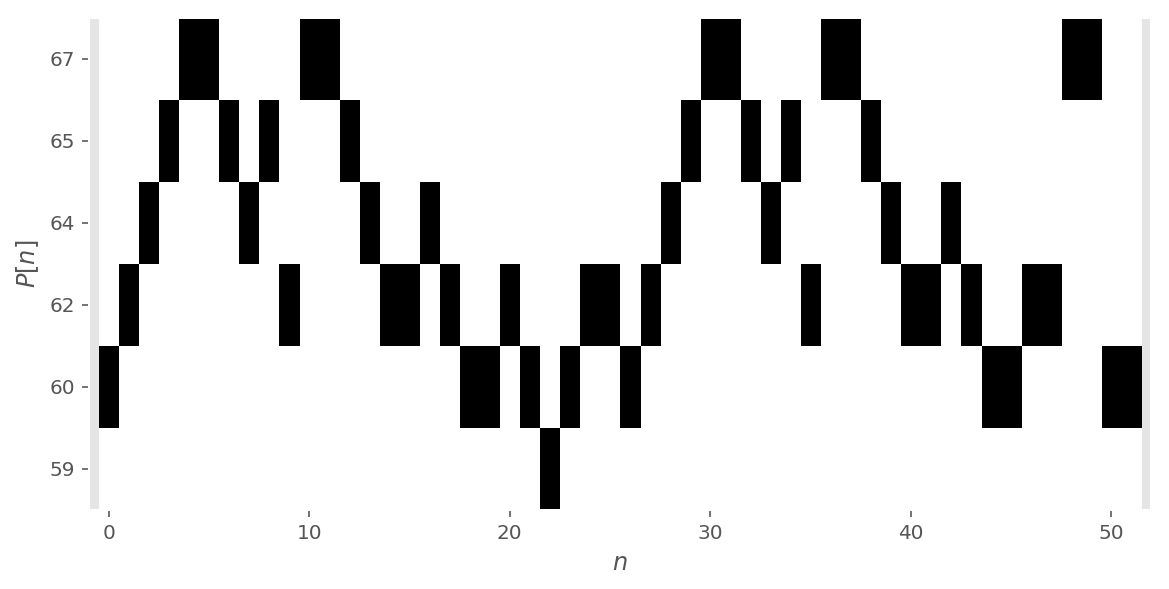

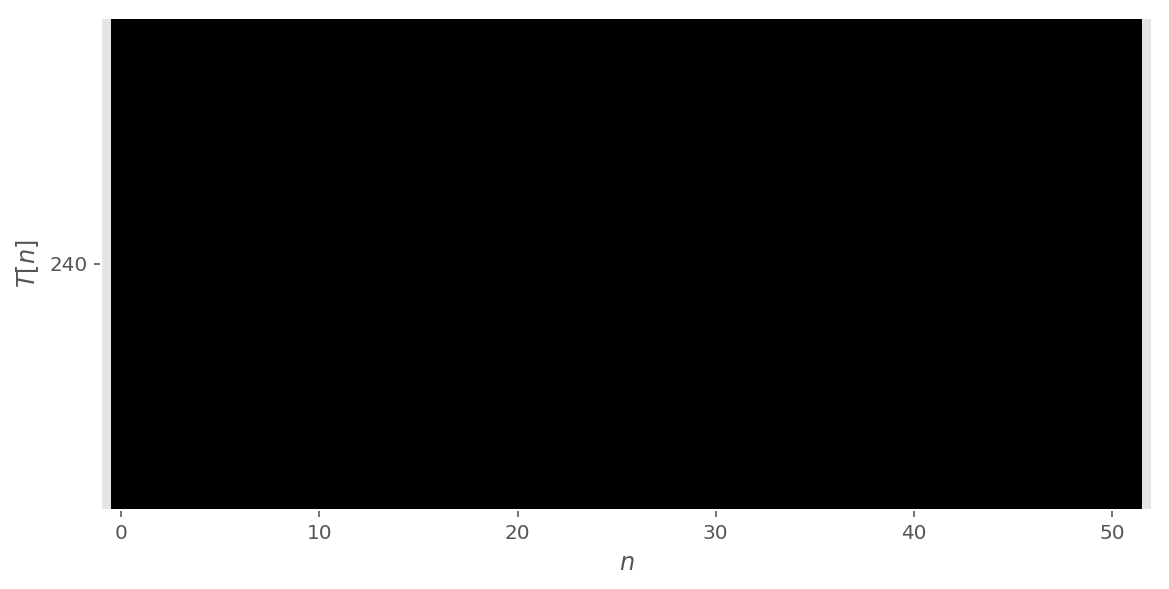

First plotMelody function after one-hot/zero-pad :


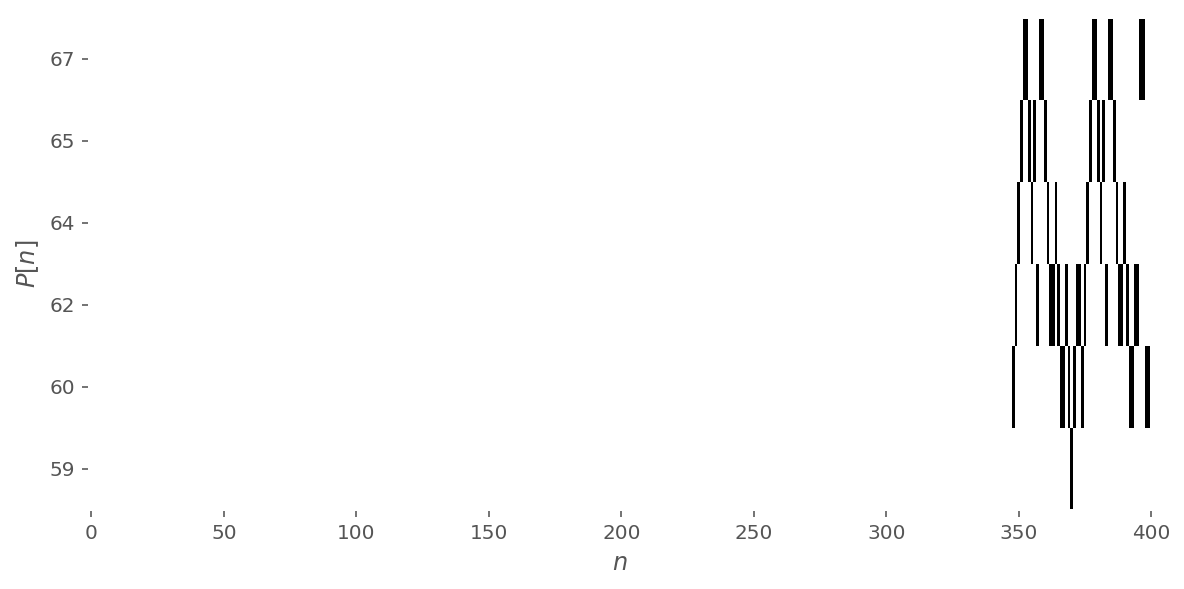

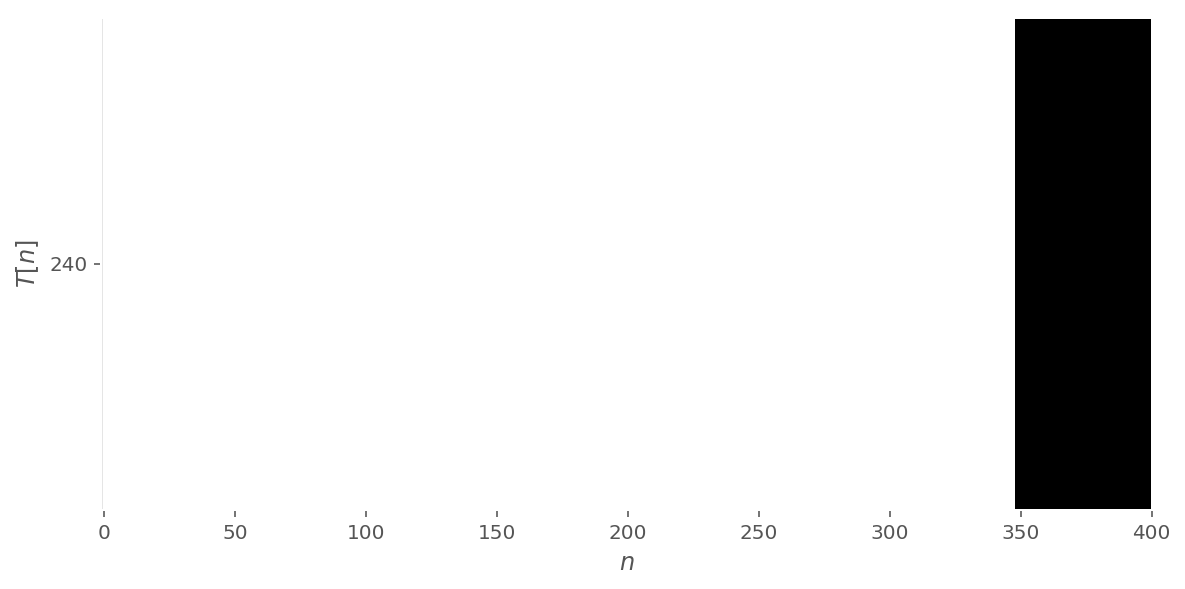


Second plotMelody function before one-hot/zero-pa :


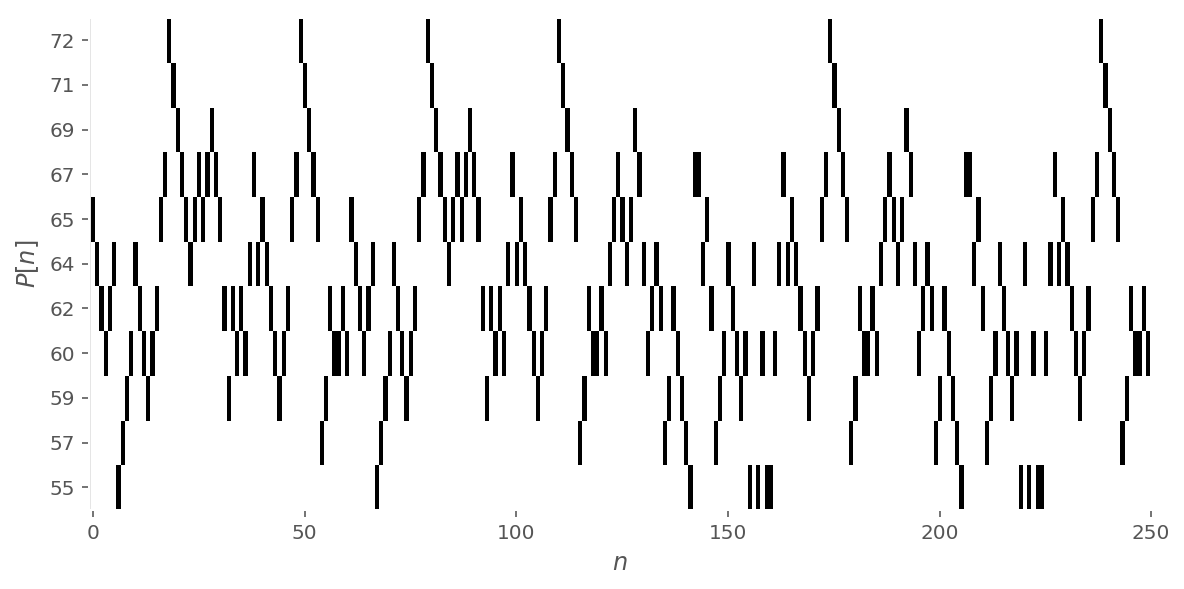

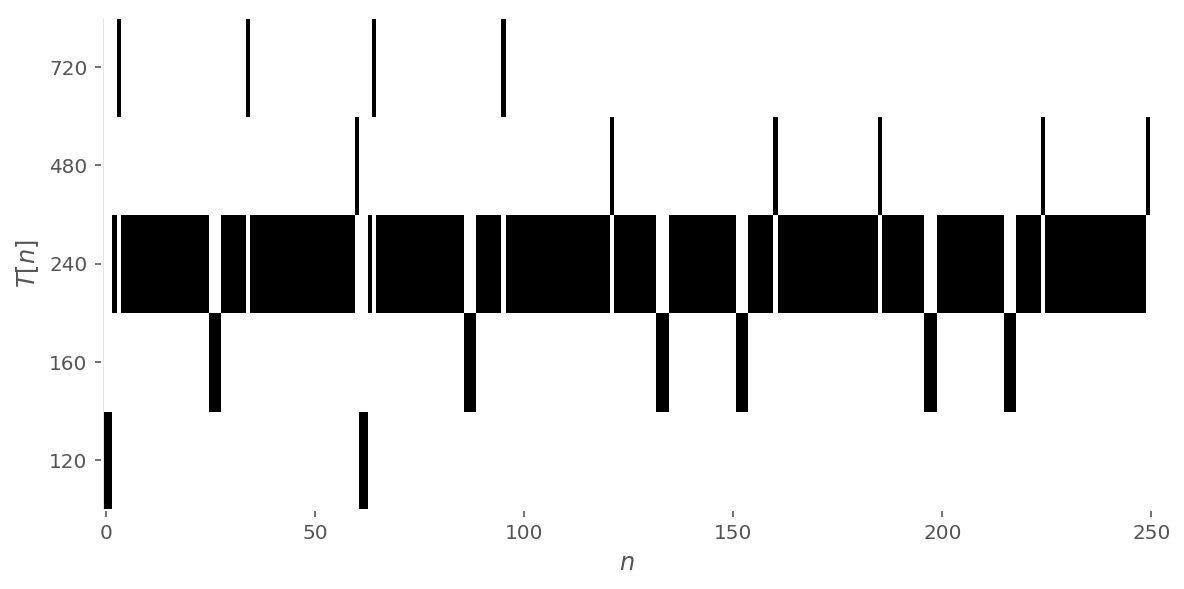

Second plotMelody function after one-hot/zero-pad :


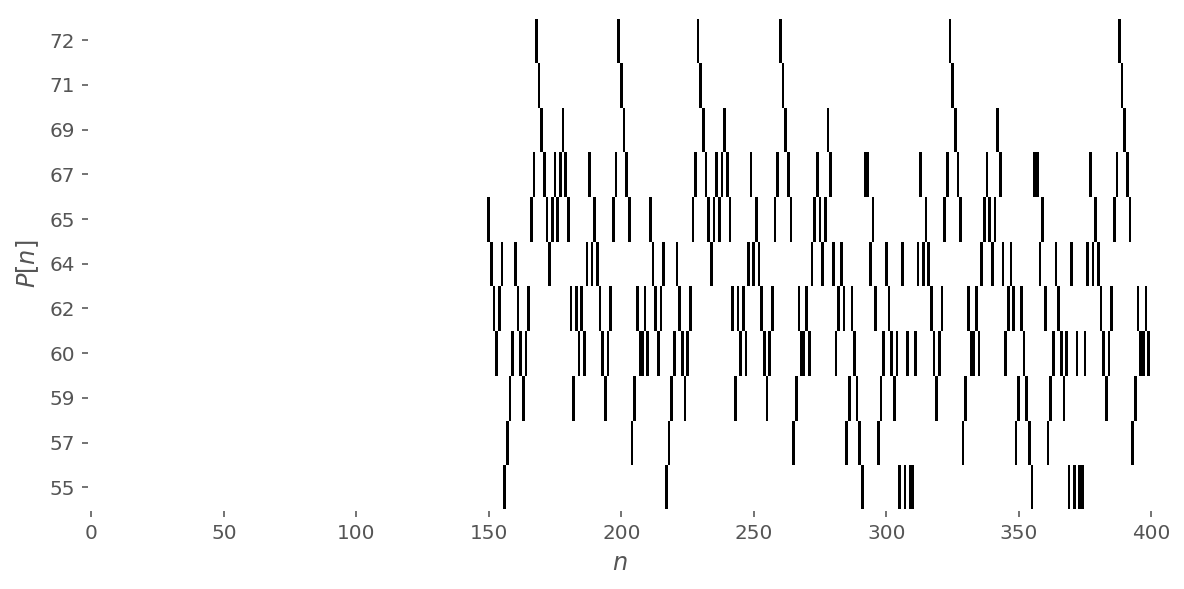

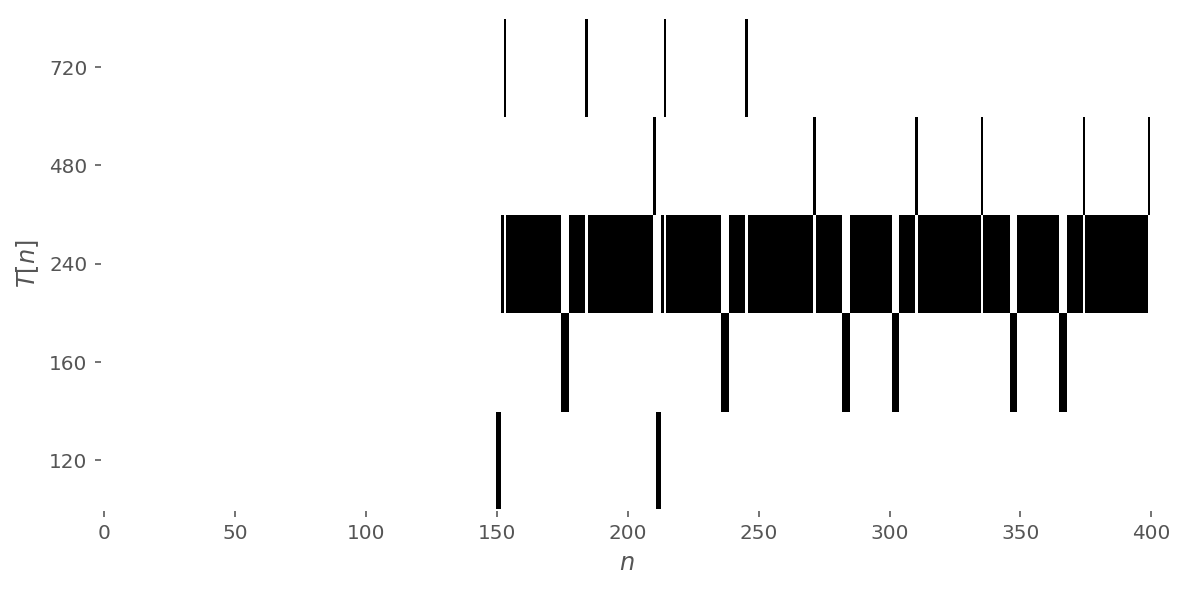

We should obtain the same plots (or slightly truncated if you randomly selected one belonging to 5% longest). That is what we have
We can see the effect of padding which add 0 to the sequence to have sequence of the same size (378). That is why we see a blank part at the begining of the melody plot for the padding part.

Saving begin ...
Pre-process data saved


In [69]:
from torch import tensor
##################################################################################################################
# Question 1: Extend the end of each melody matrices with vectors containing only zeros until all melodies have the same size
##################################################################################################################

len_vector_T, len_vector_P= list(), list()
for label in list(transpose_dataset.keys()):
    len_vector_T.append(len(transpose_dataset[label]['T']))
    len_vector_P.append(len(transpose_dataset[label]['P']))
maxlen_T=np.mean(len_vector_T)+2*np.std(len_vector_T) # rare very long melodies in your dataset, a possible choice is to set the 'maxlen' argument of pad_sequences to the mean+2std of the melody lengths -->  This ensure that 95% of your melodies would end before being truncated.
maxlen_P=np.mean(len_vector_P)+2*np.std(len_vector_T)

list_T_int, list_P_int, list_T,list_P= list(), list(),list(),list()
for label in list(one_hot_dataset.keys()):
    list_T_int.append(int_dataset_transpose[label]['T'])
    list_P_int.append(int_dataset_transpose[label]['P'])
    list_T.append(one_hot_dataset[label]['T'])
    list_P.append(one_hot_dataset[label]['P'])

### Padding ###
array_T_int=pad_sequences(list_T_int, maxlen=int(maxlen_T), dtype='int64', padding='pre', truncating='pre', value=0)
array_P_int=pad_sequences(list_P_int, maxlen=int(maxlen_P), dtype='int64', padding='pre', truncating='pre', value=0)
array_T=pad_sequences(list_T, maxlen=int(maxlen_T), dtype='int64', padding='pre', truncating='pre', value=0.0)
array_P=pad_sequences(list_P, maxlen=int(maxlen_P), dtype='int64', padding='pre', truncating='pre', value=0.0)

### Set the final dataset ###
i=0
int_one_hot_dataset = {}
final_dataset={}
for label in list(int_dataset_transpose.keys()):
    int_one_hot_dataset[label] = {}
    final_dataset[label]={}
    int_one_hot_dataset[label]['T']=array_T_int[i]
    int_one_hot_dataset[label]['P']=array_P_int[i]
    final_dataset[label]['T']=array_T[i]
    final_dataset[label]['P']=array_P[i]
    i=i+1

#####################################################################################################################
# Question 2: Check and display the dimension of the resulting tensors. 
#####################################################################################################################
print ('maxlen_T = number of notes = maxlen_P = ',int(maxlen_T), ' = ', int(maxlen_P) )
print ('number of entries in the pitch dictionary = ',len(P_dictionary_transpose_filtered) )
print ('number of entries in the duration dictionary = ',len(T_dictionary_transpose_filtered) )
print ('number of melodies', len(int_dataset_transpose))


print ('\nShape of T tensor sequence :', array_T.shape) # tensor representing the sequence of pitches should be of shape [number of melodies x number of notes x number of entries in the pitch dictionary]
print ('We should find [number of melodies x number of notes x number of entries in the pitch dictionary]. So we are right')
print ('\nShape of P tensor sequence :', array_P.shape) # tensor representing the sequence of durations [number of melodies x number of notes x number of entries in the duration dictionary]
print ('We should find [number of melodies x number of notes x number of entries in the duration dictionary]. So we are right')

####################################################################################################################
# Check if this step was done correctly use the provided plotMelody function
####################################################################################################################

dictionaries = {'T': T_dictionary_transpose_filtered, 'P': P_dictionary_transpose_filtered}

for label in np.random.choice(list(final_dataset.keys()), 1):
    T_1 = int_dataset_transpose[label]['T'] # before one hot code and zero padding
    P_1 = int_dataset_transpose[label]['P']
    T_hot_1 = final_dataset[label]['T']#one_hot_dataset[label]['T'] # after one hot code and zero padding
    P_hot_1 = final_dataset[label]['P']

for label in np.random.choice(list(final_dataset.keys()), 1):
    T_2 = int_dataset_transpose[label]['T'] # before one hot code and zero padding
    P_2 = int_dataset_transpose[label]['P']
    T_hot_2 = final_dataset[label]['T']#one_hot_dataset[label]['T'] # after one hot code and zero padding
    P_hot_2 = final_dataset[label]['P']

### Plot ###
print ('\nFirst plotMelody function before one-hot/zero-pa :')
plotMelody(P_1, T_1, dictionaries, PrP=None, PrT=None, H=None)
print ('First plotMelody function after one-hot/zero-pad :')
plotMelody(P_hot_1, T_hot_1, dictionaries, PrP=None, PrT=None, H=None)

print ('\nSecond plotMelody function before one-hot/zero-pa :')
plotMelody(P_2, T_2, dictionaries, PrP=None, PrT=None, H=None)
print ('Second plotMelody function after one-hot/zero-pad :')
plotMelody(P_hot_2, T_hot_2, dictionaries, PrP=None, PrT=None, H=None)

print ( 'We should obtain the same plots (or slightly truncated if you randomly selected one belonging to 5% longest). That is what we have')
print ('We can see the effect of padding which add 0 to the sequence to have sequence of the same size (378). That is why we see a blank part at the begining of the melody plot for the padding part.')

####################################################################################################################
# Save the pre processing datas
####################################################################################################################

print ('\nSaving begin ...')
np.save('final_dataset', final_dataset )
np.save('int_dataset', int_one_hot_dataset )
np.save('dictionaries', dictionaries )
np.save('t_array', array_T )
np.save('p_array', array_P )
print ('Pre-process data saved')

#### Now we will use : final_dataset (filtered + transpose + one hot coding + padding) and T_dictionnary_transpose_filtered et int_one_hot_dataset.

## Exercise 5: Building and training a generative model of  note transition with the Keras functional API
### Description

The Keras Sequential model is very efficient for fast prototyping, however suffers from a lack of design liberty. The Keras Functional API is only slightly more complex but allows for more control on the different parts of your model. You will be using the Functional API for the rest of this project. Please read carefully the [documentation](https://keras.io/getting-started/sequential-model-guide/). 

Here, you will be constructing your RNN model of note transition. To achieve that, your model should be trained to approximate the probability distribution of the upcoming note (observed as two output softmax layers - one for pitch and one for duration) given the current note (given as input) and the model internal representation of the history of notes (its hidden state). To achieve that, set the Keras RNN layer argument "return_sequences" to True when building your model. Doing this will give you an output for each note, rather than a single output at the end of the sequence. During training, the target at each time step is the next note pitch and duration.

You are free to use your own architecture but make sure to use at least 128 hidden units, Masking, and dropout to prevent overfitting. Your model should have two output (softmax) layers, one related to the pitch predictions that you should name `YP`, and the other related to the duration predictions `YT`. You should monitor both the loss (categorical_crossentropy) and the accuracy. For your best model, you should reach 40%/75% accuracy on the pitch/duration predictions.

1. Train your first model composed of SimpleRNN cells for min 250 epochs and save the model/parameters that lead to the higher accuracy on the validating set. Use a validation split of 0.2. Try  If you correctly named the output layers (`YP` and `YT`) use the provided `plotLearningCurves(History)` function to plot the learning curves by giving the History object returned by the Keras fit function as argument.  
2. Train a second model where you replaced the SimpleRNN units with GRUs (LSTM unit equivalent that requires less parameters). Make sure you use the same hyperparameters as before. Plot the learning curves.
3. On a single plot, adapt the `plotLearningCurves(History)` function to compare the validation learning curves of the simpleRNN and GRU models. In other words, plot the validation loss vs epoch for pitch/duration for the simpleRNN and GRU models. Do the same for accuracies.


### Solution

**Question 5.1**


In [3]:
######################################################
# Loading the pre-processed dataset with dictionaries 
######################################################

import pickle
dictionaries_load = np.load("dictionaries.npy")
array_T= np.load("t_array.npy")
array_P= np.load("p_array.npy")
final_dataset_load = np.load("final_dataset.npy")
dictionaries = {'T': dictionaries_load[()]['T'], 'P': dictionaries_load[()]['P']}
final_dataset = final_dataset_load[()]

In [10]:
# Recurrent Model for Music Note Transition
# Returns 1. model with next pitch, duration note 2. Returns hidden state of recurrent layer
def buildModel(dictionaries, batch_length, dropout=0.2, activation='GRU', Hsize=128):
    X = dict()
    H = dict()
    M = dict()
    Y = dict()
    
    X['T'] = Input(shape=(batch_length, len(dictionaries['T'])), name="XT")
    X['P'] = Input(shape=(batch_length, len(dictionaries['P'])), name="XP")
    M['T'] = Masking(mask_value=0., name="MT")(X['T'])
    M['P'] = Masking(mask_value=0., name="MP")(X['P'])
    H['1'] = Concatenate(name="MergeX")([M['T'], M['P']])
    
    if activation == 'GRU':
        y = GRU(128, activation='tanh', dropout=0.2, recurrent_dropout=0.2, return_sequences=True,return_state=False)(H['1'])
    elif activation == 'RNN':
        y = SimpleRNN(128, activation='tanh', dropout=0.2, recurrent_dropout=0.2, return_sequences=True,return_state=False)(H['1'])

    Y['T'] = TimeDistributed(Dense(len(dictionaries['T']), activation='softmax'), name='YT')(y)
    Y['P'] = TimeDistributed(Dense(len(dictionaries['P']), activation='softmax'), name='YP')(y)
    
    model = Model(inputs = [X['T'], X['P']], outputs = [Y['T'], Y['P']])
    opt = Adam(lr=0.001) 
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
    model_hidden = Model(inputs = [X['T'], X['P']], outputs = [Y['T'], Y['P'], y])
    return model, model_hidden


In [ ]:
#############################################################################
# Train a simpleRNN Model for 250 epochs, we have trained this on high end GPU
#############################################################################

checkpointer= ModelCheckpoint('./RNN_good.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto', period=1)
RNNmodel,RNNmodel_hidden = buildModel(dictionaries, batch_length=377, activation='RNN')
RNNmodel.summary()
history_RNN=RNNmodel.fit(callbacks=[checkpointer], x=[array_T[:,:-1,:],array_P[:,:-1,:]], y=[array_T[:,1:,:],array_P[:,1:,:]], batch_size=32, epochs=250,verbose=1, validation_split=0.2)
with open('./trainHistoryDict_RNN', 'wb') as file_pi:
    pickle.dump(history_RNN.history, file_pi)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 377, 19)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 377, 50)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 377, 19)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 377, 50)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

3522/3522 [==============================] - 57s - loss: 2.6498 - YT_loss: 0.7076 - YP_loss: 1.9422 - YT_acc: 0.7970 - YP_acc: 0.3244 - val_loss: 2.4460 - val_YT_loss: 0.6195 - val_YP_loss: 1.8264 - val_YT_acc: 0.8192 - val_YP_acc: 0.3648
Epoch 57/250
3522/3522 [==============================] - 54s - loss: 2.6538 - YT_loss: 0.7119 - YP_loss: 1.9419 - YT_acc: 0.7952 - YP_acc: 0.3241 - val_loss: 2.4404 - val_YT_loss: 0.6167 - val_YP_loss: 1.8237 - val_YT_acc: 0.8195 - val_YP_acc: 0.3644
Epoch 58/250
3522/3522 [==============================] - 51s - loss: 2.6449 - YT_loss: 0.7019 - YP_loss: 1.9430 - YT_acc: 0.7983 - YP_acc: 0.3243 - val_loss: 2.4551 - val_YT_loss: 0.6211 - val_YP_loss: 1.8340 - val_YT_acc: 0.8185 - val_YP_acc: 0.3632
Epoch 59/250
3522/3522 [==============================] - 45s - loss: 2.6368 - YT_loss: 0.6959 - YP_loss: 1.9409 - YT_acc: 0.7993 - YP_acc: 0.3270 - val_loss: 2.4352 - val_YT_loss: 0.6106 - val_YP_loss: 1.8247 - val_YT_acc: 0.8202 - val_YP_acc: 0.3659
Epoch

3522/3522 [==============================] - 47s - loss: 2.6943 - YT_loss: 0.7345 - YP_loss: 1.9598 - YT_acc: 0.7917 - YP_acc: 0.3186 - val_loss: 2.4663 - val_YT_loss: 0.6286 - val_YP_loss: 1.8377 - val_YT_acc: 0.8164 - val_YP_acc: 0.3587
Epoch 121/250
3522/3522 [==============================] - 47s - loss: 2.7058 - YT_loss: 0.7246 - YP_loss: 1.9812 - YT_acc: 0.7939 - YP_acc: 0.3129 - val_loss: 2.5066 - val_YT_loss: 0.6303 - val_YP_loss: 1.8762 - val_YT_acc: 0.8138 - val_YP_acc: 0.3455
Epoch 122/250
3522/3522 [==============================] - 48s - loss: 2.6815 - YT_loss: 0.7121 - YP_loss: 1.9694 - YT_acc: 0.7973 - YP_acc: 0.3165 - val_loss: 2.4536 - val_YT_loss: 0.6128 - val_YP_loss: 1.8408 - val_YT_acc: 0.8181 - val_YP_acc: 0.3602
Epoch 123/250
3522/3522 [==============================] - 47s - loss: 2.6561 - YT_loss: 0.7023 - YP_loss: 1.9538 - YT_acc: 0.7990 - YP_acc: 0.3200 - val_loss: 2.4527 - val_YT_loss: 0.6198 - val_YP_loss: 1.8329 - val_YT_acc: 0.8179 - val_YP_acc: 0.3635
Ep

3522/3522 [==============================] - 47s - loss: 2.5946 - YT_loss: 0.6854 - YP_loss: 1.9092 - YT_acc: 0.8013 - YP_acc: 0.3358 - val_loss: 2.3750 - val_YT_loss: 0.5853 - val_YP_loss: 1.7897 - val_YT_acc: 0.8239 - val_YP_acc: 0.3787
Epoch 185/250
3522/3522 [==============================] - 47s - loss: 2.5808 - YT_loss: 0.6677 - YP_loss: 1.9131 - YT_acc: 0.8041 - YP_acc: 0.3349 - val_loss: 2.3715 - val_YT_loss: 0.5855 - val_YP_loss: 1.7860 - val_YT_acc: 0.8242 - val_YP_acc: 0.3823
Epoch 186/250
3522/3522 [==============================] - 49s - loss: 2.5867 - YT_loss: 0.6826 - YP_loss: 1.9040 - YT_acc: 0.8010 - YP_acc: 0.3384 - val_loss: 2.3675 - val_YT_loss: 0.5868 - val_YP_loss: 1.7807 - val_YT_acc: 0.8229 - val_YP_acc: 0.3814
Epoch 187/250
3522/3522 [==============================] - 48s - loss: 2.5759 - YT_loss: 0.6699 - YP_loss: 1.9060 - YT_acc: 0.8042 - YP_acc: 0.3364 - val_loss: 2.3664 - val_YT_loss: 0.5861 - val_YP_loss: 1.7803 - val_YT_acc: 0.8236 - val_YP_acc: 0.3816
Ep

3522/3522 [==============================] - 48s - loss: 2.5883 - YT_loss: 0.6772 - YP_loss: 1.9111 - YT_acc: 0.8027 - YP_acc: 0.3360 - val_loss: 2.3625 - val_YT_loss: 0.5852 - val_YP_loss: 1.7773 - val_YT_acc: 0.8239 - val_YP_acc: 0.3804
Epoch 249/250
3522/3522 [==============================] - 49s - loss: 2.5782 - YT_loss: 0.6717 - YP_loss: 1.9065 - YT_acc: 0.8028 - YP_acc: 0.3378 - val_loss: 2.3585 - val_YT_loss: 0.5848 - val_YP_loss: 1.7736 - val_YT_acc: 0.8234 - val_YP_acc: 0.3837
Epoch 250/250
3522/3522 [==============================] - 48s - loss: 2.5657 - YT_loss: 0.6666 - YP_loss: 1.8992 - YT_acc: 0.8044 - YP_acc: 0.3387 - val_loss: 2.3510 - val_YT_loss: 0.5825 - val_YP_loss: 1.7685 - val_YT_acc: 0.8251 - val_YP_acc: 0.3843


**Question 5.2**


In [ ]:
checkpointer= ModelCheckpoint('./GRU_good.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto', period=1)
GRUmodel, GRUmodel_hidden = buildModel(dictionaries, batch_length=377, activation='GRU')
GRUmodel.summary()


history_GRU= GRUmodel.fit(callbacks=[checkpointer], x=[array_T[:,:-1,:],array_P[:,:-1,:]], y=[array_T[:,1:,:],array_P[:,1:,:]], batch_size=32, epochs=250,verbose=1, validation_split=0.2)
with open('./trainHistoryDict_GRU', 'wb') as file_pi:
    pickle.dump(history_GRU.history, file_pi)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 377, 19)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 377, 50)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 377, 19)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 377, 50)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

3522/3522 [==============================] - 109s - loss: 2.2850 - YT_loss: 0.5600 - YP_loss: 1.7250 - YT_acc: 0.8251 - YP_acc: 0.3979 - val_loss: 2.1807 - val_YT_loss: 0.5241 - val_YP_loss: 1.6566 - val_YT_acc: 0.8326 - val_YP_acc: 0.4234
Epoch 57/250
3522/3522 [==============================] - 109s - loss: 2.2797 - YT_loss: 0.5569 - YP_loss: 1.7228 - YT_acc: 0.8263 - YP_acc: 0.3978 - val_loss: 2.1839 - val_YT_loss: 0.5252 - val_YP_loss: 1.6587 - val_YT_acc: 0.8327 - val_YP_acc: 0.4214
Epoch 58/250
3522/3522 [==============================] - 108s - loss: 2.2830 - YT_loss: 0.5597 - YP_loss: 1.7233 - YT_acc: 0.8245 - YP_acc: 0.3981 - val_loss: 2.1788 - val_YT_loss: 0.5226 - val_YP_loss: 1.6562 - val_YT_acc: 0.8330 - val_YP_acc: 0.4231
Epoch 59/250
3522/3522 [==============================] - 108s - loss: 2.2771 - YT_loss: 0.5578 - YP_loss: 1.7193 - YT_acc: 0.8247 - YP_acc: 0.3988 - val_loss: 2.1721 - val_YT_loss: 0.5200 - val_YP_loss: 1.6521 - val_YT_acc: 0.8332 - val_YP_acc: 0.4250
E

3522/3522 [==============================] - 109s - loss: 2.1275 - YT_loss: 0.5101 - YP_loss: 1.6174 - YT_acc: 0.8322 - YP_acc: 0.4350 - val_loss: 2.0502 - val_YT_loss: 0.4876 - val_YP_loss: 1.5626 - val_YT_acc: 0.8357 - val_YP_acc: 0.4569
Epoch 175/250
3522/3522 [==============================] - 112s - loss: 2.1276 - YT_loss: 0.5099 - YP_loss: 1.6177 - YT_acc: 0.8334 - YP_acc: 0.4335 - val_loss: 2.0525 - val_YT_loss: 0.4882 - val_YP_loss: 1.5643 - val_YT_acc: 0.8360 - val_YP_acc: 0.4569
Epoch 176/250
3522/3522 [==============================] - 113s - loss: 2.1237 - YT_loss: 0.5076 - YP_loss: 1.6161 - YT_acc: 0.8327 - YP_acc: 0.4348 - val_loss: 2.0507 - val_YT_loss: 0.4882 - val_YP_loss: 1.5624 - val_YT_acc: 0.8354 - val_YP_acc: 0.4586
Epoch 177/250
3522/3522 [==============================] - 113s - loss: 2.1189 - YT_loss: 0.5059 - YP_loss: 1.6131 - YT_acc: 0.8331 - YP_acc: 0.4355 - val_loss: 2.0472 - val_YT_loss: 0.4869 - val_YP_loss: 1.5603 - val_YT_acc: 0.8358 - val_YP_acc: 0.458

3522/3522 [==============================] - 109s - loss: 2.1037 - YT_loss: 0.5049 - YP_loss: 1.5988 - YT_acc: 0.8328 - YP_acc: 0.4403 - val_loss: 2.0413 - val_YT_loss: 0.4860 - val_YP_loss: 1.5553 - val_YT_acc: 0.8351 - val_YP_acc: 0.4604
Epoch 239/250
3522/3522 [==============================] - 109s - loss: 2.1151 - YT_loss: 0.5088 - YP_loss: 1.6064 - YT_acc: 0.8314 - YP_acc: 0.4374 - val_loss: 2.0502 - val_YT_loss: 0.4890 - val_YP_loss: 1.5612 - val_YT_acc: 0.8352 - val_YP_acc: 0.4580
Epoch 240/250
3522/3522 [==============================] - 109s - loss: 2.1127 - YT_loss: 0.5047 - YP_loss: 1.6081 - YT_acc: 0.8336 - YP_acc: 0.4377 - val_loss: 2.0420 - val_YT_loss: 0.4865 - val_YP_loss: 1.5555 - val_YT_acc: 0.8352 - val_YP_acc: 0.4606
Epoch 241/250
3522/3522 [==============================] - 108s - loss: 2.1069 - YT_loss: 0.5042 - YP_loss: 1.6027 - YT_acc: 0.8327 - YP_acc: 0.4398 - val_loss: 2.0395 - val_YT_loss: 0.4851 - val_YP_loss: 1.5545 - val_YT_acc: 0.8356 - val_YP_acc: 0.459

IOError: [Errno 13] Permission denied: '/trainHistoryDict_GRU'

In [28]:
########################################################################
# Load models, history files again for plotting and best model statistics
########################################################################

RNNmodel,RNNmodel_hidden = buildModel(dictionaries, batch_length=377, activation='RNN')
RNNmodel.load_weights('RNN_good.h5')

GRUmodel, GRUmodel_hidden = buildModel(dictionaries, batch_length=377, activation='GRU')
GRUmodel.load_weights("GRU_good.h5")

with open('./trainHistoryDict_RNN', 'r') as file_pi:
    history_RNN = pickle.load(file_pi)

with open('./trainHistoryDict_GRU', 'r') as file_pi:
    history_GRU = pickle.load(file_pi)
    
index= np.argmin(history_RNN['val_loss'])

print("#"*100,"\n")

print("Best Model using simple RNN has Validation Pitch Accuracy: {:.2f}, Duration Accuracy: {:.2f}".format(history_RNN['val_YP_acc'][index]*100,history_RNN['val_YT_acc'][index]*100))
print("Best Model using GRU has Validation Pitch Accuracy: {:.2f}, Duration Accuracy: {:.2f}".format(history_GRU['val_YP_acc'][index]*100,history_GRU['val_YT_acc'][index]*100))

print("\n","#"*100,"\n")


#################################################################################################### 

Best Model using simple RNN has Validation Pitch Accuracy: 38.66, Duration Accuracy: 82.31
Best Model using GRU has Validation Pitch Accuracy: 46.16, Duration Accuracy: 83.52

 #################################################################################################### 



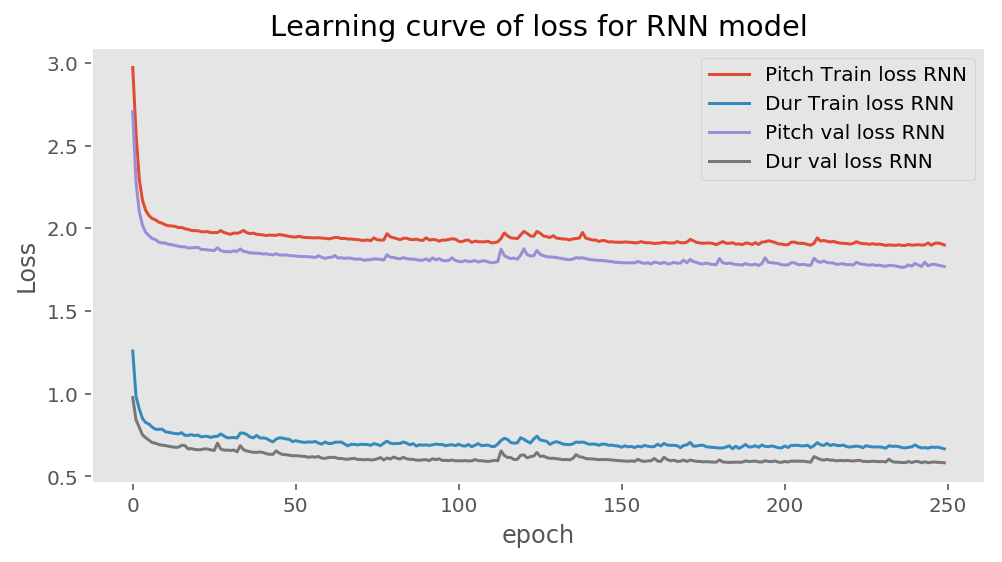

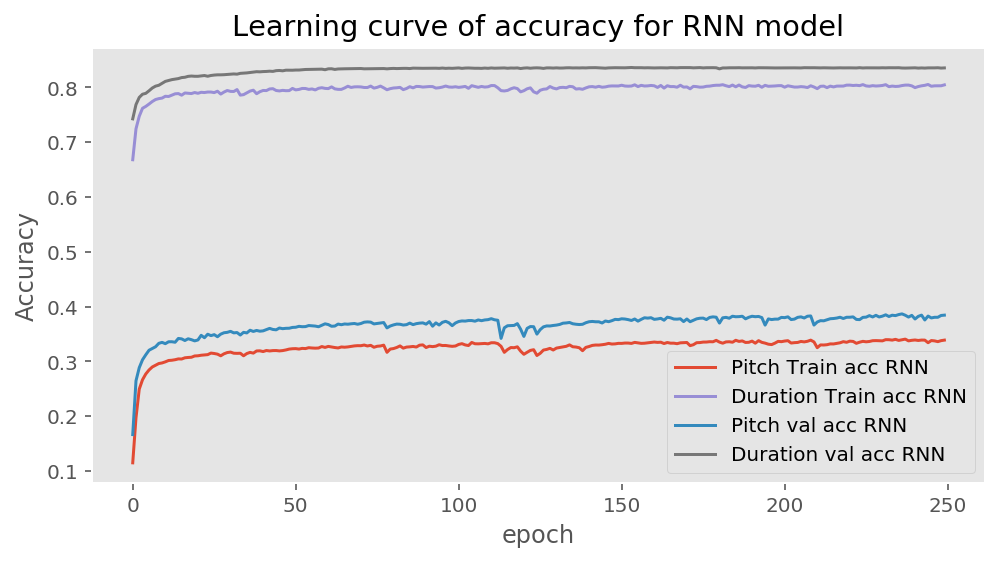

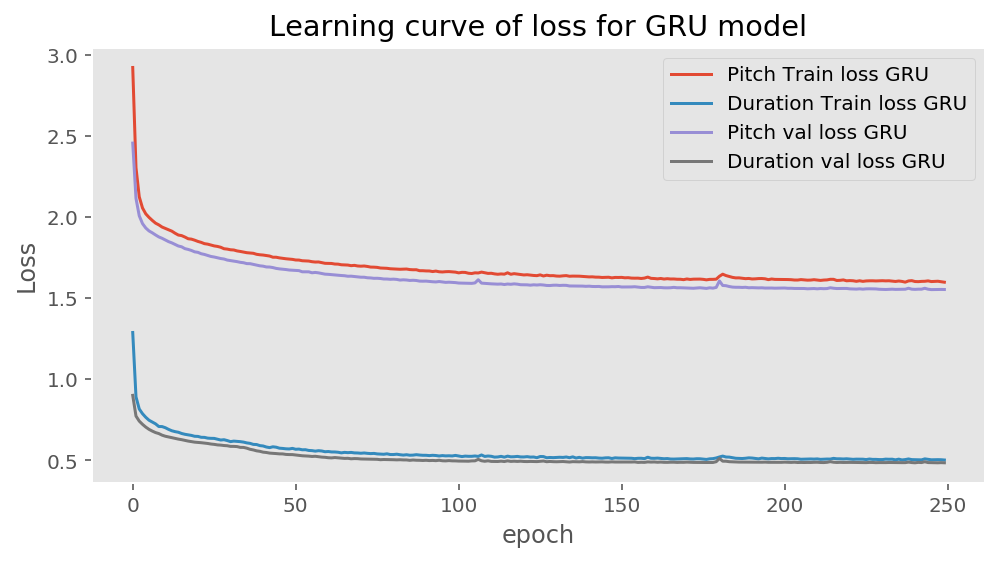

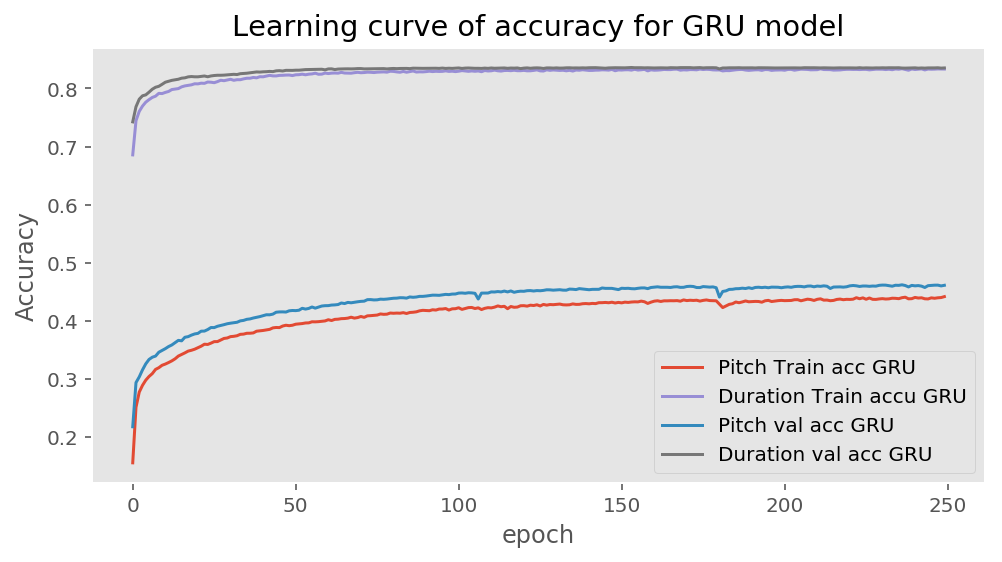

In [37]:
######################################
# Plot Learning curves of trained models
######################################

log = history_RNN
plt.figure(figsize=(8,4))
plt.plot(log['YP_loss'], c=c[0], label='Pitch Train loss RNN')
plt.plot(log['YT_loss'], c=c[1], label='Dur Train loss RNN')
plt.plot(log['val_YP_loss'], c=c[2], label='Pitch val loss RNN')
plt.plot(log['val_YT_loss'], c=c[3], label='Dur val loss RNN')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title("Learning curve of loss for RNN model")
plt.legend(loc='best')

plt.figure(figsize=(8,4))
plt.plot(log['YP_acc'], c=c[0], label='Pitch Train acc RNN')
plt.plot(log['YT_acc'], c=c[2], label='Duration Train acc RNN')
plt.plot(log['val_YP_acc'], c=c[1], label='Pitch val acc RNN')
plt.plot(log_2['val_YT_acc'], c=c[3], label='Duration val acc RNN')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title("Learning curve of accuracy for RNN model")


log = history_GRU
plt.figure(figsize=(8,4))
plt.plot(log['YP_loss'], c=c[0], label='Pitch Train loss GRU')
plt.plot(log['YT_loss'], c=c[1], label='Duration Train loss GRU')
plt.plot(log['val_YP_loss'], c=c[2], label='Pitch val loss GRU')
plt.plot(log['val_YT_loss'], c=c[3], label='Duration val loss GRU')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title("Learning curve of loss for GRU model")
plt.legend(loc='best')

plt.figure(figsize=(8,4))
plt.plot(log['YP_acc'], c=c[0], label='Pitch Train acc GRU')
plt.plot(log['YT_acc'], c=c[2], label='Duration Train accu GRU')
plt.plot(log['val_YP_acc'], c=c[1], label='Pitch val acc GRU')
plt.plot(log['val_YT_acc'], c=c[3], label='Duration val acc GRU')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title("Learning curve of accuracy for GRU model")


**Question 5.3**


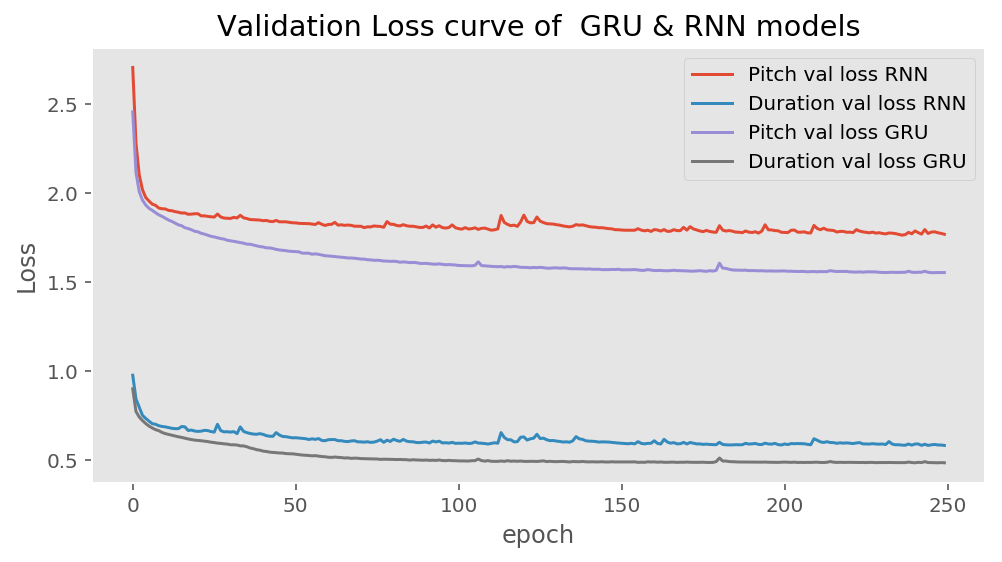

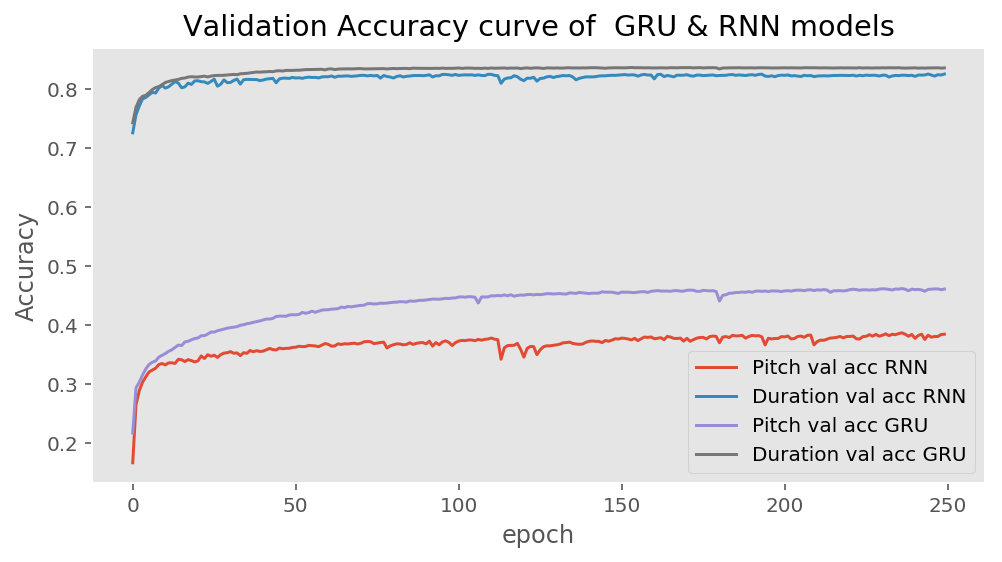

In [38]:
log = history_RNN
log_2 = history_GRU
plt.figure(figsize=(8,4))
plt.plot(log['val_YP_loss'], c=c[0], label='Pitch val loss RNN')
plt.plot(log['val_YT_loss'], c=c[1], label='Duration val loss RNN')
plt.plot(log_2['val_YP_loss'], c=c[2], label='Pitch val loss GRU')
plt.plot(log_2['val_YT_loss'], c=c[3], label='Duration val loss GRU')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title("Validation Loss curve of  GRU & RNN models")
plt.legend(loc='best')

plt.figure(figsize=(8,4))
plt.plot(log['val_YP_acc'], c=c[0], label='Pitch val acc RNN')
plt.plot(log['val_YT_acc'], c=c[1], label='Duration val acc RNN')
plt.plot(log_2['val_YP_acc'], c=c[2], label='Pitch val acc GRU')
plt.plot(log_2['val_YT_acc'], c=c[3], label='Duration val acc GRU')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title("Validation Accuracy curve of  GRU & RNN models")



In [39]:
index= np.argmin(history_RNN['val_loss'])

print("#"*100,"\n")

print("Best Model using simple RNN has Validation Pitch Accuracy: {:.2f}, Duration Accuracy: {:.2f}".format(history_RNN['val_YP_acc'][index]*100,history_RNN['val_YT_acc'][index]*100))
print("Best Model using GRU has Validation Pitch Accuracy: {:.2f}, Duration Accuracy: {:.2f}".format(history_GRU['val_YP_acc'][index]*100,history_GRU['val_YT_acc'][index]*100))

print("\n","#"*100,"\n")

#################################################################################################### 

Best Model using simple RNN has Validation Pitch Accuracy: 38.66, Duration Accuracy: 82.31
Best Model using GRU has Validation Pitch Accuracy: 46.16, Duration Accuracy: 83.52

 #################################################################################################### 



**Question**: What are the best prediction accuracies you obtained? With which model?
    
**Answer**: **46.16%** on the pitch prediction and **83.5%** on the duration prediciton @ GRU model.

**Question**: In a few sentences, comment on the plot comparing learning curves for the two activation function.
    
**Answer**:  Both the activation functions converged to minimum (local) at the same s



## Exercise 6: Visualizing the model
### Description

1. Using the model.predict and plotMelody functions, show the outputs of your best model when fed with 4 randomly selected melodies. Report the prediction accuracies as well.
2. For the same melodies, plot the hidden state evolution accross time steps. Construct a 2 dimensional matrix with the first dimension being time and the second the concatenation of all hidden unit activations and plot it using the provided `plotMelody` function. To get the hidden states of your network, you can modify the `buildModel` function so that you have another computation graph (another model with the same layers, but the output layer) returning you the hidden states. However, other approaches are equally valid.  
3. For each hidden unit $i$ and accross the entire dataset, compute the average absolute change in activation $\Delta A_i$. Be careful not to take masked timesteps into account. Plot the histogram (50 bins) of this average for the RNN and GRU models on the same figure.

### Solution

**Question 6.1**


In [45]:
#####################################################################
# Randomly plot output of 4 melodies and report prediction accuraies
####################################################################

sample_4 = np.random.choice(array_T.shape[0], 4)
print("Selected the samples with ID: ", sample_4)

###### get the input and target for the new randomly sampled data
x_t, x_p = array_T[sample_4,:-1,:], array_P[sample_4,:-1,:]
y_t, y_p = array_T[sample_4,1:,:], array_P[sample_4,1:,:]
 
print("\nPredicting the Pitch and Duration for 4 Random Samples")    
yp_t, yp_p = GRUmodel.predict([x_t,x_p])  
print("Predictions Done!")

#plotMelody(y_t[0],y_p[0], dictionaries, yp_t[0],yp_p[0])

print("\nEvaluating the Pitch and Duration for 4 Random Samples")
y = GRUmodel.evaluate([x_t,x_p],[y_t,y_p])  
print("Statistics on 4 Random samples\n") 
print("Pitch Accuracy: {:.2f}\nDuration Accuracy: {:.2f}".format(y[3],y[4]))

Selected the samples with ID:  [2856 1777  112  436]

Predicting the Pitch and Duration for 4 Random Samples
Predictions Done!

Evaluating the Pitch and Duration for 4 Random Samples
4/4 [==============================] - 0s
Statistics on 4 Random samples

Pitch Accuracy: 0.80
Duration Accuracy: 0.48


Plotting Melody for 0 th sample without zero padding


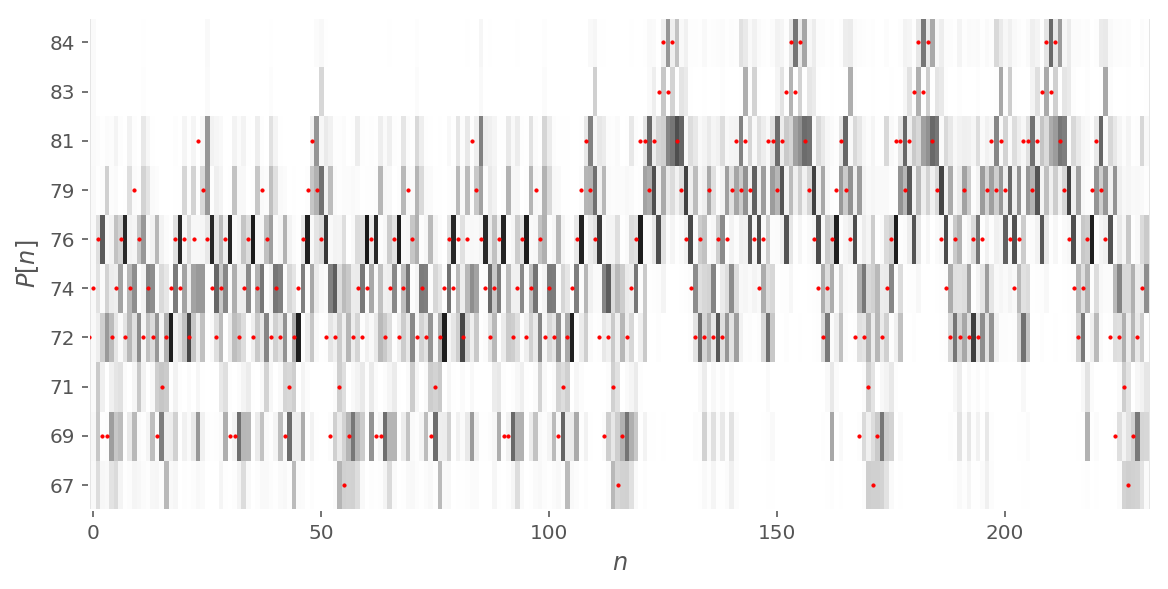

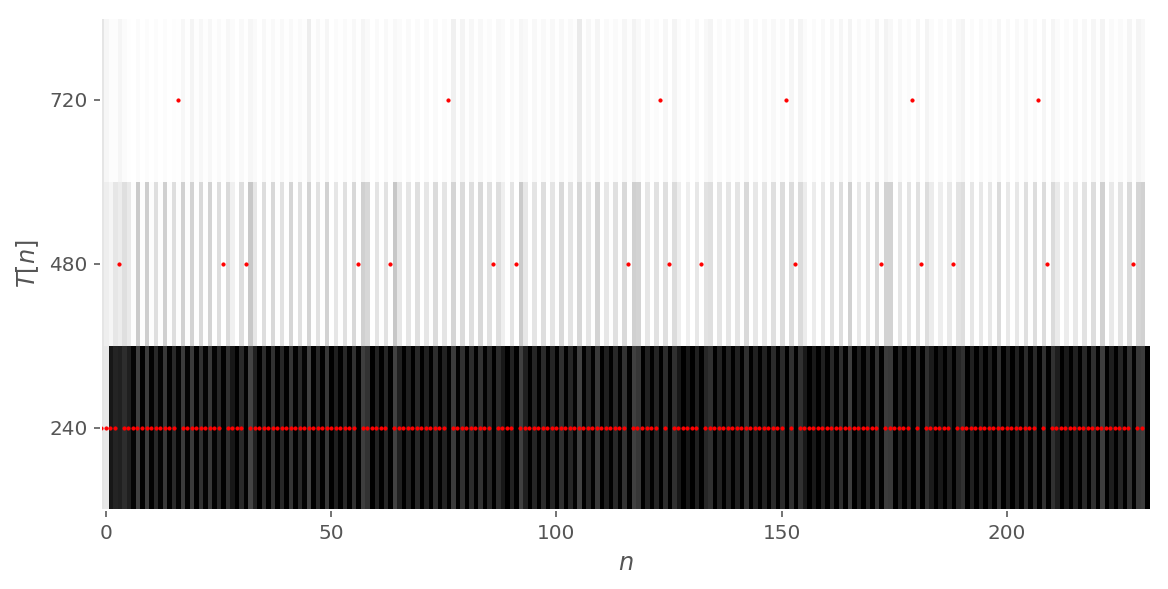

Plotting Melody for 1 th sample without zero padding


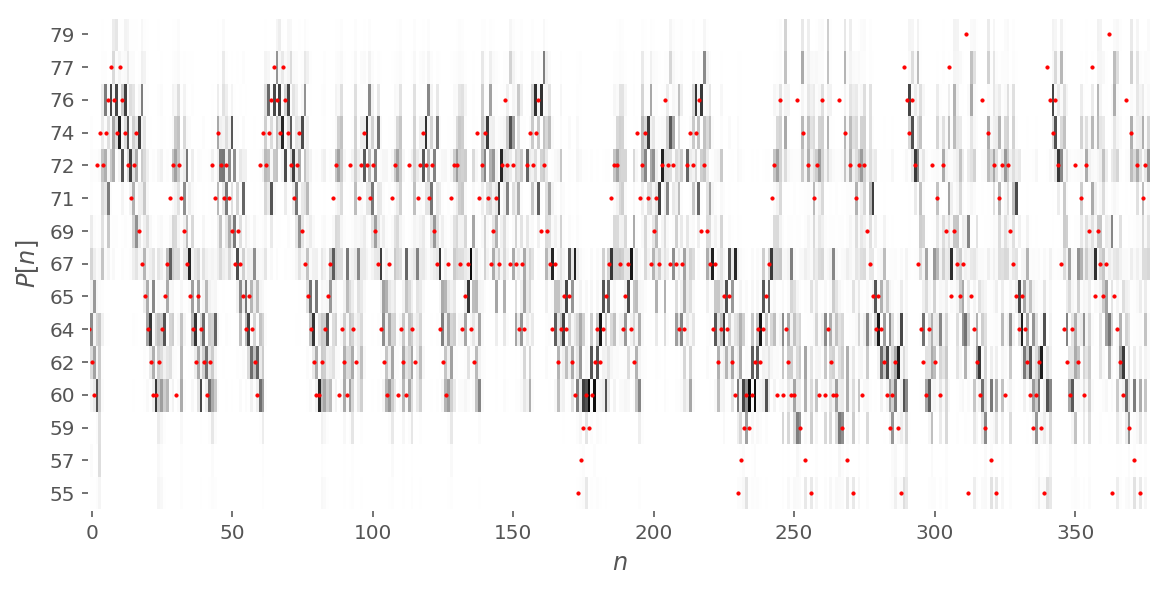

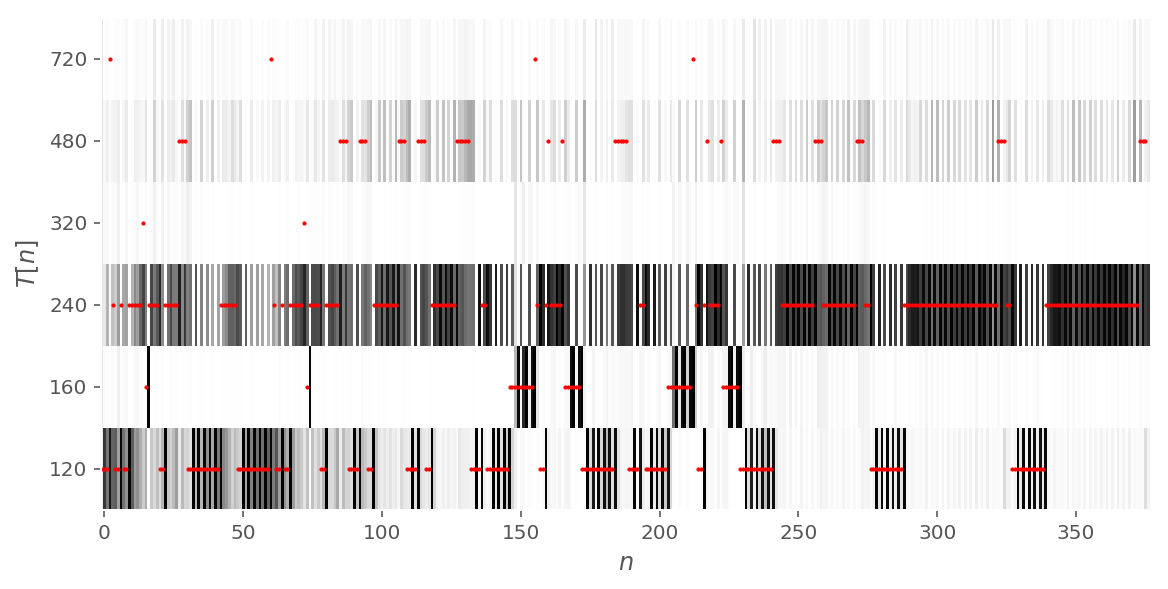

Plotting Melody for 2 th sample without zero padding


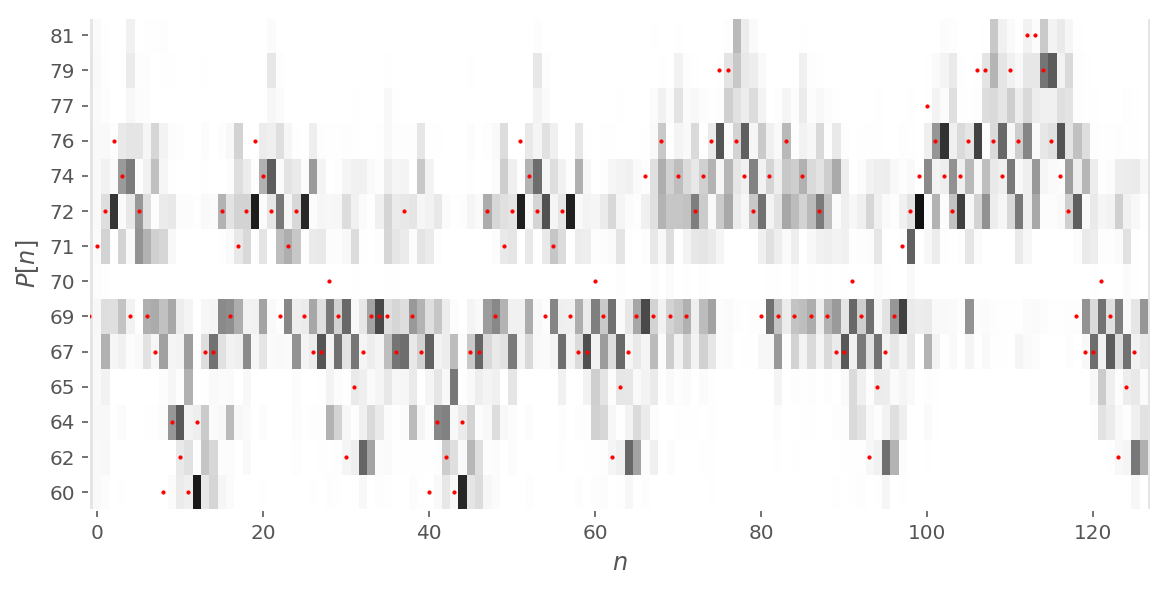

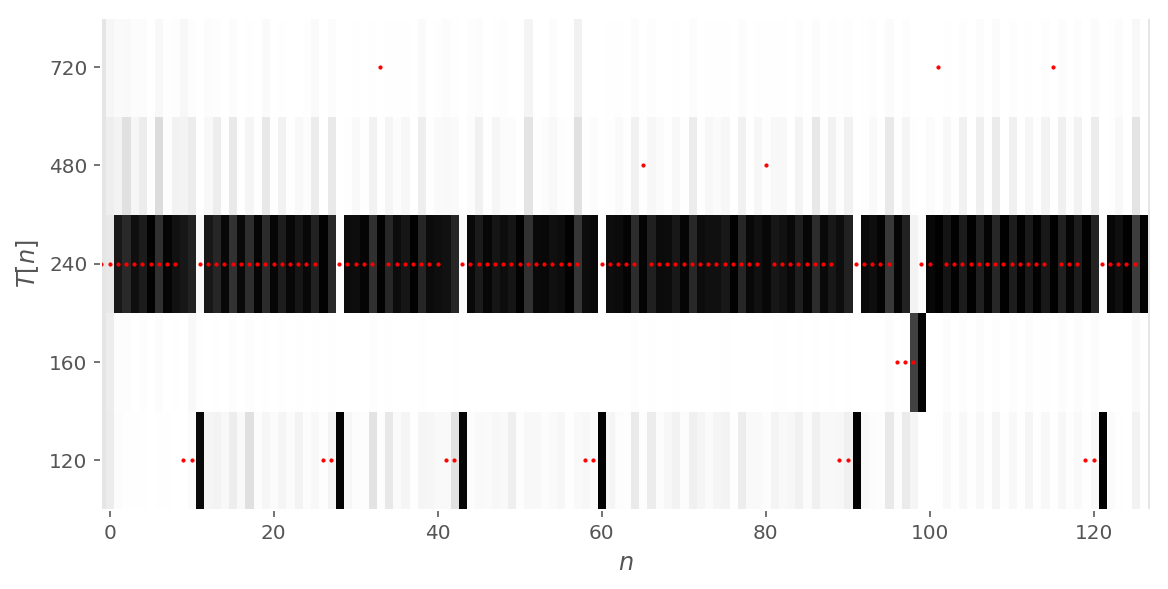

Plotting Melody for 3 th sample without zero padding


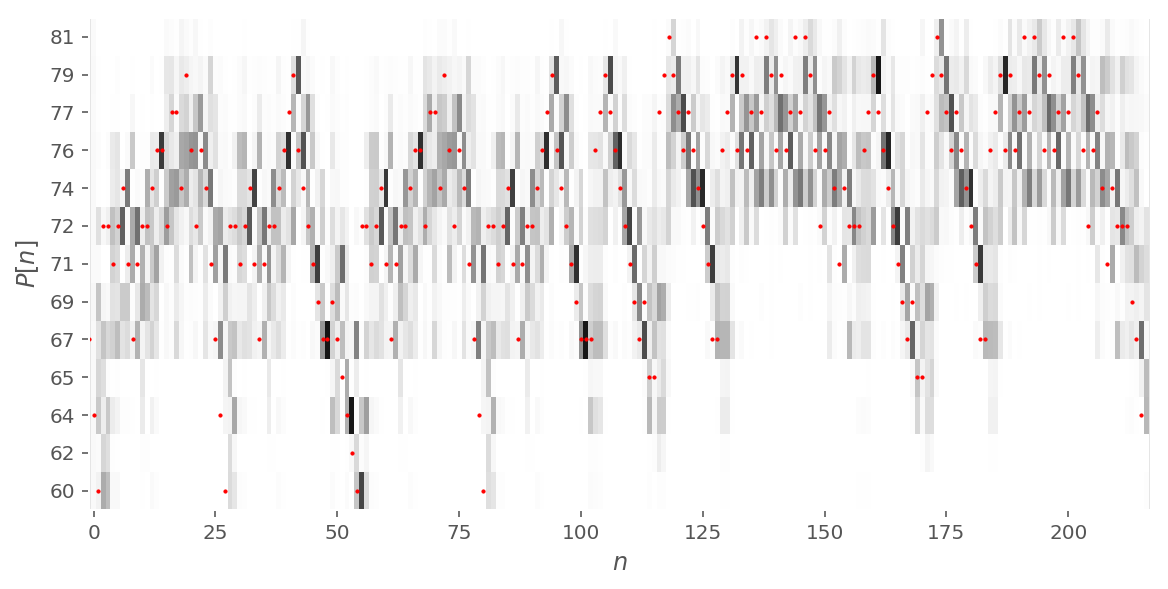

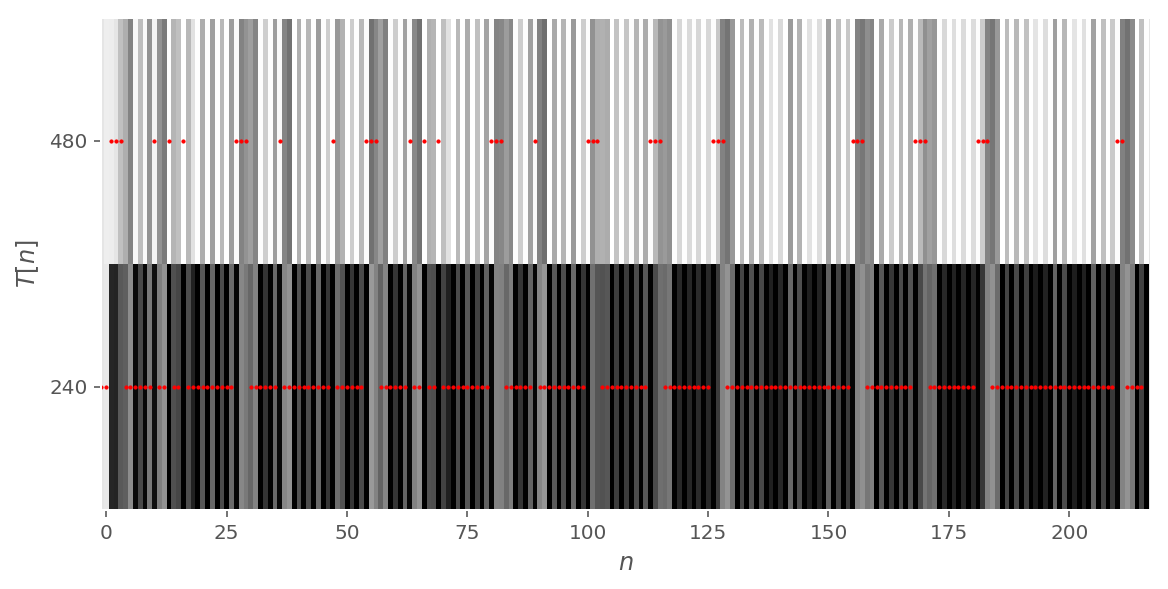

In [79]:
#####################################
# Plot Melodies of predictions
########################################

for j in range(4):
    print("Plotting Melody for {:d} th sample without zero padding".format(j))
    index, value = np.nonzero(y_t[j])
    start = index[0]
    plotMelody(y_p[j,start:],y_t[j,start:], dictionaries, yp_p[j,start:],yp_t[j,start:])

**Question 6.2**


Predictions with hidden for 4 samples

4/4 [==============================] - 0s
Predictions Done
Plotting Hidden states of 0 th sample without zero padding


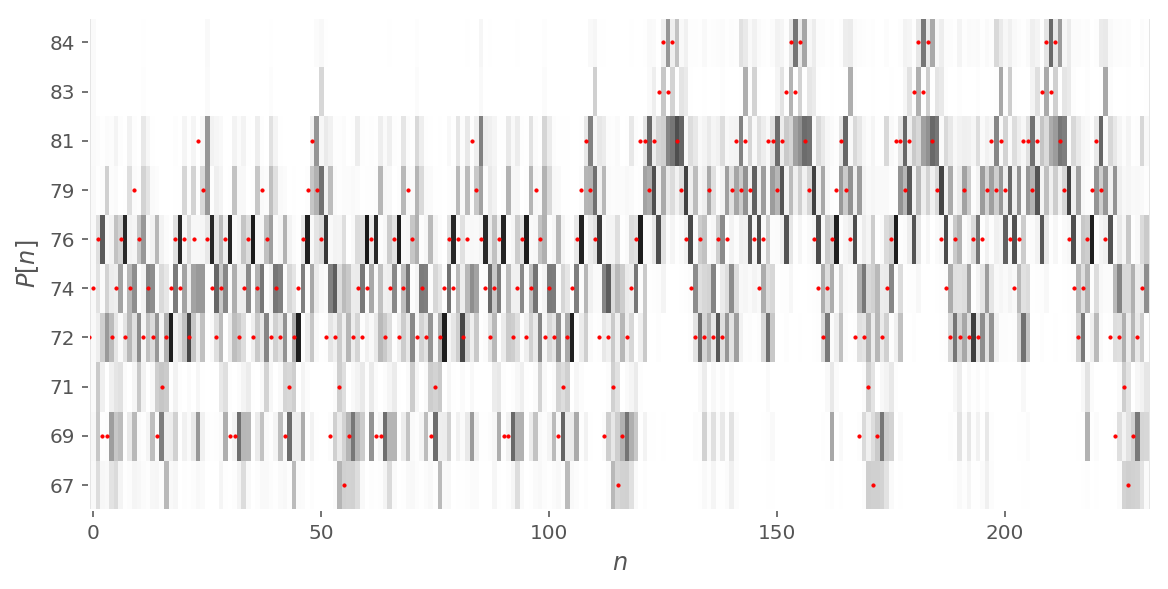

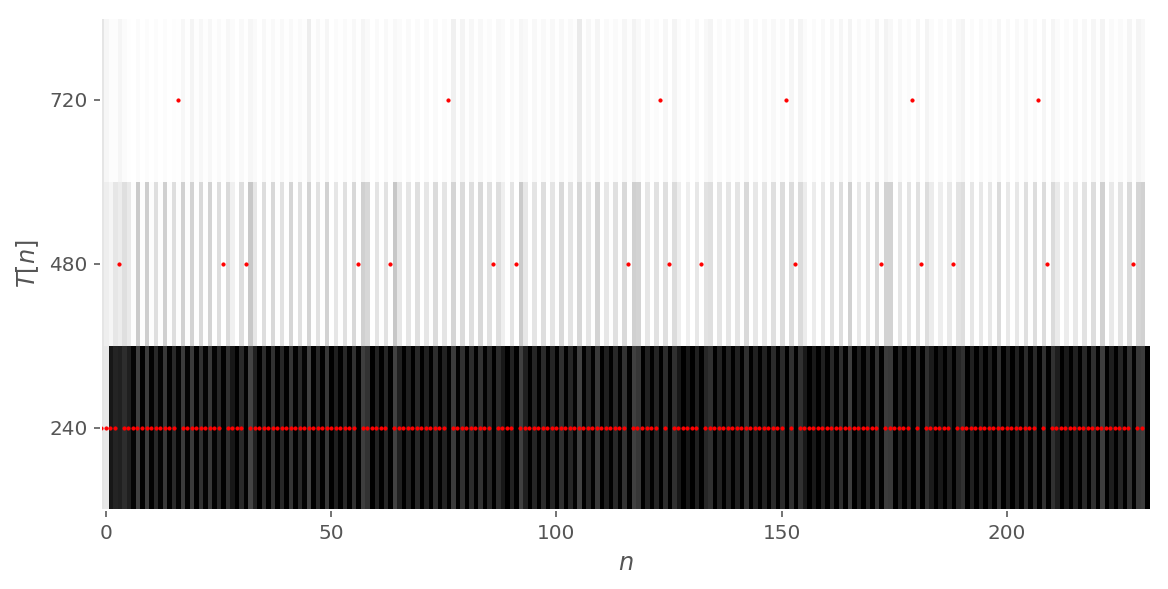

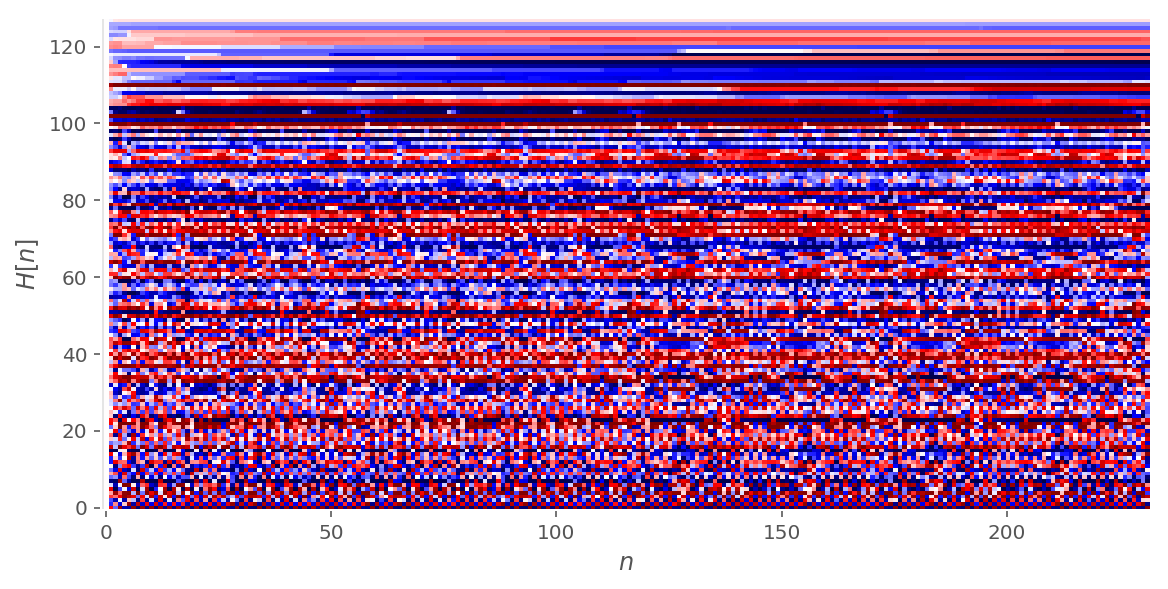

Plotting Hidden states of 1 th sample without zero padding


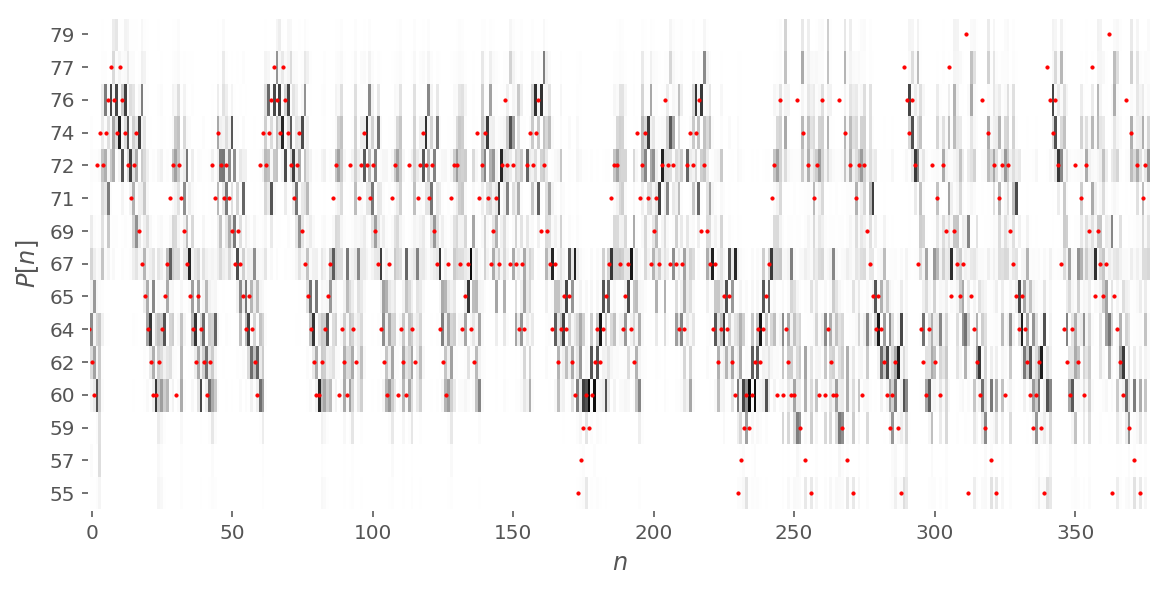

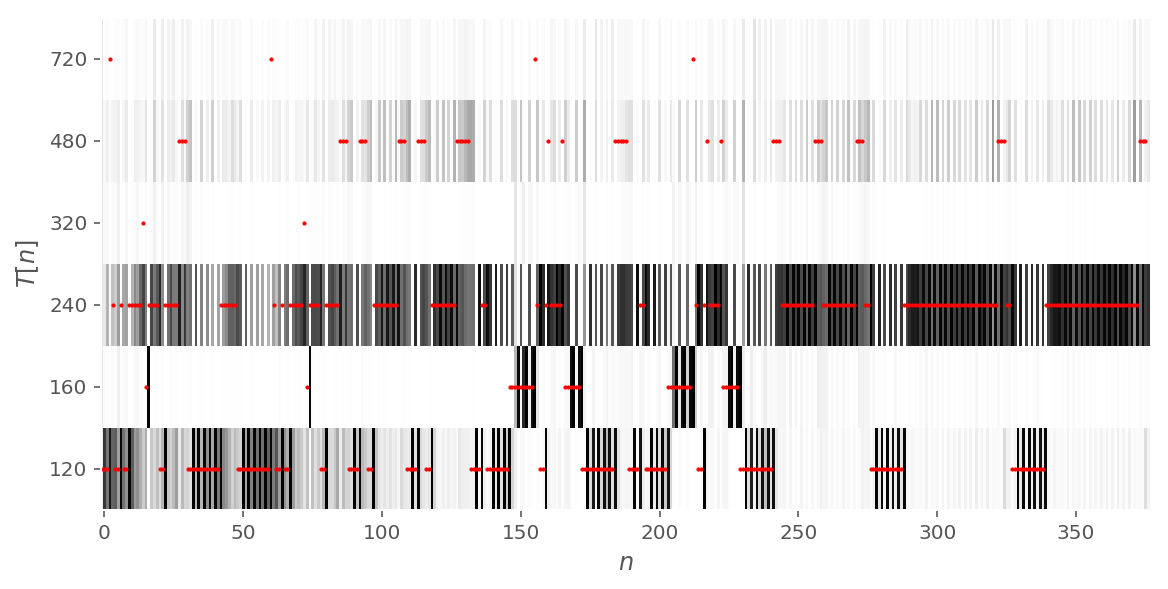

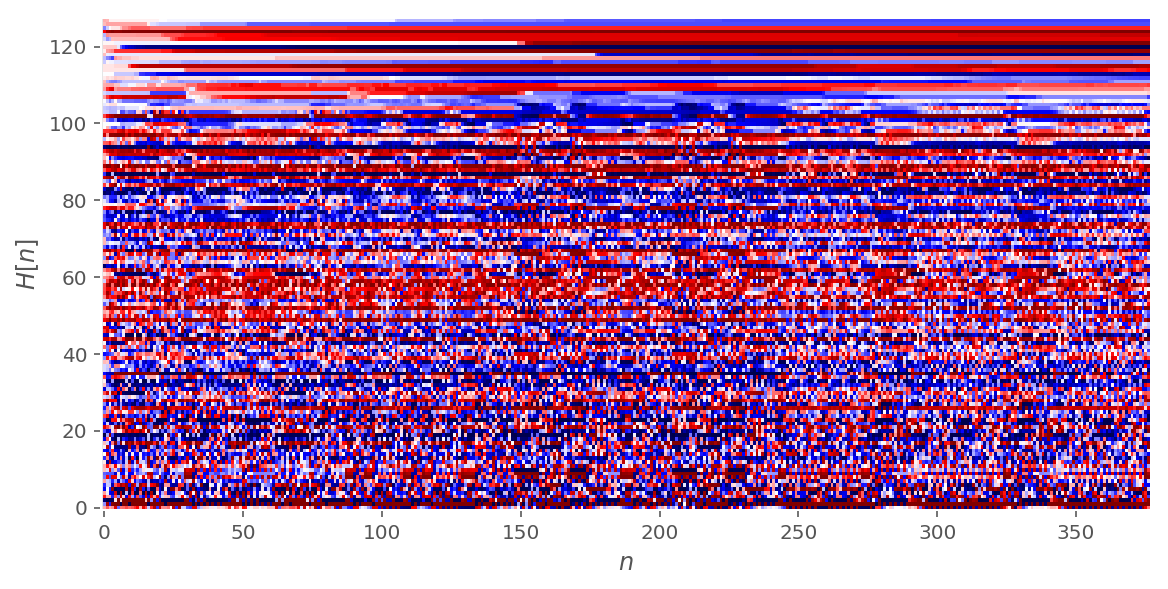

Plotting Hidden states of 2 th sample without zero padding


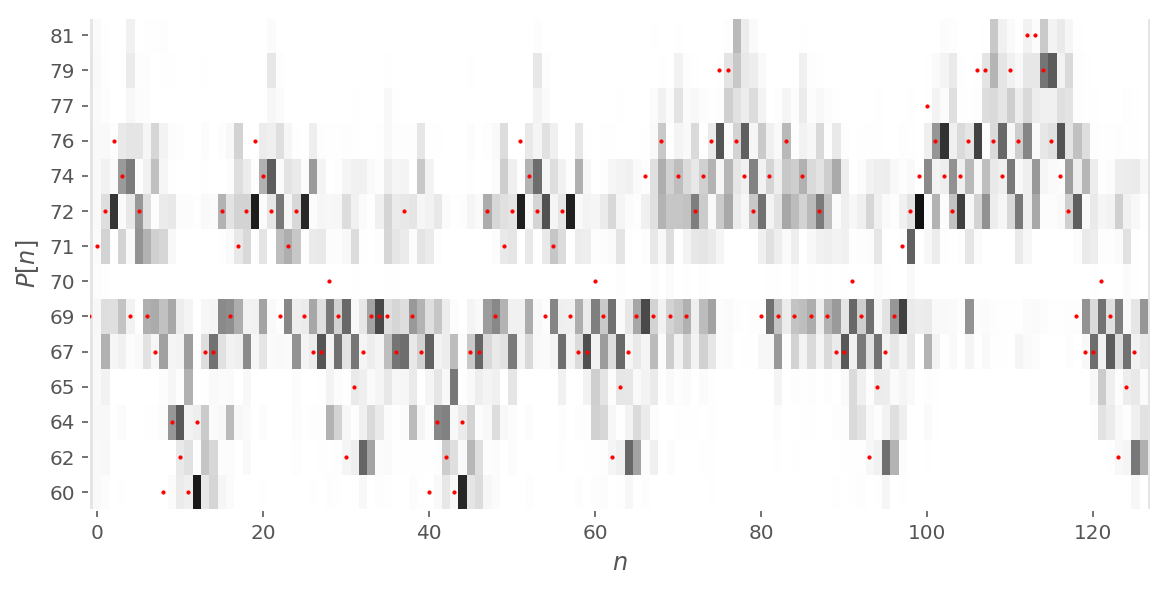

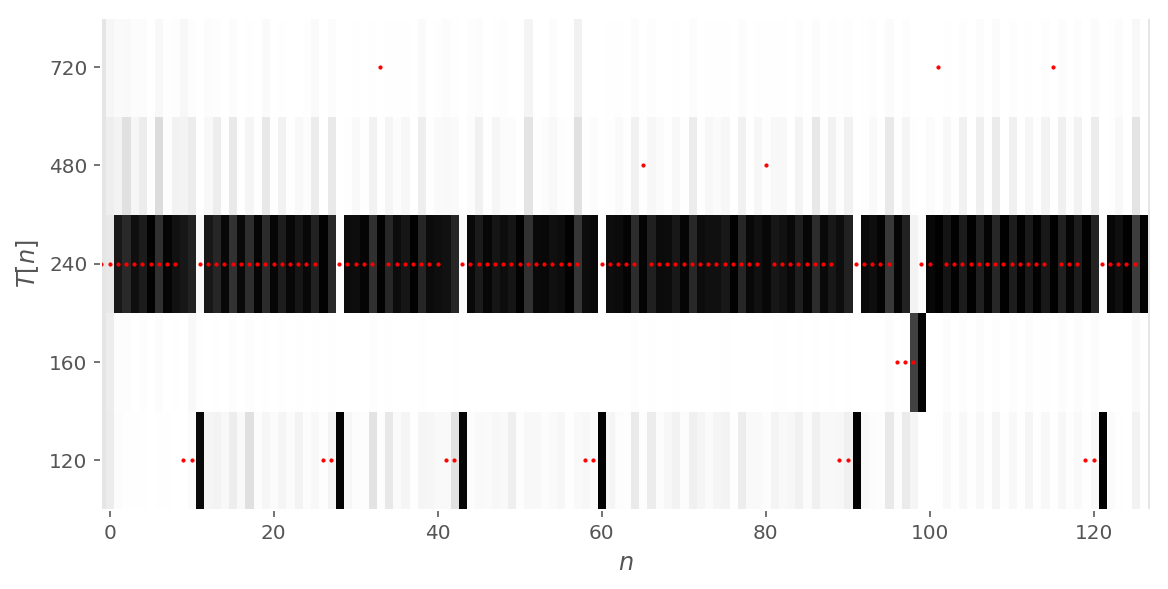

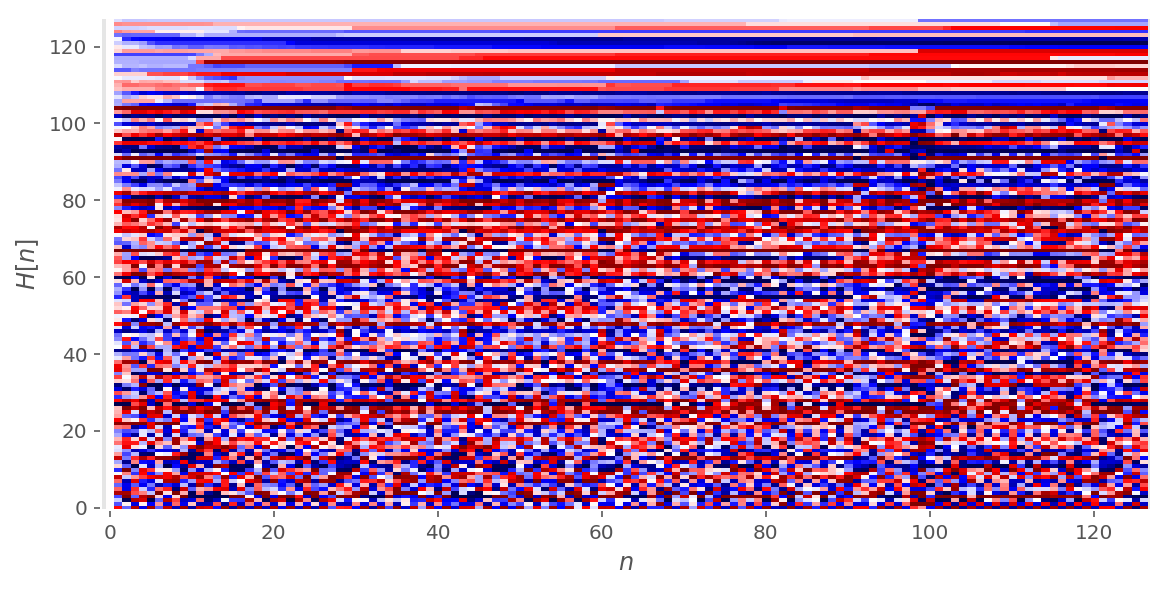

Plotting Hidden states of 3 th sample without zero padding


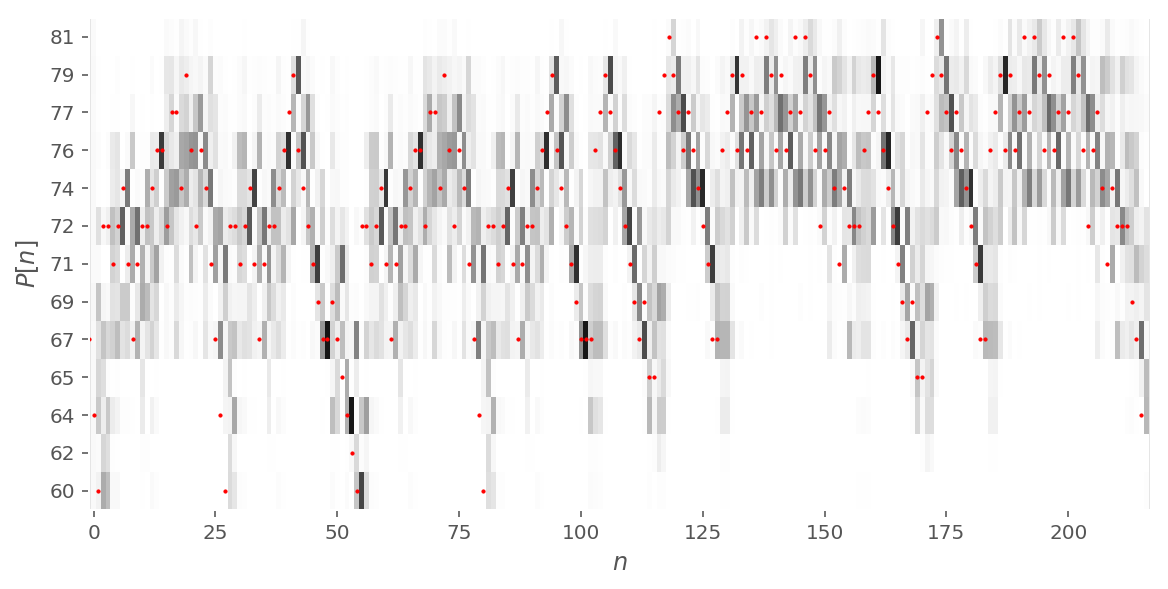

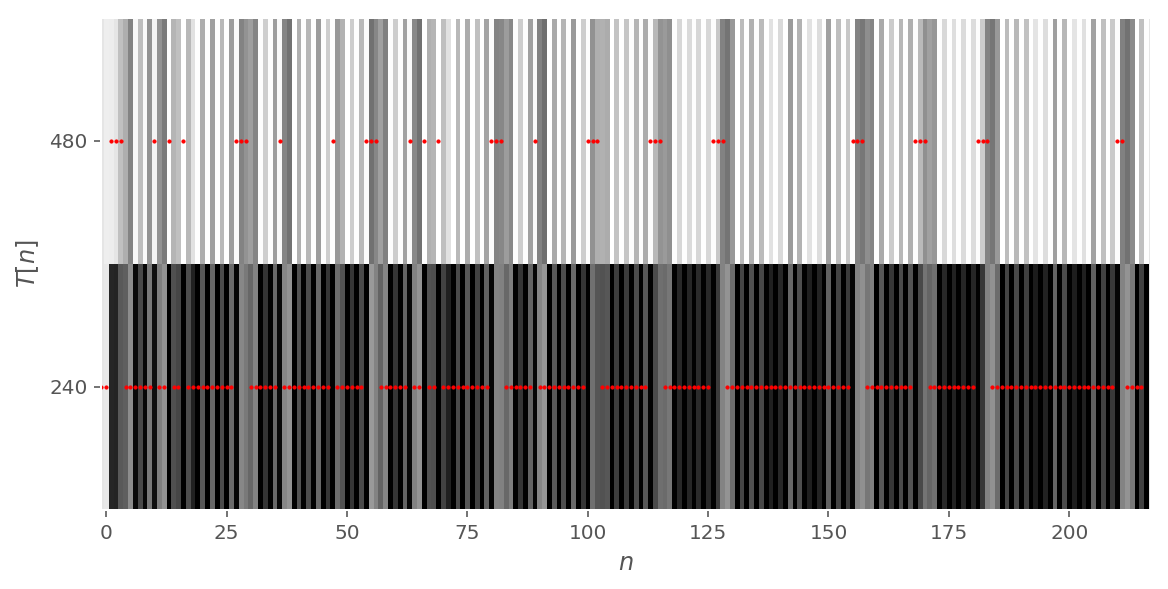

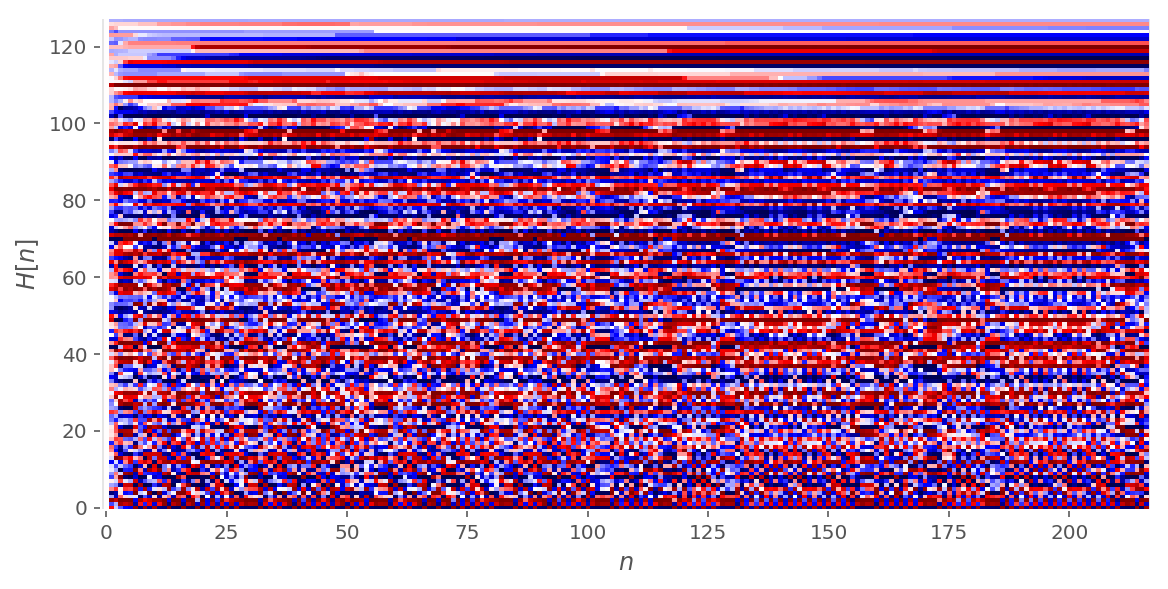

In [78]:
######################################################
# Q2. Plot hidden state evolution across timesteps
#####################################################

print("Predictions with hidden for 4 samples\n")
yp_t, yp_p, yp_h = GRUmodel_hidden.predict([x_t,x_p], verbose=1)  
print("Predictions Done")

for j in range(4):
    print("Plotting Hidden states of {:d} th sample without zero padding".format(j))
    index, value = np.nonzero(y_t[j])
    start = index[0]
    plotMelody(P=y_p[j,start:], T=y_t[j,start:], dictionaries= dictionaries, PrP= yp_p[j,start:],PrT=yp_t[j,start:], H=yp_h[j,start:])


**Question 6.3**


 Predictions with hidden state for 4403 samples using GRU model

4403/4403 [==============================] - 44s    
Predictions Done!
 Predictions with hidden state for 4403 samples using RNN model

4403/4403 [==============================] - 27s    
Predictions Done!


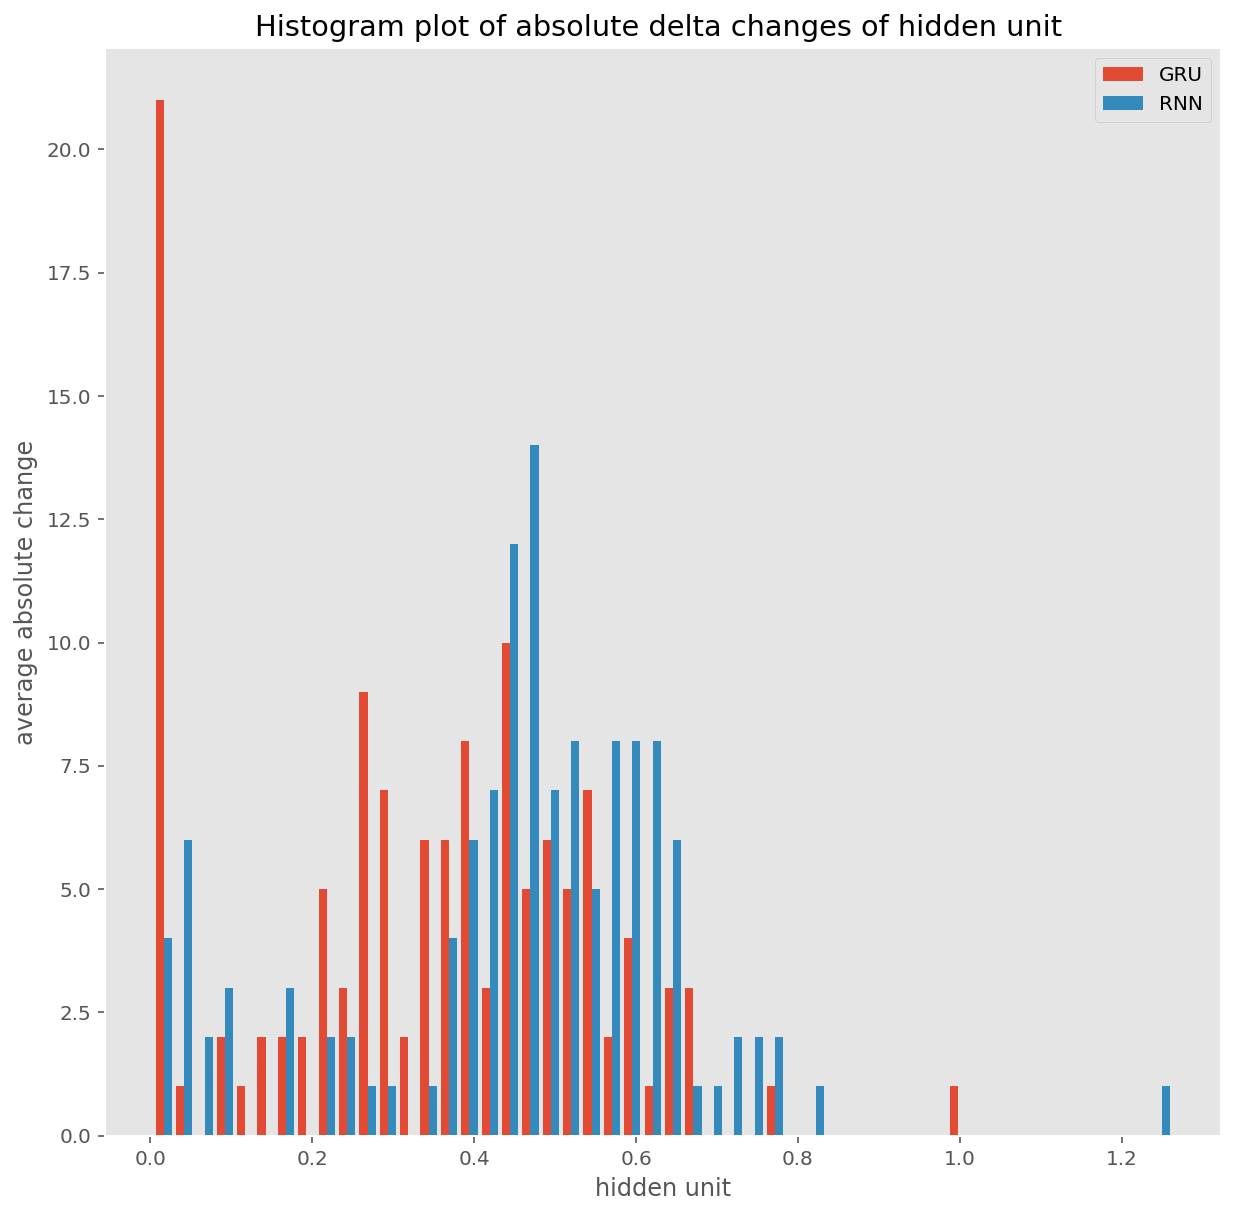

In [63]:
##########################################
#  Q3 average abolsute change of hidden unit
###########################################

N=array_T.shape[0]

print("\nPredictions with hidden state for {} samples using GRU model\n".format(N))
_,_,yp_h = GRUmodel_hidden.predict([array_T[:N,:-1,:],array_P[:N,1:,:]], verbose=1)
print("Predictions Done!")

# for GRU model
Delh_GRU =np.zeros((yp_h.shape[2]))  # Delta H for each hidden unit

for j in range(N):
    index, value = np.nonzero(array_T[j])
    start = index[0]  # Starting point of nonzero sequence, before zero padded   
    Delh_GRU += np.mean(np.abs(yp_h[j,start+1:,:]-yp_h[j,start:-1,:]), axis=0)
Delh_GRU /=N

# for RNN model
print("\nPredictions with hidden state for {} samples using RNN model\n".format(N))
_,_,yp_h = RNNmodel_hidden.predict([array_T[:N,:-1,:],array_P[:N,1:,:]], verbose=1)
print("Predictions Done!")
Delh_RNN=np.zeros((yp_h.shape[2])) # Delta H for each hidden unit

for j in range(N):
    index, value = np.nonzero(array_T[j])
    start = index[0]  # Starting point of nonzero sequence, before zero padded   
    Delh_RNN += np.mean(np.abs(yp_h[j,start+1:,:]-yp_h[j,start:-1,:]), axis=0)
Delh_RNN /=N

# Histogram plot
fig = plt.figure(figsize=(10,10))
plt.hist([Delh_GRU,Delh_RNN], bins=50, label=['GRU','RNN'])
plt.title('Histogram plot of absolute delta changes of hidden unit ')
plt.xlabel('hidden unit')
plt.ylabel('average absolute change')
plt.legend(loc="best")
plt.show()


**Question**: How does the hidden state dynamics explain the performance of the RNN vs GRU models? Explain in term of temporal dependencies and base your explanation on figures obtained in 6.2 and 6.3.
    
**Answer**: Hidden state of GRU model has relatively less changes in hidden state then RNN model. As also observed from 6.3, GRU model has very absolute state change


## Exercise 7: Generation of new melodies
### Description

1. Use your trained best model to generate new melodies. You can do that by starting with a random note, feeding it to your network and sample the output predictions in order to select the next note. Then add this note to your iteratively growing melodies. For your convenience, we provided the `sample` and `writeMIDI` functions. You can use the first in order to perform temperature sampling. The `writeMIDI` function allows you to write a MIDI file from the integer representation.
2. Try different sampling temperatures (e.g. 0.5, 1., 1.5) and observe the effect on your generated melodies.
3. Generate 32 melodies with both the RNN and GRU models
4. Listen to 4 randomly chosen melodies (2 from the GRU model and 2 from the RNN model). To play in a notebook, use a similar approach as the one shown below assuming you have the files `GRU_1.mid` and `RNN_1.mid` at the same level as this notebook. For your own curiosity, you can also directly listen to the MIDI files with your favorite MIDI player but make sure that we can listen to the 4 extracts directly from this notebook (without rerunning it). You might have to use the "Trust notebook" button (in the top right corner) to see the players. This currently only works in jupyter notebook (not jupyter lab). If you have trouble achieving that, upload the MIDI files with your submission.
5. (Optional) If you have a big enough computing power, try adding multiple and bigger layers. You could also try to improve your model with different add-ons, e.g. make your model learn when a melody ends, extend it to other datasets, ...
6. (Optional) If you are happy with your results submit a 1 hour long generated MIDI file to the [AI-generated music challenge](https://www.crowdai.org/challenges/ai-generated-music-challenge). 

### Solution

**Question 7.1**


Initializing Pitch and Duration with a random dictionary element
Initialization Done with Pitch Note at 35, Duration Note at 4
Writing the Melody to disk

saved the melody to disk
Plotting the generated melody



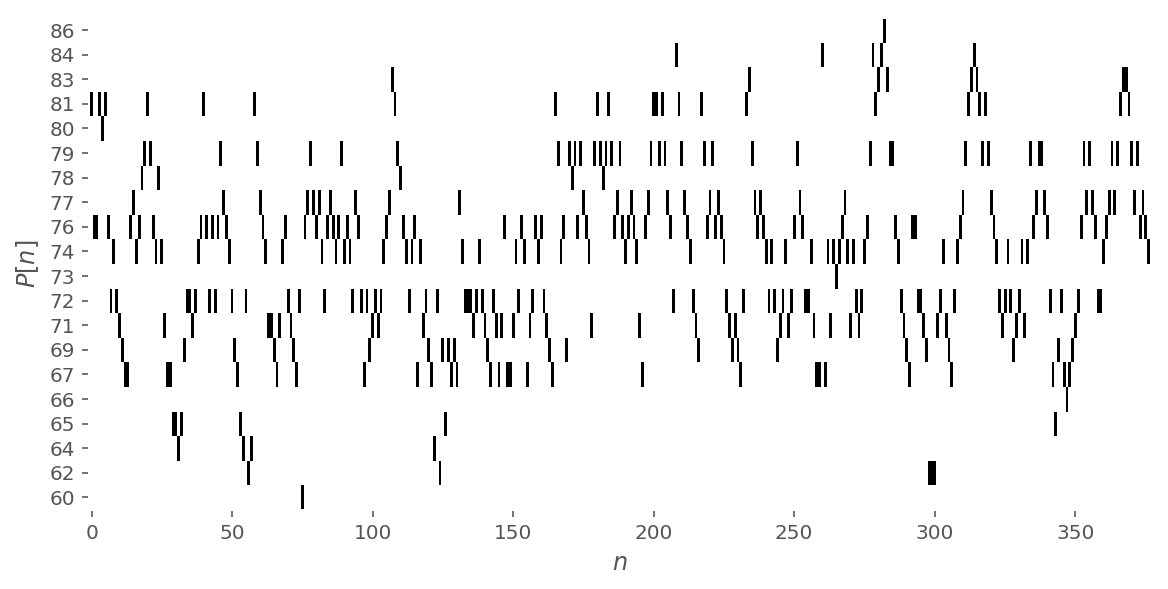

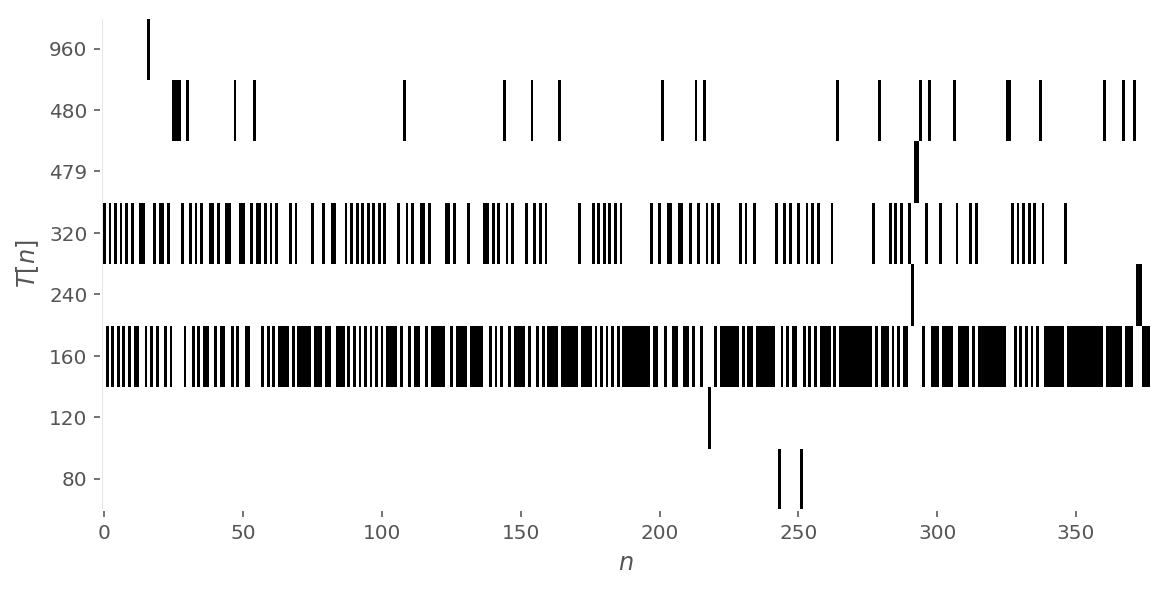

In [93]:
######################################################
# Q7.1 Generating new melodies with the best GRU model
#####################################################

#initialize last timestep  of input array with a random note 
print("Initializing Pitch and Duration with a random dictionary element")
SEQ_LENGTH = array_T.shape[1]

def _generate(model, temperature):
    x_t, x_p= np.zeros((1, SEQ_LENGTH-1, 19)), np.zeros((1, SEQ_LENGTH-1, 50))
    index = np.random.choice(np.arange(0, x_t.shape[2]))
    x_t[0,-1,index]= 1
    index2 = np.random.choice(np.arange(0, x_p.shape[2]))
    x_p[0,-1,index2] = 1
    print("Initialization Done with Pitch Note at {:d}, Duration Note at {:d}".format(index2, index))
    
    for j in range(SEQ_LENGTH-1):
        pred_t, pred_p = model.predict([x_t,x_p]) # Do predictions
        x_t, x_p = x_t[:,1:,:], x_p[:,1:,:]       # Pop out oldest timestep
        sampled_t = sample(pred_t[0,-1,:], temperature)  # Sample the latest spredictions
        sampled_p = sample(pred_p[0,-1,:], temperature)  # Sample the latest spredictions
        dt, dp = np.zeros((1,x_t.shape[2])), np.zeros((1,x_p.shape[2]))
        dt[0,sampled_t] = 1
        dp[0,sampled_p] = 1
        x_t = np.concatenate((x_t,np.expand_dims(dt,0)), axis=1)  #append the new sampled output to input
        x_p = np.concatenate((x_p,np.expand_dims(dp,0)), axis=1)  #append the new sampled output to input
    return x_t, x_p


gen_t, gen_p = _generate(GRUmodel, temperature=1.0)
print("Writing the Melody to disk\n")
writeMIDI(np.argmax(gen_p[0],1),np.argmax(gen_t[0],1), dictionaries, "./Generated_Melodies/GRU_Best_0.mid")
print("saved the melody to disk")
print("Plotting the generated melody\n")
plotMelody(gen_p[0],gen_t[0],dictionaries)


**Question 7.2**


Generating Melody with temperature 0.50
Initialization Done with Pitch Note at 42, Duration Note at 12
Writing the Melody to disk

saved the melody to disk
Plotting the generated melody



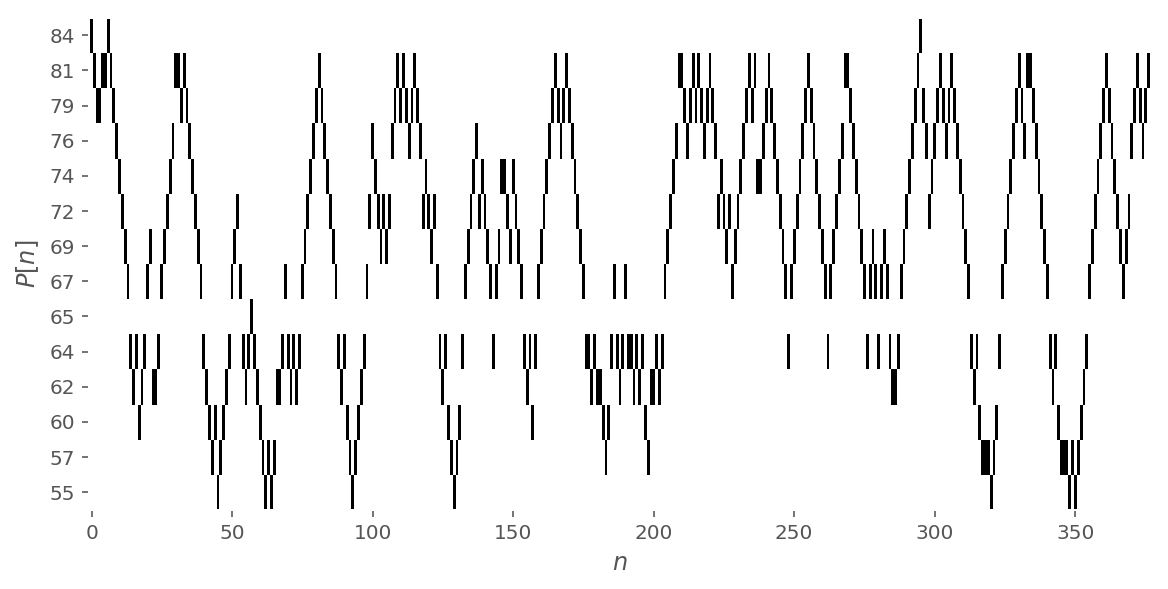

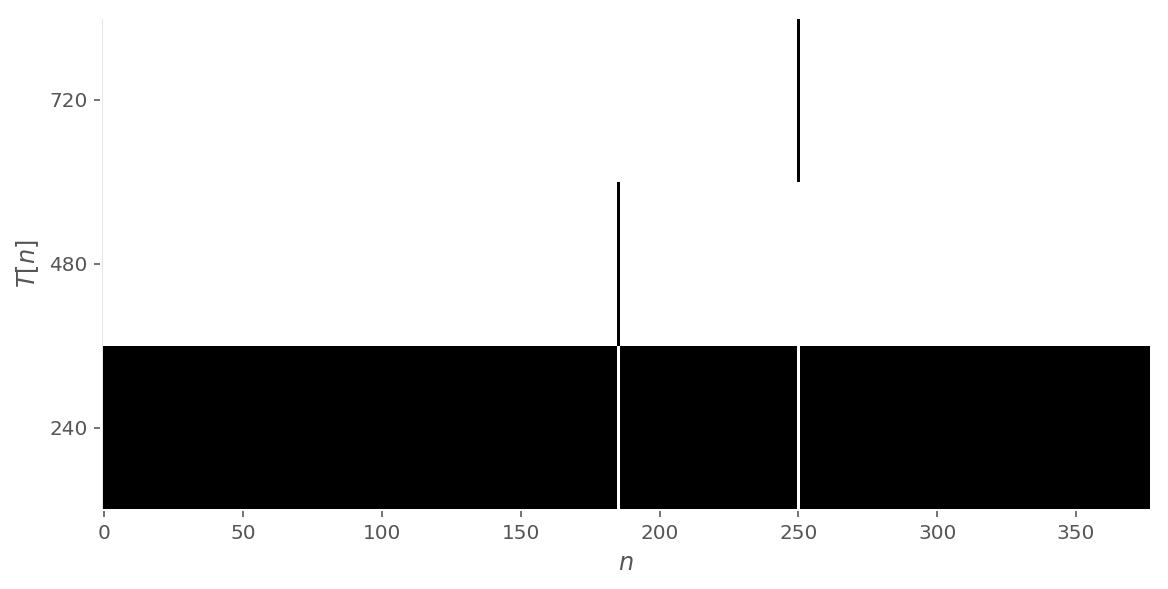

Generating Melody with temperature 1.00
Initialization Done with Pitch Note at 45, Duration Note at 13
Writing the Melody to disk

saved the melody to disk
Plotting the generated melody



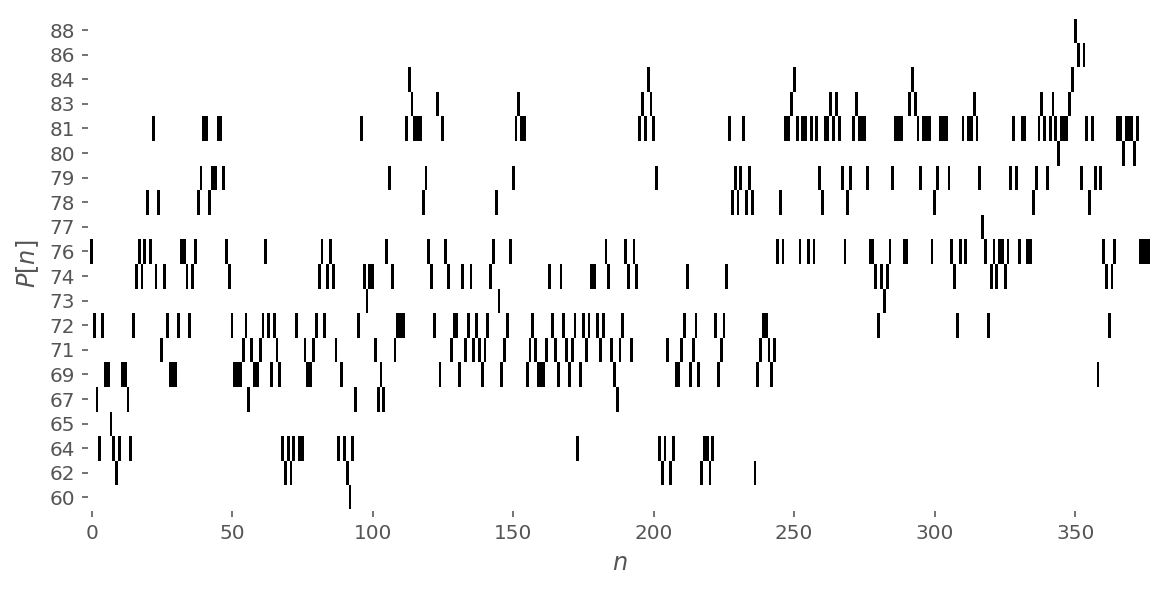

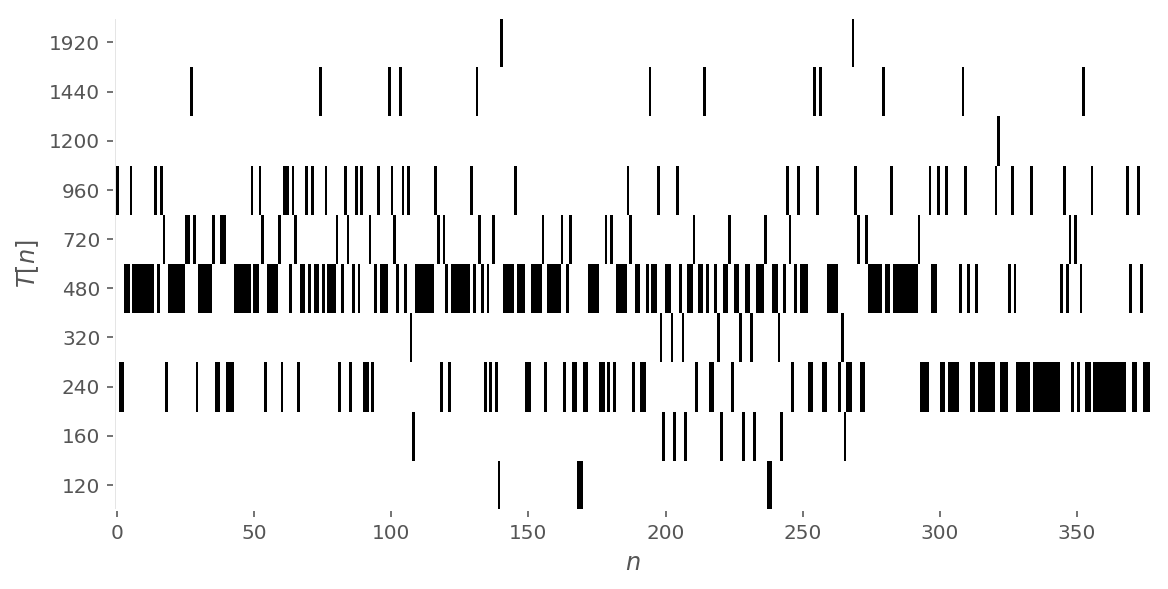

Generating Melody with temperature 1.50
Initialization Done with Pitch Note at 34, Duration Note at 1
Writing the Melody to disk

saved the melody to disk
Plotting the generated melody



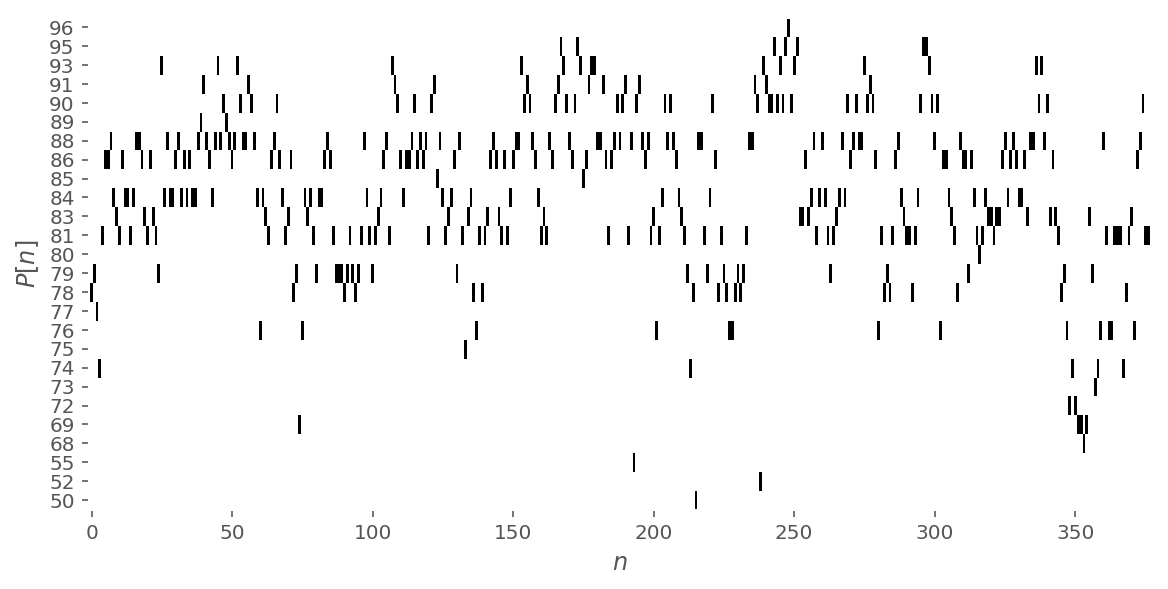

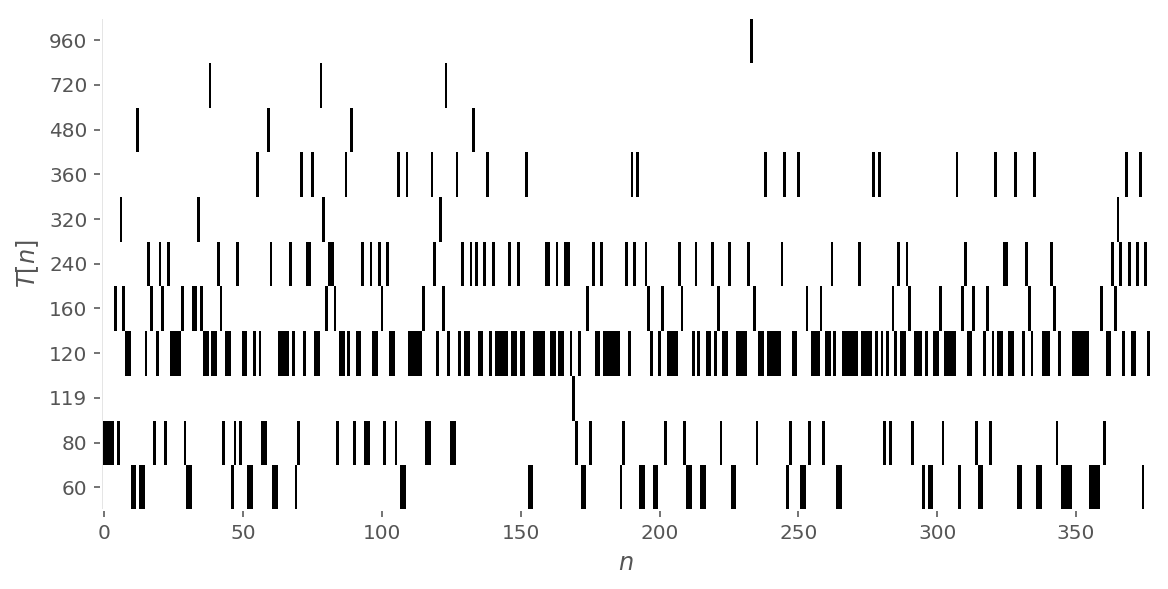

In [98]:
#######################################
# Effect of temperature
#######################################

for temperature in [0.5, 1.0, 1.5]:
    print("Generating Melody with temperature {:.2f}".format(temperature))
    gen_t, gen_p = _generate(GRUmodel, temperature=temperature)
    print("Writing the Melody to disk\n")
    writeMIDI(np.argmax(gen_p[0],1),np.argmax(gen_t[0],1), dictionaries, "./Generated_Melodies/GRU_Temperature_{:.2f}.mid".format(temperature))
    print("saved the melody to disk")
    print("Plotting the generated melody\n")
    plotMelody(gen_p[0],gen_t[0],dictionaries)

**Question 7.3**


In [96]:
################################################
# Generating 32 Melodies with RNN and GRU models
################################################

for j in range(32):
    print("\nGenerating Melody {:d} using GRU model".format(j))
    gen_t, gen_p = _generate(GRUmodel, temperature=temperature)
    print("Writing the GRU Melody to disk\n")
    writeMIDI(np.argmax(gen_p[0],1),np.argmax(gen_t[0],1), dictionaries, "./Generated_Melodies/GRU_Generated_{:d}.mid".format(j))
    print("saved the GRU melody to disk")
    print("\nGenerating Melody {:d} using RNN model".format(j))
    gen_t, gen_p = _generate(RNNmodel, temperature=temperature)
    print("Writing the RNN Melody to disk\n")
    writeMIDI(np.argmax(gen_p[0],1),np.argmax(gen_t[0],1), dictionaries, "./Generated_Melodies/RNN_Generated_{:d}.mid".format(j))
    print("saved the RNN melody to disk")


Generating Melody 0 using GRU model
Initialization Done with Pitch Note at 20, Duration Note at 16
Writing the GRU Melody to disk

saved the GRU melody to disk

Generating Melody 0 using RNN model
Initialization Done with Pitch Note at 41, Duration Note at 13
Writing the RNN Melody to disk

saved the RNN melody to disk

Generating Melody 1 using GRU model
Initialization Done with Pitch Note at 32, Duration Note at 5
Writing the GRU Melody to disk

saved the GRU melody to disk

Generating Melody 1 using RNN model
Initialization Done with Pitch Note at 3, Duration Note at 14
Writing the RNN Melody to disk

saved the RNN melody to disk

Generating Melody 2 using GRU model
Initialization Done with Pitch Note at 18, Duration Note at 7
Writing the GRU Melody to disk

saved the GRU melody to disk

Generating Melody 2 using RNN model
Initialization Done with Pitch Note at 44, Duration Note at 17
Writing the RNN Melody to disk

saved the RNN melody to disk

Generating Melody 3 using GRU model


Writing the RNN Melody to disk

saved the RNN melody to disk

Generating Melody 26 using GRU model
Initialization Done with Pitch Note at 47, Duration Note at 6
Writing the GRU Melody to disk

saved the GRU melody to disk

Generating Melody 26 using RNN model
Initialization Done with Pitch Note at 30, Duration Note at 12
Writing the RNN Melody to disk

saved the RNN melody to disk

Generating Melody 27 using GRU model
Initialization Done with Pitch Note at 32, Duration Note at 10
Writing the GRU Melody to disk

saved the GRU melody to disk

Generating Melody 27 using RNN model
Initialization Done with Pitch Note at 15, Duration Note at 2
Writing the RNN Melody to disk

saved the RNN melody to disk

Generating Melody 28 using GRU model
Initialization Done with Pitch Note at 21, Duration Note at 1
Writing the GRU Melody to disk

saved the GRU melody to disk

Generating Melody 28 using RNN model
Initialization Done with Pitch Note at 24, Duration Note at 3
Writing the RNN Melody to disk



**Question 7.4,  Attached the MIDI files separately with notebook. Unable to embed the files into the notebook**


In [ ]:
print('GRU')
index= np.random.choice(np.arange(0,32))
music21.midi.translate.midiFilePathToStream("./Generated_Melodies/GRU_Generated_{:d}.mid".format(index)).show('midi')

index= np.random.choice(np.arange(0,32))
print('RNN')
music21.midi.translate.midiFilePathToStream("./Generated_Melodies/RNN_Generated_{:d}.mid".format(index)).show('midi')

**Question**: What is the effect of the sampling temperature on the generated melodies?
    
**Answer**: Decreasing the temperature from 1.5 to some lower number (e.g. 0.5) makes the GRU more confident, but also more conservative in its samples. Conversely, higher temperatures will give more diversity but at cost of more mistakes.

**Question**: Are the generated melodies from the RNN model different from the one generated by the GRU model? If yes, what are the main differences?
**Answer**: The GRU model predicted more stable pitches and close to previous state than the RNN model

